# Utils

In [1]:
from collections import Counter, OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from typing import Tuple
from unidecode import unidecode

import emojis
import json
import lightgbm as lgb
import matplotlib
import numpy as np
import optuna
import pandas as pd
import re
import seaborn as sns
import spacy
import swifter

nlp = spacy.load('en_core_web_sm')

In [2]:
PATH = "../data/twibot/{}.json"
DATE_REF = "2022-06-01"

SEED = 42
PARAMS = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'seed': SEED
}

In [3]:
def get_X_y(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop('label', axis=1), df['label']    

def get_train_val(df: pd.DataFrame) -> Tuple[lgb.Dataset, lgb.Dataset]:
    """ Get train/validation/test datasets """
    X_train, X_val, y_train, y_val = train_test_split(*get_X_y(df),
                                                      test_size=0.2, 
                                                      random_state=SEED)
    return X_train, X_val, y_train, y_val

In [4]:
def train_clf(params: dict, 
              X_train: pd.DataFrame, 
              y_train: pd.Series, 
              X_val: pd.DataFrame, 
              y_val: pd.Series):
    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_train, y_train,
            eval_set=[( X_val, y_val )],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(100)])
    return clf


def objective_func(trial, 
                   X_train: pd.DataFrame, 
                   y_train: pd.Series, 
                   X_val: pd.DataFrame, 
                   y_val: pd.Series):
    params = {
        **PARAMS,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.3),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    clf = train_clf(params, X_train, y_train, X_val, y_val)
    y_pred = clf.predict(X_val)
    return roc_auc_score(y_val, y_pred)


def get_best_clf(df_train: pd.DataFrame):
    
    X_train, X_val, y_train, y_val = get_train_val(df_train)
    
    study = optuna.create_study(direction='maximize')
    objective = lambda trial: objective_func(trial, X_train, y_train, X_val, y_val)
    study.optimize(objective, n_trials=100, n_jobs=-1)
    
    print(study.best_params, "->", study.best_value)
    return train_clf(study.best_params, X_train, y_train, X_val, y_val)


def eval_clf(clf: lgb.LGBMClassifier, df_test: pd.DataFrame) -> None:
    """ Evaluate & show insights on best classifier """
    X_test, y_test = get_X_y(df_test)
    y_pred = clf.predict(X_test)
    
    # AUROC / accuracy
    auroc = roc_auc_score(y_test, y_pred)
    print('AUROC:', auroc)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)
    
    # Confusion matrix
    plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    
    # Features importance
    lgb.plot_importance(clf, max_num_features=15)

In [5]:
def get_probas(clf: lgb.LGBMClassifier, df_train: pd.DataFrame, df_test: pd.DataFrame):
    X_train, X_test = get_X_y(df_train)[0], get_X_y(df_test)[0]
    y_train_pred = pd.Series([ y[0] for y in clf.predict_proba(X_train) ])
    y_test_pred = pd.Series([ y[0] for y in clf.predict_proba(X_test) ])
    return y_train_pred, y_test_pred


def compute_agg(ids: pd.Series, labels: pd.Series, preds: pd.Series) -> pd.DataFrame:
    """ Get min/max/mean/median, aggregated by user """
    df = pd.concat([ ids, labels, preds ], axis=1)
    df.columns = [ 'id', 'label', 'pred' ]
    
    df_agg = pd.concat([
        df.groupby('id').max()['label'],
        df.groupby('id').min()['pred'],
        df.groupby('id').max()['pred'],
        df.groupby('id').mean()['pred'],
        df.groupby('id').median()['pred']
    ], axis=1)
    df_agg.columns = [ 'label', 'min', 'max', 'mean', 'median' ]
    df_agg = df_agg.reset_index(drop=True)
    
    return df_agg


def get_agg(clf: lgb.LGBMClassifier, 
            df_train: pd.DataFrame, 
            df_test: pd.DataFrame, 
            ids_train: pd.Series, 
            ids_test: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """ Build aggregated set """
    
    y_train, y_test = get_X_y(df_train)[1], get_X_y(df_test)[1]
    y_train_pred, y_test_pred = get_probas(clf, df_train, df_test)
    
    df_train_agg = compute_agg(ids_train, y_train, y_train_pred)
    df_test_agg = compute_agg(ids_test, y_test, y_test_pred)
    return df_train_agg, df_test_agg

In [6]:
def get_mean(df: pd.DataFrame, ids: pd.Series) -> pd.DataFrame:
    """ Build averaged set """
    df = pd.concat([ df, ids ], axis=1)
    return df.groupby('id').mean()

def get_median(df: pd.DataFrame, ids: pd.Series) -> pd.DataFrame:
    """ Build median set """
    df = pd.concat([ df, ids ], axis=1)
    return df.groupby('id').median()

## Deprecated

> __LightGBMTuner documentation not terrific (couldn't train a proper classifier, was weird)__

In [28]:
def train_model(df_train: pd.DataFrame) -> lgb.Booster:
    """ Fine-tune LGBM model """
    
    ds_train, ds_val = get_train_val(df_train)
    tuner = lgb.LightGBMTuner(PARAMS, ds_train,
                              valid_sets=ds_val,
                              callbacks=[lgb.early_stopping(100)],
                              verbosity=-1,
                              optuna_seed=SEED)
    tuner.run()
    return tuner.get_best_booster()


def eval_model(clf: lgb.Booster, df_test: pd.DataFrame) -> None:
    """ Evaluate & show insights on best model """
    X_test, y_test = get_X_y(df_test)
    y_pred = clf.predict(X_test)
    
    # !!! Taking 0.5 as threshold !!!
    y_pred = y_pred.round(0).astype(int)
    
    # AUROC
    score = roc_auc_score(y_test, y_pred)
    print('AUROC:', score)
    
    # Confusion matrix
    cmatrix = confusion_matrix(y_test, y_pred, normalize='true') * 100
    sns.heatmap(cmatrix, annot=True)
    plt.show()
    
    # Features importance
    lgb.plot_importance(clf, max_num_features=15)

In [ ]:
clf_users = train_model(df_train_users)

In [ ]:
eval_model(clf_users, df_test_users)

# Data preprocessing

## Main datasets

In [7]:
def extract_following(neighbors: dict):
    if neighbors is None:
        return np.nan
    return neighbors.get('following', np.nan)

def extract_followers(neighbors: dict):
    if neighbors is None:
        return np.nan
    return neighbors.get('follower', np.nan) 
    

def build_df(filename: str):
    with open(PATH.format(filename)) as f:
        data = json.load(f)
        
    df = pd.DataFrame.from_dict(data)
    df_profile = pd.DataFrame.from_dict(df['profile'].values.tolist())
    df = pd.concat([ df, df_profile ], axis=1)
    # df['following'] = df['neighbor'].apply(extract_following)
    # df['followers'] = df['neighbor'].apply(extract_followers)
    # df = df.drop([ 'ID', 'id_str', 'profile', 'neighbor' ], axis=1)
    
    df = df[[
        'id', 'screen_name', 'location', 'followers_count',
        'friends_count', 'statuses_count', 'created_at',
        'tweet', 'label'
    ]]

    df['id'] = df['id'].astype(str).str.strip()
    df['screen_name'] = df['screen_name'].astype(str).str.strip()
    df['location'] = df['location'].astype(str).str.strip()
    df['followers_count'] = df['followers_count'].astype(int)
    df['friends_count'] = df['friends_count'].astype(int)
    df['statuses_count'] = df['statuses_count'].astype(int)
    
    df.loc[df['location'] == "", 'location'] = np.nan
    le = LabelEncoder()
    le.fit(df['location'].unique())
    df['location_enc'] = le.transform(df['location'])
    
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['created_at_year'] = df['created_at'].dt.year
    df['created_at_month'] = df['created_at'].dt.month
    df['created_at_day'] = df['created_at'].dt.day
    df['created_at_date'] = (pd.Timestamp(DATE_REF).date() - df['created_at'].dt.date).dt.days.astype(int)
    df['created_at_hour'] = df['created_at'].dt.hour * 60 + df['created_at'].dt.minute
    df = df.drop('created_at', axis=1)
    
    df = df.explode('tweet').reset_index(drop=True)
    df['tweet'] = df['tweet'].astype(str).str.strip()
    df['label'] = df['label'].astype(int)
    
    print(df.shape)
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    return df

In [8]:
df_train = build_df('train')
df_test = build_df('test')

(1398465, 14)
(199863, 14)


## Aggregating by user

In [9]:
def agg_users(df: pd.DataFrame):
    df_users = df.drop([ 'tweet', 'location', 'screen_name', 'id' ], axis=1)
    df_users = df_users.drop_duplicates()
    df_users = df_users.sample(frac=1).reset_index(drop=True)
    return df_users

In [10]:
df_train_users = agg_users(df_train)
df_test_users = agg_users(df_test)

# Detection on users metadata

## EDA

In [6]:
df_train_users['label'].mean()

0.5612466779415318

In [7]:
def plot_distrib(colname: str):
    print(colname)
    # Humans
    df_train_users[df_train_users['label'] == 0][colname].plot.hist(alpha=0.5, bins=100, logy=True)
    # Bots
    df_train_users[df_train_users['label'] == 1][colname].plot.hist(alpha=0.5, bins=100, logy=True)
    plt.show()

followers_count


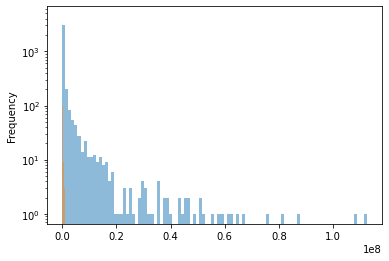

friends_count


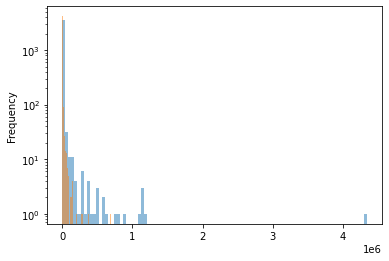

statuses_count


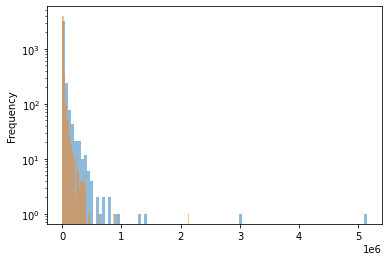

In [8]:
plot_distrib('followers_count')
plot_distrib('friends_count')
plot_distrib('statuses_count')

In [9]:
cmap = matplotlib.colors.ListedColormap(['blue', 'red'])

def plot_scatter(colname_1: str, colname_2: str, **kwargs):
    df_train_users.plot.scatter(colname_1, 
                                colname_2,
                                c='label', 
                                alpha=0.05,
                                cmap=cmap,
                                loglog=True,
                                **kwargs)
    plt.show()

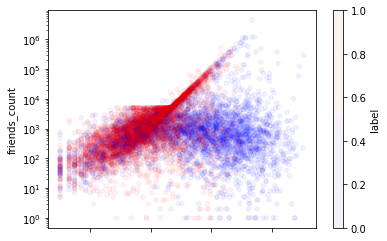

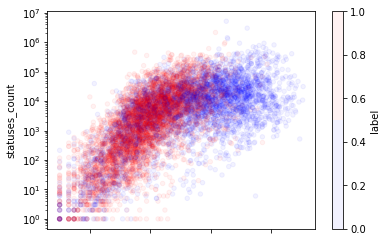

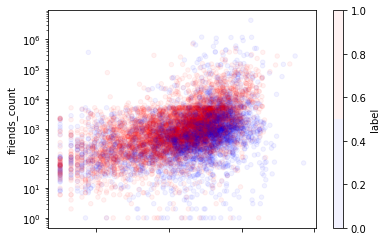

In [10]:
plot_scatter('followers_count', 'friends_count')
plot_scatter('followers_count', 'statuses_count')
plot_scatter('statuses_count', 'friends_count')

## Training

In [11]:
clf_users = get_best_clf(df_train_users)

[I 2022-03-29 15:41:29,651] A new study created in memory with name: no-name-4b48fddc-e7f4-4119-b764-1d6974bd28d4


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:31,287] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 0.6057902581932846, 'lambda_l2': 0.07164131075009829, 'num_leaves': 136, 'feature_fraction': 0.6650215076311421, 'bagging_fraction': 0.6669368643353103, 'bagging_freq': 5, 'learning_rate': 0.009020959358509703, 'min_child_samples': 95}. Best is trial 5 with value: 0.5.
[I 2022-03-29 15:41:31,309] Trial 4 finished with value: 0.7344493905922681 and parameters: {'lambda_l1': 0.8011250805065948, 'lambda_l2': 0.18129585980466456, 'num_leaves': 39, 'feature_fraction': 0.783138361371922, 'bagging_fraction': 0.8486230897111289, 'bagging_freq': 6, 'learning_rate': 0.020589508543380444, 'min_child_samples': 87}. Best is trial 4 with value: 0.7344493905922681.


Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.804345
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.805475
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:31,685] Trial 3 finished with value: 0.7065142353837365 and parameters: {'lambda_l1': 0.016846971157194794, 'lambda_l2': 8.889560455938678e-06, 'num_leaves': 91, 'feature_fraction': 0.866630527180642, 'bagging_fraction': 0.515392600845401, 'bagging_freq': 5, 'learning_rate': 0.006768880157577706, 'min_child_samples': 60}. Best is trial 4 with value: 0.7344493905922681.


Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.804458
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.798895


[I 2022-03-29 15:41:31,902] Trial 6 finished with value: 0.7140306608265092 and parameters: {'lambda_l1': 0.00415458417441686, 'lambda_l2': 1.2244971256417876e-05, 'num_leaves': 55, 'feature_fraction': 0.9929224693365917, 'bagging_fraction': 0.9424067778649289, 'bagging_freq': 6, 'learning_rate': 0.0028032327385985275, 'min_child_samples': 71}. Best is trial 4 with value: 0.7344493905922681.
[I 2022-03-29 15:41:32,112] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 0.025676237749924637, 'lambda_l2': 0.008942637557924975, 'num_leaves': 113, 'feature_fraction': 0.4008020876725284, 'bagging_fraction': 0.449042642206432, 'bagging_freq': 6, 'learning_rate': 1.8366430674802888e-05, 'min_child_samples': 96}. Best is trial 4 with value: 0.7344493905922681.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.781381
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:32,261] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 1.3208459213359784, 'lambda_l2': 0.26037839885232283, 'num_leaves': 227, 'feature_fraction': 0.903040770535906, 'bagging_fraction': 0.4161021221210009, 'bagging_freq': 3, 'learning_rate': 2.6008770341095792e-05, 'min_child_samples': 19}. Best is trial 4 with value: 0.7344493905922681.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.802419
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:32,386] Trial 7 finished with value: 0.7323307465244715 and parameters: {'lambda_l1': 8.712221867745142e-05, 'lambda_l2': 3.663097525000788e-05, 'num_leaves': 211, 'feature_fraction': 0.8355646992215606, 'bagging_fraction': 0.7558585495834405, 'bagging_freq': 2, 'learning_rate': 0.21794599641759405, 'min_child_samples': 62}. Best is trial 4 with value: 0.7344493905922681.


Did not meet early stopping. Best iteration is:
[5]	valid_0's auc: 0.802918
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:32,655] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 1.7915428233012043e-08, 'lambda_l2': 1.9188801245912046e-05, 'num_leaves': 140, 'feature_fraction': 0.5809427382107248, 'bagging_fraction': 0.9999255477939825, 'bagging_freq': 5, 'learning_rate': 2.0674936575946106e-05, 'min_child_samples': 89}. Best is trial 4 with value: 0.7344493905922681.
[I 2022-03-29 15:41:32,704] Trial 10 finished with value: 0.5 and parameters: {'lambda_l1': 4.7640656644053045, 'lambda_l2': 0.38082451396328587, 'num_leaves': 248, 'feature_fraction': 0.6497199990198288, 'bagging_fraction': 0.6409465319218386, 'bagging_freq': 6, 'learning_rate': 0.0002787087682591358, 'min_child_samples': 69}. Best is trial 4 with value: 0.7344493905922681.


Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.797547
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.800096
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:33,022] Trial 0 finished with value: 0.6490132831841554 and parameters: {'lambda_l1': 3.0741908369961734e-07, 'lambda_l2': 0.17594311033639068, 'num_leaves': 251, 'feature_fraction': 0.6789685566986376, 'bagging_fraction': 0.8184378932062797, 'bagging_freq': 6, 'learning_rate': 0.004217542063051105, 'min_child_samples': 44}. Best is trial 4 with value: 0.7344493905922681.


Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.801246
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:33,386] Trial 17 finished with value: 0.7309857646162635 and parameters: {'lambda_l1': 3.436268542322567e-05, 'lambda_l2': 1.7134795643555774e-07, 'num_leaves': 2, 'feature_fraction': 0.8003982324974266, 'bagging_fraction': 0.8740447730464488, 'bagging_freq': 1, 'learning_rate': 0.1437868953917627, 'min_child_samples': 34}. Best is trial 4 with value: 0.7344493905922681.
[I 2022-03-29 15:41:33,528] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 5.602715783346761, 'lambda_l2': 1.249066768128499e-07, 'num_leaves': 14, 'feature_fraction': 0.8130108904853232, 'bagging_fraction': 0.5775255543967607, 'bagging_freq': 5, 'learning_rate': 0.00016151416570421202, 'min_child_samples': 17}. Best is trial 4 with value: 0.7344493905922681.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.800955
Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.798103


[I 2022-03-29 15:41:33,707] Trial 12 finished with value: 0.5389687678537421 and parameters: {'lambda_l1': 1.3305477439469513e-08, 'lambda_l2': 0.002576001389201289, 'num_leaves': 129, 'feature_fraction': 0.47437390039134225, 'bagging_fraction': 0.7829149043019076, 'bagging_freq': 3, 'learning_rate': 0.003120708745732757, 'min_child_samples': 75}. Best is trial 4 with value: 0.7344493905922681.


Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.786285
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:33,941] Trial 11 finished with value: 0.7360145686535899 and parameters: {'lambda_l1': 1.428576574331299, 'lambda_l2': 0.0007847335721265273, 'num_leaves': 104, 'feature_fraction': 0.9843933977989883, 'bagging_fraction': 0.5247792824940236, 'bagging_freq': 1, 'learning_rate': 0.15146950923006178, 'min_child_samples': 52}. Best is trial 11 with value: 0.7360145686535899.
[I 2022-03-29 15:41:33,941] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 0.0031832844133826673, 'lambda_l2': 2.439411815737291, 'num_leaves': 75, 'feature_fraction': 0.7182015600664884, 'bagging_fraction': 0.5418365472273133, 'bagging_freq': 5, 'learning_rate': 1.5482395618756984e-05, 'min_child_samples': 97}. Best is trial 11 with value: 0.7360145686535899.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.799854
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.8002
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:34,768] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 0.13717872279209523, 'lambda_l2': 1.7723824166392906e-07, 'num_leaves': 106, 'feature_fraction': 0.6612014831236717, 'bagging_fraction': 0.9925031037360579, 'bagging_freq': 2, 'learning_rate': 0.00538871302430194, 'min_child_samples': 69}. Best is trial 11 with value: 0.7360145686535899.


Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.802335
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:35,120] Trial 20 finished with value: 0.7367168158446011 and parameters: {'lambda_l1': 3.8158396126669216e-05, 'lambda_l2': 7.133707034451227, 'num_leaves': 187, 'feature_fraction': 0.7597079403252313, 'bagging_fraction': 0.7334667135042858, 'bagging_freq': 1, 'learning_rate': 0.2597694532744087, 'min_child_samples': 80}. Best is trial 20 with value: 0.7367168158446011.


Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.805805
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:35,673] Trial 8 finished with value: 0.6083067510950295 and parameters: {'lambda_l1': 3.9070275753006434e-07, 'lambda_l2': 2.3010688702632875e-08, 'num_leaves': 130, 'feature_fraction': 0.7786274977470248, 'bagging_fraction': 0.4730960262855238, 'bagging_freq': 5, 'learning_rate': 0.0020457548680779918, 'min_child_samples': 19}. Best is trial 20 with value: 0.7367168158446011.


Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.802331
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.802273


[I 2022-03-29 15:41:35,806] Trial 19 finished with value: 0.7338840220910302 and parameters: {'lambda_l1': 1.954670197528374e-05, 'lambda_l2': 0.0018788539202955672, 'num_leaves': 197, 'feature_fraction': 0.7667909879593382, 'bagging_fraction': 0.7790283414628729, 'bagging_freq': 2, 'learning_rate': 0.23913301534859002, 'min_child_samples': 75}. Best is trial 20 with value: 0.7367168158446011.
[I 2022-03-29 15:41:35,956] Trial 18 finished with value: 0.7280696533993526 and parameters: {'lambda_l1': 1.5868787432663383e-05, 'lambda_l2': 0.0011716839231621162, 'num_leaves': 186, 'feature_fraction': 0.7962150569043963, 'bagging_fraction': 0.7834153225272593, 'bagging_freq': 2, 'learning_rate': 0.2675157607345029, 'min_child_samples': 72}. Best is trial 20 with value: 0.7367168158446011.


Training until validation scores don't improve for 100 roundsDid not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.7965

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:37,020] Trial 23 finished with value: 0.7372345743667873 and parameters: {'lambda_l1': 5.4988833227923615e-06, 'lambda_l2': 0.0010973470668519444, 'num_leaves': 48, 'feature_fraction': 0.9974976220131476, 'bagging_fraction': 0.7156259101735585, 'bagging_freq': 7, 'learning_rate': 0.035996592914125665, 'min_child_samples': 48}. Best is trial 23 with value: 0.7372345743667873.


Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.809227
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:37,636] Trial 22 finished with value: 0.7377404303942107 and parameters: {'lambda_l1': 0.20865177787293324, 'lambda_l2': 0.0005892849705346399, 'num_leaves': 176, 'feature_fraction': 0.9983216235645024, 'bagging_fraction': 0.7261928128687137, 'bagging_freq': 7, 'learning_rate': 0.043650777067937546, 'min_child_samples': 44}. Best is trial 22 with value: 0.7377404303942107.


Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.80438
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:37,858] Trial 24 finished with value: 0.7367287183393639 and parameters: {'lambda_l1': 4.733488082618352e-07, 'lambda_l2': 0.000683961099659168, 'num_leaves': 178, 'feature_fraction': 0.9720112372407409, 'bagging_fraction': 0.7012369104458427, 'bagging_freq': 1, 'learning_rate': 0.06768893881613745, 'min_child_samples': 42}. Best is trial 22 with value: 0.7377404303942107.


Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.807343
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:38,069] Trial 26 finished with value: 0.7360145686535899 and parameters: {'lambda_l1': 0.00043198463196822954, 'lambda_l2': 8.160445746013297, 'num_leaves': 160, 'feature_fraction': 0.995308807902549, 'bagging_fraction': 0.6180721639310518, 'bagging_freq': 1, 'learning_rate': 0.038040668486834454, 'min_child_samples': 46}. Best is trial 22 with value: 0.7377404303942107.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.80289


[I 2022-03-29 15:41:38,304] Trial 25 finished with value: 0.7351397352885165 and parameters: {'lambda_l1': 6.007238995697299e-06, 'lambda_l2': 7.757105815131844, 'num_leaves': 163, 'feature_fraction': 0.989178436950564, 'bagging_fraction': 0.7171714163299031, 'bagging_freq': 1, 'learning_rate': 0.05204767578465418, 'min_child_samples': 45}. Best is trial 22 with value: 0.7377404303942107.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.807691


[I 2022-03-29 15:41:38,520] Trial 27 finished with value: 0.7274507236716816 and parameters: {'lambda_l1': 0.0009001065695364467, 'lambda_l2': 4.3930104925520785, 'num_leaves': 168, 'feature_fraction': 0.9560746598548392, 'bagging_fraction': 0.6105623883522713, 'bagging_freq': 1, 'learning_rate': 0.05038341052243125, 'min_child_samples': 40}. Best is trial 22 with value: 0.7377404303942107.


Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.806945
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.802807


[I 2022-03-29 15:41:38,753] Trial 21 finished with value: 0.739341315939821 and parameters: {'lambda_l1': 0.16389439868274613, 'lambda_l2': 0.0008766505315463231, 'num_leaves': 173, 'feature_fraction': 0.988554964726166, 'bagging_fraction': 0.8834646456208244, 'bagging_freq': 7, 'learning_rate': 0.04086381373666998, 'min_child_samples': 41}. Best is trial 21 with value: 0.739341315939821.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:39,336] Trial 28 finished with value: 0.7388116549228718 and parameters: {'lambda_l1': 2.0891993249761673e-06, 'lambda_l2': 7.289645947028197, 'num_leaves': 163, 'feature_fraction': 0.9785729570691342, 'bagging_fraction': 0.612662664208761, 'bagging_freq': 1, 'learning_rate': 0.04874181995354716, 'min_child_samples': 46}. Best is trial 21 with value: 0.739341315939821.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.8026
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:40,435] Trial 14 finished with value: 0.7278077985145687 and parameters: {'lambda_l1': 9.707175266193986e-05, 'lambda_l2': 0.0765281967577866, 'num_leaves': 248, 'feature_fraction': 0.5257048948860097, 'bagging_fraction': 0.6702904070100184, 'bagging_freq': 2, 'learning_rate': 0.018909087616152096, 'min_child_samples': 14}. Best is trial 21 with value: 0.739341315939821.


Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.800105


[I 2022-03-29 15:41:40,581] Trial 29 finished with value: 0.7381094077318606 and parameters: {'lambda_l1': 2.000580757638019e-06, 'lambda_l2': 5.240292593329549, 'num_leaves': 163, 'feature_fraction': 0.923117055979132, 'bagging_fraction': 0.6981647486227353, 'bagging_freq': 7, 'learning_rate': 0.03977077502903669, 'min_child_samples': 38}. Best is trial 21 with value: 0.739341315939821.


Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.805575
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 15:41:40,811] Trial 30 finished with value: 0.7376035517044373 and parameters: {'lambda_l1': 2.039454416285661e-06, 'lambda_l2': 0.00015452220810955943, 'num_leaves': 162, 'feature_fraction': 0.9339746874450927, 'bagging_fraction': 0.6254200881751153, 'bagging_freq': 7, 'learning_rate': 0.04694707323069289, 'min_child_samples': 34}. Best is trial 21 with value: 0.739341315939821.



Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.804771
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:42,139] Trial 31 finished with value: 0.7385021900590364 and parameters: {'lambda_l1': 1.6395372353194686e-06, 'lambda_l2': 0.00012155793124173892, 'num_leaves': 160, 'feature_fraction': 0.9223565912201435, 'bagging_fraction': 0.7017531888822344, 'bagging_freq': 7, 'learning_rate': 0.058973903856063256, 'min_child_samples': 32}. Best is trial 21 with value: 0.739341315939821.
[I 2022-03-29 15:41:42,272] Trial 32 finished with value: 0.7389961435916969 and parameters: {'lambda_l1': 1.5782116741711847e-06, 'lambda_l2': 0.00014318971749258114, 'num_leaves': 168, 'feature_fraction': 0.9235302761657967, 'bagging_fraction': 0.6882183768150254, 'bagging_freq': 7, 'learning_rate': 0.06150980265740258, 'min_child_samples': 33}. Best is trial 21 with value: 0.739341315939821.


Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.806506
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.804917


[I 2022-03-29 15:41:42,563] Trial 33 finished with value: 0.7405851266425443 and parameters: {'lambda_l1': 1.4070287797099963e-06, 'lambda_l2': 0.00011176893088790671, 'num_leaves': 219, 'feature_fraction': 0.9212075228148867, 'bagging_fraction': 0.6861218578506564, 'bagging_freq': 7, 'learning_rate': 0.018575865716547225, 'min_child_samples': 31}. Best is trial 33 with value: 0.7405851266425443.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.808687
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:43,643] Trial 34 finished with value: 0.7372345743667873 and parameters: {'lambda_l1': 0.11483543666134978, 'lambda_l2': 0.011621026810865272, 'num_leaves': 214, 'feature_fraction': 0.9159044059875888, 'bagging_fraction': 0.9044389133775687, 'bagging_freq': 7, 'learning_rate': 0.019627213449644774, 'min_child_samples': 31}. Best is trial 33 with value: 0.7405851266425443.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.803112


[I 2022-03-29 15:41:44,044] Trial 35 finished with value: 0.7348421729194439 and parameters: {'lambda_l1': 0.02063532440239106, 'lambda_l2': 0.00018846543715440395, 'num_leaves': 212, 'feature_fraction': 0.9141629645556428, 'bagging_fraction': 0.9089521430185762, 'bagging_freq': 7, 'learning_rate': 0.014741741063640248, 'min_child_samples': 32}. Best is trial 33 with value: 0.7405851266425443.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.797196


[I 2022-03-29 15:41:44,437] Trial 38 finished with value: 0.7384902875642735 and parameters: {'lambda_l1': 5.937347267982461e-08, 'lambda_l2': 0.9658202304091024, 'num_leaves': 208, 'feature_fraction': 0.9068280295768762, 'bagging_fraction': 0.9022834955168635, 'bagging_freq': 7, 'learning_rate': 0.013306255435202972, 'min_child_samples': 30}. Best is trial 33 with value: 0.7405851266425443.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.801675
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.805675


[I 2022-03-29 15:41:44,878] Trial 37 finished with value: 0.5 and parameters: {'lambda_l1': 6.453771591843124e-08, 'lambda_l2': 1.375902539588416, 'num_leaves': 152, 'feature_fraction': 0.9216126447314584, 'bagging_fraction': 0.9227618863805964, 'bagging_freq': 7, 'learning_rate': 0.0006254374896536343, 'min_child_samples': 27}. Best is trial 33 with value: 0.7405851266425443.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:45,982] Trial 36 finished with value: 0.5 and parameters: {'lambda_l1': 0.13689082946943848, 'lambda_l2': 0.0001714495718908878, 'num_leaves': 210, 'feature_fraction': 0.8741602067749615, 'bagging_fraction': 0.9019759268328873, 'bagging_freq': 7, 'learning_rate': 0.0009061236863439819, 'min_child_samples': 28}. Best is trial 33 with value: 0.7405851266425443.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.800556
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:46,466] Trial 41 finished with value: 0.731664206817749 and parameters: {'lambda_l1': 5.214318640906767e-08, 'lambda_l2': 2.695178674739266e-06, 'num_leaves': 219, 'feature_fraction': 0.8771832654440962, 'bagging_fraction': 0.5805018026331682, 'bagging_freq': 4, 'learning_rate': 0.01660239102757328, 'min_child_samples': 27}. Best is trial 33 with value: 0.7405851266425443.


Did not meet early stopping. Best iteration is:
[46]	valid_0's auc: 0.805068
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.802279


[I 2022-03-29 15:41:46,633] Trial 39 finished with value: 0.7344374880975052 and parameters: {'lambda_l1': 5.344773909524034e-08, 'lambda_l2': 1.315876632485565, 'num_leaves': 151, 'feature_fraction': 0.8928776236539249, 'bagging_fraction': 0.9056342602545139, 'bagging_freq': 7, 'learning_rate': 0.014174437016121096, 'min_child_samples': 31}. Best is trial 33 with value: 0.7405851266425443.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:47,665] Trial 42 finished with value: 0.5 and parameters: {'lambda_l1': 5.025522359391522e-08, 'lambda_l2': 2.3168658556247737e-06, 'num_leaves': 233, 'feature_fraction': 0.8580118613613889, 'bagging_fraction': 0.5792536592553335, 'bagging_freq': 4, 'learning_rate': 0.0009206269792851108, 'min_child_samples': 27}. Best is trial 33 with value: 0.7405851266425443.


Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.8059
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.803354
Did not meet early stopping. Best iteration is:
[55]	valid_0's auc: 0.804905


[I 2022-03-29 15:41:47,851] Trial 40 finished with value: 0.7360264711483526 and parameters: {'lambda_l1': 5.417342407179391e-08, 'lambda_l2': 2.164620111818448e-06, 'num_leaves': 150, 'feature_fraction': 0.8759539969190676, 'bagging_fraction': 0.9050781848453326, 'bagging_freq': 7, 'learning_rate': 0.013740551853756116, 'min_child_samples': 24}. Best is trial 33 with value: 0.7405851266425443.
[I 2022-03-29 15:41:47,951] Trial 45 finished with value: 0.7254153970672252 and parameters: {'lambda_l1': 1.2439176216224027e-07, 'lambda_l2': 2.2990878604420027e-06, 'num_leaves': 228, 'feature_fraction': 0.8787073111053255, 'bagging_fraction': 0.8344012601771766, 'bagging_freq': 4, 'learning_rate': 0.007635142784408627, 'min_child_samples': 56}. Best is trial 33 with value: 0.7405851266425443.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:48,909] Trial 46 finished with value: 0.739156827270996 and parameters: {'lambda_l1': 6.043116049136394e-08, 'lambda_l2': 3.899528200650368e-05, 'num_leaves': 229, 'feature_fraction': 0.8588349394710891, 'bagging_fraction': 0.8239340817595243, 'bagging_freq': 4, 'learning_rate': 0.09825920475568428, 'min_child_samples': 59}. Best is trial 33 with value: 0.7405851266425443.


Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.806921
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:49,308] Trial 44 finished with value: 0.736347838506951 and parameters: {'lambda_l1': 4.742782940784892e-08, 'lambda_l2': 3.3735771396802394e-06, 'num_leaves': 234, 'feature_fraction': 0.8720788077204618, 'bagging_fraction': 0.8175401347963299, 'bagging_freq': 4, 'learning_rate': 0.10169271616852987, 'min_child_samples': 24}. Best is trial 33 with value: 0.7405851266425443.


Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.801951


[I 2022-03-29 15:41:49,518] Trial 48 finished with value: 0.7396626832984193 and parameters: {'lambda_l1': 8.945947330460616e-07, 'lambda_l2': 4.286111969405389e-05, 'num_leaves': 137, 'feature_fraction': 0.9570217620401825, 'bagging_fraction': 0.8145416283382387, 'bagging_freq': 6, 'learning_rate': 0.11942730481210899, 'min_child_samples': 56}. Best is trial 33 with value: 0.7405851266425443.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.802681
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:50,326] Trial 49 finished with value: 0.741596838697391 and parameters: {'lambda_l1': 1.4314666029011176e-06, 'lambda_l2': 5.395069641407396e-05, 'num_leaves': 145, 'feature_fraction': 0.9584893872333482, 'bagging_fraction': 0.8265365043129114, 'bagging_freq': 7, 'learning_rate': 0.12278241364862853, 'min_child_samples': 57}. Best is trial 49 with value: 0.741596838697391.


Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.803896
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:51,198] Trial 52 finished with value: 0.739513902113883 and parameters: {'lambda_l1': 4.973683682087552e-07, 'lambda_l2': 3.415273497160184e-05, 'num_leaves': 197, 'feature_fraction': 0.9477779930488021, 'bagging_fraction': 0.6573988976838798, 'bagging_freq': 6, 'learning_rate': 0.10655523540976165, 'min_child_samples': 52}. Best is trial 49 with value: 0.741596838697391.


Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.804817
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:51,860] Trial 43 finished with value: 0.5 and parameters: {'lambda_l1': 4.442763501348479e-08, 'lambda_l2': 2.178164782848211e-06, 'num_leaves': 228, 'feature_fraction': 0.8751674244511152, 'bagging_fraction': 0.5641535985051372, 'bagging_freq': 4, 'learning_rate': 0.0009458870824094041, 'min_child_samples': 6}. Best is trial 49 with value: 0.741596838697391.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.802825
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:52,606] Trial 50 finished with value: 0.736347838506951 and parameters: {'lambda_l1': 8.431047570195669e-07, 'lambda_l2': 4.753886143688281e-05, 'num_leaves': 122, 'feature_fraction': 0.9420910194019227, 'bagging_fraction': 0.8142644625720966, 'bagging_freq': 6, 'learning_rate': 0.09250203150769935, 'min_child_samples': 21}. Best is trial 49 with value: 0.741596838697391.


Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.801321
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:52,892] Trial 53 finished with value: 0.7266651590173301 and parameters: {'lambda_l1': 6.267685091321814e-07, 'lambda_l2': 3.6050573676270505e-05, 'num_leaves': 195, 'feature_fraction': 0.8381955122495984, 'bagging_fraction': 0.9572738028689085, 'bagging_freq': 6, 'learning_rate': 0.0965804915944205, 'min_child_samples': 9}. Best is trial 49 with value: 0.741596838697391.


Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.784833
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:53,386] Trial 55 finished with value: 0.7340685107598552 and parameters: {'lambda_l1': 5.582938103501451e-07, 'lambda_l2': 3.94554360199676e-05, 'num_leaves': 117, 'feature_fraction': 0.9584865581241219, 'bagging_fraction': 0.8473719287682093, 'bagging_freq': 6, 'learning_rate': 0.10540206063235671, 'min_child_samples': 63}. Best is trial 49 with value: 0.741596838697391.


Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.799927
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:54,132] Trial 59 finished with value: 0.7367168158446011 and parameters: {'lambda_l1': 2.055384585763246e-07, 'lambda_l2': 9.342382660970591e-06, 'num_leaves': 139, 'feature_fraction': 0.9588095088239861, 'bagging_fraction': 0.752415141978625, 'bagging_freq': 5, 'learning_rate': 0.027275890044136133, 'min_child_samples': 65}. Best is trial 49 with value: 0.741596838697391.


Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.804836
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:55,436] Trial 58 finished with value: 0.7326521138830698 and parameters: {'lambda_l1': 1.9635173811821352e-07, 'lambda_l2': 4.130460381538242e-05, 'num_leaves': 192, 'feature_fraction': 0.9584559059366788, 'bagging_fraction': 0.7555032752712652, 'bagging_freq': 6, 'learning_rate': 0.14526082541541788, 'min_child_samples': 63}. Best is trial 49 with value: 0.741596838697391.


Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.801819
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:55,951] Trial 47 finished with value: 0.7288492668063226 and parameters: {'lambda_l1': 7.960852941058165e-07, 'lambda_l2': 2.9974691275786485e-05, 'num_leaves': 232, 'feature_fraction': 0.8471362179129841, 'bagging_fraction': 0.8182162277620127, 'bagging_freq': 4, 'learning_rate': 0.11409353911465989, 'min_child_samples': 8}. Best is trial 49 with value: 0.741596838697391.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.784467


[I 2022-03-29 15:41:56,224] Trial 61 finished with value: 0.7360026661588269 and parameters: {'lambda_l1': 1.2262652333295848e-08, 'lambda_l2': 1.7313811745227068e-05, 'num_leaves': 256, 'feature_fraction': 0.8335763619305661, 'bagging_fraction': 0.8691109205112492, 'bagging_freq': 3, 'learning_rate': 0.14123248435151053, 'min_child_samples': 57}. Best is trial 49 with value: 0.741596838697391.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.800929


[I 2022-03-29 15:41:56,375] Trial 57 finished with value: 0.7400435631308322 and parameters: {'lambda_l1': 7.00842064659463e-07, 'lambda_l2': 4.6703947747137744e-05, 'num_leaves': 117, 'feature_fraction': 0.9563171159775669, 'bagging_fraction': 0.973078484997473, 'bagging_freq': 6, 'learning_rate': 0.13831146411870027, 'min_child_samples': 51}. Best is trial 49 with value: 0.741596838697391.
[I 2022-03-29 15:41:56,484] Trial 51 finished with value: 0.7271472100552275 and parameters: {'lambda_l1': 6.774235067097453e-07, 'lambda_l2': 8.449542609319131e-05, 'num_leaves': 193, 'feature_fraction': 0.946637779063836, 'bagging_fraction': 0.670659720809193, 'bagging_freq': 6, 'learning_rate': 0.09427967667069265, 'min_child_samples': 5}. Best is trial 49 with value: 0.741596838697391.


Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.801172
Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.783747
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.810512


[I 2022-03-29 15:41:56,694] Trial 60 finished with value: 0.7409422014854314 and parameters: {'lambda_l1': 1.7372600668488297e-07, 'lambda_l2': 1.632910672297799e-05, 'num_leaves': 254, 'feature_fraction': 0.9494936019805196, 'bagging_fraction': 0.7639213716218076, 'bagging_freq': 5, 'learning_rate': 0.029289544542185603, 'min_child_samples': 52}. Best is trial 49 with value: 0.741596838697391.
[I 2022-03-29 15:41:56,866] Trial 54 finished with value: 0.7285993144163015 and parameters: {'lambda_l1': 2.420635513124649e-07, 'lambda_l2': 2.3981891303538367e-05, 'num_leaves': 136, 'feature_fraction': 0.9529326816414537, 'bagging_fraction': 0.8631574601880433, 'bagging_freq': 6, 'learning_rate': 0.09868203002950066, 'min_child_samples': 5}. Best is trial 49 with value: 0.741596838697391.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.781586
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:57,258] Trial 56 finished with value: 0.7245346124547705 and parameters: {'lambda_l1': 5.027437770536363e-07, 'lambda_l2': 2.6699596406668036e-05, 'num_leaves': 119, 'feature_fraction': 0.9546103336116453, 'bagging_fraction': 0.9710495059078434, 'bagging_freq': 6, 'learning_rate': 0.13878990575521438, 'min_child_samples': 7}. Best is trial 49 with value: 0.741596838697391.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.791818
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:41:58,541] Trial 62 finished with value: 0.7389961435916969 and parameters: {'lambda_l1': 1.8079613281502036e-08, 'lambda_l2': 0.008834844464514062, 'num_leaves': 239, 'feature_fraction': 0.5862995983429447, 'bagging_fraction': 0.8636576713791602, 'bagging_freq': 6, 'learning_rate': 0.1816857291708365, 'min_child_samples': 54}. Best is trial 49 with value: 0.741596838697391.


Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.797472


[I 2022-03-29 15:41:58,836] Trial 64 finished with value: 0.7411028851647306 and parameters: {'lambda_l1': 3.81634549026444e-06, 'lambda_l2': 5.595965069566557e-06, 'num_leaves': 203, 'feature_fraction': 0.7186042241798425, 'bagging_fraction': 0.7947302606664306, 'bagging_freq': 5, 'learning_rate': 0.18994527936225283, 'min_child_samples': 51}. Best is trial 49 with value: 0.741596838697391.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.798423


[I 2022-03-29 15:41:59,018] Trial 65 finished with value: 0.7409064940011427 and parameters: {'lambda_l1': 6.180280495591064e-06, 'lambda_l2': 0.006638829342517876, 'num_leaves': 99, 'feature_fraction': 0.5577877921574508, 'bagging_fraction': 0.6500719688391144, 'bagging_freq': 6, 'learning_rate': 0.19625223852182985, 'min_child_samples': 51}. Best is trial 49 with value: 0.741596838697391.
[I 2022-03-29 15:41:59,180] Trial 63 finished with value: 0.7386509712435727 and parameters: {'lambda_l1': 0.00013954607176267474, 'lambda_l2': 0.007952319762473993, 'num_leaves': 249, 'feature_fraction': 0.63026413666412, 'bagging_fraction': 0.8705290912570725, 'bagging_freq': 3, 'learning_rate': 0.19846401884439224, 'min_child_samples': 56}. Best is trial 49 with value: 0.741596838697391.


Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.799018
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.798231


[I 2022-03-29 15:41:59,347] Trial 67 finished with value: 0.7380856027423348 and parameters: {'lambda_l1': 6.688725516991523e-06, 'lambda_l2': 5.130497532997484e-07, 'num_leaves': 89, 'feature_fraction': 0.6168738275003562, 'bagging_fraction': 0.6552851668127646, 'bagging_freq': 5, 'learning_rate': 0.17308908503005394, 'min_child_samples': 52}. Best is trial 49 with value: 0.741596838697391.


Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.801423
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:00,238] Trial 69 finished with value: 0.7367168158446011 and parameters: {'lambda_l1': 4.9579093896310655e-06, 'lambda_l2': 0.00040846564864360215, 'num_leaves': 92, 'feature_fraction': 0.6392588361595196, 'bagging_fraction': 0.7789112667781874, 'bagging_freq': 5, 'learning_rate': 0.030316271727619085, 'min_child_samples': 53}. Best is trial 49 with value: 0.741596838697391.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.806034
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.796487
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.796042


[I 2022-03-29 15:42:00,391] Trial 66 finished with value: 0.7373714530565607 and parameters: {'lambda_l1': 6.362365685419426e-06, 'lambda_l2': 0.0003262330763146015, 'num_leaves': 97, 'feature_fraction': 0.7037596795929192, 'bagging_fraction': 0.9981388485339594, 'bagging_freq': 6, 'learning_rate': 0.20217840804287315, 'min_child_samples': 50}. Best is trial 49 with value: 0.741596838697391.
[I 2022-03-29 15:42:00,463] Trial 68 finished with value: 0.727022233860217 and parameters: {'lambda_l1': 3.2446624126750116e-06, 'lambda_l2': 0.00038108104916911037, 'num_leaves': 94, 'feature_fraction': 0.5893515416483103, 'bagging_fraction': 0.9799244289013926, 'bagging_freq': 5, 'learning_rate': 0.17567113760516134, 'min_child_samples': 51}. Best is trial 49 with value: 0.741596838697391.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:01,387] Trial 71 finished with value: 0.7430251380689392 and parameters: {'lambda_l1': 6.8102256812054935e-06, 'lambda_l2': 5.1265276104532735e-06, 'num_leaves': 98, 'feature_fraction': 0.7345549864198162, 'bagging_fraction': 0.7877081124845937, 'bagging_freq': 5, 'learning_rate': 0.07233035602159928, 'min_child_samples': 51}. Best is trial 71 with value: 0.7430251380689392.


Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.809823


[I 2022-03-29 15:42:01,646] Trial 70 finished with value: 0.739341315939821 and parameters: {'lambda_l1': 5.742534272271258e-06, 'lambda_l2': 5.934446834686952e-06, 'num_leaves': 89, 'feature_fraction': 0.9762231216336898, 'bagging_fraction': 0.7730162295312399, 'bagging_freq': 5, 'learning_rate': 0.030913671101910626, 'min_child_samples': 50}. Best is trial 71 with value: 0.7430251380689392.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.80919


[I 2022-03-29 15:42:02,016] Trial 72 finished with value: 0.7279625309464863 and parameters: {'lambda_l1': 4.317394845889272e-06, 'lambda_l2': 9.516122098281487e-06, 'num_leaves': 90, 'feature_fraction': 0.5984540994318099, 'bagging_fraction': 0.7456359585612419, 'bagging_freq': 5, 'learning_rate': 0.2835971192284768, 'min_child_samples': 50}. Best is trial 71 with value: 0.7430251380689392.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.790992


[I 2022-03-29 15:42:02,363] Trial 73 finished with value: 0.7433465054275377 and parameters: {'lambda_l1': 6.176143365418139e-06, 'lambda_l2': 6.731915962702064e-06, 'num_leaves': 80, 'feature_fraction': 0.5191858955147365, 'bagging_fraction': 0.783462890017399, 'bagging_freq': 5, 'learning_rate': 0.28003478909403007, 'min_child_samples': 49}. Best is trial 73 with value: 0.7433465054275377.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.798663


[I 2022-03-29 15:42:02,607] Trial 74 finished with value: 0.735252808988764 and parameters: {'lambda_l1': 4.231447801127264e-06, 'lambda_l2': 1.0078223308222928e-06, 'num_leaves': 96, 'feature_fraction': 0.6942174009692417, 'bagging_fraction': 0.800101234629832, 'bagging_freq': 5, 'learning_rate': 0.2951590233678507, 'min_child_samples': 49}. Best is trial 73 with value: 0.7433465054275377.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.793539
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.795837


[I 2022-03-29 15:42:03,008] Trial 77 finished with value: 0.7440487526185487 and parameters: {'lambda_l1': 1.48468807281496e-05, 'lambda_l2': 6.730929364191257e-06, 'num_leaves': 72, 'feature_fraction': 0.5115870238112836, 'bagging_fraction': 0.7916797417248561, 'bagging_freq': 5, 'learning_rate': 0.2968042055943547, 'min_child_samples': 67}. Best is trial 77 with value: 0.7440487526185487.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:03,435] Trial 75 finished with value: 0.7368298895448485 and parameters: {'lambda_l1': 1.2388250668405231e-05, 'lambda_l2': 7.835895582569063e-07, 'num_leaves': 75, 'feature_fraction': 0.6973825100252532, 'bagging_fraction': 0.7982918067803819, 'bagging_freq': 5, 'learning_rate': 0.28432014939276473, 'min_child_samples': 49}. Best is trial 77 with value: 0.7440487526185487.


Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.795471
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:03,900] Trial 79 finished with value: 0.5 and parameters: {'lambda_l1': 1.9843588763687726e-05, 'lambda_l2': 7.514535059611513e-06, 'num_leaves': 111, 'feature_fraction': 0.5000169029593151, 'bagging_fraction': 0.7877961617120096, 'bagging_freq': 5, 'learning_rate': 6.948808397576343e-05, 'min_child_samples': 68}. Best is trial 77 with value: 0.7440487526185487.
[I 2022-03-29 15:42:03,980] Trial 78 finished with value: 0.741043372690916 and parameters: {'lambda_l1': 1.3163215503583338e-05, 'lambda_l2': 8.555856476306327e-07, 'num_leaves': 80, 'feature_fraction': 0.517127324414891, 'bagging_fraction': 0.7883509714303708, 'bagging_freq': 5, 'learning_rate': 0.2793513873282919, 'min_child_samples': 48}. Best is trial 77 with value: 0.7440487526185487.


Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.797858
Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.800172


[I 2022-03-29 15:42:04,324] Trial 76 finished with value: 0.6158231765378024 and parameters: {'lambda_l1': 3.2343101791222814e-06, 'lambda_l2': 7.456160903566782e-06, 'num_leaves': 111, 'feature_fraction': 0.4914501316581036, 'bagging_fraction': 0.7975543314352728, 'bagging_freq': 5, 'learning_rate': 0.004212032825483431, 'min_child_samples': 38}. Best is trial 77 with value: 0.7440487526185487.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.787198
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:04,916] Trial 80 finished with value: 0.5 and parameters: {'lambda_l1': 1.5087965819716607e-05, 'lambda_l2': 1.1331176368848915e-06, 'num_leaves': 72, 'feature_fraction': 0.5415431120187126, 'bagging_fraction': 0.7973646816304674, 'bagging_freq': 5, 'learning_rate': 9.29769566424602e-05, 'min_child_samples': 37}. Best is trial 77 with value: 0.7440487526185487.


Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.795948


[I 2022-03-29 15:42:05,219] Trial 83 finished with value: 0.7314083031803466 and parameters: {'lambda_l1': 1.3040382378697936e-05, 'lambda_l2': 8.980136137205717e-07, 'num_leaves': 72, 'feature_fraction': 0.5333012343753589, 'bagging_fraction': 0.7335891600861532, 'bagging_freq': 5, 'learning_rate': 0.21545832918104124, 'min_child_samples': 67}. Best is trial 77 with value: 0.7440487526185487.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.79896
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.805259


[I 2022-03-29 15:42:05,376] Trial 81 finished with value: 0.745316368310798 and parameters: {'lambda_l1': 1.4559576552775324e-05, 'lambda_l2': 8.502940315786032e-07, 'num_leaves': 70, 'feature_fraction': 0.5404727501676754, 'bagging_fraction': 0.7877132905889186, 'bagging_freq': 5, 'learning_rate': 0.0680900507799394, 'min_child_samples': 38}. Best is trial 81 with value: 0.745316368310798.
[I 2022-03-29 15:42:05,599] Trial 82 finished with value: 0.7433584079223006 and parameters: {'lambda_l1': 1.2466054171466192e-05, 'lambda_l2': 8.841291441415095e-07, 'num_leaves': 72, 'feature_fraction': 0.5190279959548625, 'bagging_fraction': 0.788356501113203, 'bagging_freq': 5, 'learning_rate': 0.06356665555852588, 'min_child_samples': 39}. Best is trial 81 with value: 0.745316368310798.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.801532
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:05,803] Trial 84 finished with value: 0.7382938964006857 and parameters: {'lambda_l1': 3.110764564046136e-05, 'lambda_l2': 4.436253458319429e-06, 'num_leaves': 71, 'feature_fraction': 0.5452278655822348, 'bagging_fraction': 0.7373491867710512, 'bagging_freq': 5, 'learning_rate': 0.07189348263022054, 'min_child_samples': 69}. Best is trial 81 with value: 0.745316368310798.


Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.803201
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:06,424] Trial 85 finished with value: 0.7367168158446011 and parameters: {'lambda_l1': 4.317179301740998e-05, 'lambda_l2': 5.497475677252199e-06, 'num_leaves': 75, 'feature_fraction': 0.5575101671181927, 'bagging_fraction': 0.6860754107937482, 'bagging_freq': 5, 'learning_rate': 0.07086513593284885, 'min_child_samples': 60}. Best is trial 81 with value: 0.745316368310798.


Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.806382


[I 2022-03-29 15:42:06,694] Trial 86 finished with value: 0.7404006379737194 and parameters: {'lambda_l1': 3.798048363245262e-05, 'lambda_l2': 6.738836769266068e-08, 'num_leaves': 73, 'feature_fraction': 0.5626286646603659, 'bagging_fraction': 0.8436662739222694, 'bagging_freq': 5, 'learning_rate': 0.06749888675464388, 'min_child_samples': 38}. Best is trial 81 with value: 0.745316368310798.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.80733


[I 2022-03-29 15:42:06,921] Trial 87 finished with value: 0.7331698724052561 and parameters: {'lambda_l1': 7.26829665802758e-05, 'lambda_l2': 3.494664035101483e-08, 'num_leaves': 72, 'feature_fraction': 0.5527699423788601, 'bagging_fraction': 0.7306008784005941, 'bagging_freq': 5, 'learning_rate': 0.07026847351000345, 'min_child_samples': 60}. Best is trial 81 with value: 0.745316368310798.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.804964
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:07,393] Trial 88 finished with value: 0.7319260617025329 and parameters: {'lambda_l1': 3.756822385503967e-05, 'lambda_l2': 7.887889572238915e-08, 'num_leaves': 70, 'feature_fraction': 0.4453134788874316, 'bagging_fraction': 0.7317308734820472, 'bagging_freq': 5, 'learning_rate': 0.07207219951013155, 'min_child_samples': 60}. Best is trial 81 with value: 0.745316368310798.


Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.79567


[I 2022-03-29 15:42:07,746] Trial 90 finished with value: 0.7349195391354028 and parameters: {'lambda_l1': 5.043848962743101e-05, 'lambda_l2': 7.788193654865068e-08, 'num_leaves': 51, 'feature_fraction': 0.43807840887491145, 'bagging_fraction': 0.7708575816242013, 'bagging_freq': 5, 'learning_rate': 0.07376070893951851, 'min_child_samples': 43}. Best is trial 81 with value: 0.745316368310798.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.795482


[I 2022-03-29 15:42:08,080] Trial 89 finished with value: 0.7396983907827082 and parameters: {'lambda_l1': 3.64851526588877e-05, 'lambda_l2': 7.956804035790506e-08, 'num_leaves': 60, 'feature_fraction': 0.7444583714930793, 'bagging_fraction': 0.8422602172548148, 'bagging_freq': 5, 'learning_rate': 0.06660099644632662, 'min_child_samples': 43}. Best is trial 81 with value: 0.745316368310798.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's auc: 0.805641
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.793722


[I 2022-03-29 15:42:08,214] Trial 91 finished with value: 0.7296110264711484 and parameters: {'lambda_l1': 4.891620143408546e-05, 'lambda_l2': 7.577220209628105e-08, 'num_leaves': 55, 'feature_fraction': 0.4345282456564947, 'bagging_fraction': 0.7680063045514371, 'bagging_freq': 5, 'learning_rate': 0.07195544975527478, 'min_child_samples': 42}. Best is trial 81 with value: 0.745316368310798.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:08,692] Trial 92 finished with value: 0.728033945915064 and parameters: {'lambda_l1': 6.10636326200283e-05, 'lambda_l2': 5.079623667045548e-08, 'num_leaves': 62, 'feature_fraction': 0.46954241876553515, 'bagging_fraction': 0.7623278755888371, 'bagging_freq': 5, 'learning_rate': 0.07363285760642233, 'min_child_samples': 43}. Best is trial 81 with value: 0.745316368310798.
[I 2022-03-29 15:42:08,763] Trial 93 finished with value: 0.7324438202247191 and parameters: {'lambda_l1': 6.814683867873508e-05, 'lambda_l2': 8.408114553834858e-08, 'num_leaves': 51, 'feature_fraction': 0.4309295863926843, 'bagging_fraction': 0.7644659135950698, 'bagging_freq': 4, 'learning_rate': 0.07367941666556711, 'min_child_samples': 41}. Best is trial 81 with value: 0.745316368310798.
[I 2022-03-29 15:42:08,773] Trial 94 finished with value: 0.7004915730337078 and parameters: {'lambda_l1': 0.00023627317179839293, 'lambda_l2': 2.9165781205794797e-07, 'num_leaves': 55, 'feature_fraction': 0.416

Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.793554
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.796098
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.789466


[I 2022-03-29 15:42:09,267] Trial 95 finished with value: 0.7258617406208341 and parameters: {'lambda_l1': 0.0004182951688900287, 'lambda_l2': 3.31365075769805e-07, 'num_leaves': 57, 'feature_fraction': 0.431607310617745, 'bagging_fraction': 0.7711063925588708, 'bagging_freq': 4, 'learning_rate': 0.024749424761319555, 'min_child_samples': 41}. Best is trial 81 with value: 0.745316368310798.


Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.791696


[I 2022-03-29 15:42:09,515] Trial 98 finished with value: 0.7357586650161874 and parameters: {'lambda_l1': 0.0001816658012166564, 'lambda_l2': 3.814737173908926e-07, 'num_leaves': 40, 'feature_fraction': 0.5164519886952418, 'bagging_fraction': 0.7580412390755243, 'bagging_freq': 4, 'learning_rate': 0.22971262450137056, 'min_child_samples': 82}. Best is trial 81 with value: 0.745316368310798.
[I 2022-03-29 15:42:09,536] Trial 96 finished with value: 0.742138402209103 and parameters: {'lambda_l1': 8.195141447155468e-05, 'lambda_l2': 2.1464564755998192e-07, 'num_leaves': 61, 'feature_fraction': 0.7333139286538221, 'bagging_fraction': 0.7647570763630644, 'bagging_freq': 4, 'learning_rate': 0.23650602492460882, 'min_child_samples': 42}. Best is trial 81 with value: 0.745316368310798.
[I 2022-03-29 15:42:09,676] Trial 97 finished with value: 0.7380975052370977 and parameters: {'lambda_l1': 0.00018856225983703733, 'lambda_l2': 2.833505416089954e-07, 'num_leaves': 61, 'feature_fraction': 0.754

Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.799921
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.797951
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.799848


[I 2022-03-29 15:42:09,950] Trial 99 finished with value: 0.7297955151399733 and parameters: {'lambda_l1': 0.00017878061504715274, 'lambda_l2': 4.901582194706965e-07, 'num_leaves': 83, 'feature_fraction': 0.5054477691075848, 'bagging_fraction': 0.8298429229980933, 'bagging_freq': 4, 'learning_rate': 0.22935532894698896, 'min_child_samples': 47}. Best is trial 81 with value: 0.745316368310798.


Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.797838
{'lambda_l1': 1.4559576552775324e-05, 'lambda_l2': 8.502940315786032e-07, 'num_leaves': 70, 'feature_fraction': 0.5404727501676754, 'bagging_fraction': 0.7877132905889186, 'bagging_freq': 5, 'learning_rate': 0.0680900507799394, 'min_child_samples': 38} -> 0.745316368310798
[LightGBM] [Warning] feature_fraction is set=0.5404727501676754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5404727501676754
[LightGBM] [Warning] lambda_l1 is set=1.4559576552775324e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4559576552775324e-05
[LightGBM] [Warning] bagging_fraction is set=0.7877132905889186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7877132905889186
[LightGBM] [Warning] lambda_l2 is set=8.502940315786032e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.502940315786032e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will b

AUROC: 0.7418134208103131
Accuracy: 0.7540152155536771


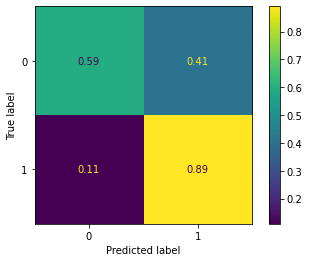

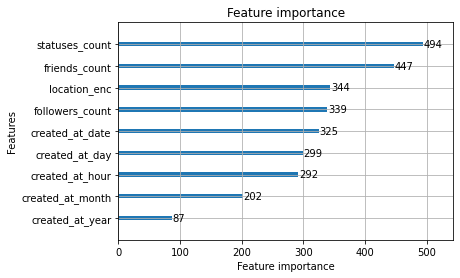

In [12]:
eval_clf(clf_users, df_test_users)

## Feature engineering

In [13]:
def add_avg(df: pd.DataFrame):
    df['avg_daily_followers'] = np.round(df['followers_count'] / df['created_at_date'], 3)
    df['avg_daily_friends'] = np.round(df['friends_count'] / df['created_at_date'], 3)
    df['avg_daily_statuses'] = np.round(df['statuses_count'] / df['created_at_date'], 3)
    return df

df_train_users_fe = add_avg(df_train_users)
df_test_users_fe = add_avg(df_test_users)

In [14]:
clf_users_fe = get_best_clf(df_train_users_fe)

[I 2022-03-29 15:42:11,423] A new study created in memory with name: no-name-29f85117-6b05-4ece-a8c0-ad71dabf5a0c


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds



[I 2022-03-29 15:42:12,460] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 2.375686929017432, 'lambda_l2': 2.2910605679588942e-08, 'num_leaves': 17, 'feature_fraction': 0.44435595813650564, 'bagging_fraction': 0.9897437315297072, 'bagging_freq': 6, 'learning_rate': 0.000942966861501681, 'min_child_samples': 84}. Best is trial 0 with value: 0.5.


Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.79403
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:12,903] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 0.00012818071323503346, 'lambda_l2': 3.70639828457995e-06, 'num_leaves': 218, 'feature_fraction': 0.7599201282271448, 'bagging_fraction': 0.5361706130962238, 'bagging_freq': 4, 'learning_rate': 0.00012253833074608506, 'min_child_samples': 84}. Best is trial 0 with value: 0.5.


Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.801508
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:13,510] Trial 3 finished with value: 0.7368417920396115 and parameters: {'lambda_l1': 0.000769280918784229, 'lambda_l2': 2.3737132738588594e-05, 'num_leaves': 46, 'feature_fraction': 0.47298608209256376, 'bagging_fraction': 0.9511003221721517, 'bagging_freq': 3, 'learning_rate': 0.28996407022204007, 'min_child_samples': 67}. Best is trial 3 with value: 0.7368417920396115.
[I 2022-03-29 15:42:13,621] Trial 4 finished with value: 0.633403161302609 and parameters: {'lambda_l1': 0.3051987072227101, 'lambda_l2': 7.931173848481596e-06, 'num_leaves': 47, 'feature_fraction': 0.7414253845866818, 'bagging_fraction': 0.43008728070220437, 'bagging_freq': 5, 'learning_rate': 0.003241733586493132, 'min_child_samples': 12}. Best is trial 3 with value: 0.7368417920396115.
[I 2022-03-29 15:42:13,658] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 5.43340285492858e-08, 'lambda_l2': 0.6842082042994146, 'num_leaves': 79, 'feature_fraction': 0.8732964241740995, 'bagging_

Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.801356
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.804563
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.804439
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:13,799] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 7.79254559267389e-07, 'lambda_l2': 5.578465344477976e-07, 'num_leaves': 63, 'feature_fraction': 0.709167748177354, 'bagging_fraction': 0.4660549988004481, 'bagging_freq': 1, 'learning_rate': 0.0003528821625026789, 'min_child_samples': 51}. Best is trial 3 with value: 0.7368417920396115.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.804853


[I 2022-03-29 15:42:14,035] Trial 9 finished with value: 0.5897031517806132 and parameters: {'lambda_l1': 0.0006418828022717491, 'lambda_l2': 1.1281894642940644e-07, 'num_leaves': 222, 'feature_fraction': 0.44138496506007646, 'bagging_fraction': 0.40718105209794714, 'bagging_freq': 4, 'learning_rate': 0.005076826202624124, 'min_child_samples': 81}. Best is trial 3 with value: 0.7368417920396115.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.79999
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:14,371] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 5.075732684713337, 'lambda_l2': 0.09032147376235282, 'num_leaves': 224, 'feature_fraction': 0.8540577114706698, 'bagging_fraction': 0.5280033868811963, 'bagging_freq': 6, 'learning_rate': 0.00039207120479617033, 'min_child_samples': 95}. Best is trial 3 with value: 0.7368417920396115.
[I 2022-03-29 15:42:14,520] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 1.7264427873472735e-08, 'lambda_l2': 0.04796591735109022, 'num_leaves': 135, 'feature_fraction': 0.9720269532456427, 'bagging_fraction': 0.538581148180066, 'bagging_freq': 5, 'learning_rate': 3.147666318365863e-05, 'min_child_samples': 41}. Best is trial 3 with value: 0.7368417920396115.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.796804
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.804438


[I 2022-03-29 15:42:14,714] Trial 1 finished with value: 0.6440856503523138 and parameters: {'lambda_l1': 4.961440166341744e-08, 'lambda_l2': 4.718597731375921e-05, 'num_leaves': 118, 'feature_fraction': 0.964586738083613, 'bagging_fraction': 0.45939795004214373, 'bagging_freq': 6, 'learning_rate': 0.0015633618908901187, 'min_child_samples': 28}. Best is trial 3 with value: 0.7368417920396115.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.798013


[I 2022-03-29 15:42:14,894] Trial 12 finished with value: 0.547395734145877 and parameters: {'lambda_l1': 0.8955612223633697, 'lambda_l2': 0.033278836825768765, 'num_leaves': 173, 'feature_fraction': 0.508777675554041, 'bagging_fraction': 0.4489510527628468, 'bagging_freq': 1, 'learning_rate': 0.0022572025528529035, 'min_child_samples': 78}. Best is trial 3 with value: 0.7368417920396115.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.800243


[I 2022-03-29 15:42:15,223] Trial 14 finished with value: 0.7324378689773376 and parameters: {'lambda_l1': 0.08079604047979583, 'lambda_l2': 9.167679690118227e-05, 'num_leaves': 19, 'feature_fraction': 0.6652624115882513, 'bagging_fraction': 0.9251595648464651, 'bagging_freq': 7, 'learning_rate': 0.006380150289057816, 'min_child_samples': 95}. Best is trial 3 with value: 0.7368417920396115.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.802761


[I 2022-03-29 15:42:15,501] Trial 17 finished with value: 0.7321938678346983 and parameters: {'lambda_l1': 0.0050935882350572744, 'lambda_l2': 0.001323928592767197, 'num_leaves': 6, 'feature_fraction': 0.5453867080897078, 'bagging_fraction': 0.9941419836877282, 'bagging_freq': 2, 'learning_rate': 0.23361005232179244, 'min_child_samples': 69}. Best is trial 3 with value: 0.7368417920396115.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.8045


[I 2022-03-29 15:42:15,798] Trial 19 finished with value: 0.7350385640830319 and parameters: {'lambda_l1': 0.010386494376474159, 'lambda_l2': 0.0007846777018171675, 'num_leaves': 4, 'feature_fraction': 0.5845951190523385, 'bagging_fraction': 0.9884282868828763, 'bagging_freq': 2, 'learning_rate': 0.2545621098772062, 'min_child_samples': 62}. Best is trial 3 with value: 0.7368417920396115.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.801632


[I 2022-03-29 15:42:16,144] Trial 10 finished with value: 0.731122643306037 and parameters: {'lambda_l1': 6.741702914678264e-06, 'lambda_l2': 0.0025287054970734627, 'num_leaves': 64, 'feature_fraction': 0.6676678680131256, 'bagging_fraction': 0.6920644611790039, 'bagging_freq': 2, 'learning_rate': 0.05192651079182972, 'min_child_samples': 60}. Best is trial 3 with value: 0.7368417920396115.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.807308
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:17,241] Trial 16 finished with value: 0.7353599314416303 and parameters: {'lambda_l1': 0.016159497700993165, 'lambda_l2': 4.639998142907118e-05, 'num_leaves': 59, 'feature_fraction': 0.8600051264831468, 'bagging_fraction': 0.728474311648009, 'bagging_freq': 5, 'learning_rate': 0.008602701465836854, 'min_child_samples': 7}. Best is trial 3 with value: 0.7368417920396115.


Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.799474
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.795447
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.8056


[I 2022-03-29 15:42:17,410] Trial 15 finished with value: 0.7430251380689392 and parameters: {'lambda_l1': 1.284160206774462e-08, 'lambda_l2': 0.0006799850347047053, 'num_leaves': 71, 'feature_fraction': 0.5784599553878506, 'bagging_fraction': 0.7699217859599623, 'bagging_freq': 2, 'learning_rate': 0.18259560983225323, 'min_child_samples': 32}. Best is trial 15 with value: 0.7430251380689392.
[I 2022-03-29 15:42:17,534] Trial 20 finished with value: 0.7451199771472099 and parameters: {'lambda_l1': 0.01117317406667534, 'lambda_l2': 0.0006488471859328947, 'num_leaves': 98, 'feature_fraction': 0.6028984485332537, 'bagging_fraction': 0.8497004291618178, 'bagging_freq': 7, 'learning_rate': 0.2910674037282383, 'min_child_samples': 98}. Best is trial 20 with value: 0.7451199771472099.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:18,865] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 5.047275787752997e-08, 'lambda_l2': 2.538672430572076e-08, 'num_leaves': 134, 'feature_fraction': 0.7593760544119833, 'bagging_fraction': 0.701327771243945, 'bagging_freq': 2, 'learning_rate': 0.00020861337982400047, 'min_child_samples': 12}. Best is trial 20 with value: 0.7451199771472099.
[I 2022-03-29 15:42:18,999] Trial 21 finished with value: 0.7410790801752047 and parameters: {'lambda_l1': 1.6229600512491787e-05, 'lambda_l2': 0.0013587587780683698, 'num_leaves': 97, 'feature_fraction': 0.5962423649883091, 'bagging_fraction': 0.8417200961616311, 'bagging_freq': 2, 'learning_rate': 0.2675885518815656, 'min_child_samples': 49}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.802317
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.79229


[I 2022-03-29 15:42:19,235] Trial 18 finished with value: 0.7391330222814702 and parameters: {'lambda_l1': 0.0002413839156341584, 'lambda_l2': 0.0003447502417257819, 'num_leaves': 116, 'feature_fraction': 0.5825281721705924, 'bagging_fraction': 0.991398544684961, 'bagging_freq': 7, 'learning_rate': 0.12948463627011408, 'min_child_samples': 25}. Best is trial 20 with value: 0.7451199771472099.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.796924
Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.801702


[I 2022-03-29 15:42:19,374] Trial 22 finished with value: 0.7359788611693011 and parameters: {'lambda_l1': 0.013090201856102095, 'lambda_l2': 8.210966703822862, 'num_leaves': 100, 'feature_fraction': 0.5698742029442236, 'bagging_fraction': 0.860581275425862, 'bagging_freq': 3, 'learning_rate': 0.288423549227904, 'min_child_samples': 43}. Best is trial 20 with value: 0.7451199771472099.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:20,266] Trial 8 finished with value: 0.7379487240525614 and parameters: {'lambda_l1': 5.995566557741343e-08, 'lambda_l2': 0.0005256632571385445, 'num_leaves': 255, 'feature_fraction': 0.6039352478399579, 'bagging_fraction': 0.6615413997297606, 'bagging_freq': 5, 'learning_rate': 0.030587272305667396, 'min_child_samples': 14}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.80273


[I 2022-03-29 15:42:20,465] Trial 24 finished with value: 0.7360145686535899 and parameters: {'lambda_l1': 1.7388671402665723e-05, 'lambda_l2': 7.242425980801043, 'num_leaves': 105, 'feature_fraction': 0.6045204298483334, 'bagging_fraction': 0.8319967869201612, 'bagging_freq': 3, 'learning_rate': 0.04518056669120854, 'min_child_samples': 36}. Best is trial 20 with value: 0.7451199771472099.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.804693
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.805613


[I 2022-03-29 15:42:20,828] Trial 25 finished with value: 0.7425311845362789 and parameters: {'lambda_l1': 9.732037722938413e-06, 'lambda_l2': 6.516025625069423, 'num_leaves': 107, 'feature_fraction': 0.5932994070627472, 'bagging_fraction': 0.8308248509755317, 'bagging_freq': 7, 'learning_rate': 0.03259536831226001, 'min_child_samples': 29}. Best is trial 20 with value: 0.7451199771472099.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:21,516] Trial 23 finished with value: 0.7362228623119405 and parameters: {'lambda_l1': 7.609194437921327e-05, 'lambda_l2': 7.615674160575158e-06, 'num_leaves': 109, 'feature_fraction': 0.8284117081814544, 'bagging_fraction': 0.8199992555474428, 'bagging_freq': 3, 'learning_rate': 0.022845183988195218, 'min_child_samples': 14}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.803212
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:22,011] Trial 27 finished with value: 0.7386628737383355 and parameters: {'lambda_l1': 1.026555569556986e-06, 'lambda_l2': 9.172706775381158, 'num_leaves': 173, 'feature_fraction': 0.6162995046588392, 'bagging_fraction': 0.8211642636144013, 'bagging_freq': 3, 'learning_rate': 0.037662278449194585, 'min_child_samples': 31}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.801687
Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.805146


[I 2022-03-29 15:42:22,234] Trial 26 finished with value: 0.7418289373452676 and parameters: {'lambda_l1': 1.8784263359096245e-05, 'lambda_l2': 7.961176469130209, 'num_leaves': 98, 'feature_fraction': 0.5664942993757095, 'bagging_fraction': 0.829640157861256, 'bagging_freq': 7, 'learning_rate': 0.0426682543556185, 'min_child_samples': 29}. Best is trial 20 with value: 0.7451199771472099.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.803369


[I 2022-03-29 15:42:22,618] Trial 28 finished with value: 0.7421622071986288 and parameters: {'lambda_l1': 1.6396003921610622e-05, 'lambda_l2': 0.00672116251913887, 'num_leaves': 86, 'feature_fraction': 0.6114724428561491, 'bagging_fraction': 0.8308617420555596, 'bagging_freq': 3, 'learning_rate': 0.03736994941700241, 'min_child_samples': 41}. Best is trial 20 with value: 0.7451199771472099.
[I 2022-03-29 15:42:22,781] Trial 29 finished with value: 0.7398828794515331 and parameters: {'lambda_l1': 9.578567951551712e-06, 'lambda_l2': 0.005416986905833129, 'num_leaves': 85, 'feature_fraction': 0.6332289616968728, 'bagging_fraction': 0.8106513469574586, 'bagging_freq': 1, 'learning_rate': 0.026455981588762792, 'min_child_samples': 32}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.806314
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:23,466] Trial 31 finished with value: 0.7300990287564273 and parameters: {'lambda_l1': 9.059678115085856e-07, 'lambda_l2': 0.005216901464854613, 'num_leaves': 158, 'feature_fraction': 0.5112772534511513, 'bagging_fraction': 0.78161948442443, 'bagging_freq': 1, 'learning_rate': 0.015232055058636673, 'min_child_samples': 48}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.807681
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:24,299] Trial 37 finished with value: 0.7372345743667873 and parameters: {'lambda_l1': 4.578968387554385e-07, 'lambda_l2': 0.8371274593367918, 'num_leaves': 145, 'feature_fraction': 0.49348018081685696, 'bagging_fraction': 0.7654724311434917, 'bagging_freq': 6, 'learning_rate': 0.1038644226259767, 'min_child_samples': 100}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.805527


[I 2022-03-29 15:42:24,687] Trial 30 finished with value: 0.7407577128166063 and parameters: {'lambda_l1': 2.3097298867957075e-05, 'lambda_l2': 0.006786758998555902, 'num_leaves': 161, 'feature_fraction': 0.631500166744924, 'bagging_fraction': 0.8074386844647363, 'bagging_freq': 1, 'learning_rate': 0.046220973191588584, 'min_child_samples': 31}. Best is trial 20 with value: 0.7451199771472099.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.802942
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:25,191] Trial 34 finished with value: 0.7255046657779471 and parameters: {'lambda_l1': 5.190600727687194e-07, 'lambda_l2': 0.0074690856223461844, 'num_leaves': 83, 'feature_fraction': 0.5224138238367797, 'bagging_fraction': 0.774912876481919, 'bagging_freq': 7, 'learning_rate': 0.0862099249813093, 'min_child_samples': 24}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.801758
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:26,095] Trial 32 finished with value: 0.732562845172348 and parameters: {'lambda_l1': 7.707163210287586e-07, 'lambda_l2': 0.00614883223571601, 'num_leaves': 172, 'feature_fraction': 0.5085377936979123, 'bagging_fraction': 0.7919808801527164, 'bagging_freq': 7, 'learning_rate': 0.015803943922101975, 'min_child_samples': 24}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.80288
Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.799099


[I 2022-03-29 15:42:26,266] Trial 38 finished with value: 0.7366930108550752 and parameters: {'lambda_l1': 0.0019554406841325775, 'lambda_l2': 0.27512724297283303, 'num_leaves': 76, 'feature_fraction': 0.528493123642599, 'bagging_fraction': 0.897656819662779, 'bagging_freq': 6, 'learning_rate': 0.09830804239139973, 'min_child_samples': 21}. Best is trial 20 with value: 0.7451199771472099.
[I 2022-03-29 15:42:26,458] Trial 33 finished with value: 0.741596838697391 and parameters: {'lambda_l1': 6.434145458048572e-07, 'lambda_l2': 0.00845056083397868, 'num_leaves': 163, 'feature_fraction': 0.6594411828118687, 'bagging_fraction': 0.7831034965426459, 'bagging_freq': 7, 'learning_rate': 0.08387659071724825, 'min_child_samples': 26}. Best is trial 20 with value: 0.7451199771472099.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.79995
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:27,142] Trial 39 finished with value: 0.7310869358217482 and parameters: {'lambda_l1': 0.002635131797972775, 'lambda_l2': 0.012244915169186021, 'num_leaves': 77, 'feature_fraction': 0.40961952987038364, 'bagging_fraction': 0.8817115835527395, 'bagging_freq': 7, 'learning_rate': 0.1055057276413518, 'min_child_samples': 22}. Best is trial 20 with value: 0.7451199771472099.
[I 2022-03-29 15:42:27,318] Trial 35 finished with value: 0.7338126071224529 and parameters: {'lambda_l1': 6.315352572016397e-07, 'lambda_l2': 0.008385441883569713, 'num_leaves': 157, 'feature_fraction': 0.49630692102079105, 'bagging_fraction': 0.7675762190248938, 'bagging_freq': 6, 'learning_rate': 0.10790332767963033, 'min_child_samples': 23}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.793279
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.797059
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:27,504] Trial 36 finished with value: 0.7350028565987431 and parameters: {'lambda_l1': 6.124578894962023e-07, 'lambda_l2': 0.010978368091064563, 'num_leaves': 146, 'feature_fraction': 0.41447687966320257, 'bagging_fraction': 0.7568533610704327, 'bagging_freq': 6, 'learning_rate': 0.013602918600048218, 'min_child_samples': 22}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.802334
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:27,648] Trial 40 finished with value: 0.7339316320700818 and parameters: {'lambda_l1': 0.00162428200769969, 'lambda_l2': 0.01990318650629942, 'num_leaves': 80, 'feature_fraction': 0.6675400516059925, 'bagging_fraction': 0.8774258482063997, 'bagging_freq': 7, 'learning_rate': 0.08809045813571202, 'min_child_samples': 20}. Best is trial 20 with value: 0.7451199771472099.
[I 2022-03-29 15:42:27,794] Trial 42 finished with value: 0.7360264711483526 and parameters: {'lambda_l1': 2.85584422966133e-06, 'lambda_l2': 0.00013433359713821378, 'num_leaves': 37, 'feature_fraction': 0.6604012496974164, 'bagging_fraction': 0.8790718754087771, 'bagging_freq': 6, 'learning_rate': 0.12384903693203862, 'min_child_samples': 40}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.800633
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.797805
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:27,903] Trial 44 finished with value: 0.7374309655303751 and parameters: {'lambda_l1': 1.1753590819820396e-08, 'lambda_l2': 0.00012073032470955877, 'num_leaves': 29, 'feature_fraction': 0.6953611458165673, 'bagging_fraction': 0.8773818208732005, 'bagging_freq': 4, 'learning_rate': 0.14143500319979854, 'min_child_samples': 38}. Best is trial 20 with value: 0.7451199771472099.
[I 2022-03-29 15:42:28,051] Trial 41 finished with value: 0.7275637973719291 and parameters: {'lambda_l1': 0.001587729533314062, 'lambda_l2': 0.00015532879816024223, 'num_leaves': 71, 'feature_fraction': 0.40803860060232633, 'bagging_fraction': 0.9046983077810906, 'bagging_freq': 6, 'learning_rate': 0.11377797785191128, 'min_child_samples': 20}. Best is trial 20 with value: 0.7451199771472099.
[I 2022-03-29 15:42:28,052] Trial 43 finished with value: 0.7346219767663302 and parameters: {'lambda_l1': 0.0015880540245297027, 'lambda_l2': 1.1650479781081746e-06, 'num_leaves': 39, 'feature_fraction': 

Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.801117
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.79817
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.803364
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:29,062] Trial 45 finished with value: 0.5 and parameters: {'lambda_l1': 3.485999153303351e-06, 'lambda_l2': 0.00011716442121051415, 'num_leaves': 39, 'feature_fraction': 0.7225514894769497, 'bagging_fraction': 0.7459405323193533, 'bagging_freq': 4, 'learning_rate': 1.4069520601109087e-05, 'min_child_samples': 40}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.801497


[I 2022-03-29 15:42:29,317] Trial 47 finished with value: 0.7364728147019615 and parameters: {'lambda_l1': 1.4072274761440848e-08, 'lambda_l2': 0.00015338616101925534, 'num_leaves': 38, 'feature_fraction': 0.7147957334426731, 'bagging_fraction': 0.6265020325738284, 'bagging_freq': 4, 'learning_rate': 0.17907105268047788, 'min_child_samples': 40}. Best is trial 20 with value: 0.7451199771472099.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.796414
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.80025


[I 2022-03-29 15:42:29,466] Trial 48 finished with value: 0.5 and parameters: {'lambda_l1': 3.391703827351964e-06, 'lambda_l2': 1.8192422849641499, 'num_leaves': 40, 'feature_fraction': 0.7153260230217515, 'bagging_fraction': 0.6327098113791376, 'bagging_freq': 4, 'learning_rate': 1.3055142920098217e-05, 'min_child_samples': 42}. Best is trial 20 with value: 0.7451199771472099.
[I 2022-03-29 15:42:29,626] Trial 46 finished with value: 0.7377999428680251 and parameters: {'lambda_l1': 0.05774749857754313, 'lambda_l2': 0.00013714163025220662, 'num_leaves': 47, 'feature_fraction': 0.6755000143701883, 'bagging_fraction': 0.9377448769293231, 'bagging_freq': 4, 'learning_rate': 0.011907622118911575, 'min_child_samples': 38}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.802015
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:30,192] Trial 52 finished with value: 0.7353123214625785 and parameters: {'lambda_l1': 6.479158812551957e-05, 'lambda_l2': 1.0760766723493316, 'num_leaves': 54, 'feature_fraction': 0.5670109080829975, 'bagging_fraction': 0.6279674804318325, 'bagging_freq': 5, 'learning_rate': 0.059902643389579714, 'min_child_samples': 56}. Best is trial 20 with value: 0.7451199771472099.


Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.808077
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:30,444] Trial 50 finished with value: 0.7462150066653971 and parameters: {'lambda_l1': 7.46586710036773e-05, 'lambda_l2': 2.0709068800950625, 'num_leaves': 121, 'feature_fraction': 0.5606317430019883, 'bagging_fraction': 0.6471075399327493, 'bagging_freq': 4, 'learning_rate': 0.05941420075003091, 'min_child_samples': 44}. Best is trial 50 with value: 0.7462150066653971.
[I 2022-03-29 15:42:30,528] Trial 51 finished with value: 0.7441082650923634 and parameters: {'lambda_l1': 9.59784430808082e-05, 'lambda_l2': 2.20031258684335, 'num_leaves': 124, 'feature_fraction': 0.5511916082244914, 'bagging_fraction': 0.6110046954179627, 'bagging_freq': 5, 'learning_rate': 0.0637911223863111, 'min_child_samples': 44}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.809261
Did not meet early stopping. Best iteration is:
[55]	valid_0's auc: 0.805359
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:30,860] Trial 49 finished with value: 0.5 and parameters: {'lambda_l1': 1.5344923886504609e-07, 'lambda_l2': 1.371357499467867, 'num_leaves': 124, 'feature_fraction': 0.7028245638341127, 'bagging_fraction': 0.9336040160932644, 'bagging_freq': 4, 'learning_rate': 2.0057862314260302e-05, 'min_child_samples': 37}. Best is trial 50 with value: 0.7462150066653971.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.80576
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:31,895] Trial 53 finished with value: 0.7363359360121882 and parameters: {'lambda_l1': 6.644385423426286e-05, 'lambda_l2': 1.7153459814948215, 'num_leaves': 125, 'feature_fraction': 0.5645124339711701, 'bagging_fraction': 0.6138685266007778, 'bagging_freq': 5, 'learning_rate': 0.06361263100305418, 'min_child_samples': 34}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.80295
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:32,355] Trial 58 finished with value: 0.7145722243382212 and parameters: {'lambda_l1': 1.2619413449882298e-07, 'lambda_l2': 3.008058315741973, 'num_leaves': 128, 'feature_fraction': 0.5559210512637393, 'bagging_fraction': 0.6713675408048729, 'bagging_freq': 3, 'learning_rate': 0.004395790725617437, 'min_child_samples': 45}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.800842
Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.800869
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.804524


[I 2022-03-29 15:42:32,495] Trial 59 finished with value: 0.5 and parameters: {'lambda_l1': 0.00022829393122641035, 'lambda_l2': 2.4718865601365123, 'num_leaves': 121, 'feature_fraction': 0.5452360064454098, 'bagging_fraction': 0.6690971477972705, 'bagging_freq': 5, 'learning_rate': 0.001267042561511869, 'min_child_samples': 48}. Best is trial 50 with value: 0.7462150066653971.
[I 2022-03-29 15:42:32,663] Trial 56 finished with value: 0.7103706436869168 and parameters: {'lambda_l1': 5.878360219782026e-05, 'lambda_l2': 0.14652976922499603, 'num_leaves': 123, 'feature_fraction': 0.5458339197676212, 'bagging_fraction': 0.852212305199739, 'bagging_freq': 5, 'learning_rate': 0.004505974985031388, 'min_child_samples': 46}. Best is trial 50 with value: 0.7462150066653971.
[I 2022-03-29 15:42:32,710] Trial 54 finished with value: 0.7347945629403922 and parameters: {'lambda_l1': 1.426523434117645e-07, 'lambda_l2': 2.347495944081026, 'num_leaves': 125, 'feature_fraction': 0.5551469642288291, 'ba

Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.805577
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:32,969] Trial 55 finished with value: 0.7430370405637022 and parameters: {'lambda_l1': 1.457505722049806e-07, 'lambda_l2': 0.21982517637491827, 'num_leaves': 123, 'feature_fraction': 0.5461477027873026, 'bagging_fraction': 0.9317151373783408, 'bagging_freq': 5, 'learning_rate': 0.06370395642140383, 'min_child_samples': 46}. Best is trial 50 with value: 0.7462150066653971.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.805306
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:33,195] Trial 57 finished with value: 0.6956472576652066 and parameters: {'lambda_l1': 1.1548031798642774e-07, 'lambda_l2': 0.17566043536998346, 'num_leaves': 90, 'feature_fraction': 0.4650538251275027, 'bagging_fraction': 0.8532917168214998, 'bagging_freq': 7, 'learning_rate': 0.004119481646157037, 'min_child_samples': 45}. Best is trial 50 with value: 0.7462150066653971.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.805189


[I 2022-03-29 15:42:33,458] Trial 60 finished with value: 0.7458579318225098 and parameters: {'lambda_l1': 0.00030155462851219904, 'lambda_l2': 0.15837940392769356, 'num_leaves': 117, 'feature_fraction': 0.547454328533072, 'bagging_fraction': 0.5836554351085187, 'bagging_freq': 5, 'learning_rate': 0.06322770449339385, 'min_child_samples': 47}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.804952
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:34,507] Trial 62 finished with value: 0.5 and parameters: {'lambda_l1': 0.00040790782736412225, 'lambda_l2': 0.2193260951011446, 'num_leaves': 89, 'feature_fraction': 0.47828954340206664, 'bagging_fraction': 0.5535272555081039, 'bagging_freq': 2, 'learning_rate': 0.0009149532639379693, 'min_child_samples': 52}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.801401
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:34,794] Trial 61 finished with value: 0.5 and parameters: {'lambda_l1': 0.00037625314913500275, 'lambda_l2': 0.13756566564463493, 'num_leaves': 113, 'feature_fraction': 0.5478328197567682, 'bagging_fraction': 0.7333338556965721, 'bagging_freq': 3, 'learning_rate': 0.001239797965148909, 'min_child_samples': 47}. Best is trial 50 with value: 0.7462150066653971.
[I 2022-03-29 15:42:34,918] Trial 64 finished with value: 0.7361990573224149 and parameters: {'lambda_l1': 0.0003865847600618659, 'lambda_l2': 0.38466073243868376, 'num_leaves': 90, 'feature_fraction': 0.637517150000968, 'bagging_fraction': 0.576542571945588, 'bagging_freq': 2, 'learning_rate': 0.023104336309311257, 'min_child_samples': 55}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.802558
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.807858
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:35,081] Trial 65 finished with value: 0.7395496095981718 and parameters: {'lambda_l1': 0.0005642073097385302, 'lambda_l2': 3.9453967223709e-05, 'num_leaves': 90, 'feature_fraction': 0.6308914943028863, 'bagging_fraction': 0.5686812016754313, 'bagging_freq': 2, 'learning_rate': 0.19238758223014651, 'min_child_samples': 53}. Best is trial 50 with value: 0.7462150066653971.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.804262
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:35,265] Trial 63 finished with value: 0.736913207008189 and parameters: {'lambda_l1': 0.0006358230473251648, 'lambda_l2': 0.20125394329463664, 'num_leaves': 94, 'feature_fraction': 0.46143029160514415, 'bagging_fraction': 0.7184702184421902, 'bagging_freq': 2, 'learning_rate': 0.02372133442347551, 'min_child_samples': 52}. Best is trial 50 with value: 0.7462150066653971.
[I 2022-03-29 15:42:35,351] Trial 68 finished with value: 0.730200199961912 and parameters: {'lambda_l1': 0.0004912108712579478, 'lambda_l2': 0.3262206533452872, 'num_leaves': 110, 'feature_fraction': 0.4523112424156767, 'bagging_fraction': 0.5679074484876637, 'bagging_freq': 5, 'learning_rate': 0.18630996011571643, 'min_child_samples': 53}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.808833
Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.797448
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:35,533] Trial 66 finished with value: 0.7363835459912398 and parameters: {'lambda_l1': 3.419507737824575e-08, 'lambda_l2': 0.4946133014505043, 'num_leaves': 111, 'feature_fraction': 0.47316264500508765, 'bagging_fraction': 0.7220860721916099, 'bagging_freq': 2, 'learning_rate': 0.18879251424171598, 'min_child_samples': 54}. Best is trial 50 with value: 0.7462150066653971.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.80153
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:36,139] Trial 67 finished with value: 0.7393175109502952 and parameters: {'lambda_l1': 0.0005444465830400123, 'lambda_l2': 0.33706797715423914, 'num_leaves': 111, 'feature_fraction': 0.45259047878013403, 'bagging_fraction': 0.5991064465724505, 'bagging_freq': 5, 'learning_rate': 0.19672591896865238, 'min_child_samples': 53}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.79988


[I 2022-03-29 15:42:36,529] Trial 71 finished with value: 0.7337233384117311 and parameters: {'lambda_l1': 0.0001491520391799472, 'lambda_l2': 0.05409700898536526, 'num_leaves': 140, 'feature_fraction': 0.5860774832009977, 'bagging_fraction': 0.5007495981641159, 'bagging_freq': 5, 'learning_rate': 0.1939478597289514, 'min_child_samples': 63}. Best is trial 50 with value: 0.7462150066653971.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.795915


[I 2022-03-29 15:42:36,669] Trial 69 finished with value: 0.7352766139782898 and parameters: {'lambda_l1': 0.00014939208604506198, 'lambda_l2': 0.5134578668448541, 'num_leaves': 113, 'feature_fraction': 0.6354803448844776, 'bagging_fraction': 0.5845158802274256, 'bagging_freq': 5, 'learning_rate': 0.17787446515417518, 'min_child_samples': 55}. Best is trial 50 with value: 0.7462150066653971.
[I 2022-03-29 15:42:36,812] Trial 74 finished with value: 0.7411385926490192 and parameters: {'lambda_l1': 0.00018568267797896298, 'lambda_l2': 4.412740698437852, 'num_leaves': 135, 'feature_fraction': 0.5846434154793384, 'bagging_fraction': 0.5285376202129032, 'bagging_freq': 5, 'learning_rate': 0.03174080908121626, 'min_child_samples': 66}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.79648
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.805887


[I 2022-03-29 15:42:36,901] Trial 72 finished with value: 0.5 and parameters: {'lambda_l1': 2.1819171765889365e-08, 'lambda_l2': 0.4971795644322409, 'num_leaves': 136, 'feature_fraction': 0.5878169666263869, 'bagging_fraction': 0.5967527809368414, 'bagging_freq': 5, 'learning_rate': 8.151972451731357e-05, 'min_child_samples': 62}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.800377
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:37,112] Trial 70 finished with value: 0.7402161493048943 and parameters: {'lambda_l1': 3.8274801558259043e-08, 'lambda_l2': 0.522043522252372, 'num_leaves': 139, 'feature_fraction': 0.5918528696158265, 'bagging_fraction': 0.5949143356142192, 'bagging_freq': 5, 'learning_rate': 0.20222178231885013, 'min_child_samples': 54}. Best is trial 50 with value: 0.7462150066653971.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.79692
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.807665


[I 2022-03-29 15:42:37,289] Trial 75 finished with value: 0.7381570177109121 and parameters: {'lambda_l1': 0.00013950495609970465, 'lambda_l2': 0.05470200043042646, 'num_leaves': 137, 'feature_fraction': 0.5911445077771562, 'bagging_fraction': 0.489730264587507, 'bagging_freq': 6, 'learning_rate': 0.030948174770330333, 'min_child_samples': 64}. Best is trial 50 with value: 0.7462150066653971.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:38,061] Trial 77 finished with value: 0.7400792706151209 and parameters: {'lambda_l1': 3.741281814834451e-05, 'lambda_l2': 0.0018056374345696137, 'num_leaves': 135, 'feature_fraction': 0.5890046519974674, 'bagging_fraction': 0.5281462781378992, 'bagging_freq': 6, 'learning_rate': 0.034567595673616856, 'min_child_samples': 87}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.808489
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:38,268] Trial 73 finished with value: 0.7391330222814702 and parameters: {'lambda_l1': 3.5794030925491e-08, 'lambda_l2': 0.4413723280570573, 'num_leaves': 137, 'feature_fraction': 0.5906356897289068, 'bagging_fraction': 0.9692503179896248, 'bagging_freq': 5, 'learning_rate': 0.1766284441008152, 'min_child_samples': 64}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.809207
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:39,115] Trial 82 finished with value: 0.7384783850695106 and parameters: {'lambda_l1': 3.452974740098094e-05, 'lambda_l2': 0.0026419873004161387, 'num_leaves': 101, 'feature_fraction': 0.6154469757143566, 'bagging_fraction': 0.6907773446601986, 'bagging_freq': 3, 'learning_rate': 0.06893648257879133, 'min_child_samples': 76}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.804512
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:39,568] Trial 76 finished with value: 0.7407696153113692 and parameters: {'lambda_l1': 0.00014923716899979992, 'lambda_l2': 0.05261999536218959, 'num_leaves': 140, 'feature_fraction': 0.5908786341394011, 'bagging_fraction': 0.65209789357364, 'bagging_freq': 5, 'learning_rate': 0.03060993706871428, 'min_child_samples': 34}. Best is trial 50 with value: 0.7462150066653971.
[I 2022-03-29 15:42:39,707] Trial 80 finished with value: 0.7369489144924777 and parameters: {'lambda_l1': 9.7031402056393e-06, 'lambda_l2': 0.0029579268984413973, 'num_leaves': 66, 'feature_fraction': 0.6148234119535688, 'bagging_fraction': 0.7981545893560127, 'bagging_freq': 3, 'learning_rate': 0.07216656140948297, 'min_child_samples': 34}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.802616
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.80544


[I 2022-03-29 15:42:39,978] Trial 79 finished with value: 0.7440844601028376 and parameters: {'lambda_l1': 2.7373351641454606e-05, 'lambda_l2': 0.0013076131235973461, 'num_leaves': 104, 'feature_fraction': 0.6062430300037749, 'bagging_fraction': 0.9765951340436548, 'bagging_freq': 3, 'learning_rate': 0.07219930804804343, 'min_child_samples': 85}. Best is trial 50 with value: 0.7462150066653971.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.8091
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:40,604] Trial 78 finished with value: 0.737996334031613 and parameters: {'lambda_l1': 2.9802668586039356e-05, 'lambda_l2': 0.0024979492894160278, 'num_leaves': 103, 'feature_fraction': 0.6068946393035644, 'bagging_fraction': 0.7974742581544211, 'bagging_freq': 3, 'learning_rate': 0.03157350187396981, 'min_child_samples': 34}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.804036
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:40,910] Trial 83 finished with value: 0.722100552275757 and parameters: {'lambda_l1': 8.93499449882313e-06, 'lambda_l2': 0.0002749942203741091, 'num_leaves': 71, 'feature_fraction': 0.6171525550971044, 'bagging_fraction': 0.6457527738562204, 'bagging_freq': 3, 'learning_rate': 0.008600136296598532, 'min_child_samples': 34}. Best is trial 50 with value: 0.7462150066653971.
[I 2022-03-29 15:42:41,048] Trial 84 finished with value: 0.7412873738335556 and parameters: {'lambda_l1': 2.9948397838081426e-05, 'lambda_l2': 0.0008826158169658584, 'num_leaves': 65, 'feature_fraction': 0.615911260558761, 'bagging_fraction': 0.8008708272829493, 'bagging_freq': 3, 'learning_rate': 0.07273221424203374, 'min_child_samples': 35}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.800831
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.806195
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.809216


[I 2022-03-29 15:42:41,124] Trial 81 finished with value: 0.7421741096933917 and parameters: {'lambda_l1': 0.5553397193269319, 'lambda_l2': 0.0016156858612783249, 'num_leaves': 101, 'feature_fraction': 0.5280252773398585, 'bagging_fraction': 0.7981417173240437, 'bagging_freq': 3, 'learning_rate': 0.07011609616206334, 'min_child_samples': 28}. Best is trial 50 with value: 0.7462150066653971.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:42,060] Trial 85 finished with value: 0.7236538278423158 and parameters: {'lambda_l1': 9.422804301149496e-06, 'lambda_l2': 0.0005419474678553639, 'num_leaves': 69, 'feature_fraction': 0.5295329317911396, 'bagging_fraction': 0.6520599570918235, 'bagging_freq': 4, 'learning_rate': 0.008038701343569009, 'min_child_samples': 34}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.805367


[I 2022-03-29 15:42:42,334] Trial 88 finished with value: 0.7377880403732623 and parameters: {'lambda_l1': 0.5232970894069374, 'lambda_l2': 0.0007449790452542766, 'num_leaves': 104, 'feature_fraction': 0.5228121839009294, 'bagging_fraction': 0.9747362615448882, 'bagging_freq': 4, 'learning_rate': 0.04703268687933056, 'min_child_samples': 88}. Best is trial 50 with value: 0.7462150066653971.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.808112
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:42,803] Trial 86 finished with value: 0.7353480289468673 and parameters: {'lambda_l1': 7.771043519759464e-06, 'lambda_l2': 0.0006898446938767959, 'num_leaves': 70, 'feature_fraction': 0.9415178771096833, 'bagging_fraction': 0.8022354466924543, 'bagging_freq': 3, 'learning_rate': 0.04537568120041992, 'min_child_samples': 28}. Best is trial 50 with value: 0.7462150066653971.
[I 2022-03-29 15:42:42,950] Trial 89 finished with value: 0.7349671491144544 and parameters: {'lambda_l1': 1.4565501095753439e-06, 'lambda_l2': 0.00032815683856421185, 'num_leaves': 150, 'feature_fraction': 0.5305442453368866, 'bagging_fraction': 0.9533467301279718, 'bagging_freq': 4, 'learning_rate': 0.04443004594939546, 'min_child_samples': 91}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.805565
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.806318
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:42:43,386] Trial 90 finished with value: 0.7353361264521044 and parameters: {'lambda_l1': 1.630398368131383e-06, 'lambda_l2': 0.00067635556448923, 'num_leaves': 194, 'feature_fraction': 0.5288997543003231, 'bagging_fraction': 0.9629286659400541, 'bagging_freq': 4, 'learning_rate': 0.048918022043445517, 'min_child_samples': 88}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.807307


[I 2022-03-29 15:42:43,618] Trial 93 finished with value: 0.7325390401828223 and parameters: {'lambda_l1': 8.811304984044398, 'lambda_l2': 4.4497260538002115, 'num_leaves': 152, 'feature_fraction': 0.5306837322034094, 'bagging_fraction': 0.9757549911316773, 'bagging_freq': 7, 'learning_rate': 0.29331283619178905, 'min_child_samples': 90}. Best is trial 50 with value: 0.7462150066653971.
[I 2022-03-29 15:42:43,685] Trial 92 finished with value: 0.7377880403732623 and parameters: {'lambda_l1': 0.2105509407933227, 'lambda_l2': 0.000337113697724789, 'num_leaves': 151, 'feature_fraction': 0.5305118561351637, 'bagging_fraction': 0.966594345609066, 'bagging_freq': 4, 'learning_rate': 0.04951196753964346, 'min_child_samples': 90}. Best is trial 50 with value: 0.7462150066653971.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.806654
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.803508
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.805973


[I 2022-03-29 15:42:43,842] Trial 91 finished with value: 0.7384783850695106 and parameters: {'lambda_l1': 1.8446397433185815e-06, 'lambda_l2': 0.0007699832883863212, 'num_leaves': 149, 'feature_fraction': 0.5269853426485032, 'bagging_fraction': 0.9599286225629765, 'bagging_freq': 4, 'learning_rate': 0.048741328704436766, 'min_child_samples': 87}. Best is trial 50 with value: 0.7462150066653971.
[I 2022-03-29 15:42:43,966] Trial 87 finished with value: 0.7339613883069891 and parameters: {'lambda_l1': 0.35126560461010314, 'lambda_l2': 0.0005069399301222678, 'num_leaves': 104, 'feature_fraction': 0.9993652328817929, 'bagging_fraction': 0.6540175961052761, 'bagging_freq': 4, 'learning_rate': 0.29806341946321635, 'min_child_samples': 28}. Best is trial 50 with value: 0.7462150066653971.
[I 2022-03-29 15:42:44,035] Trial 94 finished with value: 0.7271055513235576 and parameters: {'lambda_l1': 9.123386306473492, 'lambda_l2': 5.1040585295614465, 'num_leaves': 149, 'feature_fraction': 0.995071

Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.787807
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.796003


[I 2022-03-29 15:42:44,534] Trial 96 finished with value: 0.7365561321653018 and parameters: {'lambda_l1': 2.4029563531110125, 'lambda_l2': 2.4455455405950264e-05, 'num_leaves': 118, 'feature_fraction': 0.5072755560209558, 'bagging_fraction': 0.9231938528908863, 'bagging_freq': 7, 'learning_rate': 0.2843422958378225, 'min_child_samples': 100}. Best is trial 50 with value: 0.7462150066653971.
[I 2022-03-29 15:42:44,675] Trial 97 finished with value: 0.7402399542944201 and parameters: {'lambda_l1': 6.601754185814548, 'lambda_l2': 0.028716315578138373, 'num_leaves': 117, 'feature_fraction': 0.4975502065720572, 'bagging_fraction': 0.9156575373318232, 'bagging_freq': 1, 'learning_rate': 0.24785554265702842, 'min_child_samples': 76}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.802018
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.801631


[I 2022-03-29 15:42:45,217] Trial 99 finished with value: 0.7363359360121882 and parameters: {'lambda_l1': 2.1689534125171486, 'lambda_l2': 0.003767820819644457, 'num_leaves': 96, 'feature_fraction': 0.5042256948341776, 'bagging_fraction': 0.9117995215549395, 'bagging_freq': 3, 'learning_rate': 0.13330496917179493, 'min_child_samples': 58}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.804399


[I 2022-03-29 15:42:45,515] Trial 98 finished with value: 0.7313428394591507 and parameters: {'lambda_l1': 0.07020595745828362, 'lambda_l2': 0.021225682852153226, 'num_leaves': 118, 'feature_fraction': 0.5010261075826988, 'bagging_fraction': 0.8261151327823533, 'bagging_freq': 3, 'learning_rate': 0.019553845168293813, 'min_child_samples': 43}. Best is trial 50 with value: 0.7462150066653971.


Did not meet early stopping. Best iteration is:
[46]	valid_0's auc: 0.805509
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.796708


[I 2022-03-29 15:42:45,664] Trial 95 finished with value: 0.740489906684441 and parameters: {'lambda_l1': 1.3409180976864097, 'lambda_l2': 1.2429620307217336e-05, 'num_leaves': 150, 'feature_fraction': 0.570090850676291, 'bagging_fraction': 0.9578953673019688, 'bagging_freq': 1, 'learning_rate': 0.296777845400004, 'min_child_samples': 17}. Best is trial 50 with value: 0.7462150066653971.


{'lambda_l1': 7.46586710036773e-05, 'lambda_l2': 2.0709068800950625, 'num_leaves': 121, 'feature_fraction': 0.5606317430019883, 'bagging_fraction': 0.6471075399327493, 'bagging_freq': 4, 'learning_rate': 0.05941420075003091, 'min_child_samples': 44} -> 0.7462150066653971
[LightGBM] [Warning] feature_fraction is set=0.5606317430019883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5606317430019883
[LightGBM] [Warning] lambda_l1 is set=7.46586710036773e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.46586710036773e-05
[LightGBM] [Warning] bagging_fraction is set=0.6471075399327493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6471075399327493
[LightGBM] [Warning] lambda_l2 is set=2.0709068800950625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0709068800950625
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve f

AUROC: 0.7459426795580112
Accuracy: 0.7590870667793744


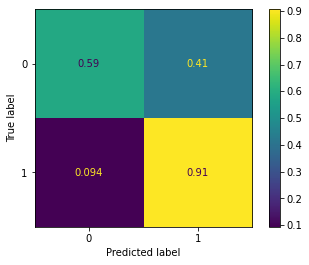

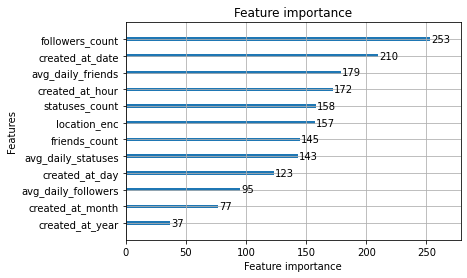

In [15]:
eval_clf(clf_users_fe, df_test_users_fe)

# Detection on tweets metadata

## Extract metadata

In [13]:
def extract_reply(text: str):
    res = re.match(r'(@\w+ )+', text)
    if res:
        text = text[res.span()[1]:]
        return text, True, res.group()[1:-1].split(" @")
    return text, False, np.nan

def extract_retweet(text: str):
    res = re.match(r'RT @(\w+): \.?', text)
    if res:
        text = text[res.span(0)[1]:]
        return text, True, res.group(1)
    return text, False, np.nan

def extract_modified_tweet(text: str):
    res = re.match(r'MT : ', text)
    if res:
        text = text[res.span(0)[1]:]
        return text, True
    return text, False

def extract_symbols(text: str, symbol: str):
    symbols = [ symbol[1:] for symbol in re.findall(fr"{symbol}\w+\b", text) ]
    text = re.sub(fr"{symbol}(?=\w+\b)", "", text)
    return text, symbols

def extract_links(text: str):
    links = re.findall("https?://.+?(?=(?:\s|$))", text)
    for link in links:
        text = text.replace(link, "")
    return text, links

def extract_ellipsis(text: str):
    text_cleaned = re.sub(r'\s*(?:\.{3}|…|\(\d+\/\d+\))\s*$', "", text)
    has_ellipsis = len(text_cleaned) != len(text)
    return text_cleaned, has_ellipsis

# TODO: Get emojis category? (use emojis, or advertools)
def extract_emojis(text: str):
    # Doesn't get all emojis...
    text = emojis.decode(text)
    emoji_list = re.findall(r":(.+?):", text)
    for emoji in emoji_list:
        text = text.replace(f":{emoji}:", "")
    return text, emoji_list
    
def clean_text(text: str):
    text_cleaned = unidecode(text)
    unk_chars_ratio = len(text_cleaned) / len(text) if text else 0
    text_cleaned = re.sub(r'\s+', ' ', text_cleaned)
    return text_cleaned, unk_chars_ratio


def extract_artefacts(text: str):
    text, is_reply, replies = extract_reply(text)
    text_sat = len(text) / 240
    
    text, is_rt, retweet = extract_retweet(text)
    text, is_mt = extract_modified_tweet(text)
    text, hashtags = extract_symbols(text, "#")
    text, mentions = extract_symbols(text, "@")
    text, cashtags = extract_symbols(text, "$")
    text, links = extract_links(text)
    
    text, has_ellipsis = extract_ellipsis(text)
    text, emoji_list = extract_emojis(text)
    text, unk_chars_ratio = clean_text(text)
    
    return (
        text, text_sat, is_reply, replies, 
        is_rt, retweet, is_mt, 
        hashtags, mentions, cashtags, 
        links, has_ellipsis, emoji_list, 
        unk_chars_ratio
    )


def get_artefacts(df: pd.DataFrame):    
    new_cols = [ 
        'tweet', 'text_sat', 'is_reply', 'replies', 
        'is_rt', 'retweet', 'is_mt', 
        'hashtags', 'mentions', 'cashtags',
        'links', 'has_ellipsis', 'emojis', 
        'unk_chars_ratio'
    ]
    df[new_cols] = pd.DataFrame(
        df['tweet'].swifter.apply(extract_artefacts).to_list(), 
        columns=new_cols
    )
    
    df['hashtags_count'] = df['hashtags'].apply(len)
    df['mentions_count'] = df['mentions'].apply(len)
    df['cashtags_count'] = df['cashtags'].apply(len)
    df['links_count'] = df['links'].apply(len)
    df['emojis_count'] = df['emojis'].apply(len)
    
    return df

In [14]:
df_train = get_artefacts(df_train)
df_test = get_artefacts(df_test)
df_train.head()

Pandas Apply:   0%|          | 0/1398465 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199863 [00:00<?, ?it/s]

,id,screen_name,location,followers_count,friends_count,statuses_count,tweet,label,location_enc,created_at_year,...,cashtags,links,has_ellipsis,emojis,unk_chars_ratio,hashtags_count,mentions_count,cashtags_count,links_count,emojis_count
0,24691376,vangoghmuseum,Amsterdam,1647822,1536,16822,Gustave Courbet was often called 'the most arr...,0,171,2009,...,[],[https://t.co/0YuOEv9mXU],False,"[triumph, sunflower]",1.0,1,0,0,1,2
1,259540958,IncredibleCulk,Heading to the corner,808966,146,2223,An animal MackLibs,0,1029,2011,...,[],[],False,[],1.0,1,0,0,0,0
2,424423803,CyaSteve,"Los Angeles, CA",2551,462,26710,I hope it's 900 gems.,1,1416,2011,...,[],[],False,[],1.0,0,0,0,0,0
3,281902422,SwatiJaiHind,"New Delhi, India",326003,381,8848,Delhi : Social Welfare Minister AdvRajendraPal...,0,1724,2011,...,[],[],True,[],1.0,1,2,0,0,0
4,173195708,Nigella_Lawson,London,2672077,872,36654,"I wouldn't even consider going on holiday now,...",0,1381,2010,...,[],[https://t.co/RFXOHTThMW],False,[],1.0,0,0,0,1,0


> __Improve extraction of emojis__

> __Improve spotting of non-english tweets__

> __Investigate tweets with more than 240 chars__

In [16]:
df_train.to_csv(PATH.format('train_metadata'))
df_test.to_csv(PATH.format('test_metadata'))

In [16]:
df_train = pd.read_csv(PATH.format('train_metadata'), index_col='Unnamed: 0')
df_test = pd.read_csv(PATH.format('test_metadata'), index_col='Unnamed: 0')

In [17]:
def filter_metadata(df: pd.DataFrame):
    return df.drop([ 'tweet', 'location', 'screen_name', 'id',
                     'replies', 'retweet', 'hashtags', 'mentions',
                     'cashtags', 'links', 'emojis' ], axis=1)

In [18]:
df_train_meta = filter_metadata(df_train)
df_test_meta = filter_metadata(df_test)

# Adding engineered features from df_users
df_train_meta = add_avg(df_train_meta)
df_test_meta = add_avg(df_test_meta)

## Training

> __Very high AUROC during training, but meh performance in the end bc of over-use of users metadata__

In [19]:
clf_meta = get_best_clf(df_train_meta)

[I 2022-03-29 15:43:12,906] A new study created in memory with name: no-name-ffdee84f-f9bb-40c3-aae7-d204785f90e6


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.819893


[I 2022-03-29 15:44:29,012] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 1.3124833228183552, 'lambda_l2': 2.455281868574583e-06, 'num_leaves': 8, 'feature_fraction': 0.791066992644315, 'bagging_fraction': 0.841663762607943, 'bagging_freq': 4, 'learning_rate': 7.184879136569997e-05, 'min_child_samples': 13}. Best is trial 0 with value: 0.5.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.936202


[I 2022-03-29 15:44:48,814] Trial 6 finished with value: 0.8312675694311281 and parameters: {'lambda_l1': 1.811949190954784e-07, 'lambda_l2': 0.006194422918920014, 'num_leaves': 19, 'feature_fraction': 0.961743547425519, 'bagging_fraction': 0.9675242135639576, 'bagging_freq': 7, 'learning_rate': 0.13385714585720423, 'min_child_samples': 77}. Best is trial 6 with value: 0.8312675694311281.


Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.843277
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:44:59,873] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 0.00012051502894808111, 'lambda_l2': 0.0009975376471537793, 'num_leaves': 25, 'feature_fraction': 0.8809854806708819, 'bagging_fraction': 0.5573913486967375, 'bagging_freq': 7, 'learning_rate': 0.00025744210027165614, 'min_child_samples': 55}. Best is trial 6 with value: 0.8312675694311281.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.848001


[I 2022-03-29 15:45:13,802] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 0.05735294844264237, 'lambda_l2': 1.9453872605322111, 'num_leaves': 31, 'feature_fraction': 0.8956067661948044, 'bagging_fraction': 0.7753163159380183, 'bagging_freq': 4, 'learning_rate': 0.00010277109980395337, 'min_child_samples': 22}. Best is trial 6 with value: 0.8312675694311281.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.967334


[I 2022-03-29 15:45:45,188] Trial 2 finished with value: 0.8668097835650415 and parameters: {'lambda_l1': 0.22032142440938932, 'lambda_l2': 6.515771771121721e-05, 'num_leaves': 60, 'feature_fraction': 0.7629661310985312, 'bagging_fraction': 0.9258033607564307, 'bagging_freq': 2, 'learning_rate': 0.059995056253597766, 'min_child_samples': 84}. Best is trial 2 with value: 0.8668097835650415.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.916736


[I 2022-03-29 15:46:05,301] Trial 11 finished with value: 0.8131513420306984 and parameters: {'lambda_l1': 3.9794912804180203e-07, 'lambda_l2': 0.06589519582952133, 'num_leaves': 20, 'feature_fraction': 0.6370046874393813, 'bagging_fraction': 0.717869364176777, 'bagging_freq': 2, 'learning_rate': 0.09417390276575124, 'min_child_samples': 34}. Best is trial 2 with value: 0.8668097835650415.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.898177


[I 2022-03-29 15:46:28,086] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 7.149894469958379e-05, 'lambda_l2': 1.8014105806328707e-06, 'num_leaves': 109, 'feature_fraction': 0.5447555107184415, 'bagging_fraction': 0.4681584506523092, 'bagging_freq': 7, 'learning_rate': 3.0217473763009813e-05, 'min_child_samples': 30}. Best is trial 2 with value: 0.8668097835650415.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.883227


[I 2022-03-29 15:46:45,415] Trial 9 finished with value: 0.6084435340798433 and parameters: {'lambda_l1': 0.10945358282184532, 'lambda_l2': 0.8637901928572603, 'num_leaves': 85, 'feature_fraction': 0.7407404602434746, 'bagging_fraction': 0.8162370487897748, 'bagging_freq': 6, 'learning_rate': 0.001172647229695395, 'min_child_samples': 75}. Best is trial 2 with value: 0.8668097835650415.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.947733


[I 2022-03-29 15:47:03,784] Trial 8 finished with value: 0.8450281915089214 and parameters: {'lambda_l1': 3.6135630031670144e-05, 'lambda_l2': 0.8427893998495226, 'num_leaves': 116, 'feature_fraction': 0.4301447890672012, 'bagging_fraction': 0.5427789812879387, 'bagging_freq': 3, 'learning_rate': 0.02057329839387314, 'min_child_samples': 73}. Best is trial 2 with value: 0.8668097835650415.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99981


[I 2022-03-29 15:47:12,299] Trial 7 finished with value: 0.9885251351018426 and parameters: {'lambda_l1': 0.03911201596297378, 'lambda_l2': 0.03338129039171185, 'num_leaves': 114, 'feature_fraction': 0.45821570046527604, 'bagging_fraction': 0.9214986334783662, 'bagging_freq': 3, 'learning_rate': 0.12630112450950756, 'min_child_samples': 36}. Best is trial 7 with value: 0.9885251351018426.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.90541


[I 2022-03-29 15:47:31,450] Trial 10 finished with value: 0.5 and parameters: {'lambda_l1': 4.316524546265671e-05, 'lambda_l2': 0.000291269609382779, 'num_leaves': 137, 'feature_fraction': 0.6923488442263266, 'bagging_fraction': 0.7470211009227353, 'bagging_freq': 6, 'learning_rate': 1.3491694759655287e-05, 'min_child_samples': 76}. Best is trial 7 with value: 0.9885251351018426.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.897979


[I 2022-03-29 15:47:54,883] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 3.315560905768019e-06, 'lambda_l2': 0.7957160205183679, 'num_leaves': 105, 'feature_fraction': 0.5899766962343418, 'bagging_fraction': 0.9207226628938947, 'bagging_freq': 7, 'learning_rate': 0.0010171873899566934, 'min_child_samples': 35}. Best is trial 7 with value: 0.9885251351018426.


Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.942811


[I 2022-03-29 15:48:02,503] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 3.2313861386197404e-07, 'lambda_l2': 0.0003985179741767534, 'num_leaves': 254, 'feature_fraction': 0.6921049317027141, 'bagging_fraction': 0.44615246151204435, 'bagging_freq': 6, 'learning_rate': 0.0006206829574457141, 'min_child_samples': 19}. Best is trial 7 with value: 0.9885251351018426.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.90432


[I 2022-03-29 15:48:18,916] Trial 13 finished with value: 0.7918502792517764 and parameters: {'lambda_l1': 6.196504162114034e-05, 'lambda_l2': 6.599422873854862e-06, 'num_leaves': 121, 'feature_fraction': 0.7314876829063303, 'bagging_fraction': 0.7248933583321662, 'bagging_freq': 7, 'learning_rate': 0.0019024344302821013, 'min_child_samples': 69}. Best is trial 7 with value: 0.9885251351018426.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.885774


[I 2022-03-29 15:48:42,447] Trial 15 finished with value: 0.7814036580071692 and parameters: {'lambda_l1': 1.2105432488870365e-08, 'lambda_l2': 2.6628639932779974e-07, 'num_leaves': 75, 'feature_fraction': 0.631677954580999, 'bagging_fraction': 0.9688369679357138, 'bagging_freq': 4, 'learning_rate': 0.002377707595488868, 'min_child_samples': 33}. Best is trial 7 with value: 0.9885251351018426.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 15:49:40,671] Trial 14 finished with value: 0.9999433478349726 and parameters: {'lambda_l1': 4.006189680634362e-05, 'lambda_l2': 0.4273316109949221, 'num_leaves': 246, 'feature_fraction': 0.8473318422368464, 'bagging_fraction': 0.6407142463837159, 'bagging_freq': 2, 'learning_rate': 0.2579571171521207, 'min_child_samples': 81}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.95257


[I 2022-03-29 15:49:58,330] Trial 17 finished with value: 0.8456634251286564 and parameters: {'lambda_l1': 0.0025756829850323345, 'lambda_l2': 1.480223405753161e-08, 'num_leaves': 182, 'feature_fraction': 0.4053779013116817, 'bagging_fraction': 0.6481789925185604, 'bagging_freq': 1, 'learning_rate': 0.008865142918390247, 'min_child_samples': 50}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.93571


[I 2022-03-29 15:50:14,407] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 3.2537939877035334e-05, 'lambda_l2': 0.00014410195971676843, 'num_leaves': 248, 'feature_fraction': 0.7617862332678327, 'bagging_fraction': 0.5974665732694056, 'bagging_freq': 4, 'learning_rate': 0.00010379612218564296, 'min_child_samples': 58}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.96307


[I 2022-03-29 15:50:30,797] Trial 18 finished with value: 0.8626095512470601 and parameters: {'lambda_l1': 0.024167104588329994, 'lambda_l2': 3.65129545703881e-05, 'num_leaves': 194, 'feature_fraction': 0.41195927681266353, 'bagging_fraction': 0.9988719576126476, 'bagging_freq': 1, 'learning_rate': 0.012380547645584246, 'min_child_samples': 100}. Best is trial 14 with value: 0.9999433478349726.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.950064


[I 2022-03-29 15:50:42,890] Trial 20 finished with value: 0.8453783415570457 and parameters: {'lambda_l1': 0.009962218090203452, 'lambda_l2': 6.151557567875324e-08, 'num_leaves': 166, 'feature_fraction': 0.41493716701187366, 'bagging_fraction': 0.8915106100090686, 'bagging_freq': 1, 'learning_rate': 0.010676578608699909, 'min_child_samples': 99}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.954983


[I 2022-03-29 15:51:02,979] Trial 21 finished with value: 0.8536888470201397 and parameters: {'lambda_l1': 0.00703503371914689, 'lambda_l2': 5.830125544330815e-08, 'num_leaves': 164, 'feature_fraction': 0.42150540635084915, 'bagging_fraction': 0.9951939117057038, 'bagging_freq': 1, 'learning_rate': 0.013578319049810399, 'min_child_samples': 99}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.965361


[I 2022-03-29 15:51:17,257] Trial 19 finished with value: 0.8642309568084775 and parameters: {'lambda_l1': 0.007499056218815355, 'lambda_l2': 3.0025215606821755e-05, 'num_leaves': 197, 'feature_fraction': 0.4139556042456141, 'bagging_fraction': 0.9846611053260244, 'bagging_freq': 1, 'learning_rate': 0.013197801755643813, 'min_child_samples': 99}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.961742


[I 2022-03-29 15:51:37,952] Trial 22 finished with value: 0.8607942868492623 and parameters: {'lambda_l1': 0.006318485728413604, 'lambda_l2': 1.0746682753886944e-08, 'num_leaves': 164, 'feature_fraction': 0.4002064137631061, 'bagging_fraction': 0.894068149040119, 'bagging_freq': 1, 'learning_rate': 0.016290379169622914, 'min_child_samples': 51}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.955845


[I 2022-03-29 15:52:22,833] Trial 28 finished with value: 0.8532869958100848 and parameters: {'lambda_l1': 8.173069839893198, 'lambda_l2': 0.030682726084774896, 'num_leaves': 53, 'feature_fraction': 0.8354451065301524, 'bagging_fraction': 0.6400569535126199, 'bagging_freq': 2, 'learning_rate': 0.05597979866798949, 'min_child_samples': 92}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999753


[I 2022-03-29 15:52:35,305] Trial 29 finished with value: 0.992481002586196 and parameters: {'lambda_l1': 0.30606037281117976, 'lambda_l2': 0.03197576085396149, 'num_leaves': 57, 'feature_fraction': 0.832239205979345, 'bagging_fraction': 0.6521326701873122, 'bagging_freq': 3, 'learning_rate': 0.2506134763842746, 'min_child_samples': 85}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999508


[I 2022-03-29 15:52:51,787] Trial 30 finished with value: 0.9880676218501611 and parameters: {'lambda_l1': 1.6322753785642816, 'lambda_l2': 0.0482661129823386, 'num_leaves': 56, 'feature_fraction': 0.8275636703555657, 'bagging_fraction': 0.6593793204780475, 'bagging_freq': 3, 'learning_rate': 0.20718619484594417, 'min_child_samples': 85}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.960954
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 15:53:16,171] Trial 23 finished with value: 0.8603687857257094 and parameters: {'lambda_l1': 0.003388293432728849, 'lambda_l2': 0.017358624167178496, 'num_leaves': 176, 'feature_fraction': 0.42436241412712256, 'bagging_fraction': 0.6276147199034807, 'bagging_freq': 1, 'learning_rate': 0.014114930993572323, 'min_child_samples': 99}. Best is trial 14 with value: 0.9999433478349726.
[I 2022-03-29 15:53:21,693] Trial 24 finished with value: 0.999843740911219 and parameters: {'lambda_l1': 0.0022969858782774643, 'lambda_l2': 0.029250054223324808, 'num_leaves': 171, 'feature_fraction': 0.5084598039586131, 'bagging_fraction': 0.6729078507101985, 'bagging_freq': 1, 'learning_rate': 0.2885893737176199, 'min_child_samples': 99}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 15:53:55,802] Trial 26 finished with value: 0.9997352727601133 and parameters: {'lambda_l1': 0.0020806497233603312, 'lambda_l2': 0.030118476278570845, 'num_leaves': 157, 'feature_fraction': 0.5057278233860948, 'bagging_fraction': 0.6500700659595529, 'bagging_freq': 3, 'learning_rate': 0.260910687436072, 'min_child_samples': 97}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999227


[I 2022-03-29 15:54:14,470] Trial 31 finished with value: 0.9809151517129056 and parameters: {'lambda_l1': 0.0007662677436216645, 'lambda_l2': 9.651686313740742, 'num_leaves': 54, 'feature_fraction': 0.5034061376965238, 'bagging_fraction': 0.8187236396748244, 'bagging_freq': 3, 'learning_rate': 0.22892448433102108, 'min_child_samples': 86}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 15:54:26,880] Trial 25 finished with value: 0.999784135003741 and parameters: {'lambda_l1': 0.003281350369503341, 'lambda_l2': 0.037769098451339744, 'num_leaves': 172, 'feature_fraction': 0.5352992833255061, 'bagging_fraction': 0.6221814160192932, 'bagging_freq': 1, 'learning_rate': 0.25519954242074644, 'min_child_samples': 99}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 15:54:40,389] Trial 27 finished with value: 0.9999223410647342 and parameters: {'lambda_l1': 0.0007150152606087242, 'lambda_l2': 0.039158060178285575, 'num_leaves': 214, 'feature_fraction': 0.4931523218557108, 'bagging_fraction': 0.6495062611470149, 'bagging_freq': 3, 'learning_rate': 0.28813994823369316, 'min_child_samples': 45}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 15:54:57,095] Trial 32 finished with value: 0.9995701524439804 and parameters: {'lambda_l1': 0.0009976147526945792, 'lambda_l2': 8.830467608965456, 'num_leaves': 141, 'feature_fraction': 0.9509639908389141, 'bagging_fraction': 0.6756141046053694, 'bagging_freq': 3, 'learning_rate': 0.2500045905241997, 'min_child_samples': 43}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 15:55:49,538] Trial 35 finished with value: 0.9999196276010145 and parameters: {'lambda_l1': 0.0006763360281549333, 'lambda_l2': 7.613678008978592, 'num_leaves': 218, 'feature_fraction': 0.9943766741094899, 'bagging_fraction': 0.6899010276705787, 'bagging_freq': 2, 'learning_rate': 0.2969905012336805, 'min_child_samples': 87}. Best is trial 14 with value: 0.9999433478349726.
[I 2022-03-29 15:55:53,527] Trial 34 finished with value: 0.9999130191765951 and parameters: {'lambda_l1': 0.0006748232251578206, 'lambda_l2': 6.953648115377031, 'num_leaves': 229, 'feature_fraction': 0.9684980730142989, 'bagging_fraction': 0.5402144916816851, 'bagging_freq': 3, 'learning_rate': 0.27619187884937, 'min_child_samples': 67}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:56:06,712] Trial 33 finished with value: 0.9999139603948441 and parameters: {'lambda_l1': 0.0010721519001145273, 'lambda_l2': 6.884807200357076, 'num_leaves': 222, 'feature_fraction': 0.9668598210557058, 'bagging_fraction': 0.6829216939532422, 'bagging_freq': 3, 'learning_rate': 0.2430161580768533, 'min_child_samples': 42}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 15:56:22,216] Trial 36 finished with value: 0.9998497585871482 and parameters: {'lambda_l1': 0.000381098696672402, 'lambda_l2': 9.887039702195013, 'num_leaves': 223, 'feature_fraction': 0.5090906585433917, 'bagging_fraction': 0.5004850089634595, 'bagging_freq': 2, 'learning_rate': 0.2965856199516352, 'min_child_samples': 89}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.997798


[I 2022-03-29 15:56:37,009] Trial 37 finished with value: 0.9561858044322151 and parameters: {'lambda_l1': 0.0005029782277791329, 'lambda_l2': 0.0030499678280669663, 'num_leaves': 227, 'feature_fraction': 0.5040780846827054, 'bagging_fraction': 0.5147687227499637, 'bagging_freq': 2, 'learning_rate': 0.03690350374833049, 'min_child_samples': 64}. Best is trial 14 with value: 0.9999433478349726.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.997776
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:56:46,906] Trial 38 finished with value: 0.9594753642724685 and parameters: {'lambda_l1': 0.0007449101021125836, 'lambda_l2': 0.21248912737719114, 'num_leaves': 224, 'feature_fraction': 0.4889239455029933, 'bagging_fraction': 0.570305839723118, 'bagging_freq': 2, 'learning_rate': 0.03807908966344937, 'min_child_samples': 92}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.998534


[I 2022-03-29 15:56:59,740] Trial 39 finished with value: 0.9668765609393737 and parameters: {'lambda_l1': 0.0005448701033659501, 'lambda_l2': 0.20122719533504582, 'num_leaves': 223, 'feature_fraction': 0.5400025008031973, 'bagging_fraction': 0.571117052461147, 'bagging_freq': 2, 'learning_rate': 0.04145557090027296, 'min_child_samples': 63}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.997855


[I 2022-03-29 15:57:26,221] Trial 40 finished with value: 0.9600530198497008 and parameters: {'lambda_l1': 0.0004084861818549742, 'lambda_l2': 0.20379961164311458, 'num_leaves': 226, 'feature_fraction': 0.5467339081590963, 'bagging_fraction': 0.5887927600646357, 'bagging_freq': 2, 'learning_rate': 0.03788470569378111, 'min_child_samples': 65}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99976


[I 2022-03-29 15:58:10,788] Trial 41 finished with value: 0.987124260834581 and parameters: {'lambda_l1': 0.00031205414313082396, 'lambda_l2': 0.33320129221883926, 'num_leaves': 228, 'feature_fraction': 0.9886747947415804, 'bagging_fraction': 0.5315610049179375, 'bagging_freq': 2, 'learning_rate': 0.046288934438246616, 'min_child_samples': 63}. Best is trial 14 with value: 0.9999433478349726.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999392


[I 2022-03-29 15:58:18,929] Trial 42 finished with value: 0.9787323223742034 and parameters: {'lambda_l1': 0.0003055119384431403, 'lambda_l2': 0.19479851691294744, 'num_leaves': 227, 'feature_fraction': 0.9042379660402318, 'bagging_fraction': 0.5175254315422637, 'bagging_freq': 2, 'learning_rate': 0.04187427193561034, 'min_child_samples': 60}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999298


[I 2022-03-29 15:58:40,597] Trial 44 finished with value: 0.9771196984534388 and parameters: {'lambda_l1': 8.51662861325593e-06, 'lambda_l2': 0.20312007926112252, 'num_leaves': 218, 'feature_fraction': 0.9205464157485068, 'bagging_fraction': 0.7713749005136562, 'bagging_freq': 5, 'learning_rate': 0.04209766067413764, 'min_child_samples': 43}. Best is trial 14 with value: 0.9999433478349726.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999915


[I 2022-03-29 15:58:50,085] Trial 45 finished with value: 0.9922461142582042 and parameters: {'lambda_l1': 9.752643126324994e-06, 'lambda_l2': 0.1879212309688684, 'num_leaves': 212, 'feature_fraction': 0.9222236489776294, 'bagging_fraction': 0.5833800692063984, 'bagging_freq': 5, 'learning_rate': 0.06218659261992772, 'min_child_samples': 10}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999995
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 15:59:02,690] Trial 46 finished with value: 0.998179060725645 and parameters: {'lambda_l1': 6.741133394980631e-06, 'lambda_l2': 0.17356638517970463, 'num_leaves': 208, 'feature_fraction': 0.9194004279650602, 'bagging_fraction': 0.7678132973193651, 'bagging_freq': 5, 'learning_rate': 0.08921082072419903, 'min_child_samples': 6}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99888


[I 2022-03-29 15:59:21,082] Trial 43 finished with value: 0.9722971555475592 and parameters: {'lambda_l1': 0.00022496062788659473, 'lambda_l2': 1.7598646506286515, 'num_leaves': 221, 'feature_fraction': 0.9193183542098701, 'bagging_fraction': 0.7687023841832109, 'bagging_freq': 2, 'learning_rate': 0.038981771242286335, 'min_child_samples': 61}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 15:59:51,255] Trial 47 finished with value: 0.9992001311774951 and parameters: {'lambda_l1': 9.484002328189939e-06, 'lambda_l2': 3.136983092049401, 'num_leaves': 242, 'feature_fraction': 0.9264513828589797, 'bagging_fraction': 0.7744547438608761, 'bagging_freq': 5, 'learning_rate': 0.10563284741818559, 'min_child_samples': 8}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999998


[I 2022-03-29 16:00:16,383] Trial 48 finished with value: 0.9993559296054889 and parameters: {'lambda_l1': 9.403057429199615e-06, 'lambda_l2': 2.467384048067485, 'num_leaves': 243, 'feature_fraction': 0.9869161013997301, 'bagging_fraction': 0.41433666925404905, 'bagging_freq': 5, 'learning_rate': 0.11529504415116877, 'min_child_samples': 24}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999998


[I 2022-03-29 16:01:23,867] Trial 49 finished with value: 0.9990308756219312 and parameters: {'lambda_l1': 9.243845560046542e-06, 'lambda_l2': 3.2926997342572193, 'num_leaves': 244, 'feature_fraction': 0.9033220086739471, 'bagging_fraction': 0.7621037117282464, 'bagging_freq': 4, 'learning_rate': 0.09153194286174811, 'min_child_samples': 45}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-03-29 16:01:38,959] Trial 50 finished with value: 0.9987818384158721 and parameters: {'lambda_l1': 1.645340129818457e-05, 'lambda_l2': 2.484302806442602, 'num_leaves': 244, 'feature_fraction': 0.9268375012094446, 'bagging_fraction': 0.7646386535235074, 'bagging_freq': 5, 'learning_rate': 0.0930882247136917, 'min_child_samples': 47}. Best is trial 14 with value: 0.9999433478349726.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999995


[I 2022-03-29 16:01:48,051] Trial 51 finished with value: 0.9986778559739564 and parameters: {'lambda_l1': 9.381643170706425e-06, 'lambda_l2': 2.780621222571892, 'num_leaves': 241, 'feature_fraction': 0.9387964635509428, 'bagging_fraction': 0.7045747586240713, 'bagging_freq': 3, 'learning_rate': 0.09000263584221185, 'min_child_samples': 6}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 16:02:04,751] Trial 52 finished with value: 0.9994764331084531 and parameters: {'lambda_l1': 0.00012557039135042554, 'lambda_l2': 2.406796865667238, 'num_leaves': 243, 'feature_fraction': 0.9885361834884664, 'bagging_fraction': 0.6919529578781859, 'bagging_freq': 3, 'learning_rate': 0.12306061950660664, 'min_child_samples': 79}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:02:23,041] Trial 53 finished with value: 0.9996834567740351 and parameters: {'lambda_l1': 0.0001259680035181877, 'lambda_l2': 2.2471474415010415, 'num_leaves': 246, 'feature_fraction': 0.9775187387994161, 'bagging_fraction': 0.701203008512706, 'bagging_freq': 3, 'learning_rate': 0.13677045036734184, 'min_child_samples': 81}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:02:35,270] Trial 54 finished with value: 0.9996840475225252 and parameters: {'lambda_l1': 9.114102182329834e-05, 'lambda_l2': 3.3394098902222815, 'num_leaves': 247, 'feature_fraction': 0.9939534853104978, 'bagging_fraction': 0.6953868573048347, 'bagging_freq': 3, 'learning_rate': 0.1338240587322629, 'min_child_samples': 26}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 16:02:51,844] Trial 56 finished with value: 0.9995713339409608 and parameters: {'lambda_l1': 1.132305531976463e-06, 'lambda_l2': 0.7226692584695519, 'num_leaves': 196, 'feature_fraction': 0.9596520773003114, 'bagging_fraction': 0.7024948902189688, 'bagging_freq': 4, 'learning_rate': 0.15329639258198893, 'min_child_samples': 71}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 16:03:06,534] Trial 55 finished with value: 0.9994742002021956 and parameters: {'lambda_l1': 0.00014937335458621107, 'lambda_l2': 2.537466472378846, 'num_leaves': 256, 'feature_fraction': 0.8693447599719951, 'bagging_fraction': 0.40662474658525705, 'bagging_freq': 3, 'learning_rate': 0.13502550435497315, 'min_child_samples': 79}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 16:03:56,213] Trial 58 finished with value: 0.9995561045679203 and parameters: {'lambda_l1': 0.0001411760514516358, 'lambda_l2': 0.8351817808204374, 'num_leaves': 198, 'feature_fraction': 0.8602119500318144, 'bagging_fraction': 0.49132369748986304, 'bagging_freq': 3, 'learning_rate': 0.1657871459599791, 'min_child_samples': 79}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:04:11,082] Trial 60 finished with value: 0.9997742223671118 and parameters: {'lambda_l1': 9.134906824478706e-05, 'lambda_l2': 0.567313988563189, 'num_leaves': 202, 'feature_fraction': 0.9624355627776745, 'bagging_fraction': 0.4871000771470907, 'bagging_freq': 4, 'learning_rate': 0.18099365863736253, 'min_child_samples': 80}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.933879


[I 2022-03-29 16:04:31,813] Trial 59 finished with value: 0.9997925156736308 and parameters: {'lambda_l1': 0.00015300104442112872, 'lambda_l2': 0.7027081457739114, 'num_leaves': 256, 'feature_fraction': 0.8543209214467695, 'bagging_fraction': 0.4780708810890454, 'bagging_freq': 3, 'learning_rate': 0.16555758082637825, 'min_child_samples': 79}. Best is trial 14 with value: 0.9999433478349726.
[I 2022-03-29 16:04:36,616] Trial 61 finished with value: 0.8417171488968684 and parameters: {'lambda_l1': 0.022154114982779687, 'lambda_l2': 7.075998337352017, 'num_leaves': 203, 'feature_fraction': 0.8538669846135442, 'bagging_fraction': 0.4878972596804544, 'bagging_freq': 4, 'learning_rate': 0.004839495526445527, 'min_child_samples': 71}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:04:56,894] Trial 57 finished with value: 0.9997268920902235 and parameters: {'lambda_l1': 0.00012525102953632328, 'lambda_l2': 1.4255140827341786, 'num_leaves': 255, 'feature_fraction': 0.8693558359432891, 'bagging_fraction': 0.6920219735094946, 'bagging_freq': 3, 'learning_rate': 0.15467531047011063, 'min_child_samples': 79}. Best is trial 14 with value: 0.9999433478349726.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999998


[I 2022-03-29 16:05:05,792] Trial 62 finished with value: 0.9994883582692836 and parameters: {'lambda_l1': 0.017311798148370326, 'lambda_l2': 0.7550765556012574, 'num_leaves': 200, 'feature_fraction': 0.4578363852435377, 'bagging_fraction': 0.4747268029603904, 'bagging_freq': 4, 'learning_rate': 0.17715627914304727, 'min_child_samples': 72}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.945851


[I 2022-03-29 16:05:39,900] Trial 64 finished with value: 0.8424799627751614 and parameters: {'lambda_l1': 0.01889133520778985, 'lambda_l2': 6.4913782441885015, 'num_leaves': 208, 'feature_fraction': 0.6630897490117292, 'bagging_fraction': 0.48533586957717173, 'bagging_freq': 4, 'learning_rate': 0.005275754359818284, 'min_child_samples': 39}. Best is trial 14 with value: 0.9999433478349726.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 1


[I 2022-03-29 16:05:47,292] Trial 63 finished with value: 0.999683106304276 and parameters: {'lambda_l1': 0.02198796889779909, 'lambda_l2': 9.823620131445313, 'num_leaves': 256, 'feature_fraction': 0.882069353754071, 'bagging_fraction': 0.46032084106478677, 'bagging_freq': 4, 'learning_rate': 0.17118668464810347, 'min_child_samples': 90}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.919998


[I 2022-03-29 16:06:19,828] Trial 67 finished with value: 0.5 and parameters: {'lambda_l1': 3.255323654423095e-05, 'lambda_l2': 6.894855750614684, 'num_leaves': 188, 'feature_fraction': 0.8012320224387601, 'bagging_fraction': 0.4474302376570026, 'bagging_freq': 2, 'learning_rate': 0.0003725891146770469, 'min_child_samples': 90}. Best is trial 14 with value: 0.9999433478349726.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.94244


[I 2022-03-29 16:06:29,186] Trial 65 finished with value: 0.8379498036158096 and parameters: {'lambda_l1': 3.2319764500848816e-05, 'lambda_l2': 6.78477312132887, 'num_leaves': 206, 'feature_fraction': 0.6635341700939881, 'bagging_fraction': 0.4526119393085902, 'bagging_freq': 4, 'learning_rate': 0.004251491325776554, 'min_child_samples': 54}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.931558


[I 2022-03-29 16:06:41,951] Trial 68 finished with value: 0.5 and parameters: {'lambda_l1': 0.002056975334348944, 'lambda_l2': 0.005491579917984645, 'num_leaves': 187, 'feature_fraction': 0.44475249002008643, 'bagging_fraction': 0.7356231086483103, 'bagging_freq': 2, 'learning_rate': 0.00027809033117543396, 'min_child_samples': 90}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.949136


[I 2022-03-29 16:06:55,055] Trial 66 finished with value: 0.8468010275733389 and parameters: {'lambda_l1': 0.020795414953144013, 'lambda_l2': 5.666501889826573, 'num_leaves': 211, 'feature_fraction': 0.658331276496913, 'bagging_fraction': 0.7337500852725788, 'bagging_freq': 2, 'learning_rate': 0.0059074812956839565, 'min_child_samples': 55}. Best is trial 14 with value: 0.9999433478349726.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:07:02,676] Trial 70 finished with value: 0.9998881174456566 and parameters: {'lambda_l1': 0.0018119849767098933, 'lambda_l2': 0.010384320314711176, 'num_leaves': 187, 'feature_fraction': 0.592299187603842, 'bagging_fraction': 0.7309862009942807, 'bagging_freq': 2, 'learning_rate': 0.2898127898466674, 'min_child_samples': 91}. Best is trial 14 with value: 0.9999433478349726.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 1


[I 2022-03-29 16:07:12,481] Trial 69 finished with value: 0.9999589276777721 and parameters: {'lambda_l1': 0.0015595180459328454, 'lambda_l2': 0.000910472060708042, 'num_leaves': 233, 'feature_fraction': 0.66152134892701, 'bagging_fraction': 0.6061412345284101, 'bagging_freq': 2, 'learning_rate': 0.2957806521456367, 'min_child_samples': 90}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.928427


[I 2022-03-29 16:07:39,561] Trial 71 finished with value: 0.5 and parameters: {'lambda_l1': 0.0022162950394181468, 'lambda_l2': 0.01060977998003313, 'num_leaves': 189, 'feature_fraction': 0.5978888484484176, 'bagging_fraction': 0.6145180435035723, 'bagging_freq': 2, 'learning_rate': 0.00035389543964798085, 'min_child_samples': 90}. Best is trial 69 with value: 0.9999589276777721.


Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.929808
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:07:49,474] Trial 72 finished with value: 0.5 and parameters: {'lambda_l1': 0.0011778447605855131, 'lambda_l2': 0.012482478264335836, 'num_leaves': 188, 'feature_fraction': 0.5944962407169758, 'bagging_fraction': 0.608349711520495, 'bagging_freq': 1, 'learning_rate': 0.00021873459156359588, 'min_child_samples': 56}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:08:41,510] Trial 73 finished with value: 0.9999507872866134 and parameters: {'lambda_l1': 0.0018456318581948324, 'lambda_l2': 0.010050831178176341, 'num_leaves': 234, 'feature_fraction': 0.5967744421984044, 'bagging_fraction': 0.7358893607848305, 'bagging_freq': 1, 'learning_rate': 0.27497293657727007, 'min_child_samples': 55}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.990015


[I 2022-03-29 16:08:56,226] Trial 74 finished with value: 0.9123143246389298 and parameters: {'lambda_l1': 0.001431226332208161, 'lambda_l2': 0.00644459137514863, 'num_leaves': 233, 'feature_fraction': 0.5807376972853522, 'bagging_fraction': 0.7333997340488551, 'bagging_freq': 1, 'learning_rate': 0.023232448064470116, 'min_child_samples': 94}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:09:07,937] Trial 75 finished with value: 0.9999361486620632 and parameters: {'lambda_l1': 0.0013483468170083928, 'lambda_l2': 0.010271233737754078, 'num_leaves': 233, 'feature_fraction': 0.5734658400004355, 'bagging_fraction': 0.6282626912905114, 'bagging_freq': 1, 'learning_rate': 0.2763201784597992, 'min_child_samples': 96}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 1


[I 2022-03-29 16:09:23,191] Trial 77 finished with value: 0.9999400436227629 and parameters: {'lambda_l1': 0.0012440225402265321, 'lambda_l2': 0.001504522119405545, 'num_leaves': 231, 'feature_fraction': 0.567065350736353, 'bagging_fraction': 0.6076086279559092, 'bagging_freq': 2, 'learning_rate': 0.28676672230860567, 'min_child_samples': 40}. Best is trial 69 with value: 0.9999589276777721.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:09:32,682] Trial 76 finished with value: 0.9999400436227629 and parameters: {'lambda_l1': 0.0012887993841183124, 'lambda_l2': 0.09222970797584001, 'num_leaves': 234, 'feature_fraction': 0.48854397798851096, 'bagging_fraction': 0.6211451616235799, 'bagging_freq': 1, 'learning_rate': 0.26947942403640635, 'min_child_samples': 95}. Best is trial 69 with value: 0.9999589276777721.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:09:40,974] Trial 78 finished with value: 0.999917264607054 and parameters: {'lambda_l1': 0.0014709396756890103, 'lambda_l2': 0.0008803731122260503, 'num_leaves': 235, 'feature_fraction': 0.5890845742668831, 'bagging_fraction': 0.6061734966162612, 'bagging_freq': 2, 'learning_rate': 0.2873551856587593, 'min_child_samples': 94}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.990768


[I 2022-03-29 16:10:07,455] Trial 79 finished with value: 0.9136275079542477 and parameters: {'lambda_l1': 0.0042750610505740425, 'lambda_l2': 0.0009539642221464502, 'num_leaves': 234, 'feature_fraction': 0.5763032251316554, 'bagging_fraction': 0.6764001262156629, 'bagging_freq': 2, 'learning_rate': 0.02371267340705379, 'min_child_samples': 83}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 1


[I 2022-03-29 16:10:34,581] Trial 80 finished with value: 0.999921159567754 and parameters: {'lambda_l1': 0.05946718243420635, 'lambda_l2': 0.0008405254404905757, 'num_leaves': 234, 'feature_fraction': 0.7111927611554362, 'bagging_fraction': 0.5469203711024639, 'bagging_freq': 2, 'learning_rate': 0.2915468470125514, 'min_child_samples': 95}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:10:55,259] Trial 81 finished with value: 0.9998890586639058 and parameters: {'lambda_l1': 0.006033229697287862, 'lambda_l2': 0.0010768996123202857, 'num_leaves': 230, 'feature_fraction': 0.7102840960245672, 'bagging_fraction': 0.672488208546403, 'bagging_freq': 1, 'learning_rate': 0.2257456512873685, 'min_child_samples': 95}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:11:13,278] Trial 82 finished with value: 0.9999529100018426 and parameters: {'lambda_l1': 0.004855420903558189, 'lambda_l2': 0.0007564140996742235, 'num_leaves': 234, 'feature_fraction': 0.7085624139513296, 'bagging_fraction': 0.796146320404814, 'bagging_freq': 1, 'learning_rate': 0.27885260317919897, 'min_child_samples': 67}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99998


[I 2022-03-29 16:11:36,048] Trial 85 finished with value: 0.9962184936145858 and parameters: {'lambda_l1': 0.004545676255229813, 'lambda_l2': 0.001722440077163606, 'num_leaves': 218, 'feature_fraction': 0.7179719107416049, 'bagging_fraction': 0.6342373070655486, 'bagging_freq': 1, 'learning_rate': 0.07418871456136827, 'min_child_samples': 96}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999932


[I 2022-03-29 16:11:54,619] Trial 86 finished with value: 0.9998695838604066 and parameters: {'lambda_l1': 0.006028613334558932, 'lambda_l2': 0.07132085443581562, 'num_leaves': 235, 'feature_fraction': 0.7107861791351079, 'bagging_fraction': 0.6358476533477676, 'bagging_freq': 1, 'learning_rate': 0.20971502514821527, 'min_child_samples': 96}. Best is trial 69 with value: 0.9999589276777721.
[I 2022-03-29 16:11:59,119] Trial 83 finished with value: 0.9926700742259975 and parameters: {'lambda_l1': 0.0522797031888913, 'lambda_l2': 0.0009227983718188593, 'num_leaves': 231, 'feature_fraction': 0.6208189017796637, 'bagging_fraction': 0.670279000622594, 'bagging_freq': 1, 'learning_rate': 0.06333623813022177, 'min_child_samples': 95}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999988


[I 2022-03-29 16:12:14,033] Trial 84 finished with value: 0.9967865671282731 and parameters: {'lambda_l1': 0.003986605559146697, 'lambda_l2': 0.0012666504333164045, 'num_leaves': 232, 'feature_fraction': 0.7021826716981534, 'bagging_fraction': 0.6370687772537889, 'bagging_freq': 1, 'learning_rate': 0.07536460746938703, 'min_child_samples': 37}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:12:47,346] Trial 88 finished with value: 0.9998419686657486 and parameters: {'lambda_l1': 0.09855943649834448, 'lambda_l2': 0.002511238525212189, 'num_leaves': 214, 'feature_fraction': 0.7444915390688897, 'bagging_fraction': 0.637681200524082, 'bagging_freq': 1, 'learning_rate': 0.2070805154546635, 'min_child_samples': 96}. Best is trial 69 with value: 0.9999589276777721.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99995


[I 2022-03-29 16:12:55,684] Trial 87 finished with value: 0.994429174686617 and parameters: {'lambda_l1': 0.06566733252675715, 'lambda_l2': 0.0021838672466477755, 'num_leaves': 216, 'feature_fraction': 0.7126136379034994, 'bagging_fraction': 0.6344890689159453, 'bagging_freq': 1, 'learning_rate': 0.06968456929304666, 'min_child_samples': 95}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999943


[I 2022-03-29 16:13:23,133] Trial 89 finished with value: 0.9940828736540898 and parameters: {'lambda_l1': 0.06530362340821734, 'lambda_l2': 0.0023267860664022873, 'num_leaves': 216, 'feature_fraction': 0.5591578584397806, 'bagging_fraction': 0.6335840494730997, 'bagging_freq': 1, 'learning_rate': 0.06826124607989176, 'min_child_samples': 31}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.886632


[I 2022-03-29 16:13:36,089] Trial 94 finished with value: 0.5 and parameters: {'lambda_l1': 0.12126710860302509, 'lambda_l2': 0.00021900408536847416, 'num_leaves': 93, 'feature_fraction': 0.7564742495843986, 'bagging_fraction': 0.7944792663529191, 'bagging_freq': 1, 'learning_rate': 3.072928611938416e-05, 'min_child_samples': 48}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999945


[I 2022-03-29 16:13:54,304] Trial 90 finished with value: 0.9926592004744443 and parameters: {'lambda_l1': 0.06801528282936287, 'lambda_l2': 0.0002735650944827495, 'num_leaves': 238, 'feature_fraction': 0.6238215745089281, 'bagging_fraction': 0.8098667518963217, 'bagging_freq': 1, 'learning_rate': 0.060896614367842446, 'min_child_samples': 49}. Best is trial 69 with value: 0.9999589276777721.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.877271


[I 2022-03-29 16:14:11,705] Trial 98 finished with value: 0.7881820621645178 and parameters: {'lambda_l1': 0.012138342575362324, 'lambda_l2': 0.0005447239777085063, 'num_leaves': 6, 'feature_fraction': 0.5294207238315932, 'bagging_fraction': 0.5668958744198377, 'bagging_freq': 2, 'learning_rate': 0.20839179939729144, 'min_child_samples': 86}. Best is trial 69 with value: 0.9999589276777721.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 1


[I 2022-03-29 16:14:17,203] Trial 91 finished with value: 0.9998623846874971 and parameters: {'lambda_l1': 0.04690366611695592, 'lambda_l2': 0.00018774648584444337, 'num_leaves': 236, 'feature_fraction': 0.6275850673151759, 'bagging_fraction': 0.8377973444863042, 'bagging_freq': 1, 'learning_rate': 0.20617430472832907, 'min_child_samples': 38}. Best is trial 69 with value: 0.9999589276777721.


Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.896453


[I 2022-03-29 16:14:21,033] Trial 95 finished with value: 0.5 and parameters: {'lambda_l1': 0.008898525997224429, 'lambda_l2': 0.00019199843538474654, 'num_leaves': 101, 'feature_fraction': 0.5571991243382235, 'bagging_fraction': 0.5601388873555435, 'bagging_freq': 1, 'learning_rate': 4.9659205916412075e-05, 'min_child_samples': 50}. Best is trial 69 with value: 0.9999589276777721.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 1


[I 2022-03-29 16:14:31,342] Trial 92 finished with value: 0.9998824502394863 and parameters: {'lambda_l1': 0.4561201636427805, 'lambda_l2': 0.0002564780800597731, 'num_leaves': 237, 'feature_fraction': 0.7548906442679546, 'bagging_fraction': 0.8436818071397663, 'bagging_freq': 1, 'learning_rate': 0.20320531496033045, 'min_child_samples': 37}. Best is trial 69 with value: 0.9999589276777721.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:14:37,230] Trial 93 finished with value: 0.9998413779172584 and parameters: {'lambda_l1': 0.49694540340609833, 'lambda_l2': 0.00011735385395127944, 'num_leaves': 239, 'feature_fraction': 0.5609885686371573, 'bagging_fraction': 0.5652932073294892, 'bagging_freq': 1, 'learning_rate': 0.20377422352843008, 'min_child_samples': 37}. Best is trial 69 with value: 0.9999589276777721.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 1


[I 2022-03-29 16:14:57,338] Trial 96 finished with value: 0.9998773737818062 and parameters: {'lambda_l1': 0.4851018350946431, 'lambda_l2': 0.0002927293588207201, 'num_leaves': 250, 'feature_fraction': 0.5522902341954595, 'bagging_fraction': 0.7975081754880331, 'bagging_freq': 1, 'learning_rate': 0.20118586845118466, 'min_child_samples': 49}. Best is trial 69 with value: 0.9999589276777721.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-03-29 16:15:03,317] Trial 99 finished with value: 0.9994178985069273 and parameters: {'lambda_l1': 0.010418776674131297, 'lambda_l2': 0.0005133614705905579, 'num_leaves': 150, 'feature_fraction': 0.522444004514111, 'bagging_fraction': 0.5537445149779745, 'bagging_freq': 2, 'learning_rate': 0.2110215204565903, 'min_child_samples': 86}. Best is trial 69 with value: 0.9999589276777721.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 1


[I 2022-03-29 16:15:06,398] Trial 97 finished with value: 0.9998563670115677 and parameters: {'lambda_l1': 0.012990345280111526, 'lambda_l2': 0.00032127876351515354, 'num_leaves': 239, 'feature_fraction': 0.4820642103705444, 'bagging_fraction': 0.8217352205800024, 'bagging_freq': 1, 'learning_rate': 0.22744413473318775, 'min_child_samples': 74}. Best is trial 69 with value: 0.9999589276777721.


{'lambda_l1': 0.0015595180459328454, 'lambda_l2': 0.000910472060708042, 'num_leaves': 233, 'feature_fraction': 0.66152134892701, 'bagging_fraction': 0.6061412345284101, 'bagging_freq': 2, 'learning_rate': 0.2957806521456367, 'min_child_samples': 90} -> 0.9999589276777721
[LightGBM] [Warning] feature_fraction is set=0.66152134892701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66152134892701
[LightGBM] [Warning] lambda_l1 is set=0.0015595180459328454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015595180459328454
[LightGBM] [Warning] bagging_fraction is set=0.6061412345284101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6061412345284101
[LightGBM] [Warning] lambda_l2 is set=0.000910472060708042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000910472060708042
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Training until validation scores don't improve

AUROC: 0.763883958068802
Accuracy: 0.7662849051600347


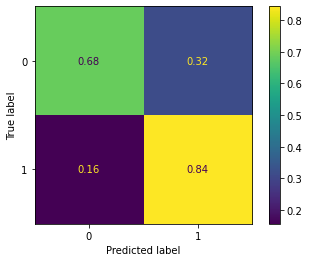

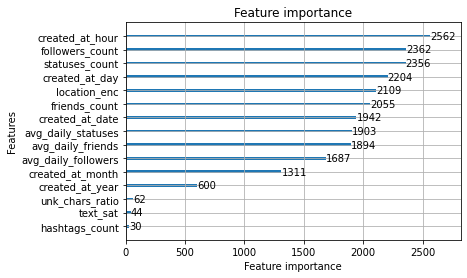

In [20]:
eval_clf(clf_meta, df_test_meta)

### Average probas at the user level

In [21]:
df_train_meta_agg, df_test_meta_agg = get_agg(clf_meta, 
                                              df_train_meta, 
                                              df_test_meta, 
                                              df_train['id'], 
                                              df_test['id'])
clf_meta_agg = get_best_clf(df_train_meta_agg)

[I 2022-03-29 16:15:55,873] A new study created in memory with name: no-name-a2ed3314-8ea2-4fdb-84b8-6e528e3b6fda


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds




[I 2022-03-29 16:15:56,356] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 0.047132036990130445, 'lambda_l2': 0.0011532598248462987, 'num_leaves': 2, 'feature_fraction': 0.8559503124360217, 'bagging_fraction': 0.8668246370979016, 'bagging_freq': 3, 'learning_rate': 0.0017402065647563237, 'min_child_samples': 76}. Best is trial 0 with value: 0.5.
[I 2022-03-29 16:15:56,406] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 3.269560579954963, 'lambda_l2': 9.418697263893797e-05, 'num_leaves': 179, 'feature_fraction': 0.4068946662767028, 'bagging_fraction': 0.5902855770030201, 'bagging_freq': 5, 'learning_rate': 1.2220064764904517e-05, 'min_child_samples': 94}. Best is trial 0 with value: 0.5.
[I 2022-03-29 16:15:56,437] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 2.5581087172523977, 'lambda_l2': 1.549242407187105e-07, 'num_leaves': 249, 'feature_fraction': 0.8085172417885352, 'bagging_fraction': 0.6704931091303714, 'bagging_freq': 2, 'learni

Did not meet early stopping. Best iteration is:
[1]	valid_0's auc: 0.998391
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[47]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:15:56,571] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 2.1446954052839436e-08, 'lambda_l2': 5.595608855821153e-07, 'num_leaves': 181, 'feature_fraction': 0.9736474700830942, 'bagging_fraction': 0.5846653298350426, 'bagging_freq': 1, 'learning_rate': 3.4078883472622826e-05, 'min_child_samples': 18}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:15:56,607] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 0.1608327140555409, 'lambda_l2': 0.02160588852153745, 'num_leaves': 81, 'feature_fraction': 0.5362770227140881, 'bagging_fraction': 0.45865347007808654, 'bagging_freq': 4, 'learning_rate': 0.00020626003121417523, 'min_child_samples': 52}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.999993
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:15:56,778] Trial 5 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 2.789549123462774e-08, 'lambda_l2': 4.722197507707515e-08, 'num_leaves': 218, 'feature_fraction': 0.8168655135702116, 'bagging_fraction': 0.627051342655569, 'bagging_freq': 4, 'learning_rate': 0.05134836333841911, 'min_child_samples': 54}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:15:56,952] Trial 10 finished with value: 0.5 and parameters: {'lambda_l1': 0.6066629941482546, 'lambda_l2': 3.027557895332534, 'num_leaves': 159, 'feature_fraction': 0.43604495876422583, 'bagging_fraction': 0.7494896696938991, 'bagging_freq': 3, 'learning_rate': 4.455417889028544e-05, 'min_child_samples': 42}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.999982
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.999993


[I 2022-03-29 16:15:56,980] Trial 9 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 3.4872192223736495e-05, 'lambda_l2': 7.235594972204729, 'num_leaves': 158, 'feature_fraction': 0.5238670715133142, 'bagging_fraction': 0.8890014706268341, 'bagging_freq': 4, 'learning_rate': 0.004359749798911913, 'min_child_samples': 37}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:15:57,114] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 8.672317542457298e-08, 'lambda_l2': 4.010849475098276e-05, 'num_leaves': 43, 'feature_fraction': 0.5046035793729704, 'bagging_fraction': 0.8032180704886747, 'bagging_freq': 5, 'learning_rate': 7.45556193673056e-05, 'min_child_samples': 65}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.999969
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:15:57,256] Trial 11 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.10354583326512068, 'lambda_l2': 1.6935196084071727e-06, 'num_leaves': 196, 'feature_fraction': 0.5232122804910908, 'bagging_fraction': 0.5557992077624745, 'bagging_freq': 1, 'learning_rate': 0.01169198404186879, 'min_child_samples': 52}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:15:57,390] Trial 14 finished with value: 0.5 and parameters: {'lambda_l1': 2.218923957132612, 'lambda_l2': 0.0005233204281134362, 'num_leaves': 206, 'feature_fraction': 0.8083077591041621, 'bagging_fraction': 0.565552260682838, 'bagging_freq': 6, 'learning_rate': 1.4263570370363272e-05, 'min_child_samples': 21}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.999931


[I 2022-03-29 16:15:57,522] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 3.083403734843118e-05, 'lambda_l2': 1.1811983879621555e-08, 'num_leaves': 202, 'feature_fraction': 0.8820412029246786, 'bagging_fraction': 0.7554069275320487, 'bagging_freq': 4, 'learning_rate': 0.0006069723851324314, 'min_child_samples': 94}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:15:57,653] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 2.6887674691433767e-08, 'lambda_l2': 0.35727095165297845, 'num_leaves': 226, 'feature_fraction': 0.517484640840933, 'bagging_fraction': 0.9981150142905653, 'bagging_freq': 2, 'learning_rate': 0.0005955408626988876, 'min_child_samples': 40}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.999991
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:15:57,794] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 5.307375882128887e-07, 'lambda_l2': 0.002941530040354657, 'num_leaves': 114, 'feature_fraction': 0.7803704456002609, 'bagging_fraction': 0.9824156022883999, 'bagging_freq': 6, 'learning_rate': 1.867949892713079e-05, 'min_child_samples': 72}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[4]	valid_0's auc: 0.999969
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:15:58,017] Trial 16 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.02429408321718144, 'lambda_l2': 0.0993477288544808, 'num_leaves': 150, 'feature_fraction': 0.7138649951894077, 'bagging_fraction': 0.5501812980751237, 'bagging_freq': 4, 'learning_rate': 0.08774600333264863, 'min_child_samples': 42}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.999996


[I 2022-03-29 16:15:58,237] Trial 17 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0004475081557474091, 'lambda_l2': 1.0200603412592478e-05, 'num_leaves': 77, 'feature_fraction': 0.6543889520705131, 'bagging_fraction': 0.4030826915536384, 'bagging_freq': 7, 'learning_rate': 0.22984743209360825, 'min_child_samples': 99}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:15:58,377] Trial 18 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 8.852880760886886e-05, 'lambda_l2': 1.9675176750634975e-06, 'num_leaves': 234, 'feature_fraction': 0.6716654568204478, 'bagging_fraction': 0.9955840439800747, 'bagging_freq': 6, 'learning_rate': 0.15201352222963366, 'min_child_samples': 81}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:15:58,509] Trial 19 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0002475888047254534, 'lambda_l2': 1.9350065704543065e-08, 'num_leaves': 104, 'feature_fraction': 0.6521172119401635, 'bagging_fraction': 0.40300670328071486, 'bagging_freq': 6, 'learning_rate': 0.2292163237634219, 'min_child_samples': 86}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:15:58,638] Trial 20 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0003506725638060328, 'lambda_l2': 1.0919818547010235e-08, 'num_leaves': 110, 'feature_fraction': 0.684348493216978, 'bagging_fraction': 0.41465209531159103, 'bagging_freq': 7, 'learning_rate': 0.26679729046303824, 'min_child_samples': 83}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:15:58,773] Trial 21 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.002367427234249759, 'lambda_l2': 1.9398285442734805e-06, 'num_leaves': 106, 'feature_fraction': 0.6989972687923376, 'bagging_fraction': 0.4059375864061294, 'bagging_freq': 7, 'learning_rate': 0.278163716085394, 'min_child_samples': 75}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:15:58,931] Trial 23 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.004135955786861967, 'lambda_l2': 1.0137047341232302e-05, 'num_leaves': 105, 'feature_fraction': 0.6565612469288359, 'bagging_fraction': 0.4050169441749144, 'bagging_freq': 7, 'learning_rate': 0.2531133619299861, 'min_child_samples': 82}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:15:58,931] Trial 22 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0019863032916106922, 'lambda_l2': 7.935278015097273e-06, 'num_leaves': 108, 'feature_fraction': 0.6866

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:15:59,287] Trial 24 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0059307046220072246, 'lambda_l2': 5.727738954640444e-06, 'num_leaves': 102, 'feature_fraction': 0.6506269621796213, 'bagging_fraction': 0.40203955016224213, 'bagging_freq': 7, 'learning_rate': 0.14064425928328522, 'min_child_samples': 5}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.999996


[I 2022-03-29 16:15:59,502] Trial 26 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.002768937241446321, 'lambda_l2': 6.696975945213364, 'num_leaves': 111, 'feature_fraction': 0.612836306781483, 'bagging_fraction': 0.9040676685863143, 'bagging_freq': 3, 'learning_rate': 0.00964065191421777, 'min_child_samples': 29}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.999996


[I 2022-03-29 16:15:59,678] Trial 25 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0019240924344933249, 'lambda_l2': 7.998992072233578e-06, 'num_leaves': 74, 'feature_fraction': 0.6243410740213013, 'bagging_fraction': 0.40483009268912, 'bagging_freq': 7, 'learning_rate': 0.26578064824298947, 'min_child_samples': 81}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:15:59,853] Trial 29 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.005793651603065204, 'lambda_l2': 1.7228500214984584e-07, 'num_leaves': 62, 'feature_fraction': 0.6126457636588917, 'bagging_fraction': 0.4840921381181507, 'bagging_freq': 7, 'learning_rate': 0.02718566108536064, 'min_child_samples': 88}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.999996Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.999996



[I 2022-03-29 16:15:59,919] Trial 28 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0010702398201317491, 'lambda_l2': 3.488079140443666e-06, 'num_leaves': 36, 'feature_fraction': 0.6048651108431079, 'bagging_fraction': 0.46661934883224293, 'bagging_freq': 7, 'learning_rate': 0.02468670709340245, 'min_child_samples': 82}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 roundsDid not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.999996

Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:00,163] Trial 27 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0033191389850561227, 'lambda_l2': 1.3125131533082812, 'num_leaves': 50, 'feature_fraction': 0.583235065461946, 'bagging_fraction': 0.9029390327481217, 'bagging_freq': 3, 'learning_rate': 0.010074080945249373, 'min_child_samples': 29}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:00,169] Trial 31 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.009039638219077682, 'lambda_l2': 3.1830523709733073e-07, 'num_leaves': 43, 'feature_fraction': 0.5951787865489842, 'bagging_fraction': 0.503812536248948, 'bagging_freq': 2, 'learning_rate': 0.022826386947620105, 'min_child_samples': 66}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:00,188] Trial 30 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.012180424926153835, 'lambda_l2': 3.957794069744884e-07, 'num_leaves': 33, 'feature_fraction': 0.58666390

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:00,558] Trial 32 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.006870435066269297, 'lambda_l2': 1.7490855810231812e-07, 'num_leaves': 44, 'feature_fraction': 0.5943642711932927, 'bagging_fraction': 0.47703922670675797, 'bagging_freq': 5, 'learning_rate': 0.028311571800751625, 'min_child_samples': 7}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:00,742] Trial 33 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.010651393149367283, 'lambda_l2': 1.6389266942884843e-07, 'num_leaves': 39, 'feature_fraction': 0.5974554078012217, 'bagging_fraction': 0.490264782730199, 'bagging_freq': 2, 'learning_rate': 0.026450636482391696, 'min_child_samples': 66}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.999996Training until validation scores don't improve for 100 rounds



[I 2022-03-29 16:16:00,895] Trial 34 finished with value: 0.9986187845303867 and parameters: {'lambda_l1': 0.01226637054921425, 'lambda_l2': 0.006416317281711286, 'num_leaves': 56, 'feature_fraction': 0.5940552442023017, 'bagging_fraction': 0.4832450247283556, 'bagging_freq': 2, 'learning_rate': 0.0197715247203825, 'min_child_samples': 10}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:01,223] Trial 35 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 1.379158297384708e-06, 'lambda_l2': 3.1012323768233667e-07, 'num_leaves': 40, 'feature_fraction': 0.745419110478329, 'bagging_fraction': 0.49027121129393364, 'bagging_freq': 5, 'learning_rate': 0.025610106860296376, 'min_child_samples': 68}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:01,323] Trial 36 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 3.5633473880320663e-06, 'lambda_l2': 1.1690737554668856e-07, 'num_leaves': 25, 'feature_fraction': 0.5820689852214256, 'bagging_fraction': 0.4974389868910574, 'bagging_freq': 5, 'learning_rate': 0.028909069026526134, 'min_child_samples': 69}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:01,669] Trial 39 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0234960210380816, 'lambda_l2': 0.039441233415423715, 'num_leaves': 11, 'feature_fraction': 0.7404673718831595, 'bagging_fraction': 0.5247141317782846, 'bagging_freq': 2, 'learning_rate': 0.05635677218930974, 'min_child_samples': 65}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:01,788] Trial 38 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0320059225704486, 'lambda_l2': 0.008808034459214215, 'num_leaves': 13, 'feature_fraction': 0.759812487807224, 'bagging_fraction': 0.5320580728130392, 'bagging_freq': 2, 'learning_rate': 0.06438077965780185, 'min_child_samples': 68}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:01,886] Trial 37 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 2.4087405161118287e-05, 'lambda_l2': 7.201887740032263e-08, 'num_leaves': 13, 'feature_fraction': 0.7151331105712098, 'bagging_fraction': 0.5293283816919201, 'bagging_freq': 2, 'learning_rate': 0.0712035986719331, 'min_child_samples': 66}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:02,123] Trial 40 finished with value: 0.9987729115784981 and parameters: {'lambda_l1': 0.0375561089388311, 'lambda_l2': 0.04135504860902863, 'num_leaves': 13, 'feature_fraction': 0.7537453529324435, 'bagging_fraction': 0.5414494150522081, 'bagging_freq': 2, 'learning_rate': 0.003906346510883571, 'min_child_samples': 66}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:02,322] Trial 41 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 4.183335870175363e-06, 'lambda_l2': 3.469106261400531e-08, 'num_leaves': 132, 'feature_fraction': 0.743378090467782, 'bagging_fraction': 0.5334824547488148, 'bagging_freq': 6, 'learning_rate': 0.0727460733431067, 'min_child_samples': 88}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:02,422] Trial 42 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 6.035768910295848e-06, 'lambda_l2': 0.0038791683528146058, 'num_leaves': 5, 'feature_fraction': 0.7297144696583935, 'bagging_fraction': 0.43598970545194454, 'bagging_freq': 1, 'learning_rate': 0.004464933241823678, 'min_child_samples': 72}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[47]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.999996Training until validation scores don't improve for 100 rounds



[I 2022-03-29 16:16:02,647] Trial 44 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.414790238304055, 'lambda_l2': 0.007043899504665743, 'num_leaves': 19, 'feature_fraction': 0.7370353533968096, 'bagging_fraction': 0.6389417588306586, 'bagging_freq': 1, 'learning_rate': 0.0031266273563174346, 'min_child_samples': 76}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:02,719] Trial 43 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.3132020173126103, 'lambda_l2': 0.013281999789692727, 'num_leaves': 3, 'feature_fraction': 0.7216864918835422, 'bagging_fraction': 0.4413496587482394, 'bagging_freq': 1, 'learning_rate': 0.004061935409650414, 'min_child_samples': 74}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:03,041] Trial 45 finished with value: 0.5 and parameters: {'lambda_l1': 9.94593189201079, 'lambda_l2': 0.008036305080130483, 'num_leaves': 137, 'feature_fraction': 0.5497571465571603, 'bagging_fraction': 0.6404480829251726, 'bagging_freq': 1, 'learning_rate': 0.0015540289236510314, 'min_child_samples': 90}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:03,222] Trial 46 finished with value: 0.5 and parameters: {'lambda_l1': 0.46728027370084113, 'lambda_l2': 3.201950524147925e-08, 'num_leaves': 136, 'feature_fraction': 0.4760233887655617, 'bagging_fraction': 0.6136974974420791, 'bagging_freq': 1, 'learning_rate': 0.0025025093123923503, 'min_child_samples': 59}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:03,370] Trial 47 finished with value: 0.5 and parameters: {'lambda_l1': 8.614190130386921e-05, 'lambda_l2': 4.944156284114906e-05, 'num_leaves': 134, 'feature_fraction': 0.5559293091128257, 'bagging_fraction': 0.6522183131009729, 'bagging_freq': 1, 'learning_rate': 0.0036177093000734914, 'min_child_samples': 14}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:03,442] Trial 48 finished with value: 0.5 and parameters: {'lambda_l1': 0.3964316002993719, 'lambda_l2': 0.0024752347031770116, 'num_leaves': 90, 'feature_fraction': 0.5546091237159698, 'bagging_fraction': 0.6018334786792207, 'bagging_freq': 1, 'learning_rate': 0.005114081399788677, 'min_child_samples': 5}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:03,664] Trial 49 finished with value: 0.5 and parameters: {'lambda_l1': 0.2836496883474034, 'lambda_l2': 4.797217669480974e-05, 'num_leaves': 91, 'feature_fraction': 0.885666167119357, 'bagging_fraction': 0.6304942168374805, 'bagging_freq': 1, 'learning_rate': 0.0038217497734539, 'min_child_samples': 7}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:03,696] Trial 50 finished with value: 0.5 and parameters: {'lambda_l1': 0.34882702984067726, 'lambda_l2': 0.0001305075593911877, 'num_leaves': 87, 'feature_fraction': 0.5522337880037177, 'bagging_fraction': 0.6249521548211209, 'b

Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:03,923] Trial 51 finished with value: 0.5 and parameters: {'lambda_l1': 0.20259864871167277, 'lambda_l2': 0.0003070199161350775, 'num_leaves': 86, 'feature_fraction': 0.4786547830795507, 'bagging_fraction': 0.5944711390117866, 'bagging_freq': 3, 'learning_rate': 0.0010887232150832663, 'min_child_samples': 59}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:03,978] Trial 52 finished with value: 0.5 and parameters: {'lambda_l1': 7.189398519704387, 'lambda_l2': 0.00014049472794450935, 'num_leaves': 83, 'feature_fraction': 0.8936034986494237, 'bagging_fraction': 0.6022117258403688, 'bagging_freq': 3, 'learning_rate': 0.0012573850432233925, 'min_child_samples': 12}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:04,235] Trial 53 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.1391460837414198, 'lambda_l2': 8.252184073693952e-05, 'num_leaves': 65, 'feature_fraction': 0.47726989810284803, 'bagging_fraction': 0.4452649392686079, 'bagging_freq': 3, 'learning_rate': 0.0027009868446448856, 'min_child_samples': 78}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:04,390] Trial 54 finished with value: 0.5 and parameters: {'lambda_l1': 0.07814288014627761, 'lambda_l2': 0.00013606516230428898, 'num_leaves': 91, 'feature_fraction': 0.6416685691491908, 'bagging_fraction': 0.5986182693482808, 'bagging_freq': 3, 'learning_rate': 0.000698063333383203, 'min_child_samples': 48}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.999987
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 16:16:04,554] Trial 55 finished with value: 0.5 and parameters: {'lambda_l1': 0.14716442107472905, 'lambda_l2': 0.0009899780974505707, 'num_leaves': 90, 'feature_fraction': 0.8610594162037313, 'bagging_fraction': 0.580129813213256, 'bagging_freq': 3, 'learning_rate': 0.0006955262233411142, 'min_child_samples': 48}. Best is trial 6 with value: 0.9987729115784981.



Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.999987
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:04,721] Trial 56 finished with value: 0.5 and parameters: {'lambda_l1': 0.0783576780873239, 'lambda_l2': 0.00018115889438879054, 'num_leaves': 60, 'feature_fraction': 0.8391160982533628, 'bagging_fraction': 0.42906407946531677, 'bagging_freq': 3, 'learning_rate': 0.0008741973498745304, 'min_child_samples': 49}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:04,897] Trial 57 finished with value: 0.5 and parameters: {'lambda_l1': 1.8117083171030346, 'lambda_l2': 0.00021943145361262326, 'num_leaves': 67, 'feature_fraction': 0.6914387491764101, 'bagging_fraction': 0.436306584632291, 'bagging_freq': 3, 'learning_rate': 0.0006251222466620964, 'min_child_samples': 60}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:05,024] Trial 58 finished with value: 0.5 and parameters: {'lambda_l1': 0.06809113122440691, 'lambda_l2': 0.0006472049218569713, 'num_leaves': 66, 'feature_fraction': 0.6911181944841729, 'bagging_fraction': 0.44487475015

Training until validation scores don't improve for 100 roundsDid not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.999996

Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.999993
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:05,213] Trial 59 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.07157906250613552, 'lambda_l2': 1.007984763040668e-05, 'num_leaves': 62, 'feature_fraction': 0.6331722655875309, 'bagging_fraction': 0.7387600396699235, 'bagging_freq': 3, 'learning_rate': 0.008252434063119474, 'min_child_samples': 48}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:05,354] Trial 60 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.09512089856707767, 'lambda_l2': 0.08925239681614676, 'num_leaves': 122, 'feature_fraction': 0.6432875217624003, 'bagging_fraction': 0.7012928710742637, 'bagging_freq': 3, 'learning_rate': 0.007326650332489889, 'min_child_samples': 47}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:05,361] Trial 61 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.05560202064571607, 'lambda_l2': 1.3233583275457645, 'num_leaves': 55, 'feature_fraction': 0.6321995757172376, 'bagging_fraction': 0.8913662169009933, 'bagging_freq': 3, 'learning_rate': 0.007932021090065819, 'min_child_samples': 28}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:05,610] Trial 62 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 1.4725708930823411, 'lambda_l2': 1.7204152942543938e-05, 'num_leaves': 70, 'feature_fraction': 0.6339322887759885, 'bagging_fraction': 0.4222331813979704, 'bagging_freq': 7, 'learning_rate': 0.10487154223734046, 'min_child_samples': 20}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:05,829] Trial 63 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0008062237184286017, 'lambda_l2': 2.2293089399646077e-05, 'num_leaves': 61, 'feature_fraction': 0.6379926922924366, 'bagging_fraction': 0.41902405802565945, 'bagging_freq': 6, 'learning_rate': 0.12930612205649447, 'min_child_samples': 19}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:05,913] Trial 64 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0005497771268600056, 'lambda_l2': 9.476393123364064e-07, 'num_leaves': 71, 'feature_fraction': 0.6322

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:06,139] Trial 65 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0007859916047545007, 'lambda_l2': 1.02231753138269e-06, 'num_leaves': 25, 'feature_fraction': 0.6274882913738238, 'bagging_fraction': 0.46902658750325726, 'bagging_freq': 7, 'learning_rate': 0.007593745072200473, 'min_child_samples': 25}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:06,205] Trial 66 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0009184579583360826, 'lambda_l2': 0.2311954712810221, 'num_leaves': 76, 'feature_fraction': 0.6178942927827175, 'bagging_fraction': 0.8272459428995871, 'bagging_freq': 4, 'learning_rate': 0.1206540208773134, 'min_child_samples': 23}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:06,541] Trial 67 finished with value: 0.9986187845303867 and parameters: {'lambda_l1': 1.1482714239828196, 'lambda_l2': 1.148926531564119, 'num_leaves': 53, 'feature_fraction': 0.618474708838952, 'bagging_fraction': 0.9160251270209405, 'bagging_freq': 4, 'learning_rate': 0.006961957693380516, 'min_child_samples': 20}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:06,713] Trial 68 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0009576661705237095, 'lambda_l2': 8.075719544457337e-07, 'num_leaves': 29, 'feature_fraction': 0.5727635400552364, 'bagging_fraction': 0.4685456657618081, 'bagging_freq': 2, 'learning_rate': 0.014238216344598594, 'min_child_samples': 19}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:06,835] Trial 69 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0008679885166691494, 'lambda_l2': 6.72861336765103e-07, 'num_leaves': 22, 'feature_fraction': 0.5837605941652185, 'bagging_fraction': 0.4773553242707348, 'bagging_freq': 2, 'learning_rate': 0.01659842301440859, 'min_child_samples': 31}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:06,952] Trial 70 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0007965974132224172, 'lambda_l2': 8.7284973827094e-07, 'num_leaves': 27, 'feature_fraction': 0.5743906262793449, 'bagging_fraction': 0.5098844844240138, 'bagging_freq': 2, 'learning_rate': 0.015829270215593282, 'min_child_samples': 93}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:07,135] Trial 71 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.011033596210171281, 'lambda_l2': 6.465495265532438e-07, 'num_leaves': 30, 'feature_fraction': 0.6065887

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:07,239] Trial 72 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.013012628560860355, 'lambda_l2': 8.185352697012029e-07, 'num_leaves': 33, 'feature_fraction': 0.605739607227982, 'bagging_fraction': 0.4627861984321683, 'bagging_freq': 2, 'learning_rate': 0.01786710177897176, 'min_child_samples': 94}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:07,470] Trial 74 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.01079234337091367, 'lambda_l2': 4.248820610073077e-07, 'num_leaves': 31, 'feature_fraction': 0.5874189011708493, 'bagging_fraction': 0.5064484779737115, 'bagging_freq': 2, 'learning_rate': 0.03970641673842526, 'min_child_samples': 63}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:07,522] Trial 73 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.01452052406609604, 'lambda_l2': 5.526666816478346e-07, 'num_leaves': 28, 'feature_fraction': 0.570323362076878, 'bagging_fraction': 0.5030410677400876, 'bagging_freq': 2, 'learning_rate': 0.015350750899176719, 'min_child_samples': 55}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:07,671] Trial 75 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.015835340839927624, 'lambda_l2': 4.1313619741754434e-07, 'num_leaves': 31, 'feature_fraction': 0.5945215272310816, 'bagging_fraction': 0.5071604182748741, 'bagging_freq': 2, 'learning_rate': 0.01264058956441061, 'min_child_samples': 63}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:07,980] Trial 76 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.01218467915558354, 'lambda_l2': 2.573460713961596e-07, 'num_leaves': 46, 'feature_fraction': 0.5886366253911601, 'bagging_fraction': 0.5637933746528696, 'bagging_freq': 2, 'learning_rate': 0.03819663206797687, 'min_child_samples': 15}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:08,135] Trial 77 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.009129225134738649, 'lambda_l2': 9.263682869652191e-08, 'num_leaves': 46, 'feature_fraction': 0.5125076669806675, 'bagging_fraction': 0.557919763083315, 'bagging_freq': 5, 'learning_rate': 0.041751363454748655, 'min_child_samples': 63}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:08,245] Trial 78 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.010155821489373645, 'lambda_l2': 3.038738702735814e-07, 'num_leaves': 42, 'feature_fraction': 0.7859630195281445, 'bagging_fraction': 0.5482185558798993, 'bagging_freq': 5, 'learning_rate': 0.03144843097208835, 'min_child_samples': 62}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:08,335] Trial 79 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.7941516921916012, 'lambda_l2': 2.3042508124484705e-07, 'num_leaves': 43, 'feature_fraction': 0.6701141057820814, 'bagging_fraction': 0.5546852337359849, 'bagging_freq': 5, 'learning_rate': 0.03205373024276112, 'min_child_samples': 72}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:08,618] Trial 80 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 1.3251613972706093e-06, 'lambda_l2': 9.122774739882034e-08, 'num_leaves': 44, 'feature_fraction': 0.7722440367394355, 'bagging_fraction': 0.5504092890066752, 'bagging_freq': 5, 'learning_rate': 0.040175751489213235, 'min_child_samples': 70}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:08,840] Trial 81 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 1.8567798361517633e-07, 'lambda_l2': 7.20024690242523e-08, 'num_leaves': 41, 'feature_fraction': 0.7862215143047221, 'bagging_fraction': 0.5480748739464576, 'bagging_freq': 5, 'learning_rate': 0.038500945718545385, 'min_child_samples': 70}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:08,989] Trial 82 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 1.061857160106795e-06, 'lambda_l2': 8.480768492442166e-08, 'num_leaves': 48, 'feature_fraction': 0.7693833169399265, 'bagging_fraction': 0.5606633738260453, 'bagging_freq': 5, 'learning_rate': 0.04059774167840875, 'min_child_samples': 70}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:09,103] Trial 83 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 6.650673522168367e-07, 'lambda_l2': 8.067899767997741e-08, 'num_leaves': 16, 'feature_fraction': 0.7632863752589353, 'bagging_fraction': 0.5474324979126511, 'bagging_freq': 5, 'learning_rate': 0.037850611852905405, 'min_child_samples': 68}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:09,272] Trial 84 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 3.9170705697911187e-07, 'lambda_l2': 5.489412882558339e-08, 'num_leaves': 14, 'feature_fraction': 0.7540263046935741, 'bagging_fraction': 0.5386386620423201, 'bagging_freq': 4, 'learning_rate': 0.06827310930406166, 'min_child_samples': 72}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 16:16:09,402] Trial 85 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 1.1096782543168253, 'lambda_l2': 0.028926007861589657, 'num_leaves': 15, 'feature_fraction': 0.6677616719487834, 'bagging_fraction': 0.6972954349516569, 'bagging_freq': 4, 'learning_rate': 0.002035977564842931, 'min_child_samples': 44}. Best is trial 6 with value: 0.9987729115784981.



Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:09,554] Trial 86 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 1.0791284991097307, 'lambda_l2': 0.02270289510530436, 'num_leaves': 6, 'feature_fraction': 0.6618140766827314, 'bagging_fraction': 0.7091008500846577, 'bagging_freq': 4, 'learning_rate': 0.006112310041034235, 'min_child_samples': 39}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:09,619] Trial 87 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.9109671151241646, 'lambda_l2': 0.08066906234396075, 'num_leaves': 181, 'feature_fraction': 0.416250365300038, 'bagging_fraction': 0.7093176206096343, 'bagging_freq': 4, 'learning_rate': 0.006115320833258638, 'min_child_samples': 70}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:10,005] Trial 88 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.029363885921397024, 'lambda_l2': 1.7160962933088452e-08, 'num_leaves': 11, 'feature_fraction': 0.7601820086043701, 'bagging_fraction': 0.5306246315031063, 'bagging_freq': 2, 'learning_rate': 0.07121777174508799, 'min_child_samples': 68}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:10,258] Trial 89 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.0288941440402863, 'lambda_l2': 0.02939278502234856, 'num_leaves': 12, 'feature_fraction': 0.7528571792528664, 'bagging_fraction': 0.5295273974671972, 'bagging_freq': 2, 'learning_rate': 0.06168593576664043, 'min_child_samples': 38}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:10,420] Trial 90 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.9976943881840432, 'lambda_l2': 1.9755978267015148, 'num_leaves': 56, 'feature_fraction': 0.4204079016554379, 'bagging_fraction': 0.7075300796726026, 'bagging_freq': 6, 'learning_rate': 0.005961016310957779, 'min_child_samples': 34}. Best is trial 6 with value: 0.9987729115784981.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[55]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.999991
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:10,571] Trial 91 finished with value: 0.5 and parameters: {'lambda_l1': 1.3311152368782369, 'lambda_l2': 1.0344546234770293, 'num_leaves': 122, 'feature_fraction': 0.6680074041784774, 'bagging_fraction': 0.9518974310765357, 'bagging_freq': 6, 'learning_rate': 0.005774201469997602, 'min_child_samples': 37}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:10,703] Trial 92 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.028762972408502247, 'lambda_l2': 0.016975825073921525, 'num_leaves': 4, 'feature_fraction': 0.7125139981664314, 'bagging_fraction': 0.535040125772431, 'bagging_freq': 6, 'learning_rate': 0.006318557809260316, 'min_child_samples': 35}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.999996
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:10,914] Trial 93 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.032451919054365896, 'lambda_l2': 1.2728235120757927, 'num_leaves': 55, 'feature_fraction': 0.64171507023566, 'bagging_fraction': 0.9635432010202225, 'bagging_freq': 6, 'learning_rate': 0.12969563285892058, 'min_child_samples': 23}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:10,975] Trial 95 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.00014700384430042665, 'lambda_l2': 0.47866750229057276, 'num_leaves': 53, 'feature_fraction': 0.7143915789366552, 'bagging_fraction': 0.8204706418432663, 'bagging_freq': 6, 'learning_rate': 0.09706585222971198, 'min_child_samples': 25}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:10,994] Trial 94 finished with value: 0.5 and parameters: {'lambda_l1': 0.0001551452241336328, 'lambda_l2': 1.9321592954252468e-05, 'num_leaves': 98, 'feature_fraction': 0.7136294061867817, 'baggin

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.999996
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.999996


[I 2022-03-29 16:16:11,094] Trial 98 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 0.033891460460645506, 'lambda_l2': 0.5528590549467655, 'num_leaves': 148, 'feature_fraction': 0.7341584333203744, 'bagging_fraction': 0.5758105575563587, 'bagging_freq': 2, 'learning_rate': 0.054019549482356995, 'min_child_samples': 85}. Best is trial 6 with value: 0.9987729115784981.
[I 2022-03-29 16:16:11,096] Trial 99 finished with value: 0.9983905579399142 and parameters: {'lambda_l1': 7.623518318374951e-06, 'lambda_l2': 3.013224758647144e-08, 'num_leaves': 3, 'feature_fraction': 0.7185139613711496, 'bagging_fraction': 0.5812826819062455, 'bagging_freq': 2, 'learning_rate': 0.10296058104296375, 'min_child_samples': 57}. Best is trial 6 with value: 0.9987729115784981.


Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.999996
{'lambda_l1': 0.49005216456352857, 'lambda_l2': 2.4456373692987086e-08, 'num_leaves': 26, 'feature_fraction': 0.6258235200383659, 'bagging_fraction': 0.520540331030041, 'bagging_freq': 2, 'learning_rate': 0.004346587298686865, 'min_child_samples': 71} -> 0.9987729115784981
[LightGBM] [Warning] feature_fraction is set=0.6258235200383659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258235200383659
[LightGBM] [Warning] lambda_l1 is set=0.49005216456352857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49005216456352857
[LightGBM] [Warning] bagging_fraction is set=0.520540331030041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.520540331030041
[LightGBM] [Warning] lambda_l2 is set=2.4456373692987086e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4456373692987086e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be igno

AUROC: 0.7458333333333333
Accuracy: 0.7523245984784447


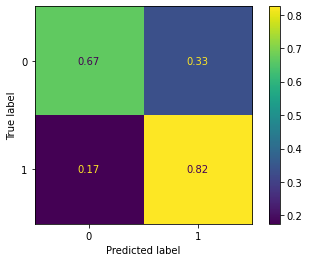

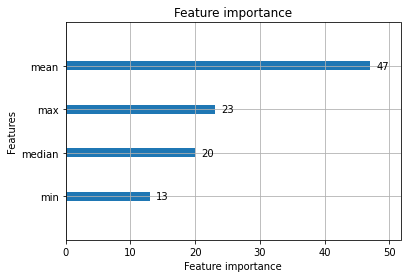

In [22]:
eval_clf(clf_meta_agg, df_test_meta_agg)

### Average features at the user level

> Mean

In [23]:
df_train_meta_mean = get_mean(df_train_meta, df_train['id'])
df_test_meta_mean = get_mean(df_test_meta, df_test['id'])

clf_meta_mean = get_best_clf(df_train_meta_mean)

[I 2022-03-29 16:16:13,035] A new study created in memory with name: no-name-515b9755-f7e1-4839-9fdf-bf28c9294583


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:14,815] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 0.008288106539320144, 'lambda_l2': 0.7366050692853028, 'num_leaves': 204, 'feature_fraction': 0.7228284492330626, 'bagging_fraction': 0.4927781216104881, 'bagging_freq': 3, 'learning_rate': 3.845836278747549e-05, 'min_child_samples': 58}. Best is trial 3 with value: 0.5.
[I 2022-03-29 16:16:14,963] Trial 0 finished with value: 0.7686553007848622 and parameters: {'lambda_l1': 2.5125129879608923, 'lambda_l2': 7.023217405688871e-06, 'num_leaves': 99, 'feature_fraction': 0.8894927011484836, 'bagging_fraction': 0.40087514606580715, 'bagging_freq': 5, 'learning_rate': 0.12626682125950442, 'min_child_samples': 42}. Best is trial 0 with value: 0.7686553007848622.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.850497
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.852246


[I 2022-03-29 16:16:15,026] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 1.4495482208137523e-07, 'lambda_l2': 0.003099471876230137, 'num_leaves': 76, 'feature_fraction': 0.7427399611057668, 'bagging_fraction': 0.7161534446149436, 'bagging_freq': 4, 'learning_rate': 0.00012649606351627465, 'min_child_samples': 86}. Best is trial 0 with value: 0.7686553007848622.
[I 2022-03-29 16:16:15,108] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 1.771413633604891, 'lambda_l2': 0.7306026742905877, 'num_leaves': 130, 'feature_fraction': 0.6700979313004404, 'bagging_fraction': 0.4243871409191348, 'bagging_freq': 6, 'learning_rate': 0.002550960281480447, 'min_child_samples': 28}. Best is trial 0 with value: 0.7686553007848622.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.848893
Did not meet early stopping. Best iteration is:
[47]	valid_0's auc: 0.855044
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:15,298] Trial 5 finished with value: 0.7534560026557275 and parameters: {'lambda_l1': 0.0032731772006073757, 'lambda_l2': 1.150909286351143, 'num_leaves': 78, 'feature_fraction': 0.8517425604732265, 'bagging_fraction': 0.5820362302107911, 'bagging_freq': 4, 'learning_rate': 0.019464310389991107, 'min_child_samples': 71}. Best is trial 0 with value: 0.7686553007848622.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.856201
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:15,737] Trial 1 finished with value: 0.7805438313612975 and parameters: {'lambda_l1': 3.5110715927405115e-05, 'lambda_l2': 1.1281154760950158e-05, 'num_leaves': 54, 'feature_fraction': 0.7620947590248921, 'bagging_fraction': 0.852432278287327, 'bagging_freq': 5, 'learning_rate': 0.07400624891462314, 'min_child_samples': 67}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.860804
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:16,784] Trial 10 finished with value: 0.7764802124582079 and parameters: {'lambda_l1': 0.5952680887024194, 'lambda_l2': 0.933677105983477, 'num_leaves': 133, 'feature_fraction': 0.839935524572039, 'bagging_fraction': 0.4926111154676852, 'bagging_freq': 7, 'learning_rate': 0.10974252616949143, 'min_child_samples': 71}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.860883
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:17,245] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 0.002756623333309769, 'lambda_l2': 1.2076313193232244, 'num_leaves': 140, 'feature_fraction': 0.563360540328051, 'bagging_fraction': 0.4425698550088561, 'bagging_freq': 1, 'learning_rate': 0.0001423679877782028, 'min_child_samples': 52}. Best is trial 1 with value: 0.7805438313612975.
[I 2022-03-29 16:16:17,281] Trial 12 finished with value: 0.7632045384487706 and parameters: {'lambda_l1': 5.069854609344254e-08, 'lambda_l2': 5.450439873345356e-06, 'num_leaves': 229, 'feature_fraction': 0.8781401626350919, 'bagging_fraction': 0.6624732462568632, 'bagging_freq': 6, 'learning_rate': 0.2429827826460981, 'min_child_samples': 89}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.847097
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.855114
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:17,659] Trial 13 finished with value: 0.7417779147795984 and parameters: {'lambda_l1': 6.584280415746022e-07, 'lambda_l2': 2.297552923593242, 'num_leaves': 81, 'feature_fraction': 0.9845214410799071, 'bagging_fraction': 0.5188710154816415, 'bagging_freq': 2, 'learning_rate': 0.009456964357708528, 'min_child_samples': 59}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.852752
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:18,127] Trial 17 finished with value: 0.5 and parameters: {'lambda_l1': 1.2281159841867227e-05, 'lambda_l2': 2.8289379858839033e-08, 'num_leaves': 3, 'feature_fraction': 0.4160823608694472, 'bagging_fraction': 0.9144269724207045, 'bagging_freq': 7, 'learning_rate': 0.0009142236336326307, 'min_child_samples': 13}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.786461
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:18,889] Trial 4 finished with value: 0.5855612595736609 and parameters: {'lambda_l1': 0.04968149211461442, 'lambda_l2': 1.9120667930149108e-07, 'num_leaves': 156, 'feature_fraction': 0.46813953023368937, 'bagging_fraction': 0.588581607467375, 'bagging_freq': 5, 'learning_rate': 0.0018012434971331247, 'min_child_samples': 21}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.84955


[I 2022-03-29 16:16:19,131] Trial 18 finished with value: 0.7572113674625945 and parameters: {'lambda_l1': 5.4055526679107665e-05, 'lambda_l2': 0.0024668271819201673, 'num_leaves': 10, 'feature_fraction': 0.7921053689041697, 'bagging_fraction': 0.8610932472461286, 'bagging_freq': 7, 'learning_rate': 0.044452472704872376, 'min_child_samples': 77}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.855774


[I 2022-03-29 16:16:19,314] Trial 8 finished with value: 0.7589008370284306 and parameters: {'lambda_l1': 0.20892644241403246, 'lambda_l2': 0.014016291696864315, 'num_leaves': 231, 'feature_fraction': 0.9200156072442294, 'bagging_fraction': 0.42370240773331574, 'bagging_freq': 4, 'learning_rate': 0.019138815791883926, 'min_child_samples': 20}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.85229
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:20,008] Trial 14 finished with value: 0.5 and parameters: {'lambda_l1': 0.016049787984379428, 'lambda_l2': 0.0015413404446411516, 'num_leaves': 162, 'feature_fraction': 0.7939945968815871, 'bagging_fraction': 0.9199247761906645, 'bagging_freq': 2, 'learning_rate': 0.0006726176967396753, 'min_child_samples': 72}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.850957
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.852665


[I 2022-03-29 16:16:20,187] Trial 15 finished with value: 0.7463720864059944 and parameters: {'lambda_l1': 6.823254375441789e-07, 'lambda_l2': 0.3622087580520194, 'num_leaves': 50, 'feature_fraction': 0.5815142584850017, 'bagging_fraction': 0.715018349768322, 'bagging_freq': 3, 'learning_rate': 0.008807035656785166, 'min_child_samples': 30}. Best is trial 1 with value: 0.7805438313612975.
[I 2022-03-29 16:16:20,386] Trial 19 finished with value: 0.7583643563417353 and parameters: {'lambda_l1': 1.862943050703384e-05, 'lambda_l2': 0.0017359178264209527, 'num_leaves': 15, 'feature_fraction': 0.8052265391948319, 'bagging_fraction': 0.8908213946716619, 'bagging_freq': 7, 'learning_rate': 0.03587935651935147, 'min_child_samples': 75}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.856383


[I 2022-03-29 16:16:20,553] Trial 9 finished with value: 0.7709494226163659 and parameters: {'lambda_l1': 2.0611929130537244e-08, 'lambda_l2': 0.006778783054450939, 'num_leaves': 97, 'feature_fraction': 0.7408345477717222, 'bagging_fraction': 0.988874947760992, 'bagging_freq': 7, 'learning_rate': 0.02966600436123234, 'min_child_samples': 9}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.855589
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.845162
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:20,689] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 0.00035065733887107913, 'lambda_l2': 2.520183546671353e-05, 'num_leaves': 129, 'feature_fraction': 0.44544416896634165, 'bagging_fraction': 0.9155872688558438, 'bagging_freq': 5, 'learning_rate': 0.0003282564992883533, 'min_child_samples': 73}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.857099


[I 2022-03-29 16:16:21,072] Trial 7 finished with value: 0.7659610414246081 and parameters: {'lambda_l1': 2.9368347108936575e-05, 'lambda_l2': 2.5933248725397436e-06, 'num_leaves': 155, 'feature_fraction': 0.8565858795383823, 'bagging_fraction': 0.6471436789467682, 'bagging_freq': 3, 'learning_rate': 0.015978076646886726, 'min_child_samples': 8}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:21,729] Trial 20 finished with value: 0.7750989969885945 and parameters: {'lambda_l1': 7.1369515945658315e-06, 'lambda_l2': 7.885100151294595e-05, 'num_leaves': 177, 'feature_fraction': 0.6419240514681508, 'bagging_fraction': 0.7918704196265011, 'bagging_freq': 6, 'learning_rate': 0.07733244770868677, 'min_child_samples': 98}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.857649


[I 2022-03-29 16:16:22,033] Trial 21 finished with value: 0.7717941573992839 and parameters: {'lambda_l1': 1.1591094760497939e-05, 'lambda_l2': 4.8265059677544495e-05, 'num_leaves': 42, 'feature_fraction': 0.6085154394527582, 'bagging_fraction': 0.8008790379681829, 'bagging_freq': 6, 'learning_rate': 0.06455946222218635, 'min_child_samples': 71}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.858671
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:22,671] Trial 23 finished with value: 0.7737177815189813 and parameters: {'lambda_l1': 0.00025750291639396744, 'lambda_l2': 3.643530266299208e-05, 'num_leaves': 182, 'feature_fraction': 0.6581096060336757, 'bagging_fraction': 0.7820028489512292, 'bagging_freq': 6, 'learning_rate': 0.09019023530304415, 'min_child_samples': 98}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.858251


[I 2022-03-29 16:16:22,926] Trial 24 finished with value: 0.7715659308088113 and parameters: {'lambda_l1': 0.0001776377398808624, 'lambda_l2': 6.84269857032047e-06, 'num_leaves': 181, 'feature_fraction': 0.6413973172668485, 'bagging_fraction': 0.7990404330577531, 'bagging_freq': 6, 'learning_rate': 0.1081653742954536, 'min_child_samples': 100}. Best is trial 1 with value: 0.7805438313612975.
[I 2022-03-29 16:16:23,048] Trial 22 finished with value: 0.7804638038555474 and parameters: {'lambda_l1': 0.0001851193845459468, 'lambda_l2': 6.977251438475842e-05, 'num_leaves': 43, 'feature_fraction': 0.6315437633955723, 'bagging_fraction': 0.8000386400598009, 'bagging_freq': 6, 'learning_rate': 0.06305509906024306, 'min_child_samples': 44}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's auc: 0.857427
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.858446
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.853099
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.860619


[I 2022-03-29 16:16:23,132] Trial 25 finished with value: 0.7596774002323763 and parameters: {'lambda_l1': 0.000149569336969086, 'lambda_l2': 2.245029428469461e-05, 'num_leaves': 184, 'feature_fraction': 0.611558581631903, 'bagging_fraction': 0.7948281388876866, 'bagging_freq': 6, 'learning_rate': 0.1033194738476878, 'min_child_samples': 100}. Best is trial 1 with value: 0.7805438313612975.
[I 2022-03-29 16:16:23,232] Trial 26 finished with value: 0.7776272733739596 and parameters: {'lambda_l1': 9.400462602768188, 'lambda_l2': 0.00014196087715769747, 'num_leaves': 44, 'feature_fraction': 0.6374111402280667, 'bagging_fraction': 0.7674992349229569, 'bagging_freq': 6, 'learning_rate': 0.13806502061092882, 'min_child_samples': 43}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:23,524] Trial 27 finished with value: 0.7698023617006141 and parameters: {'lambda_l1': 0.000404036314064827, 'lambda_l2': 0.00010934049016297978, 'num_leaves': 44, 'feature_fraction': 0.6583069561939884, 'bagging_fraction': 0.8065671239408198, 'bagging_freq': 6, 'learning_rate': 0.10198158912368631, 'min_child_samples': 97}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.858591
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:24,074] Trial 28 finished with value: 0.7631245109430204 and parameters: {'lambda_l1': 0.00038139200553948454, 'lambda_l2': 8.650079121046547e-05, 'num_leaves': 186, 'feature_fraction': 0.6718968309685657, 'bagging_fraction': 0.7880879898287807, 'bagging_freq': 6, 'learning_rate': 0.08229283288362116, 'min_child_samples': 99}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.85511


[I 2022-03-29 16:16:24,341] Trial 29 finished with value: 0.7687294003272236 and parameters: {'lambda_l1': 0.00029193615501766734, 'lambda_l2': 0.0002237961733728588, 'num_leaves': 188, 'feature_fraction': 0.6537331128238422, 'bagging_fraction': 0.7789999820754855, 'bagging_freq': 6, 'learning_rate': 0.24319400129897162, 'min_child_samples': 98}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.854039
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:25,019] Trial 30 finished with value: 0.770190643302587 and parameters: {'lambda_l1': 1.1332541182319877e-06, 'lambda_l2': 5.848856451713962e-07, 'num_leaves': 191, 'feature_fraction': 0.5027945763910355, 'bagging_fraction': 0.7957136283544475, 'bagging_freq': 5, 'learning_rate': 0.29131695149663567, 'min_child_samples': 92}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.851789
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.843236


[I 2022-03-29 16:16:25,213] Trial 34 finished with value: 0.7034506674886776 and parameters: {'lambda_l1': 8.419935772452341, 'lambda_l2': 0.0003533667212447926, 'num_leaves': 38, 'feature_fraction': 0.5161268838953487, 'bagging_fraction': 0.8407312706245853, 'bagging_freq': 5, 'learning_rate': 0.004254029668997677, 'min_child_samples': 43}. Best is trial 1 with value: 0.7805438313612975.
[I 2022-03-29 16:16:25,339] Trial 35 finished with value: 0.76213157707538 and parameters: {'lambda_l1': 7.585801063625614, 'lambda_l2': 6.843636649734933e-07, 'num_leaves': 28, 'feature_fraction': 0.5123237250799698, 'bagging_fraction': 0.742511159457065, 'bagging_freq': 5, 'learning_rate': 0.23846361001082197, 'min_child_samples': 45}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.852786
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.850612


[I 2022-03-29 16:16:25,474] Trial 31 finished with value: 0.7666635050861927 and parameters: {'lambda_l1': 1.4171420513792433e-06, 'lambda_l2': 0.0002412260568698921, 'num_leaves': 110, 'feature_fraction': 0.5218822597009205, 'bagging_fraction': 0.7548284013051175, 'bagging_freq': 5, 'learning_rate': 0.2215090259725076, 'min_child_samples': 84}. Best is trial 1 with value: 0.7805438313612975.
[I 2022-03-29 16:16:25,623] Trial 32 finished with value: 0.7650481350627178 and parameters: {'lambda_l1': 0.0012778819075359733, 'lambda_l2': 0.03103069876812527, 'num_leaves': 41, 'feature_fraction': 0.5246359367305462, 'bagging_fraction': 0.8390830330901131, 'bagging_freq': 5, 'learning_rate': 0.2223512600843981, 'min_child_samples': 44}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.846633
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:25,828] Trial 33 finished with value: 0.7207217888222321 and parameters: {'lambda_l1': 0.0011094645594046824, 'lambda_l2': 0.050717298751220906, 'num_leaves': 42, 'feature_fraction': 0.5037413752153538, 'bagging_fraction': 0.8368058052036754, 'bagging_freq': 5, 'learning_rate': 0.004155641061194031, 'min_child_samples': 43}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.849671
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.848031


[I 2022-03-29 16:16:26,202] Trial 37 finished with value: 0.7157334076304744 and parameters: {'lambda_l1': 2.1163561936598094e-06, 'lambda_l2': 4.416386865141688e-07, 'num_leaves': 28, 'feature_fraction': 0.5282808566858371, 'bagging_fraction': 0.9799548016529663, 'bagging_freq': 5, 'learning_rate': 0.004437317082063634, 'min_child_samples': 44}. Best is trial 1 with value: 0.7805438313612975.
[I 2022-03-29 16:16:26,339] Trial 36 finished with value: 0.7708812510373936 and parameters: {'lambda_l1': 5.6062547721181275, 'lambda_l2': 0.0004271983400758337, 'num_leaves': 34, 'feature_fraction': 0.5354557373835889, 'bagging_fraction': 0.9738682809969357, 'bagging_freq': 5, 'learning_rate': 0.277972233246294, 'min_child_samples': 40}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.858526
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:27,014] Trial 38 finished with value: 0.7191182747255352 and parameters: {'lambda_l1': 9.755237630086603, 'lambda_l2': 0.09414430836810404, 'num_leaves': 109, 'feature_fraction': 0.5384168987455074, 'bagging_fraction': 0.8491036756129658, 'bagging_freq': 5, 'learning_rate': 0.006681349909203177, 'min_child_samples': 43}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.84356
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:28,000] Trial 41 finished with value: 0.7426107936357385 and parameters: {'lambda_l1': 0.6564904146717153, 'lambda_l2': 0.04958501670491169, 'num_leaves': 59, 'feature_fraction': 0.7098817191514397, 'bagging_fraction': 0.6519112728717241, 'bagging_freq': 7, 'learning_rate': 0.006771831331272152, 'min_child_samples': 59}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.85218
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.851137


[I 2022-03-29 16:16:28,149] Trial 40 finished with value: 0.7416919593104593 and parameters: {'lambda_l1': 0.8048410407380755, 'lambda_l2': 0.05897112336910345, 'num_leaves': 63, 'feature_fraction': 0.7202349322115961, 'bagging_fraction': 0.6748143958008741, 'bagging_freq': 7, 'learning_rate': 0.007237244091376341, 'min_child_samples': 58}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.85871


[I 2022-03-29 16:16:28,445] Trial 42 finished with value: 0.769345908519669 and parameters: {'lambda_l1': 0.2781663489395621, 'lambda_l2': 0.15658319089327566, 'num_leaves': 62, 'feature_fraction': 0.7613424503157988, 'bagging_fraction': 0.671168669694827, 'bagging_freq': 7, 'learning_rate': 0.04257931142129153, 'min_child_samples': 62}. Best is trial 1 with value: 0.7805438313612975.
[I 2022-03-29 16:16:28,558] Trial 43 finished with value: 0.7668798757498874 and parameters: {'lambda_l1': 0.42556203409074245, 'lambda_l2': 0.0007267206585587026, 'num_leaves': 64, 'feature_fraction': 0.7085652630312534, 'bagging_fraction': 0.6757695704158617, 'bagging_freq': 7, 'learning_rate': 0.039237567519732834, 'min_child_samples': 62}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.860081
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.852551


[I 2022-03-29 16:16:28,682] Trial 39 finished with value: 0.5 and parameters: {'lambda_l1': 0.6310543069778888, 'lambda_l2': 0.05651301962185911, 'num_leaves': 62, 'feature_fraction': 0.7043669705119442, 'bagging_fraction': 0.7354575376765444, 'bagging_freq': 5, 'learning_rate': 1.161483491806944e-05, 'min_child_samples': 43}. Best is trial 1 with value: 0.7805438313612975.
[I 2022-03-29 16:16:28,843] Trial 44 finished with value: 0.5 and parameters: {'lambda_l1': 0.6483843944284506, 'lambda_l2': 0.0006027329458237643, 'num_leaves': 66, 'feature_fraction': 0.7023101788336852, 'bagging_fraction': 0.671708845069422, 'bagging_freq': 7, 'learning_rate': 1.0664201063918334e-05, 'min_child_samples': 62}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.851389
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:29,139] Trial 45 finished with value: 0.7715659308088113 and parameters: {'lambda_l1': 0.5479604958077258, 'lambda_l2': 2.2041074001692833e-06, 'num_leaves': 64, 'feature_fraction': 0.7089596945685743, 'bagging_fraction': 0.6777611164135987, 'bagging_freq': 7, 'learning_rate': 0.04835832369154028, 'min_child_samples': 63}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.860718
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:29,855] Trial 46 finished with value: 0.7729471462784245 and parameters: {'lambda_l1': 0.40887877209584306, 'lambda_l2': 2.7030729589394086e-06, 'num_leaves': 61, 'feature_fraction': 0.7092878093041469, 'bagging_fraction': 0.6775042698970788, 'bagging_freq': 7, 'learning_rate': 0.04525976327557971, 'min_child_samples': 62}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.859931
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:30,212] Trial 47 finished with value: 0.7633468095701041 and parameters: {'lambda_l1': 0.11388601276935377, 'lambda_l2': 9.64066919794321, 'num_leaves': 69, 'feature_fraction': 0.7721005456989666, 'bagging_fraction': 0.5799404064137633, 'bagging_freq': 4, 'learning_rate': 0.026787222744822235, 'min_child_samples': 64}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.854233
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:30,929] Trial 50 finished with value: 0.5 and parameters: {'lambda_l1': 5.096079867827456e-06, 'lambda_l2': 9.377166448323802, 'num_leaves': 255, 'feature_fraction': 0.9200576961203829, 'bagging_fraction': 0.7511465819703026, 'bagging_freq': 4, 'learning_rate': 1.1049932247747311e-05, 'min_child_samples': 51}. Best is trial 1 with value: 0.7805438313612975.
[I 2022-03-29 16:16:31,041] Trial 48 finished with value: 0.7699505607853365 and parameters: {'lambda_l1': 0.0940247085014021, 'lambda_l2': 1.4469423371355953e-05, 'num_leaves': 252, 'feature_fraction': 0.7556755114502772, 'bagging_fraction': 0.586737673651577, 'bagging_freq': 7, 'learning_rate': 0.0507268744193313, 'min_child_samples': 65}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.845491
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.859564


[I 2022-03-29 16:16:31,347] Trial 52 finished with value: 0.7559042515353425 and parameters: {'lambda_l1': 0.01729621895626385, 'lambda_l2': 8.1569696468749, 'num_leaves': 253, 'feature_fraction': 0.83401236303865, 'bagging_fraction': 0.5938210024361473, 'bagging_freq': 4, 'learning_rate': 0.019931576994464486, 'min_child_samples': 51}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.852758
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:31,901] Trial 51 finished with value: 0.7638091907144381 and parameters: {'lambda_l1': 0.10962430340992223, 'lambda_l2': 2.291896421429373e-06, 'num_leaves': 86, 'feature_fraction': 0.8229774028948414, 'bagging_fraction': 0.5885244383694407, 'bagging_freq': 4, 'learning_rate': 0.020401735046147732, 'min_child_samples': 52}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.857361


[I 2022-03-29 16:16:32,264] Trial 53 finished with value: 0.7650362791359401 and parameters: {'lambda_l1': 0.04181618281489614, 'lambda_l2': 9.404452149600047e-06, 'num_leaves': 91, 'feature_fraction': 0.8199996727970594, 'bagging_fraction': 0.5919232182722622, 'bagging_freq': 6, 'learning_rate': 0.01712154530141172, 'min_child_samples': 52}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.856619
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:33,056] Trial 49 finished with value: 0.7664975221113034 and parameters: {'lambda_l1': 4.463108407707195e-06, 'lambda_l2': 0.0006916766245381968, 'num_leaves': 96, 'feature_fraction': 0.8323101109994799, 'bagging_fraction': 0.6114055195005124, 'bagging_freq': 6, 'learning_rate': 0.022713094156643566, 'min_child_samples': 36}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.85943
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.85708
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.854282


[I 2022-03-29 16:16:33,166] Trial 54 finished with value: 0.761663267967657 and parameters: {'lambda_l1': 0.02130319216441702, 'lambda_l2': 1.378759255274177e-05, 'num_leaves': 89, 'feature_fraction': 0.9247536461815995, 'bagging_fraction': 0.6146144426178939, 'bagging_freq': 4, 'learning_rate': 0.020985989990378717, 'min_child_samples': 50}. Best is trial 1 with value: 0.7805438313612975.
[I 2022-03-29 16:16:33,278] Trial 55 finished with value: 0.7535241742346999 and parameters: {'lambda_l1': 0.014162083490673005, 'lambda_l2': 1.2396558147901273e-05, 'num_leaves': 256, 'feature_fraction': 0.923619882137692, 'bagging_fraction': 0.504359570573383, 'bagging_freq': 6, 'learning_rate': 0.016489263775505417, 'min_child_samples': 50}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:34,628] Trial 57 finished with value: 0.7556700969814809 and parameters: {'lambda_l1': 0.019249413349474102, 'lambda_l2': 0.007287188988849844, 'num_leaves': 145, 'feature_fraction': 0.832755573282287, 'bagging_fraction': 0.4958032008312615, 'bagging_freq': 6, 'learning_rate': 0.015566047196404451, 'min_child_samples': 33}. Best is trial 1 with value: 0.7805438313612975.
[I 2022-03-29 16:16:34,768] Trial 59 finished with value: 0.7678046380385554 and parameters: {'lambda_l1': 8.928921869333995e-05, 'lambda_l2': 0.0052380143790651985, 'num_leaves': 163, 'feature_fraction': 0.6266653681157274, 'bagging_fraction': 0.876825710750358, 'bagging_freq': 6, 'learning_rate': 0.1544586719833843, 'min_child_samples': 81}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.857218
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.857155
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:35,308] Trial 56 finished with value: 0.7562065776681763 and parameters: {'lambda_l1': 1.7282016211240086e-07, 'lambda_l2': 0.005945478099067205, 'num_leaves': 139, 'feature_fraction': 0.6196398211473566, 'bagging_fraction': 0.6133133387658257, 'bagging_freq': 6, 'learning_rate': 0.013166314617440264, 'min_child_samples': 34}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.853698
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:36,020] Trial 61 finished with value: 0.7751730965309558 and parameters: {'lambda_l1': 2.5844223796961147e-07, 'lambda_l2': 4.194095241784664e-05, 'num_leaves': 215, 'feature_fraction': 0.6089102689270873, 'bagging_fraction': 0.8822703667148566, 'bagging_freq': 6, 'learning_rate': 0.15611268186339392, 'min_child_samples': 82}. Best is trial 1 with value: 0.7805438313612975.
[I 2022-03-29 16:16:36,178] Trial 62 finished with value: 0.7685011737367511 and parameters: {'lambda_l1': 4.8752173717537076e-05, 'lambda_l2': 3.909611417127012e-05, 'num_leaves': 166, 'feature_fraction': 0.6101684246664285, 'bagging_fraction': 0.8843600053235317, 'bagging_freq': 6, 'learning_rate': 0.1461411230747294, 'min_child_samples': 82}. Best is trial 1 with value: 0.7805438313612975.


Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.855315
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.856038


[I 2022-03-29 16:16:36,354] Trial 63 finished with value: 0.7772508476987646 and parameters: {'lambda_l1': 4.6070641016257935e-05, 'lambda_l2': 0.005987152451840084, 'num_leaves': 146, 'feature_fraction': 0.6195672269871925, 'bagging_fraction': 0.8761570649664103, 'bagging_freq': 6, 'learning_rate': 0.14352012075114434, 'min_child_samples': 82}. Best is trial 1 with value: 0.7805438313612975.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.856216
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:37,233] Trial 65 finished with value: 0.7823074004694948 and parameters: {'lambda_l1': 2.09335740961361e-07, 'lambda_l2': 5.380799243785215e-05, 'num_leaves': 175, 'feature_fraction': 0.5878487021500667, 'bagging_fraction': 0.8216085366876111, 'bagging_freq': 6, 'learning_rate': 0.15565386453878557, 'min_child_samples': 93}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.85993
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.858274


[I 2022-03-29 16:16:37,425] Trial 58 finished with value: 0.7673481848576104 and parameters: {'lambda_l1': 5.995043108980595e-05, 'lambda_l2': 5.470880112193023e-05, 'num_leaves': 165, 'feature_fraction': 0.6066551792548643, 'bagging_fraction': 0.8775792810896272, 'bagging_freq': 6, 'learning_rate': 0.1305257755908893, 'min_child_samples': 34}. Best is trial 65 with value: 0.7823074004694948.
[I 2022-03-29 16:16:37,577] Trial 66 finished with value: 0.7759378038081235 and parameters: {'lambda_l1': 2.5189393524545577e-05, 'lambda_l2': 4.8061119191989645e-05, 'num_leaves': 215, 'feature_fraction': 0.5865466813647564, 'bagging_fraction': 0.7124148853912646, 'bagging_freq': 6, 'learning_rate': 0.14512535305701385, 'min_child_samples': 93}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.855338
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.858143


[I 2022-03-29 16:16:37,703] Trial 64 finished with value: 0.7737918810613424 and parameters: {'lambda_l1': 7.029516196550815e-05, 'lambda_l2': 5.169448403426063e-05, 'num_leaves': 211, 'feature_fraction': 0.6152240115083442, 'bagging_fraction': 0.8819855576952026, 'bagging_freq': 6, 'learning_rate': 0.1277749463716346, 'min_child_samples': 84}. Best is trial 65 with value: 0.7823074004694948.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:38,228] Trial 60 finished with value: 0.7681929196405282 and parameters: {'lambda_l1': 6.87367557554775e-05, 'lambda_l2': 4.113466094026389e-05, 'num_leaves': 167, 'feature_fraction': 0.6239085446060272, 'bagging_fraction': 0.8868721025928175, 'bagging_freq': 6, 'learning_rate': 0.15145640210643185, 'min_child_samples': 34}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.851392
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.859309


[I 2022-03-29 16:16:38,659] Trial 68 finished with value: 0.7758637042657625 and parameters: {'lambda_l1': 0.0009239405077023156, 'lambda_l2': 7.321546483420132e-05, 'num_leaves': 216, 'feature_fraction': 0.5777713168580806, 'bagging_fraction': 0.8212696542579234, 'bagging_freq': 6, 'learning_rate': 0.0721460807446026, 'min_child_samples': 94}. Best is trial 65 with value: 0.7823074004694948.
[I 2022-03-29 16:16:38,920] Trial 69 finished with value: 0.7791626158916843 and parameters: {'lambda_l1': 2.587060370949776e-07, 'lambda_l2': 9.644669799323811e-05, 'num_leaves': 205, 'feature_fraction': 0.5671398016625311, 'bagging_fraction': 0.8215265504017921, 'bagging_freq': 6, 'learning_rate': 0.06726954999759371, 'min_child_samples': 89}. Best is trial 65 with value: 0.7823074004694948.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.858396
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.85587


[I 2022-03-29 16:16:39,333] Trial 67 finished with value: 0.7772449197353757 and parameters: {'lambda_l1': 1.8980908809930967e-07, 'lambda_l2': 0.00010034502854914786, 'num_leaves': 206, 'feature_fraction': 0.5849955532015718, 'bagging_fraction': 0.8185585886134075, 'bagging_freq': 1, 'learning_rate': 0.15807889680857143, 'min_child_samples': 68}. Best is trial 65 with value: 0.7823074004694948.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:39,919] Trial 73 finished with value: 0.7745565883385104 and parameters: {'lambda_l1': 2.3825606874498605e-05, 'lambda_l2': 0.00017309571059767096, 'num_leaves': 126, 'feature_fraction': 0.5861377566313614, 'bagging_fraction': 0.7128729768505636, 'bagging_freq': 2, 'learning_rate': 0.06617876519449054, 'min_child_samples': 91}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.8582


[I 2022-03-29 16:16:40,141] Trial 70 finished with value: 0.7643515993645222 and parameters: {'lambda_l1': 1.3517463697200007e-08, 'lambda_l2': 0.00016470461330058344, 'num_leaves': 217, 'feature_fraction': 0.5659237291608028, 'bagging_fraction': 0.9382485893053679, 'bagging_freq': 1, 'learning_rate': 0.139633206763911, 'min_child_samples': 91}. Best is trial 65 with value: 0.7823074004694948.
[I 2022-03-29 16:16:40,267] Trial 72 finished with value: 0.7734095274227586 and parameters: {'lambda_l1': 1.1908634692694472e-08, 'lambda_l2': 0.0001265607546900048, 'num_leaves': 123, 'feature_fraction': 0.5745740631667234, 'bagging_fraction': 0.8233041977490594, 'bagging_freq': 6, 'learning_rate': 0.06042891904903783, 'min_child_samples': 94}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.856265
Training until validation scores don't improve for 100 roundsDid not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.857905



[I 2022-03-29 16:16:40,477] Trial 71 finished with value: 0.7721824390012567 and parameters: {'lambda_l1': 2.447805251404366e-07, 'lambda_l2': 0.00014128127941968855, 'num_leaves': 209, 'feature_fraction': 0.5737561937355613, 'bagging_fraction': 0.9519780444524619, 'bagging_freq': 6, 'learning_rate': 0.17401663310123178, 'min_child_samples': 87}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.854329
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:40,943] Trial 75 finished with value: 0.7662011239418587 and parameters: {'lambda_l1': 3.5949744366912715e-08, 'lambda_l2': 0.00015610271047943302, 'num_leaves': 116, 'feature_fraction': 0.6787129731644138, 'bagging_fraction': 0.7130306761406671, 'bagging_freq': 1, 'learning_rate': 0.060524349764638094, 'min_child_samples': 90}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.861289


[I 2022-03-29 16:16:41,147] Trial 74 finished with value: 0.7741001351575653 and parameters: {'lambda_l1': 4.951258689000816e-08, 'lambda_l2': 0.0001126648207062976, 'num_leaves': 119, 'feature_fraction': 0.5694803792513423, 'bagging_fraction': 0.9379265636964346, 'bagging_freq': 1, 'learning_rate': 0.0645981936230672, 'min_child_samples': 91}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.859315
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:41,669] Trial 76 finished with value: 0.7763142294833186 and parameters: {'lambda_l1': 1.5640943438057398e-08, 'lambda_l2': 0.0001958732782312506, 'num_leaves': 117, 'feature_fraction': 0.6853144558927909, 'bagging_fraction': 0.9402323415625268, 'bagging_freq': 1, 'learning_rate': 0.05897868210845605, 'min_child_samples': 89}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.863285
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:42,183] Trial 77 finished with value: 0.7767084390486805 and parameters: {'lambda_l1': 1.1232433385722092e-08, 'lambda_l2': 0.00017046707533857546, 'num_leaves': 196, 'feature_fraction': 0.6832970337376965, 'bagging_fraction': 0.940162146776071, 'bagging_freq': 2, 'learning_rate': 0.05750095906301143, 'min_child_samples': 88}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.858144
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:42,977] Trial 78 finished with value: 0.7710294501221161 and parameters: {'lambda_l1': 2.6763507592160713e-08, 'lambda_l2': 0.0001601812332072411, 'num_leaves': 197, 'feature_fraction': 0.5564352977139649, 'bagging_fraction': 0.76903804490303, 'bagging_freq': 1, 'learning_rate': 0.09884743518508894, 'min_child_samples': 68}. Best is trial 65 with value: 0.7823074004694948.
[I 2022-03-29 16:16:43,071] Trial 80 finished with value: 0.7753272235790671 and parameters: {'lambda_l1': 6.522208190597008e-08, 'lambda_l2': 0.000961067408884519, 'num_leaves': 197, 'feature_fraction': 0.6787303570069758, 'bagging_fraction': 0.7644287525407639, 'bagging_freq': 5, 'learning_rate': 0.09673437158270237, 'min_child_samples': 77}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.856062
Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.86122


[I 2022-03-29 16:16:43,324] Trial 79 finished with value: 0.7700365162544754 and parameters: {'lambda_l1': 2.5699530671401904e-08, 'lambda_l2': 0.001176685527464647, 'num_leaves': 199, 'feature_fraction': 0.5435682890990772, 'bagging_fraction': 0.7696655015518954, 'bagging_freq': 3, 'learning_rate': 0.19825469608681917, 'min_child_samples': 69}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.853796
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:43,572] Trial 81 finished with value: 0.7740942071941763 and parameters: {'lambda_l1': 2.6987250442564682e-08, 'lambda_l2': 0.0011945122157632458, 'num_leaves': 198, 'feature_fraction': 0.6835608030130049, 'bagging_fraction': 0.769765881392803, 'bagging_freq': 5, 'learning_rate': 0.0870155442817953, 'min_child_samples': 69}. Best is trial 65 with value: 0.7823074004694948.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.860121
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.856102


[I 2022-03-29 16:16:43,988] Trial 82 finished with value: 0.7695000355677801 and parameters: {'lambda_l1': 9.141338685647948e-08, 'lambda_l2': 0.0017389105885139574, 'num_leaves': 195, 'feature_fraction': 0.47655342030786957, 'bagging_fraction': 0.8593224028942896, 'bagging_freq': 5, 'learning_rate': 0.08735010851294531, 'min_child_samples': 79}. Best is trial 65 with value: 0.7823074004694948.
[I 2022-03-29 16:16:44,268] Trial 83 finished with value: 0.7776272733739596 and parameters: {'lambda_l1': 9.421623536822435e-08, 'lambda_l2': 5.290915979895878e-06, 'num_leaves': 198, 'feature_fraction': 0.6843258988364012, 'bagging_fraction': 0.7712800246528247, 'bagging_freq': 3, 'learning_rate': 0.09680527434710466, 'min_child_samples': 69}. Best is trial 65 with value: 0.7823074004694948.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.861011
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:44,845] Trial 84 finished with value: 0.7654245607379129 and parameters: {'lambda_l1': 4.366957717105077e-07, 'lambda_l2': 0.0011613752324601079, 'num_leaves': 197, 'feature_fraction': 0.6399171326671635, 'bagging_fraction': 0.7746477657280365, 'bagging_freq': 5, 'learning_rate': 0.09387150262901395, 'min_child_samples': 74}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.854212
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:45,976] Trial 85 finished with value: 0.7661210964361084 and parameters: {'lambda_l1': 4.872221158224995e-07, 'lambda_l2': 0.0010693521389438239, 'num_leaves': 199, 'feature_fraction': 0.5519626129693859, 'bagging_fraction': 0.8577781988246763, 'bagging_freq': 3, 'learning_rate': 0.09480392738051852, 'min_child_samples': 68}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.855399


[I 2022-03-29 16:16:46,359] Trial 90 finished with value: 0.7630444834372703 and parameters: {'lambda_l1': 2.1526803699240418, 'lambda_l2': 0.0004122965968811466, 'num_leaves': 154, 'feature_fraction': 0.6454388429022095, 'bagging_fraction': 0.46153414657089026, 'bagging_freq': 2, 'learning_rate': 0.03198338693697999, 'min_child_samples': 47}. Best is trial 65 with value: 0.7823074004694948.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.857606
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.855011


[I 2022-03-29 16:16:46,454] Trial 87 finished with value: 0.7637350911720768 and parameters: {'lambda_l1': 8.207545981304976e-08, 'lambda_l2': 4.5727764707606975e-06, 'num_leaves': 229, 'feature_fraction': 0.47282829568197127, 'bagging_fraction': 0.8626939248576608, 'bagging_freq': 2, 'learning_rate': 0.03184350055225985, 'min_child_samples': 78}. Best is trial 65 with value: 0.7823074004694948.
[I 2022-03-29 16:16:46,832] Trial 88 finished with value: 0.7707952955682547 and parameters: {'lambda_l1': 9.104826458892508e-08, 'lambda_l2': 4.335742747785025e-06, 'num_leaves': 154, 'feature_fraction': 0.7313786555294731, 'bagging_fraction': 0.9072786341826868, 'bagging_freq': 2, 'learning_rate': 0.030213103028366026, 'min_child_samples': 78}. Best is trial 65 with value: 0.7823074004694948.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.860444


[I 2022-03-29 16:16:47,082] Trial 89 finished with value: 0.7547571906195907 and parameters: {'lambda_l1': 3.1875398638254064, 'lambda_l2': 3.925017894597659e-06, 'num_leaves': 226, 'feature_fraction': 0.4816114700327465, 'bagging_fraction': 0.9044818716427614, 'bagging_freq': 2, 'learning_rate': 0.29858936516660006, 'min_child_samples': 56}. Best is trial 65 with value: 0.7823074004694948.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.852755
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:47,797] Trial 92 finished with value: 0.7701847153391981 and parameters: {'lambda_l1': 1.0524595517458925e-07, 'lambda_l2': 5.7065465546911675e-06, 'num_leaves': 176, 'feature_fraction': 0.7415364127986315, 'bagging_fraction': 0.8178832685161489, 'bagging_freq': 2, 'learning_rate': 0.031091020334817084, 'min_child_samples': 86}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.860642
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:48,731] Trial 91 finished with value: 0.7757836767600124 and parameters: {'lambda_l1': 6.602326466630552e-07, 'lambda_l2': 5.011582704262677e-06, 'num_leaves': 178, 'feature_fraction': 0.7360540372175016, 'bagging_fraction': 0.9062394790152493, 'bagging_freq': 2, 'learning_rate': 0.0334124793573631, 'min_child_samples': 55}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.859106


[I 2022-03-29 16:16:48,954] Trial 93 finished with value: 0.7699564887487256 and parameters: {'lambda_l1': 0.004236179499529244, 'lambda_l2': 0.000397770280647233, 'num_leaves': 235, 'feature_fraction': 0.7311211231181665, 'bagging_fraction': 0.8254811227895454, 'bagging_freq': 2, 'learning_rate': 0.034291181357300866, 'min_child_samples': 85}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.859383
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:49,170] Trial 94 finished with value: 0.5 and parameters: {'lambda_l1': 0.0034807930775743188, 'lambda_l2': 4.719553099292855e-06, 'num_leaves': 227, 'feature_fraction': 0.7265058957728381, 'bagging_fraction': 0.8146028208706719, 'bagging_freq': 2, 'learning_rate': 9.663143470553097e-05, 'min_child_samples': 86}. Best is trial 65 with value: 0.7823074004694948.
[I 2022-03-29 16:16:49,241] Trial 95 finished with value: 0.7740319635785929 and parameters: {'lambda_l1': 1.2239497156610729e-06, 'lambda_l2': 2.0419128420911833e-05, 'num_leaves': 53, 'feature_fraction': 0.7322375251936794, 'bagging_fraction': 0.819980818122838, 'bagging_freq': 3, 'learning_rate': 0.19370972225175026, 'min_child_samples': 87}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.849881
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.853514


[I 2022-03-29 16:16:49,545] Trial 98 finished with value: 0.5 and parameters: {'lambda_l1': 1.6785239048268217e-06, 'lambda_l2': 2.4144297649392233e-05, 'num_leaves': 54, 'feature_fraction': 0.5970156773286661, 'bagging_fraction': 0.40359760368566344, 'bagging_freq': 7, 'learning_rate': 9.677810857216829e-05, 'min_child_samples': 56}. Best is trial 65 with value: 0.7823074004694948.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.848609


[I 2022-03-29 16:16:50,494] Trial 86 finished with value: 0.7772508476987646 and parameters: {'lambda_l1': 9.731678796445994e-08, 'lambda_l2': 4.0013000326229955e-06, 'num_leaves': 231, 'feature_fraction': 0.6438151970727, 'bagging_fraction': 0.8583264585340773, 'bagging_freq': 3, 'learning_rate': 0.19382498704722706, 'min_child_samples': 26}. Best is trial 65 with value: 0.7823074004694948.
[I 2022-03-29 16:16:50,571] Trial 99 finished with value: 0.5 and parameters: {'lambda_l1': 1.2328103098936127, 'lambda_l2': 1.886913132090252e-05, 'num_leaves': 54, 'feature_fraction': 0.8652237335219479, 'bagging_fraction': 0.8118249960416445, 'bagging_freq': 3, 'learning_rate': 7.946441466887916e-05, 'min_child_samples': 40}. Best is trial 65 with value: 0.7823074004694948.
[I 2022-03-29 16:16:50,618] Trial 96 finished with value: 0.7670458587247765 and parameters: {'lambda_l1': 1.7997947112510755e-06, 'lambda_l2': 2.1723577024532534e-05, 'num_leaves': 174, 'feature_fraction': 0.5939582018095663

Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.844836
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.850794
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.848265
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.851968


[I 2022-03-29 16:16:50,745] Trial 97 finished with value: 0.5 and parameters: {'lambda_l1': 2.5381890532965302e-06, 'lambda_l2': 2.6385004347208834e-05, 'num_leaves': 180, 'feature_fraction': 0.597330679058623, 'bagging_fraction': 0.8151211642481442, 'bagging_freq': 3, 'learning_rate': 0.0004977431008211489, 'min_child_samples': 39}. Best is trial 65 with value: 0.7823074004694948.


{'lambda_l1': 2.09335740961361e-07, 'lambda_l2': 5.380799243785215e-05, 'num_leaves': 175, 'feature_fraction': 0.5878487021500667, 'bagging_fraction': 0.8216085366876111, 'bagging_freq': 6, 'learning_rate': 0.15565386453878557, 'min_child_samples': 93} -> 0.7823074004694948
[LightGBM] [Warning] feature_fraction is set=0.5878487021500667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5878487021500667
[LightGBM] [Warning] lambda_l1 is set=2.09335740961361e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.09335740961361e-07
[LightGBM] [Warning] bagging_fraction is set=0.8216085366876111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8216085366876111
[LightGBM] [Warning] lambda_l2 is set=5.380799243785215e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.380799243785215e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't 

AUROC: 0.7765826427255985
Accuracy: 0.7810650887573964


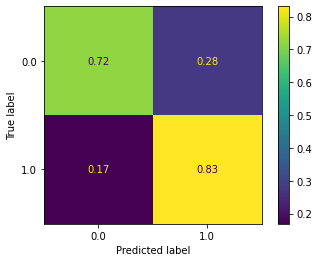

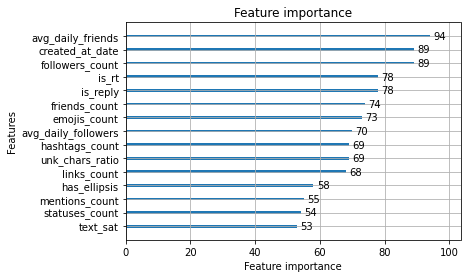

In [24]:
eval_clf(clf_meta_mean, df_test_meta_mean)

> Median

In [25]:
df_train_meta_median = get_median(df_train_meta, df_train['id'])
df_test_meta_median = get_median(df_test_meta, df_test['id'])

clf_meta_median = get_best_clf(df_train_meta_median)

[I 2022-03-29 16:16:54,088] A new study created in memory with name: no-name-768eca31-2f76-4072-b6eb-d649b16d4076


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds



[I 2022-03-29 16:16:54,919] Trial 0 finished with value: 0.7252655727598227 and parameters: {'lambda_l1': 0.00014317482237248574, 'lambda_l2': 0.009289479281050193, 'num_leaves': 5, 'feature_fraction': 0.9938798192160595, 'bagging_fraction': 0.49403365126517546, 'bagging_freq': 7, 'learning_rate': 0.012269073506975776, 'min_child_samples': 97}. Best is trial 0 with value: 0.7252655727598227.


Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.822398
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:55,365] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 0.03581713893020163, 'lambda_l2': 4.6172231276579305e-06, 'num_leaves': 11, 'feature_fraction': 0.8147164616656, 'bagging_fraction': 0.6517471292563775, 'bagging_freq': 1, 'learning_rate': 3.38185158708329e-05, 'min_child_samples': 34}. Best is trial 0 with value: 0.7252655727598227.


Did not meet early stopping. Best iteration is:
[47]	valid_0's auc: 0.830022
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:55,629] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 4.544850862562504, 'lambda_l2': 2.045865177405802e-06, 'num_leaves': 21, 'feature_fraction': 0.946908529331978, 'bagging_fraction': 0.4265126219739342, 'bagging_freq': 1, 'learning_rate': 3.0187944972495908e-05, 'min_child_samples': 47}. Best is trial 0 with value: 0.7252655727598227.


Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.826321
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:55,986] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 0.000165319081145324, 'lambda_l2': 0.0010974077601238461, 'num_leaves': 241, 'feature_fraction': 0.5729170125209664, 'bagging_fraction': 0.502662582971869, 'bagging_freq': 2, 'learning_rate': 0.00024024327045449163, 'min_child_samples': 95}. Best is trial 0 with value: 0.7252655727598227.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.830803
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:56,386] Trial 7 finished with value: 0.7631185829796315 and parameters: {'lambda_l1': 0.0007925468134019702, 'lambda_l2': 0.005643725434087422, 'num_leaves': 201, 'feature_fraction': 0.4959708620379193, 'bagging_fraction': 0.6556441838287044, 'bagging_freq': 1, 'learning_rate': 0.05435335519470094, 'min_child_samples': 97}. Best is trial 7 with value: 0.7631185829796315.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.838497
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:57,072] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 2.1371674362228744e-06, 'lambda_l2': 9.403189073651441e-08, 'num_leaves': 82, 'feature_fraction': 0.7965868356390321, 'bagging_fraction': 0.6574746162120788, 'bagging_freq': 6, 'learning_rate': 1.641918923705948e-05, 'min_child_samples': 64}. Best is trial 7 with value: 0.7631185829796315.
[I 2022-03-29 16:16:57,150] Trial 8 finished with value: 0.7585925829322078 and parameters: {'lambda_l1': 0.07709851247273464, 'lambda_l2': 0.738481933796118, 'num_leaves': 52, 'feature_fraction': 0.45076753627022714, 'bagging_fraction': 0.8162414771281226, 'bagging_freq': 3, 'learning_rate': 0.052868677731170176, 'min_child_samples': 98}. Best is trial 7 with value: 0.7631185829796315.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.832151
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.839643
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:57,717] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 1.6183819665403177e-07, 'lambda_l2': 4.7091977324554035, 'num_leaves': 147, 'feature_fraction': 0.5533948896899147, 'bagging_fraction': 0.5102272360384253, 'bagging_freq': 6, 'learning_rate': 8.453454040005667e-05, 'min_child_samples': 52}. Best is trial 7 with value: 0.7631185829796315.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.827786
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:58,032] Trial 10 finished with value: 0.597073364474901 and parameters: {'lambda_l1': 2.0396672850683074e-05, 'lambda_l2': 0.003676850716936221, 'num_leaves': 82, 'feature_fraction': 0.5967948890879018, 'bagging_fraction': 0.9062048403215337, 'bagging_freq': 7, 'learning_rate': 0.0015740145088073785, 'min_child_samples': 100}. Best is trial 7 with value: 0.7631185829796315.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.833991
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:58,664] Trial 9 finished with value: 0.7731072012899248 and parameters: {'lambda_l1': 9.190493827417841e-08, 'lambda_l2': 0.0011376954885333442, 'num_leaves': 149, 'feature_fraction': 0.9065148022903988, 'bagging_fraction': 0.9641560816443322, 'bagging_freq': 6, 'learning_rate': 0.09157104525348171, 'min_child_samples': 78}. Best is trial 9 with value: 0.7731072012899248.


Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.842556
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:16:59,416] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 5.439662374833262, 'lambda_l2': 0.00031652689856290217, 'num_leaves': 191, 'feature_fraction': 0.8515073468573506, 'bagging_fraction': 0.8677554243129807, 'bagging_freq': 7, 'learning_rate': 0.0008286659991535365, 'min_child_samples': 82}. Best is trial 9 with value: 0.7731072012899248.


Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.830736
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:00,645] Trial 12 finished with value: 0.7571431958836223 and parameters: {'lambda_l1': 4.37412900373474e-06, 'lambda_l2': 0.00011316421723299639, 'num_leaves': 254, 'feature_fraction': 0.8331444673213075, 'bagging_fraction': 0.5684543075159106, 'bagging_freq': 4, 'learning_rate': 0.04129063715762226, 'min_child_samples': 33}. Best is trial 9 with value: 0.7731072012899248.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.834632
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.832991


[I 2022-03-29 16:17:00,759] Trial 14 finished with value: 0.5 and parameters: {'lambda_l1': 0.00014604273019393053, 'lambda_l2': 2.2601289916949486e-08, 'num_leaves': 63, 'feature_fraction': 0.5929318123007294, 'bagging_fraction': 0.980442981748659, 'bagging_freq': 6, 'learning_rate': 2.035313950027085e-05, 'min_child_samples': 52}. Best is trial 9 with value: 0.7731072012899248.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:01,833] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 2.622388341956897e-05, 'lambda_l2': 0.013824297010675396, 'num_leaves': 82, 'feature_fraction': 0.889633061206522, 'bagging_fraction': 0.4676770385346917, 'bagging_freq': 5, 'learning_rate': 1.0580116663495493e-05, 'min_child_samples': 12}. Best is trial 9 with value: 0.7731072012899248.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.829862
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:02,168] Trial 18 finished with value: 0.7619833779906576 and parameters: {'lambda_l1': 3.215736930370875e-08, 'lambda_l2': 0.100565598018283, 'num_leaves': 169, 'feature_fraction': 0.43180822232989213, 'bagging_fraction': 0.7355450255063016, 'bagging_freq': 4, 'learning_rate': 0.2805832015790692, 'min_child_samples': 73}. Best is trial 9 with value: 0.7731072012899248.


Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.829761
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:03,414] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 0.00462127675688083, 'lambda_l2': 8.685715164872628e-08, 'num_leaves': 239, 'feature_fraction': 0.5420536650046801, 'bagging_fraction': 0.7894057196244122, 'bagging_freq': 3, 'learning_rate': 0.00013010763483508513, 'min_child_samples': 19}. Best is trial 9 with value: 0.7731072012899248.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.832412
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.830365


[I 2022-03-29 16:17:03,520] Trial 20 finished with value: 0.7380788656249258 and parameters: {'lambda_l1': 1.2357895992361356e-08, 'lambda_l2': 0.057067797505233844, 'num_leaves': 156, 'feature_fraction': 0.4058668025363089, 'bagging_fraction': 0.7970051784830481, 'bagging_freq': 4, 'learning_rate': 0.008927868719780492, 'min_child_samples': 75}. Best is trial 9 with value: 0.7731072012899248.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:04,122] Trial 19 finished with value: 0.7671199582671377 and parameters: {'lambda_l1': 1.1632413632572122e-08, 'lambda_l2': 0.15946539989707859, 'num_leaves': 177, 'feature_fraction': 0.4046474697735633, 'bagging_fraction': 0.9950172206787524, 'bagging_freq': 5, 'learning_rate': 0.16807254103763808, 'min_child_samples': 74}. Best is trial 9 with value: 0.7731072012899248.


Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.839585


[I 2022-03-29 16:17:04,476] Trial 21 finished with value: 0.7688894553387239 and parameters: {'lambda_l1': 1.0072045473464251e-07, 'lambda_l2': 0.1711187326182055, 'num_leaves': 171, 'feature_fraction': 0.7140712750833426, 'bagging_fraction': 0.7523863558851966, 'bagging_freq': 4, 'learning_rate': 0.2247529916048557, 'min_child_samples': 76}. Best is trial 9 with value: 0.7731072012899248.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.838635


[I 2022-03-29 16:17:04,620] Trial 22 finished with value: 0.5 and parameters: {'lambda_l1': 0.014657664022126735, 'lambda_l2': 7.816005239980883e-05, 'num_leaves': 209, 'feature_fraction': 0.7351914967906283, 'bagging_fraction': 0.7422193883115586, 'bagging_freq': 3, 'learning_rate': 0.009051195695353715, 'min_child_samples': 81}. Best is trial 9 with value: 0.7731072012899248.


Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.835492
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:05,277] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 0.001170798115389841, 'lambda_l2': 0.31689828075063287, 'num_leaves': 147, 'feature_fraction': 0.5536072492315138, 'bagging_fraction': 0.7424885489880741, 'bagging_freq': 3, 'learning_rate': 2.4886732097579975e-05, 'min_child_samples': 14}. Best is trial 9 with value: 0.7731072012899248.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.834241
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:05,903] Trial 24 finished with value: 0.76933998055628 and parameters: {'lambda_l1': 0.0017302804227709151, 'lambda_l2': 3.2703150824885074e-05, 'num_leaves': 214, 'feature_fraction': 0.663393105881879, 'bagging_fraction': 0.6155811438791889, 'bagging_freq': 2, 'learning_rate': 0.27298115839173714, 'min_child_samples': 84}. Best is trial 9 with value: 0.7731072012899248.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.834302
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.839453


[I 2022-03-29 16:17:06,032] Trial 4 finished with value: 0.7535182462713111 and parameters: {'lambda_l1': 0.0016260856391519542, 'lambda_l2': 7.285391611677487e-07, 'num_leaves': 237, 'feature_fraction': 0.693458972943094, 'bagging_fraction': 0.8405138998573447, 'bagging_freq': 6, 'learning_rate': 0.013107113968715198, 'min_child_samples': 14}. Best is trial 9 with value: 0.7731072012899248.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:06,885] Trial 26 finished with value: 0.6912479548526309 and parameters: {'lambda_l1': 3.2806417758028787e-07, 'lambda_l2': 8.384186026954884, 'num_leaves': 118, 'feature_fraction': 0.7350012878992234, 'bagging_fraction': 0.9134288749161883, 'bagging_freq': 5, 'learning_rate': 0.008787292229128931, 'min_child_samples': 84}. Best is trial 9 with value: 0.7731072012899248.
[I 2022-03-29 16:17:07,034] Trial 23 finished with value: 0.7450027268631589 and parameters: {'lambda_l1': 0.003020883120458109, 'lambda_l2': 3.251536441185272e-05, 'num_leaves': 201, 'feature_fraction': 0.7010116814477036, 'bagging_fraction': 0.9921237450596969, 'bagging_freq': 5, 'learning_rate': 0.013356181287109293, 'min_child_samples': 82}. Best is trial 9 with value: 0.7731072012899248.


Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.834439
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.838828
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:07,784] Trial 17 finished with value: 0.7556256372560644 and parameters: {'lambda_l1': 1.2690139155601315e-08, 'lambda_l2': 3.748695960491759e-05, 'num_leaves': 152, 'feature_fraction': 0.8578076063888381, 'bagging_fraction': 0.9940189788643221, 'bagging_freq': 5, 'learning_rate': 0.2649675416055268, 'min_child_samples': 12}. Best is trial 9 with value: 0.7731072012899248.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.830644
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:08,282] Trial 25 finished with value: 0.760904488653878 and parameters: {'lambda_l1': 3.066767445089596e-07, 'lambda_l2': 7.720899883690308, 'num_leaves': 124, 'feature_fraction': 0.7067801227011414, 'bagging_fraction': 0.9978098673576474, 'bagging_freq': 5, 'learning_rate': 0.2873081026489989, 'min_child_samples': 64}. Best is trial 9 with value: 0.7731072012899248.


Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.8415
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:08,685] Trial 29 finished with value: 0.7703329144239205 and parameters: {'lambda_l1': 3.173814564010098e-07, 'lambda_l2': 2.5982998434046448e-05, 'num_leaves': 112, 'feature_fraction': 0.6982518524265675, 'bagging_fraction': 0.6018721809105193, 'bagging_freq': 2, 'learning_rate': 0.12684427574663007, 'min_child_samples': 62}. Best is trial 9 with value: 0.7731072012899248.
[I 2022-03-29 16:17:08,816] Trial 27 finished with value: 0.7749389419770943 and parameters: {'lambda_l1': 2.862281406153351e-07, 'lambda_l2': 6.151224219543947, 'num_leaves': 123, 'feature_fraction': 0.6780678690483026, 'bagging_fraction': 0.925382191345804, 'bagging_freq': 5, 'learning_rate': 0.11672576331101729, 'min_child_samples': 62}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.840028
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.840809


[I 2022-03-29 16:17:08,957] Trial 30 finished with value: 0.7632786379911317 and parameters: {'lambda_l1': 3.053263969111672e-07, 'lambda_l2': 1.7100854412626854e-05, 'num_leaves': 109, 'feature_fraction': 0.6611863316261146, 'bagging_fraction': 0.5644213531835993, 'bagging_freq': 2, 'learning_rate': 0.12571303664399125, 'min_child_samples': 63}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.838973
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:09,239] Trial 28 finished with value: 0.7560702345102317 and parameters: {'lambda_l1': 2.48193887334007e-07, 'lambda_l2': 8.066027076807389, 'num_leaves': 124, 'feature_fraction': 0.6696127940940778, 'bagging_fraction': 0.9873340451228609, 'bagging_freq': 5, 'learning_rate': 0.26524265125013274, 'min_child_samples': 68}. Best is trial 27 with value: 0.7749389419770943.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.842346


[I 2022-03-29 16:17:09,550] Trial 31 finished with value: 0.7620515495696298 and parameters: {'lambda_l1': 2.9251330775365905e-07, 'lambda_l2': 2.6549863052327625e-05, 'num_leaves': 118, 'feature_fraction': 0.6281654488009196, 'bagging_fraction': 0.5727353302160056, 'bagging_freq': 2, 'learning_rate': 0.1245827997716919, 'min_child_samples': 65}. Best is trial 27 with value: 0.7749389419770943.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.836132
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:09,973] Trial 32 finished with value: 0.7575255495222061 and parameters: {'lambda_l1': 1.496505095479719e-07, 'lambda_l2': 1.3814145084825302e-05, 'num_leaves': 122, 'feature_fraction': 0.7652989268334112, 'bagging_fraction': 0.594910392468196, 'bagging_freq': 2, 'learning_rate': 0.12712328510062376, 'min_child_samples': 63}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[47]	valid_0's auc: 0.843614
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:10,415] Trial 33 finished with value: 0.7552936713062859 and parameters: {'lambda_l1': 5.210996255029099e-07, 'lambda_l2': 0.0003872625461113258, 'num_leaves': 123, 'feature_fraction': 0.6484423304531262, 'bagging_fraction': 0.5838663339372698, 'bagging_freq': 2, 'learning_rate': 0.130157132914933, 'min_child_samples': 63}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.84027
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:10,735] Trial 34 finished with value: 0.7658128423398857 and parameters: {'lambda_l1': 0.3233794959345438, 'lambda_l2': 0.0008587477454005664, 'num_leaves': 112, 'feature_fraction': 0.6601169172360187, 'bagging_fraction': 0.592404498163253, 'bagging_freq': 2, 'learning_rate': 0.1114529736885339, 'min_child_samples': 63}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.84128
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:11,234] Trial 35 finished with value: 0.757063168377872 and parameters: {'lambda_l1': 0.26180428109386616, 'lambda_l2': 5.979112515912259e-06, 'num_leaves': 111, 'feature_fraction': 0.6345247042131414, 'bagging_fraction': 0.5760905332901878, 'bagging_freq': 2, 'learning_rate': 0.11065955183429106, 'min_child_samples': 63}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.83801
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:11,655] Trial 39 finished with value: 0.7502252626087782 and parameters: {'lambda_l1': 2.0358346969217223e-06, 'lambda_l2': 0.0005882494386752787, 'num_leaves': 104, 'feature_fraction': 0.7938078201035622, 'bagging_fraction': 0.6232703193674957, 'bagging_freq': 2, 'learning_rate': 0.02642463772850755, 'min_child_samples': 90}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.837439
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:12,422] Trial 38 finished with value: 0.7642715718587723 and parameters: {'lambda_l1': 1.5814738065518446e-06, 'lambda_l2': 0.0007517175331027885, 'num_leaves': 104, 'feature_fraction': 0.7760675182526341, 'bagging_fraction': 0.5978553978482349, 'bagging_freq': 2, 'learning_rate': 0.09014076019040657, 'min_child_samples': 58}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[46]	valid_0's auc: 0.841273
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:12,946] Trial 40 finished with value: 0.7575937211011785 and parameters: {'lambda_l1': 1.719971907101483e-06, 'lambda_l2': 0.00045258594063294147, 'num_leaves': 98, 'feature_fraction': 0.7749015365165611, 'bagging_fraction': 0.6180089720470734, 'bagging_freq': 6, 'learning_rate': 0.029082360147686885, 'min_child_samples': 58}. Best is trial 27 with value: 0.7749389419770943.
[I 2022-03-29 16:17:13,096] Trial 36 finished with value: 0.7645857539183838 and parameters: {'lambda_l1': 1.443219981684778e-06, 'lambda_l2': 7.360207340183132e-06, 'num_leaves': 105, 'feature_fraction': 0.6351643558151464, 'bagging_fraction': 0.9310283556911765, 'bagging_freq': 2, 'learning_rate': 0.10536115111460677, 'min_child_samples': 62}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.838874
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.834902
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:13,541] Trial 41 finished with value: 0.763729163208688 and parameters: {'lambda_l1': 1.8142066783771912e-06, 'lambda_l2': 6.561605355529506e-07, 'num_leaves': 97, 'feature_fraction': 0.7768426787367506, 'bagging_fraction': 0.9370390897558527, 'bagging_freq': 6, 'learning_rate': 0.026423965161664002, 'min_child_samples': 91}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.842211
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:14,099] Trial 43 finished with value: 0.7585125554264577 and parameters: {'lambda_l1': 2.2316269625428483e-06, 'lambda_l2': 5.166045652278213e-07, 'num_leaves': 100, 'feature_fraction': 0.7860722013453262, 'bagging_fraction': 0.6890177757795208, 'bagging_freq': 6, 'learning_rate': 0.028339133362560557, 'min_child_samples': 89}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.84099
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:14,998] Trial 42 finished with value: 0.7623538757024636 and parameters: {'lambda_l1': 2.8895378414251165e-06, 'lambda_l2': 1.4046705757735632e-06, 'num_leaves': 99, 'feature_fraction': 0.9820986887008422, 'bagging_fraction': 0.6907688421986641, 'bagging_freq': 6, 'learning_rate': 0.026816939628991805, 'min_child_samples': 47}. Best is trial 27 with value: 0.7749389419770943.
[I 2022-03-29 16:17:15,102] Trial 37 finished with value: 0.7541466103905341 and parameters: {'lambda_l1': 1.2991808774044352e-05, 'lambda_l2': 0.0006454339161506721, 'num_leaves': 130, 'feature_fraction': 0.76974570257078, 'bagging_fraction': 0.9016058549074984, 'bagging_freq': 7, 'learning_rate': 0.029587463408274013, 'min_child_samples': 42}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.839591
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.837992
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:15,591] Trial 45 finished with value: 0.7192724017736467 and parameters: {'lambda_l1': 2.2310580587349947e-05, 'lambda_l2': 3.1357379836967793e-07, 'num_leaves': 137, 'feature_fraction': 0.9413115566134737, 'bagging_fraction': 0.9387139265493055, 'bagging_freq': 1, 'learning_rate': 0.003995829677467859, 'min_child_samples': 90}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.833962
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:16,179] Trial 48 finished with value: 0.7615150688829345 and parameters: {'lambda_l1': 1.688325946039172e-05, 'lambda_l2': 0.8912595170996859, 'num_leaves': 138, 'feature_fraction': 0.9858133910743336, 'bagging_fraction': 0.6843947191433428, 'bagging_freq': 1, 'learning_rate': 0.06280862023350271, 'min_child_samples': 87}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.841978
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:16,682] Trial 47 finished with value: 0.6448853531880587 and parameters: {'lambda_l1': 5.613335433705251e-08, 'lambda_l2': 7.38281675504233e-07, 'num_leaves': 222, 'feature_fraction': 0.9640477339370012, 'bagging_fraction': 0.5371047760135165, 'bagging_freq': 1, 'learning_rate': 0.0029203575680556543, 'min_child_samples': 42}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[55]	valid_0's auc: 0.832612


[I 2022-03-29 16:17:17,069] Trial 44 finished with value: 0.758290256799374 and parameters: {'lambda_l1': 3.052275439792468e-05, 'lambda_l2': 1.0078401184226336e-06, 'num_leaves': 97, 'feature_fraction': 0.9200964549105934, 'bagging_fraction': 0.9219062227327015, 'bagging_freq': 6, 'learning_rate': 0.024782838371755555, 'min_child_samples': 46}. Best is trial 27 with value: 0.7749389419770943.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.834522


[I 2022-03-29 16:17:17,428] Trial 46 finished with value: 0.7261844070851019 and parameters: {'lambda_l1': 4.111130228964729e-05, 'lambda_l2': 1.668243709604921e-06, 'num_leaves': 220, 'feature_fraction': 0.9316309202427415, 'bagging_fraction': 0.6726568951221233, 'bagging_freq': 1, 'learning_rate': 0.003896736875944252, 'min_child_samples': 42}. Best is trial 27 with value: 0.7749389419770943.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.831281


[I 2022-03-29 16:17:17,718] Trial 51 finished with value: 0.7595173452208759 and parameters: {'lambda_l1': 6.424069503062852e-08, 'lambda_l2': 2.636019788676267, 'num_leaves': 221, 'feature_fraction': 0.9153693800207015, 'bagging_fraction': 0.5378403628079489, 'bagging_freq': 4, 'learning_rate': 0.060680769791985396, 'min_child_samples': 71}. Best is trial 27 with value: 0.7749389419770943.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.83803
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:18,419] Trial 53 finished with value: 0.7644197709434948 and parameters: {'lambda_l1': 5.4571278649428276e-08, 'lambda_l2': 2.750690323776722, 'num_leaves': 171, 'feature_fraction': 0.4911635912071146, 'bagging_fraction': 0.5249093709374193, 'bagging_freq': 3, 'learning_rate': 0.06720244399701271, 'min_child_samples': 77}. Best is trial 27 with value: 0.7749389419770943.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.839871


[I 2022-03-29 16:17:18,793] Trial 50 finished with value: 0.7720223839897564 and parameters: {'lambda_l1': 5.336898499842476e-08, 'lambda_l2': 1.985819496123585, 'num_leaves': 228, 'feature_fraction': 0.9399913362823824, 'bagging_fraction': 0.877377242581626, 'bagging_freq': 1, 'learning_rate': 0.05944658650997035, 'min_child_samples': 71}. Best is trial 27 with value: 0.7749389419770943.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.843108


[I 2022-03-29 16:17:18,945] Trial 52 finished with value: 0.7759318758447348 and parameters: {'lambda_l1': 6.037066475779174e-08, 'lambda_l2': 1.6005438182010625, 'num_leaves': 228, 'feature_fraction': 0.7299544239016771, 'bagging_fraction': 0.8588885313467777, 'bagging_freq': 3, 'learning_rate': 0.0594238145650595, 'min_child_samples': 77}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.842583
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:19,720] Trial 49 finished with value: 0.7659610414246081 and parameters: {'lambda_l1': 4.5710310660496384e-08, 'lambda_l2': 1.4467103311445353, 'num_leaves': 220, 'feature_fraction': 0.8931305604938226, 'bagging_fraction': 0.8558798574423099, 'bagging_freq': 1, 'learning_rate': 0.054222976169708566, 'min_child_samples': 41}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.839822


[I 2022-03-29 16:17:20,089] Trial 54 finished with value: 0.7589008370284306 and parameters: {'lambda_l1': 6.827351042994044e-08, 'lambda_l2': 0.022360126368440276, 'num_leaves': 173, 'feature_fraction': 0.7293987130272093, 'bagging_fraction': 0.8570154264769224, 'bagging_freq': 3, 'learning_rate': 0.07242807879942997, 'min_child_samples': 77}. Best is trial 52 with value: 0.7759318758447348.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.840802
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.841965


[I 2022-03-29 16:17:20,559] Trial 55 finished with value: 0.7662692955208308 and parameters: {'lambda_l1': 6.294433196870087e-08, 'lambda_l2': 1.8144408361078348, 'num_leaves': 174, 'feature_fraction': 0.733103106053887, 'bagging_fraction': 0.8640682455314236, 'bagging_freq': 4, 'learning_rate': 0.06710636738482657, 'min_child_samples': 77}. Best is trial 52 with value: 0.7759318758447348.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:21,119] Trial 56 finished with value: 0.7736318260498423 and parameters: {'lambda_l1': 7.574120353169669e-08, 'lambda_l2': 0.0023670679617576415, 'num_leaves': 178, 'feature_fraction': 0.5995670461934469, 'bagging_fraction': 0.8503375237837272, 'bagging_freq': 3, 'learning_rate': 0.05841734319354923, 'min_child_samples': 77}. Best is trial 52 with value: 0.7759318758447348.
[I 2022-03-29 16:17:21,257] Trial 57 finished with value: 0.7685693453157234 and parameters: {'lambda_l1': 6.9307624861565955e-06, 'lambda_l2': 0.017466299212789922, 'num_leaves': 168, 'feature_fraction': 0.5007601636528558, 'bagging_fraction': 0.8519866216925751, 'bagging_freq': 3, 'learning_rate': 0.17858622491523024, 'min_child_samples': 80}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.840068
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.83897
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:22,241] Trial 59 finished with value: 0.7665834775804424 and parameters: {'lambda_l1': 0.0004726637568164027, 'lambda_l2': 0.0027303532205855308, 'num_leaves': 255, 'feature_fraction': 0.8734479970056093, 'bagging_fraction': 0.8662543054750351, 'bagging_freq': 3, 'learning_rate': 0.18984547990662926, 'min_child_samples': 70}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.845934
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.837737


[I 2022-03-29 16:17:22,430] Trial 58 finished with value: 0.753992483342423 and parameters: {'lambda_l1': 0.00047888620081853106, 'lambda_l2': 0.021933340403373223, 'num_leaves': 179, 'feature_fraction': 0.5133938830635794, 'bagging_fraction': 0.963231818124972, 'bagging_freq': 3, 'learning_rate': 0.18380947971147515, 'min_child_samples': 78}. Best is trial 52 with value: 0.7759318758447348.
[I 2022-03-29 16:17:22,707] Trial 60 finished with value: 0.7572232233893723 and parameters: {'lambda_l1': 3.106261590457982e-08, 'lambda_l2': 0.026887718184578586, 'num_leaves': 244, 'feature_fraction': 0.8878956328596795, 'bagging_fraction': 0.8773958783277592, 'bagging_freq': 3, 'learning_rate': 0.18921516777311853, 'min_child_samples': 69}. Best is trial 52 with value: 0.7759318758447348.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.833412
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:23,590] Trial 61 finished with value: 0.763438693002632 and parameters: {'lambda_l1': 0.00041248034096210074, 'lambda_l2': 9.617958547221445e-05, 'num_leaves': 231, 'feature_fraction': 0.612220299228859, 'bagging_fraction': 0.8837795691995505, 'bagging_freq': 3, 'learning_rate': 0.19002783216218722, 'min_child_samples': 69}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.839082
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:24,232] Trial 62 finished with value: 0.7647398809664951 and parameters: {'lambda_l1': 2.4369508907606637e-08, 'lambda_l2': 0.00014757382256127007, 'num_leaves': 246, 'feature_fraction': 0.60135125507333, 'bagging_fraction': 0.9612344181940795, 'bagging_freq': 3, 'learning_rate': 0.17705030328074292, 'min_child_samples': 68}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.8351


[I 2022-03-29 16:17:24,612] Trial 65 finished with value: 0.7527535389941432 and parameters: {'lambda_l1': 2.1322823250951164e-08, 'lambda_l2': 0.3765694525688536, 'num_leaves': 252, 'feature_fraction': 0.8214450761180472, 'bagging_fraction': 0.8862012161763007, 'bagging_freq': 3, 'learning_rate': 0.014979352808623942, 'min_child_samples': 70}. Best is trial 52 with value: 0.7759318758447348.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.838487
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.837011


[I 2022-03-29 16:17:24,729] Trial 63 finished with value: 0.7654304887013018 and parameters: {'lambda_l1': 2.31490503774166e-08, 'lambda_l2': 0.4550701325462003, 'num_leaves': 256, 'feature_fraction': 0.6094769460781512, 'bagging_fraction': 0.9565406527284721, 'bagging_freq': 3, 'learning_rate': 0.20208376376594403, 'min_child_samples': 69}. Best is trial 52 with value: 0.7759318758447348.
[I 2022-03-29 16:17:25,017] Trial 64 finished with value: 0.7457674341403269 and parameters: {'lambda_l1': 2.4871975668798813e-08, 'lambda_l2': 0.00206078195358343, 'num_leaves': 247, 'feature_fraction': 0.5851710903030704, 'bagging_fraction': 0.8903279162636804, 'bagging_freq': 3, 'learning_rate': 0.013465711204995966, 'min_child_samples': 69}. Best is trial 52 with value: 0.7759318758447348.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.836852
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:25,713] Trial 68 finished with value: 0.7407790529485689 and parameters: {'lambda_l1': 5.651473361221742e-07, 'lambda_l2': 8.794858690832014e-05, 'num_leaves': 234, 'feature_fraction': 0.679016308516512, 'bagging_fraction': 0.8003936104110346, 'bagging_freq': 4, 'learning_rate': 0.015951929065463808, 'min_child_samples': 85}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.836622
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:26,420] Trial 67 finished with value: 0.750527588741612 and parameters: {'lambda_l1': 2.576942087449675e-08, 'lambda_l2': 0.000140185716565632, 'num_leaves': 243, 'feature_fraction': 0.608623740511533, 'bagging_fraction': 0.8246389463645116, 'bagging_freq': 4, 'learning_rate': 0.015900097781210272, 'min_child_samples': 57}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.838088
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.835693


[I 2022-03-29 16:17:26,612] Trial 69 finished with value: 0.7434673843454342 and parameters: {'lambda_l1': 5.815131737862068e-07, 'lambda_l2': 0.0001744510527392778, 'num_leaves': 189, 'feature_fraction': 0.6010585351408099, 'bagging_fraction': 0.8128496293204169, 'bagging_freq': 4, 'learning_rate': 0.015619980015028283, 'min_child_samples': 85}. Best is trial 52 with value: 0.7759318758447348.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:26,947] Trial 70 finished with value: 0.5 and parameters: {'lambda_l1': 7.217331127262295e-07, 'lambda_l2': 0.5589118164840794, 'num_leaves': 203, 'feature_fraction': 0.8292856914889515, 'bagging_fraction': 0.8126503780075018, 'bagging_freq': 7, 'learning_rate': 0.0005241720211667557, 'min_child_samples': 84}. Best is trial 52 with value: 0.7759318758447348.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.831241
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:27,594] Trial 72 finished with value: 0.7694081521352525 and parameters: {'lambda_l1': 5.494414200604826e-07, 'lambda_l2': 0.001872796568660117, 'num_leaves': 196, 'feature_fraction': 0.6841321479002402, 'bagging_fraction': 0.8035254452824081, 'bagging_freq': 4, 'learning_rate': 0.04688719761892105, 'min_child_samples': 85}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.842976
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:28,117] Trial 73 finished with value: 0.7679469091598891 and parameters: {'lambda_l1': 0.013656908269575002, 'lambda_l2': 3.3278092922008175e-06, 'num_leaves': 190, 'feature_fraction': 0.6753031402357981, 'bagging_fraction': 0.8226412498807217, 'bagging_freq': 4, 'learning_rate': 0.03862290014863319, 'min_child_samples': 85}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.844492
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:28,681] Trial 71 finished with value: 0.7687175444004458 and parameters: {'lambda_l1': 5.935859062053681e-07, 'lambda_l2': 0.0023597538279539246, 'num_leaves': 203, 'feature_fraction': 0.6693076323236489, 'bagging_fraction': 0.8167946622337777, 'bagging_freq': 4, 'learning_rate': 0.03923996181436224, 'min_child_samples': 58}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.843116


[I 2022-03-29 16:17:29,092] Trial 76 finished with value: 0.7585125554264577 and parameters: {'lambda_l1': 1.5043881540274183e-07, 'lambda_l2': 4.105540326665809, 'num_leaves': 208, 'feature_fraction': 0.5573231801660454, 'bagging_fraction': 0.7741290063166882, 'bagging_freq': 7, 'learning_rate': 0.04369643023611251, 'min_child_samples': 94}. Best is trial 52 with value: 0.7759318758447348.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.839702
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:29,680] Trial 78 finished with value: 0.7615091409195457 and parameters: {'lambda_l1': 1.397580035572118e-07, 'lambda_l2': 0.006623770210111404, 'num_leaves': 190, 'feature_fraction': 0.6855408217295205, 'bagging_fraction': 0.6360838612566888, 'bagging_freq': 5, 'learning_rate': 0.08708638490318611, 'min_child_samples': 96}. Best is trial 52 with value: 0.7759318758447348.
[I 2022-03-29 16:17:29,741] Trial 75 finished with value: 0.7619655941004907 and parameters: {'lambda_l1': 7.033399092613524e-07, 'lambda_l2': 0.004448788346356579, 'num_leaves': 194, 'feature_fraction': 0.6853552412933197, 'bagging_fraction': 0.7114647963520666, 'bagging_freq': 7, 'learning_rate': 0.04335657509931987, 'min_child_samples': 73}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.840808
Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.842418


[I 2022-03-29 16:17:30,204] Trial 74 finished with value: 0.7582102292936237 and parameters: {'lambda_l1': 0.007847525901744793, 'lambda_l2': 0.00022023145779071678, 'num_leaves': 191, 'feature_fraction': 0.688068746544915, 'bagging_fraction': 0.8198956842071233, 'bagging_freq': 7, 'learning_rate': 0.043335782527041934, 'min_child_samples': 55}. Best is trial 52 with value: 0.7759318758447348.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.838841
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:31,133] Trial 80 finished with value: 0.7625080027505751 and parameters: {'lambda_l1': 1.2370496239247637e-07, 'lambda_l2': 0.005784557162885311, 'num_leaves': 159, 'feature_fraction': 0.7526038898355608, 'bagging_fraction': 0.7203951841958511, 'bagging_freq': 5, 'learning_rate': 0.088530279133304, 'min_child_samples': 93}. Best is trial 52 with value: 0.7759318758447348.
[I 2022-03-29 16:17:31,265] Trial 77 finished with value: 0.7612008868233231 and parameters: {'lambda_l1': 1.5016251767361257e-07, 'lambda_l2': 0.007403908826162228, 'num_leaves': 158, 'feature_fraction': 0.6874183706232856, 'bagging_fraction': 0.7706071041697943, 'bagging_freq': 1, 'learning_rate': 0.03976881566256768, 'min_child_samples': 55}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.839039
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.841639
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:31,871] Trial 82 finished with value: 0.7560761624736205 and parameters: {'lambda_l1': 0.002304053370856113, 'lambda_l2': 0.0013250195811600517, 'num_leaves': 160, 'feature_fraction': 0.7516213552233989, 'bagging_fraction': 0.48115368082288107, 'bagging_freq': 5, 'learning_rate': 0.08043381263035569, 'min_child_samples': 79}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.832631
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:32,892] Trial 81 finished with value: 0.7746366158442605 and parameters: {'lambda_l1': 1.467960457114044e-07, 'lambda_l2': 0.006103300048128133, 'num_leaves': 158, 'feature_fraction': 0.6933511200717335, 'bagging_fraction': 0.8400808919583649, 'bagging_freq': 5, 'learning_rate': 0.08619296139818715, 'min_child_samples': 73}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.842374
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.840899


[I 2022-03-29 16:17:33,049] Trial 83 finished with value: 0.7624279752448249 and parameters: {'lambda_l1': 0.002198034768789429, 'lambda_l2': 3.693336308883475e-05, 'num_leaves': 75, 'feature_fraction': 0.7543278764709206, 'bagging_fraction': 0.8387428123678367, 'bagging_freq': 5, 'learning_rate': 0.08792477936220425, 'min_child_samples': 81}. Best is trial 52 with value: 0.7759318758447348.
[I 2022-03-29 16:17:33,181] Trial 85 finished with value: 0.5 and parameters: {'lambda_l1': 2.8137815160712146e-07, 'lambda_l2': 0.0012636716239318071, 'num_leaves': 70, 'feature_fraction': 0.7124499982058661, 'bagging_fraction': 0.46863806281843146, 'bagging_freq': 2, 'learning_rate': 5.839105802488526e-05, 'min_child_samples': 80}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.832651
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.843419


[I 2022-03-29 16:17:33,362] Trial 84 finished with value: 0.7677987100751666 and parameters: {'lambda_l1': 0.0034695303595955016, 'lambda_l2': 4.708542768929365e-05, 'num_leaves': 151, 'feature_fraction': 0.6453122845406127, 'bagging_fraction': 0.7763247962300974, 'bagging_freq': 2, 'learning_rate': 0.08520279023032519, 'min_child_samples': 81}. Best is trial 52 with value: 0.7759318758447348.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:34,051] Trial 79 finished with value: 0.7628103288834089 and parameters: {'lambda_l1': 1.1701830199629788e-07, 'lambda_l2': 0.008416841700465739, 'num_leaves': 211, 'feature_fraction': 0.5725636478786522, 'bagging_fraction': 0.4286944044299993, 'bagging_freq': 5, 'learning_rate': 0.045169231451753444, 'min_child_samples': 22}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.837491
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:34,522] Trial 86 finished with value: 0.5 and parameters: {'lambda_l1': 0.001721778226062313, 'lambda_l2': 0.0015460918872817683, 'num_leaves': 69, 'feature_fraction': 0.6476760114057315, 'bagging_fraction': 0.8393419898285341, 'bagging_freq': 2, 'learning_rate': 5.251346260719547e-05, 'min_child_samples': 80}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.836304
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:36,097] Trial 87 finished with value: 0.7550032011002299 and parameters: {'lambda_l1': 1.2973977599881714e-08, 'lambda_l2': 5.2556127579077304e-05, 'num_leaves': 87, 'feature_fraction': 0.7124072428918876, 'bagging_fraction': 0.9058406409734634, 'bagging_freq': 2, 'learning_rate': 0.2957063784624844, 'min_child_samples': 66}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.83486


[I 2022-03-29 16:17:36,468] Trial 88 finished with value: 0.7662752234842198 and parameters: {'lambda_l1': 2.647737140894089e-07, 'lambda_l2': 1.5495622773127562e-05, 'num_leaves': 137, 'feature_fraction': 0.6585702742055718, 'bagging_fraction': 0.8386360704323771, 'bagging_freq': 2, 'learning_rate': 0.13864365118727953, 'min_child_samples': 66}. Best is trial 52 with value: 0.7759318758447348.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.839011


[I 2022-03-29 16:17:36,622] Trial 91 finished with value: 0.7590549640765419 and parameters: {'lambda_l1': 1.0119746514548412e-08, 'lambda_l2': 5.064251476505168, 'num_leaves': 138, 'feature_fraction': 0.7015682947116452, 'bagging_fraction': 0.842596366299166, 'bagging_freq': 6, 'learning_rate': 0.15117615790110792, 'min_child_samples': 66}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.837638
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:37,007] Trial 90 finished with value: 0.7722565385436179 and parameters: {'lambda_l1': 1.0855236110257318e-06, 'lambda_l2': 0.06231713003573628, 'num_leaves': 140, 'feature_fraction': 0.648296866416763, 'bagging_fraction': 0.9135675446981607, 'bagging_freq': 2, 'learning_rate': 0.14381760372938995, 'min_child_samples': 66}. Best is trial 52 with value: 0.7759318758447348.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.840882
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:37,521] Trial 92 finished with value: 0.7587526379437082 and parameters: {'lambda_l1': 1.1163368622355627e-06, 'lambda_l2': 0.13518308254645528, 'num_leaves': 181, 'feature_fraction': 0.8064678497514101, 'bagging_fraction': 0.838602420433918, 'bagging_freq': 6, 'learning_rate': 0.14758131592824475, 'min_child_samples': 74}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.838571
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.83298


[I 2022-03-29 16:17:38,277] Trial 66 finished with value: 0.7463157707537998 and parameters: {'lambda_l1': 2.642805257065819e-08, 'lambda_l2': 0.00013130960089335425, 'num_leaves': 245, 'feature_fraction': 0.6039401375378902, 'bagging_fraction': 0.9618459270792067, 'bagging_freq': 3, 'learning_rate': 0.014000085735415469, 'min_child_samples': 5}. Best is trial 52 with value: 0.7759318758447348.
[I 2022-03-29 16:17:38,434] Trial 93 finished with value: 0.7555337538235365 and parameters: {'lambda_l1': 7.66983169392582e-05, 'lambda_l2': 0.11285142646223156, 'num_leaves': 142, 'feature_fraction': 0.7201443742312257, 'bagging_fraction': 0.9019652209823482, 'bagging_freq': 6, 'learning_rate': 0.14630597261721734, 'min_child_samples': 74}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.838112
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:17:39,589] Trial 94 finished with value: 0.7645116543760224 and parameters: {'lambda_l1': 0.00010763040558619057, 'lambda_l2': 1.3048025598970278e-05, 'num_leaves': 141, 'feature_fraction': 0.9620756354781174, 'bagging_fraction': 0.948360407014086, 'bagging_freq': 6, 'learning_rate': 0.14277698899810032, 'min_child_samples': 74}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.841089
Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.839933


[I 2022-03-29 16:17:39,778] Trial 95 finished with value: 0.7666516491594149 and parameters: {'lambda_l1': 0.00011506141247744309, 'lambda_l2': 0.18768857072561923, 'num_leaves': 229, 'feature_fraction': 0.626764552970887, 'bagging_fraction': 0.8948268716919292, 'bagging_freq': 6, 'learning_rate': 0.14540139722019316, 'min_child_samples': 74}. Best is trial 52 with value: 0.7759318758447348.
[I 2022-03-29 16:17:39,928] Trial 96 finished with value: 0.7559042515353425 and parameters: {'lambda_l1': 0.00011333968276363637, 'lambda_l2': 0.2157339217513169, 'num_leaves': 226, 'feature_fraction': 0.9624025715564113, 'bagging_fraction': 0.9733749729301052, 'bagging_freq': 1, 'learning_rate': 0.021674551274738052, 'min_child_samples': 74}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.836603


[I 2022-03-29 16:17:40,154] Trial 97 finished with value: 0.7539065278732838 and parameters: {'lambda_l1': 1.0289926871533562e-06, 'lambda_l2': 0.06785798291755557, 'num_leaves': 143, 'feature_fraction': 0.6298541319762667, 'bagging_fraction': 0.9452965149624609, 'bagging_freq': 1, 'learning_rate': 0.0220983095460463, 'min_child_samples': 74}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.838964


[I 2022-03-29 16:17:40,413] Trial 98 finished with value: 0.7678046380385554 and parameters: {'lambda_l1': 0.00019948034601655559, 'lambda_l2': 1.0191688717992209, 'num_leaves': 148, 'feature_fraction': 0.6317944317546169, 'bagging_fraction': 0.9158288765418412, 'bagging_freq': 1, 'learning_rate': 0.10997768376470987, 'min_child_samples': 72}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.841043


[I 2022-03-29 16:17:40,799] Trial 89 finished with value: 0.7469441348730229 and parameters: {'lambda_l1': 2.73227209220274e-07, 'lambda_l2': 0.08976814243654233, 'num_leaves': 145, 'feature_fraction': 0.7101596488745581, 'bagging_fraction': 0.9060704729499919, 'bagging_freq': 2, 'learning_rate': 0.1398295051278843, 'min_child_samples': 5}. Best is trial 52 with value: 0.7759318758447348.
[I 2022-03-29 16:17:40,799] Trial 99 finished with value: 0.7571550518104001 and parameters: {'lambda_l1': 9.379974593481028e-08, 'lambda_l2': 0.04961013750816528, 'num_leaves': 228, 'feature_fraction': 0.9588520916933401, 'bagging_fraction': 0.920368295870601, 'bagging_freq': 1, 'learning_rate': 0.25091851569071383, 'min_child_samples': 61}. Best is trial 52 with value: 0.7759318758447348.


Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.831523
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.831252
{'lambda_l1': 6.037066475779174e-08, 'lambda_l2': 1.6005438182010625, 'num_leaves': 228, 'feature_fraction': 0.7299544239016771, 'bagging_fraction': 0.8588885313467777, 'bagging_freq': 3, 'learning_rate': 0.0594238145650595, 'min_child_samples': 77} -> 0.7759318758447348
[LightGBM] [Warning] feature_fraction is set=0.7299544239016771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7299544239016771
[LightGBM] [Warning] lambda_l1 is set=6.037066475779174e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.037066475779174e-08
[LightGBM] [Warning] bagging_fraction is set=0.8588885313467777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8588885313467777
[LightGBM] [Warning] lambda_l2 is set=1.6005438182010625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6005438182010625


AUROC: 0.7693830570902395
Accuracy: 0.775993237531699


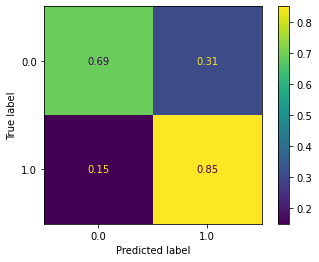

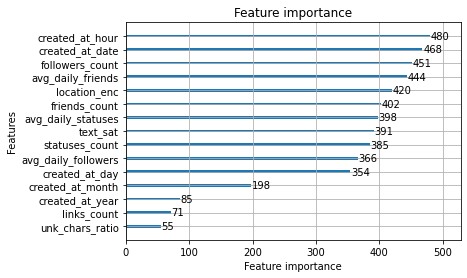

In [26]:
eval_clf(clf_meta_median, df_test_meta_median)

## Feature engineering

In [ ]:
POS_TAGS = [
    'ADJ', 'ADP', 'ADV', 'AUX',
    'CONJ', 'CCONJ', 'DET', 'INTJ',
    'NOUN', 'NUM', 'PART', 'PRON',
    'PROPN', 'PUNCT', 'SCONJ', 'SYM', 
    'VERB', 'X', 'SPACE'
]
POS_TAGS = OrderedDict({ tag: 0 for tag in POS_TAGS })

def extract_tweet_metadata(text: str):
    
    tokens = nlp(text)
    tokens_count = len(tokens)
    
    avg_token_len = 0
    tokens_diff_ratio = []
    pos_tags_count = POS_TAGS.copy()
    
    for token in tokens:
        avg_token_len += len(token)
        tokens_diff_ratio.append(token.text)
        
        try:
            pos_tags_count[token.pos_] += 1
        except KeyError:
            print(token.pos_, "not in POS_TAGS")
        
    try:
        avg_token_len = avg_token_len / tokens_count
        tokens_diff_ratio = len(set(tokens_diff_ratio)) / tokens_count
    except ZeroDivisionError:
        tokens_diff_ratio = 0
            
    return tokens_count, avg_token_len, tokens_diff_ratio, *pos_tags_count.values()


def get_tweet_metadata(df: pd.DataFrame):
    new_cols = [ 'tokens_count', 'avg_token_len', 'tokens_diff_ratio' ] + [ tag.lower() + "_count" for tag in POS_TAGS ]
    df[new_cols] = pd.DataFrame(
        df['tweet'].swifter.apply(extract_tweet_metadata).to_list(), 
        columns=new_cols
    )
    return df

In [15]:
# Pretty long (4h on my pc)
df_train_fe = get_tweet_metadata(df_train)
df_test_fe = get_tweet_metadata(df_test)
df_train_fe.head()

Pandas Apply:   0%|          | 0/1398465 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199863 [00:00<?, ?it/s]

,id,screen_name,location,followers_count,friends_count,statuses_count,tweet,label,location_enc,created_at_year,...,num_count,part_count,pron_count,propn_count,punct_count,sconj_count,sym_count,verb_count,x_count,space_count
0,24691376,vangoghmuseum,Amsterdam,1647822,1536,16822,Gustave Courbet was often called 'the most arr...,0,171,2009,...,1,1,1,10,14,0,0,4,0,0
1,259540958,IncredibleCulk,Heading to the corner,808966,146,2223,An animal MackLibs,0,1029,2011,...,0,0,0,1,0,0,0,0,0,0
2,424423803,CyaSteve,"Los Angeles, CA",2551,462,26710,I hope it's 900 gems.,1,1416,2011,...,1,0,2,0,1,0,0,1,0,0
3,281902422,SwatiJaiHind,"New Delhi, India",326003,381,8848,Delhi : Social Welfare Minister AdvRajendraPal...,0,1724,2011,...,0,0,0,7,1,0,0,1,0,0
4,173195708,Nigella_Lawson,London,2672077,872,36654,"I wouldn't even consider going on holiday now,...",0,1381,2010,...,0,1,2,0,1,0,0,4,0,0


In [16]:
df_train_fe.to_csv(PATH.format('train_metadata_fe'))
df_test_fe.to_csv(PATH.format('test_metadata_fe'))

In [27]:
df_train_fe = pd.read_csv(PATH.format('train_metadata_fe'), index_col='Unnamed: 0')
df_test_fe = pd.read_csv(PATH.format('test_metadata_fe'), index_col='Unnamed: 0')

In [28]:
df_train_meta_fe = filter_metadata(df_train_fe)
df_test_meta_fe = filter_metadata(df_test_fe)

# Adding engineered features from df_users
df_train_meta_fe = add_avg(df_train_meta_fe)
df_test_meta_fe = add_avg(df_test_meta_fe)

In [29]:
clf_meta_fe = get_best_clf(df_train_meta_fe)

[I 2022-03-29 16:18:18,718] A new study created in memory with name: no-name-86cb6fcd-ca03-488a-b812-17a72f5e09e2


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.842654


[I 2022-03-29 16:20:55,543] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 1.571928582528378e-06, 'lambda_l2': 0.0011541502993958738, 'num_leaves': 12, 'feature_fraction': 0.5677734439556982, 'bagging_fraction': 0.8636815723962508, 'bagging_freq': 3, 'learning_rate': 2.011015912223557e-05, 'min_child_samples': 77}. Best is trial 5 with value: 0.5.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.883801
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.88265


[I 2022-03-29 16:21:36,250] Trial 1 finished with value: 0.798716219666353 and parameters: {'lambda_l1': 0.0009603616214960478, 'lambda_l2': 0.007750655631913675, 'num_leaves': 95, 'feature_fraction': 0.991258822544345, 'bagging_fraction': 0.8714183894205553, 'bagging_freq': 1, 'learning_rate': 0.0025094443478706997, 'min_child_samples': 78}. Best is trial 1 with value: 0.798716219666353.
[I 2022-03-29 16:21:36,608] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 1.4483207169213892e-06, 'lambda_l2': 3.647979009071762e-08, 'num_leaves': 100, 'feature_fraction': 0.8950184507307147, 'bagging_fraction': 0.9531969270565185, 'bagging_freq': 6, 'learning_rate': 0.0006845722988066859, 'min_child_samples': 48}. Best is trial 1 with value: 0.798716219666353.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.893249


[I 2022-03-29 16:21:56,100] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 0.00016336841244288914, 'lambda_l2': 2.697223983714574e-05, 'num_leaves': 124, 'feature_fraction': 0.911792534997643, 'bagging_fraction': 0.6801420917843937, 'bagging_freq': 2, 'learning_rate': 0.00024086777264590615, 'min_child_samples': 7}. Best is trial 1 with value: 0.798716219666353.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.905694


[I 2022-03-29 16:22:16,674] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 4.074142033342176e-07, 'lambda_l2': 0.020389034786522608, 'num_leaves': 159, 'feature_fraction': 0.8715856859411711, 'bagging_fraction': 0.48306859236566935, 'bagging_freq': 7, 'learning_rate': 0.00033710505242789436, 'min_child_samples': 21}. Best is trial 1 with value: 0.798716219666353.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.895994


[I 2022-03-29 16:22:32,644] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 2.138681130783496, 'lambda_l2': 0.017533863365034184, 'num_leaves': 176, 'feature_fraction': 0.9929957728357093, 'bagging_fraction': 0.7781702734562159, 'bagging_freq': 7, 'learning_rate': 4.8716992026008946e-05, 'min_child_samples': 62}. Best is trial 1 with value: 0.798716219666353.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.914021


[I 2022-03-29 16:22:58,025] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 0.005644886039886746, 'lambda_l2': 0.6648416258545576, 'num_leaves': 203, 'feature_fraction': 0.9042278140754948, 'bagging_fraction': 0.5524374211705327, 'bagging_freq': 5, 'learning_rate': 0.00020749389933847248, 'min_child_samples': 55}. Best is trial 1 with value: 0.798716219666353.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.867873


[I 2022-03-29 16:23:11,847] Trial 11 finished with value: 0.7742217790916953 and parameters: {'lambda_l1': 1.5828549583690945, 'lambda_l2': 9.703395930739791e-05, 'num_leaves': 37, 'feature_fraction': 0.6904159973668219, 'bagging_fraction': 0.7338653851631725, 'bagging_freq': 6, 'learning_rate': 0.003636543830275519, 'min_child_samples': 82}. Best is trial 1 with value: 0.798716219666353.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.930092


[I 2022-03-29 16:23:28,298] Trial 0 finished with value: 0.848710430655468 and parameters: {'lambda_l1': 0.0128090511528682, 'lambda_l2': 3.577303508671176e-07, 'num_leaves': 237, 'feature_fraction': 0.891205087116861, 'bagging_fraction': 0.7520064122104606, 'bagging_freq': 6, 'learning_rate': 0.003369211264638838, 'min_child_samples': 9}. Best is trial 0 with value: 0.848710430655468.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.920986


[I 2022-03-29 16:23:45,086] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 3.687016204865142e-07, 'lambda_l2': 0.9497905175981634, 'num_leaves': 159, 'feature_fraction': 0.533256691102081, 'bagging_fraction': 0.984228769521182, 'bagging_freq': 1, 'learning_rate': 0.00013972898478671852, 'min_child_samples': 62}. Best is trial 0 with value: 0.848710430655468.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.887757


[I 2022-03-29 16:23:53,031] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 3.20814201871181, 'lambda_l2': 0.14121145309255115, 'num_leaves': 78, 'feature_fraction': 0.5826482070030768, 'bagging_fraction': 0.7995614231328938, 'bagging_freq': 4, 'learning_rate': 1.189662469541205e-05, 'min_child_samples': 88}. Best is trial 0 with value: 0.848710430655468.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.909264
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:24:06,775] Trial 10 finished with value: 0.5 and parameters: {'lambda_l1': 0.010104900113109482, 'lambda_l2': 1.105513598816738e-07, 'num_leaves': 143, 'feature_fraction': 0.7164154649538632, 'bagging_fraction': 0.6838203535163635, 'bagging_freq': 5, 'learning_rate': 0.0006604180501206887, 'min_child_samples': 82}. Best is trial 0 with value: 0.848710430655468.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.942139


[I 2022-03-29 16:24:41,230] Trial 15 finished with value: 0.8456672452129954 and parameters: {'lambda_l1': 0.0003186347283750714, 'lambda_l2': 7.839658579671884, 'num_leaves': 62, 'feature_fraction': 0.593222004844689, 'bagging_fraction': 0.6014969819573055, 'bagging_freq': 1, 'learning_rate': 0.04304378610107901, 'min_child_samples': 94}. Best is trial 0 with value: 0.848710430655468.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.916134
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.900414


[I 2022-03-29 16:25:07,882] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 2.027502199490388e-06, 'lambda_l2': 0.002565101124049552, 'num_leaves': 141, 'feature_fraction': 0.5235137462029265, 'bagging_fraction': 0.4911434233949551, 'bagging_freq': 3, 'learning_rate': 2.0373612140472043e-05, 'min_child_samples': 60}. Best is trial 0 with value: 0.848710430655468.
[I 2022-03-29 16:25:08,258] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 0.010412422623031808, 'lambda_l2': 0.19411172340914604, 'num_leaves': 176, 'feature_fraction': 0.9282019126475652, 'bagging_fraction': 0.9317423154387621, 'bagging_freq': 4, 'learning_rate': 3.5946175893158434e-05, 'min_child_samples': 63}. Best is trial 0 with value: 0.848710430655468.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.906025


[I 2022-03-29 16:25:27,170] Trial 14 finished with value: 0.5 and parameters: {'lambda_l1': 1.5263106892183008e-07, 'lambda_l2': 0.00020665684496823494, 'num_leaves': 128, 'feature_fraction': 0.6617827881293059, 'bagging_fraction': 0.7940822872414364, 'bagging_freq': 1, 'learning_rate': 0.000261035820957897, 'min_child_samples': 24}. Best is trial 0 with value: 0.848710430655468.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.916806


[I 2022-03-29 16:25:46,274] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 0.0012763560024073705, 'lambda_l2': 1.1284722773698398e-06, 'num_leaves': 179, 'feature_fraction': 0.8120284889924836, 'bagging_fraction': 0.6074175809874426, 'bagging_freq': 7, 'learning_rate': 7.493195358069328e-05, 'min_child_samples': 91}. Best is trial 0 with value: 0.848710430655468.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999713


[I 2022-03-29 16:26:19,977] Trial 18 finished with value: 0.9875832249476689 and parameters: {'lambda_l1': 0.0037831685146669427, 'lambda_l2': 3.8215976076948746e-07, 'num_leaves': 254, 'feature_fraction': 0.774837731647737, 'bagging_fraction': 0.6317495789646087, 'bagging_freq': 1, 'learning_rate': 0.04882488735313572, 'min_child_samples': 34}. Best is trial 18 with value: 0.9875832249476689.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999844


[I 2022-03-29 16:26:29,186] Trial 19 finished with value: 0.9908045778284983 and parameters: {'lambda_l1': 0.00037854172003621813, 'lambda_l2': 2.194376283743535e-06, 'num_leaves': 255, 'feature_fraction': 0.7942527234240446, 'bagging_fraction': 0.8818584441509115, 'bagging_freq': 1, 'learning_rate': 0.054723283381548915, 'min_child_samples': 32}. Best is trial 19 with value: 0.9908045778284983.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999952


[I 2022-03-29 16:26:50,330] Trial 17 finished with value: 0.9948868073183471 and parameters: {'lambda_l1': 0.05367317117628037, 'lambda_l2': 2.5651198073622485e-08, 'num_leaves': 247, 'feature_fraction': 0.7542796103036191, 'bagging_fraction': 0.6434748375146613, 'bagging_freq': 4, 'learning_rate': 0.06783726708274807, 'min_child_samples': 29}. Best is trial 17 with value: 0.9948868073183471.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999401


[I 2022-03-29 16:27:06,624] Trial 20 finished with value: 0.9826087387811457 and parameters: {'lambda_l1': 2.9516505386020654e-05, 'lambda_l2': 2.645494744501276e-06, 'num_leaves': 244, 'feature_fraction': 0.4180360056941306, 'bagging_fraction': 0.6017094663816892, 'bagging_freq': 3, 'learning_rate': 0.05164160894977072, 'min_child_samples': 98}. Best is trial 17 with value: 0.9948868073183471.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999895


[I 2022-03-29 16:27:26,948] Trial 21 finished with value: 0.9933547960752989 and parameters: {'lambda_l1': 0.00012566060953474395, 'lambda_l2': 1.9890539001107477e-06, 'num_leaves': 245, 'feature_fraction': 0.4146289173135477, 'bagging_fraction': 0.5974097472842004, 'bagging_freq': 4, 'learning_rate': 0.07157371494984982, 'min_child_samples': 35}. Best is trial 17 with value: 0.9948868073183471.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999107


[I 2022-03-29 16:27:35,307] Trial 23 finished with value: 0.976740845045297 and parameters: {'lambda_l1': 4.088800115901588e-05, 'lambda_l2': 1.9351797818286027e-06, 'num_leaves': 253, 'feature_fraction': 0.7944867208222616, 'bagging_fraction': 0.6132675883713199, 'bagging_freq': 3, 'learning_rate': 0.04106671678940119, 'min_child_samples': 36}. Best is trial 17 with value: 0.9948868073183471.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.990055
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:27:44,152] Trial 22 finished with value: 0.9215664387688085 and parameters: {'lambda_l1': 5.6085146643907354e-05, 'lambda_l2': 8.693914641298404, 'num_leaves': 255, 'feature_fraction': 0.4169990838133504, 'bagging_fraction': 0.5819745057188014, 'bagging_freq': 2, 'learning_rate': 0.02822769822694716, 'min_child_samples': 40}. Best is trial 17 with value: 0.9948868073183471.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.997826


[I 2022-03-29 16:28:07,378] Trial 24 finished with value: 0.9626771321587705 and parameters: {'lambda_l1': 4.49186582667079e-05, 'lambda_l2': 9.04957865000564e-06, 'num_leaves': 254, 'feature_fraction': 0.4133007819779593, 'bagging_fraction': 0.578259454907535, 'bagging_freq': 3, 'learning_rate': 0.04050012898946452, 'min_child_samples': 100}. Best is trial 17 with value: 0.9948868073183471.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-03-29 16:28:29,693] Trial 25 finished with value: 0.9991382923637595 and parameters: {'lambda_l1': 0.12114631740213506, 'lambda_l2': 2.6195751678382946e-06, 'num_leaves': 255, 'feature_fraction': 0.7870958053428871, 'bagging_fraction': 0.4141348938216893, 'bagging_freq': 3, 'learning_rate': 0.10907950851815469, 'min_child_samples': 37}. Best is trial 25 with value: 0.9991382923637595.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 1


[I 2022-03-29 16:28:46,898] Trial 26 finished with value: 0.9998950763398352 and parameters: {'lambda_l1': 2.522808639547283e-05, 'lambda_l2': 4.0748542627599995e-06, 'num_leaves': 255, 'feature_fraction': 0.4013379770798105, 'bagging_fraction': 0.41492707871955103, 'bagging_freq': 2, 'learning_rate': 0.29222014534474045, 'min_child_samples': 39}. Best is trial 26 with value: 0.9998950763398352.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:29:00,024] Trial 28 finished with value: 0.9999079427189149 and parameters: {'lambda_l1': 0.13032853490316046, 'lambda_l2': 1.748872171214519e-08, 'num_leaves': 219, 'feature_fraction': 0.7759106489070703, 'bagging_fraction': 0.4091167433058876, 'bagging_freq': 2, 'learning_rate': 0.28621307585999983, 'min_child_samples': 39}. Best is trial 28 with value: 0.9999079427189149.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 1


[I 2022-03-29 16:29:21,886] Trial 29 finished with value: 0.9998446821294681 and parameters: {'lambda_l1': 0.14640483292789386, 'lambda_l2': 1.3486604662759998e-08, 'num_leaves': 218, 'feature_fraction': 0.776943614912385, 'bagging_fraction': 0.531032341349329, 'bagging_freq': 2, 'learning_rate': 0.23760623112981843, 'min_child_samples': 39}. Best is trial 28 with value: 0.9999079427189149.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 16:29:32,550] Trial 31 finished with value: 0.9998851637032059 and parameters: {'lambda_l1': 0.07833096791310203, 'lambda_l2': 1.3343226713975314e-08, 'num_leaves': 214, 'feature_fraction': 0.7291714778694592, 'bagging_fraction': 0.41750994593873986, 'bagging_freq': 5, 'learning_rate': 0.24465001927239194, 'min_child_samples': 24}. Best is trial 28 with value: 0.9999079427189149.
[I 2022-03-29 16:29:32,721] Trial 27 finished with value: 0.9995035876423239 and parameters: {'lambda_l1': 0.18698877819167237, 'lambda_l2': 9.125914042273505e-06, 'num_leaves': 225, 'feature_fraction': 0.4633597404034725, 'bagging_fraction': 0.8751301506228705, 'bagging_freq': 3, 'learning_rate': 0.16815569995641066, 'min_child_samples': 42}. Best is trial 28 with value: 0.9999079427189149.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.999997


[I 2022-03-29 16:29:54,676] Trial 30 finished with value: 0.99935227492352 and parameters: {'lambda_l1': 0.23699814809403236, 'lambda_l2': 1.1295727484393766e-05, 'num_leaves': 228, 'feature_fraction': 0.4189027339795595, 'bagging_fraction': 0.4149375368633843, 'bagging_freq': 2, 'learning_rate': 0.15563844360585943, 'min_child_samples': 39}. Best is trial 28 with value: 0.9999079427189149.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:30:12,770] Trial 32 finished with value: 0.9998914216578663 and parameters: {'lambda_l1': 0.16316673129366702, 'lambda_l2': 1.337594466652234e-08, 'num_leaves': 217, 'feature_fraction': 0.752563070465695, 'bagging_fraction': 0.5344229634972572, 'bagging_freq': 5, 'learning_rate': 0.2563488857825815, 'min_child_samples': 24}. Best is trial 28 with value: 0.9999079427189149.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 1


[I 2022-03-29 16:30:50,930] Trial 34 finished with value: 0.9998246165774789 and parameters: {'lambda_l1': 0.09819300776628727, 'lambda_l2': 1.0676335603854295e-08, 'num_leaves': 223, 'feature_fraction': 0.7386322707021693, 'bagging_fraction': 0.40412291305858233, 'bagging_freq': 2, 'learning_rate': 0.28486172314196406, 'min_child_samples': 46}. Best is trial 28 with value: 0.9999079427189149.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 1


[I 2022-03-29 16:31:01,201] Trial 33 finished with value: 0.9997859072492113 and parameters: {'lambda_l1': 0.08712841669195996, 'lambda_l2': 1.2721372921773864e-08, 'num_leaves': 213, 'feature_fraction': 0.6494552134347701, 'bagging_fraction': 0.4222670696810701, 'bagging_freq': 5, 'learning_rate': 0.23254326929096275, 'min_child_samples': 45}. Best is trial 28 with value: 0.9999079427189149.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 1


[I 2022-03-29 16:31:30,818] Trial 35 finished with value: 0.9999073519704247 and parameters: {'lambda_l1': 0.11761040166727767, 'lambda_l2': 1.8826444890797385e-05, 'num_leaves': 215, 'feature_fraction': 0.8500217220715586, 'bagging_fraction': 0.401012116056178, 'bagging_freq': 2, 'learning_rate': 0.248240901170348, 'min_child_samples': 47}. Best is trial 28 with value: 0.9999079427189149.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.966678


[I 2022-03-29 16:31:47,868] Trial 38 finished with value: 0.9999256452769438 and parameters: {'lambda_l1': 1.65337525394354e-08, 'lambda_l2': 7.083350418823163e-08, 'num_leaves': 213, 'feature_fraction': 0.8487150116813951, 'bagging_fraction': 0.40463357848149845, 'bagging_freq': 2, 'learning_rate': 0.28173948793111403, 'min_child_samples': 19}. Best is trial 38 with value: 0.9999256452769438.
[I 2022-03-29 16:31:53,577] Trial 37 finished with value: 0.8733676040997224 and parameters: {'lambda_l1': 2.0884252757730493e-08, 'lambda_l2': 1.0535902358206236e-07, 'num_leaves': 216, 'feature_fraction': 0.6369519957004119, 'bagging_fraction': 0.40009832028195796, 'bagging_freq': 5, 'learning_rate': 0.014164680895279527, 'min_child_samples': 16}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:32:05,402] Trial 39 finished with value: 0.9998752510665768 and parameters: {'lambda_l1': 0.8303311449099088, 'lambda_l2': 1.0608578190626332e-08, 'num_leaves': 208, 'feature_fraction': 0.839179296904959, 'bagging_fraction': 0.4680176561343369, 'bagging_freq': 2, 'learning_rate': 0.2548991221860699, 'min_child_samples': 17}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 1


[I 2022-03-29 16:32:18,169] Trial 36 finished with value: 0.999908533467405 and parameters: {'lambda_l1': 0.343006024386217, 'lambda_l2': 1.638538641203089e-08, 'num_leaves': 214, 'feature_fraction': 0.6737262933744895, 'bagging_fraction': 0.4080445646777131, 'bagging_freq': 2, 'learning_rate': 0.2973796901714301, 'min_child_samples': 17}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.948495


[I 2022-03-29 16:32:35,391] Trial 40 finished with value: 0.8581376741842154 and parameters: {'lambda_l1': 1.0279956628784532, 'lambda_l2': 1.3022421744074693e-07, 'num_leaves': 203, 'feature_fraction': 0.6395386573499349, 'bagging_fraction': 0.4565195132907545, 'bagging_freq': 5, 'learning_rate': 0.008584902397666001, 'min_child_samples': 16}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.959661


[I 2022-03-29 16:33:19,672] Trial 41 finished with value: 0.8688164963415228 and parameters: {'lambda_l1': 0.7949864649380693, 'lambda_l2': 9.573106306574786e-08, 'num_leaves': 201, 'feature_fraction': 0.66198028099781, 'bagging_fraction': 0.46130517732463994, 'bagging_freq': 5, 'learning_rate': 0.01320841625823093, 'min_child_samples': 14}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.957204


[I 2022-03-29 16:33:29,877] Trial 42 finished with value: 0.8681203773525893 and parameters: {'lambda_l1': 0.9401487064185825, 'lambda_l2': 9.119538556603233e-08, 'num_leaves': 198, 'feature_fraction': 0.8391601182294997, 'bagging_fraction': 0.4615815168898102, 'bagging_freq': 5, 'learning_rate': 0.013195609308775468, 'min_child_samples': 14}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.95917


[I 2022-03-29 16:34:04,199] Trial 43 finished with value: 0.8691231147045706 and parameters: {'lambda_l1': 1.125083452837524e-08, 'lambda_l2': 1.3404208557174284e-07, 'num_leaves': 198, 'feature_fraction': 0.8696558771576142, 'bagging_fraction': 0.46422458085976315, 'bagging_freq': 2, 'learning_rate': 0.013216222561435984, 'min_child_samples': 16}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.941009
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:34:20,504] Trial 45 finished with value: 0.8570206270380049 and parameters: {'lambda_l1': 7.413173883931518e-06, 'lambda_l2': 1.21937846370815e-07, 'num_leaves': 178, 'feature_fraction': 0.9588473882086537, 'bagging_fraction': 0.4587259424107126, 'bagging_freq': 2, 'learning_rate': 0.00975918560514053, 'min_child_samples': 52}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.962846


[I 2022-03-29 16:34:30,824] Trial 44 finished with value: 0.8734175239043808 and parameters: {'lambda_l1': 1.1357349550726991e-08, 'lambda_l2': 1.4839208803706386e-07, 'num_leaves': 193, 'feature_fraction': 0.8424044624956297, 'bagging_fraction': 0.47120542698941476, 'bagging_freq': 2, 'learning_rate': 0.015207899871892031, 'min_child_samples': 12}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.944584


[I 2022-03-29 16:34:42,405] Trial 47 finished with value: 0.8596330850693039 and parameters: {'lambda_l1': 7.978246450708702, 'lambda_l2': 9.330431423230298e-08, 'num_leaves': 179, 'feature_fraction': 0.9551291072727266, 'bagging_fraction': 0.4606867657887714, 'bagging_freq': 2, 'learning_rate': 0.011536280648934024, 'min_child_samples': 12}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999989


[I 2022-03-29 16:35:07,227] Trial 48 finished with value: 0.9981021226265722 and parameters: {'lambda_l1': 0.026608539854522873, 'lambda_l2': 3.854906601547285e-07, 'num_leaves': 182, 'feature_fraction': 0.8410468577617191, 'bagging_fraction': 0.4488279758402017, 'bagging_freq': 2, 'learning_rate': 0.11004439381498661, 'min_child_samples': 11}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.93383


[I 2022-03-29 16:35:29,096] Trial 46 finished with value: 0.8521059089896251 and parameters: {'lambda_l1': 5.631081598350478e-06, 'lambda_l2': 1.1096794534811824e-07, 'num_leaves': 193, 'feature_fraction': 0.8646647295249432, 'bagging_fraction': 0.45684524650543734, 'bagging_freq': 2, 'learning_rate': 0.006307978951022972, 'min_child_samples': 69}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99998


[I 2022-03-29 16:36:09,428] Trial 49 finished with value: 0.9975728885288551 and parameters: {'lambda_l1': 7.520596266225156, 'lambda_l2': 2.414850271590047e-07, 'num_leaves': 189, 'feature_fraction': 0.8663689657729177, 'bagging_fraction': 0.5009405407135428, 'bagging_freq': 2, 'learning_rate': 0.11296378166666378, 'min_child_samples': 10}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999987


[I 2022-03-29 16:36:21,399] Trial 50 finished with value: 0.9982074166531709 and parameters: {'lambda_l1': 6.882380330608669, 'lambda_l2': 4.1932456513810095e-07, 'num_leaves': 185, 'feature_fraction': 0.9459374366360422, 'bagging_fraction': 0.4976488073384473, 'bagging_freq': 2, 'learning_rate': 0.12283228899153997, 'min_child_samples': 49}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999987


[I 2022-03-29 16:36:49,450] Trial 51 finished with value: 0.9981999772015304 and parameters: {'lambda_l1': 5.13384164913669, 'lambda_l2': 5.794995583762178e-07, 'num_leaves': 184, 'feature_fraction': 0.939787542091271, 'bagging_fraction': 0.5039630151499794, 'bagging_freq': 2, 'learning_rate': 0.11195190749946136, 'min_child_samples': 52}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999996


[I 2022-03-29 16:37:26,715] Trial 52 finished with value: 0.9990403275977732 and parameters: {'lambda_l1': 0.03584004786450308, 'lambda_l2': 5.490949036657009e-07, 'num_leaves': 234, 'feature_fraction': 0.8657517588279598, 'bagging_fraction': 0.5034846338450834, 'bagging_freq': 1, 'learning_rate': 0.10841190319658511, 'min_child_samples': 6}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999988


[I 2022-03-29 16:37:40,531] Trial 53 finished with value: 0.9983437402776655 and parameters: {'lambda_l1': 7.923213166525904, 'lambda_l2': 5.039980334593142e-07, 'num_leaves': 235, 'feature_fraction': 0.8772809663530726, 'bagging_fraction': 0.5029121224947393, 'bagging_freq': 1, 'learning_rate': 0.10589479697329425, 'min_child_samples': 6}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999998
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:37:48,824] Trial 54 finished with value: 0.9992932597645321 and parameters: {'lambda_l1': 0.023129937927479156, 'lambda_l2': 6.141451986126309e-07, 'num_leaves': 234, 'feature_fraction': 0.8758485881185865, 'bagging_fraction': 0.5192752590799802, 'bagging_freq': 1, 'learning_rate': 0.11775734439186143, 'min_child_samples': 53}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999996


[I 2022-03-29 16:38:07,448] Trial 55 finished with value: 0.9990061039786957 and parameters: {'lambda_l1': 9.072306408857709e-08, 'lambda_l2': 6.106867052035372e-05, 'num_leaves': 232, 'feature_fraction': 0.8718864780169466, 'bagging_fraction': 0.5102267195787419, 'bagging_freq': 1, 'learning_rate': 0.10733010462743867, 'min_child_samples': 66}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 16:38:27,380] Trial 56 finished with value: 0.999530962558251 and parameters: {'lambda_l1': 7.21130706076452e-08, 'lambda_l2': 2.7427228516980797e-05, 'num_leaves': 232, 'feature_fraction': 0.8968153458858183, 'bagging_fraction': 0.5001025660614417, 'bagging_freq': 1, 'learning_rate': 0.12053253651338396, 'min_child_samples': 5}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.919865


[I 2022-03-29 16:38:37,620] Trial 57 finished with value: 0.8044408016433959 and parameters: {'lambda_l1': 0.030662175825193327, 'lambda_l2': 3.857406699917337e-05, 'num_leaves': 165, 'feature_fraction': 0.698403448207836, 'bagging_fraction': 0.5229898452091151, 'bagging_freq': 1, 'learning_rate': 0.0017503300984583541, 'min_child_samples': 5}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.999996


[I 2022-03-29 16:39:23,366] Trial 58 finished with value: 0.9996675264614766 and parameters: {'lambda_l1': 0.0035555377344646927, 'lambda_l2': 3.6665554873763966e-08, 'num_leaves': 234, 'feature_fraction': 0.6826851871162406, 'bagging_fraction': 0.5212475325313282, 'bagging_freq': 6, 'learning_rate': 0.16732569622157353, 'min_child_samples': 28}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.91824


[I 2022-03-29 16:40:00,519] Trial 60 finished with value: 0.8039557925771051 and parameters: {'lambda_l1': 0.0028644329705318845, 'lambda_l2': 3.3073877632300076e-08, 'num_leaves': 159, 'feature_fraction': 0.7002545981731279, 'bagging_fraction': 0.5347344929160182, 'bagging_freq': 1, 'learning_rate': 0.0018028407307004624, 'min_child_samples': 28}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.971738
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 16:40:12,931] Trial 62 finished with value: 0.8794765308899277 and parameters: {'lambda_l1': 0.4398785408429149, 'lambda_l2': 5.8256453606959854e-05, 'num_leaves': 158, 'feature_fraction': 0.8138791484380603, 'bagging_fraction': 0.44088765840779004, 'bagging_freq': 3, 'learning_rate': 0.02425172145952765, 'min_child_samples': 29}. Best is trial 38 with value: 0.9999256452769438.
[I 2022-03-29 16:40:13,069] Trial 61 finished with value: 0.9993986639821592 and parameters: {'lambda_l1': 0.0028138840845238263, 'lambda_l2': 3.76057098111001e-08, 'num_leaves': 162, 'feature_fraction': 0.7542916257381435, 'bagging_fraction': 0.4313055357277483, 'bagging_freq': 6, 'learning_rate': 0.1815799529083561, 'min_child_samples': 28}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.936557


[I 2022-03-29 16:40:35,506] Trial 59 finished with value: 0.7455105940953723 and parameters: {'lambda_l1': 0.4238948424098864, 'lambda_l2': 2.9364556979879985e-05, 'num_leaves': 234, 'feature_fraction': 0.6907449607022165, 'bagging_fraction': 0.5371257389693113, 'bagging_freq': 6, 'learning_rate': 0.0011096172189083917, 'min_child_samples': 27}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999998


[I 2022-03-29 16:40:44,768] Trial 63 finished with value: 0.9995068918545336 and parameters: {'lambda_l1': 0.3517551619419756, 'lambda_l2': 3.032974367954523e-08, 'num_leaves': 168, 'feature_fraction': 0.7031512220369464, 'bagging_fraction': 0.42956772634788715, 'bagging_freq': 3, 'learning_rate': 0.1782652677804019, 'min_child_samples': 28}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.980149


[I 2022-03-29 16:41:00,709] Trial 64 finished with value: 0.8944056795296095 and parameters: {'lambda_l1': 0.004795566103887198, 'lambda_l2': 3.4029782320910586e-08, 'num_leaves': 162, 'feature_fraction': 0.6913856134211898, 'bagging_fraction': 0.43410131178004885, 'bagging_freq': 6, 'learning_rate': 0.027568082662011547, 'min_child_samples': 26}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.973877


[I 2022-03-29 16:41:10,361] Trial 65 finished with value: 0.885614370637334 and parameters: {'lambda_l1': 0.0035256756393677573, 'lambda_l2': 3.675462370787032e-08, 'num_leaves': 165, 'feature_fraction': 0.8179708765152564, 'bagging_fraction': 0.43376075504310185, 'bagging_freq': 3, 'learning_rate': 0.024577676811535016, 'min_child_samples': 22}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.960221


[I 2022-03-29 16:41:37,927] Trial 66 finished with value: 0.8646648600944474 and parameters: {'lambda_l1': 0.47054397375086116, 'lambda_l2': 3.808637497527594e-08, 'num_leaves': 112, 'feature_fraction': 0.8141729390224186, 'bagging_fraction': 0.43471834559052597, 'bagging_freq': 3, 'learning_rate': 0.027155781604735103, 'min_child_samples': 20}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.996354


[I 2022-03-29 16:42:20,462] Trial 71 finished with value: 0.95528646796268 and parameters: {'lambda_l1': 2.2045280503121445, 'lambda_l2': 0.0006865105617392748, 'num_leaves': 107, 'feature_fraction': 0.7352334035854396, 'bagging_fraction': 0.4008860707374639, 'bagging_freq': 4, 'learning_rate': 0.07301175347582728, 'min_child_samples': 21}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.999993
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:42:33,269] Trial 73 finished with value: 0.9992520772512761 and parameters: {'lambda_l1': 7.763563934487691e-07, 'lambda_l2': 0.012300807303152814, 'num_leaves': 97, 'feature_fraction': 0.7347731050789665, 'bagging_fraction': 0.411156362942786, 'bagging_freq': 4, 'learning_rate': 0.2986850906823852, 'min_child_samples': 20}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:42:49,673] Trial 68 finished with value: 0.9998914216578663 and parameters: {'lambda_l1': 0.37984929706577797, 'lambda_l2': 4.644855288090718e-08, 'num_leaves': 209, 'feature_fraction': 0.7391862707628427, 'bagging_fraction': 0.4343958637151459, 'bagging_freq': 4, 'learning_rate': 0.2894880439445492, 'min_child_samples': 21}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999932


[I 2022-03-29 16:42:57,437] Trial 69 finished with value: 0.9943412924383123 and parameters: {'lambda_l1': 0.4000140179220311, 'lambda_l2': 0.00041435074388452057, 'num_leaves': 210, 'feature_fraction': 0.7239974626348371, 'bagging_fraction': 0.42603646901058917, 'bagging_freq': 4, 'learning_rate': 0.07798113815377611, 'min_child_samples': 21}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:43:06,376] Trial 70 finished with value: 0.9998191896500396 and parameters: {'lambda_l1': 0.01268713641976827, 'lambda_l2': 2.0205964999068407e-08, 'num_leaves': 211, 'feature_fraction': 0.7254797717442023, 'bagging_fraction': 0.429667033663665, 'bagging_freq': 4, 'learning_rate': 0.22015258483892267, 'min_child_samples': 21}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:43:21,385] Trial 72 finished with value: 0.9998386644535388 and parameters: {'lambda_l1': 3.0007901586513346, 'lambda_l2': 2.329452733513771e-08, 'num_leaves': 210, 'feature_fraction': 0.7298905734056702, 'bagging_fraction': 0.40023946485401785, 'bagging_freq': 4, 'learning_rate': 0.2950932674414952, 'min_child_samples': 23}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.990325
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:43:32,394] Trial 67 finished with value: 0.9216491435574254 and parameters: {'lambda_l1': 0.01065565112520994, 'lambda_l2': 0.00038569717306308367, 'num_leaves': 244, 'feature_fraction': 0.6061329214316918, 'bagging_fraction': 0.4384737121914771, 'bagging_freq': 3, 'learning_rate': 0.02583925114319026, 'min_child_samples': 20}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 1


[I 2022-03-29 16:43:54,162] Trial 74 finished with value: 0.9998098677619005 and parameters: {'lambda_l1': 2.1551298657356024, 'lambda_l2': 0.0007015652440243244, 'num_leaves': 219, 'feature_fraction': 0.7401837002812242, 'bagging_fraction': 0.40432491602703313, 'bagging_freq': 4, 'learning_rate': 0.2531918960067612, 'min_child_samples': 32}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:44:35,047] Trial 76 finished with value: 0.999728664335694 and parameters: {'lambda_l1': 0.010048087568418821, 'lambda_l2': 4.9657114424798445e-06, 'num_leaves': 212, 'feature_fraction': 0.5206808093889035, 'bagging_fraction': 0.5519097660547722, 'bagging_freq': 7, 'learning_rate': 0.2108475531636246, 'min_child_samples': 44}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:44:46,668] Trial 75 finished with value: 0.9998923628761157 and parameters: {'lambda_l1': 0.010867766885343163, 'lambda_l2': 5.198912063644813e-06, 'num_leaves': 211, 'feature_fraction': 0.5399847759900027, 'bagging_fraction': 0.5517535302211143, 'bagging_freq': 5, 'learning_rate': 0.29170535321012014, 'min_child_samples': 33}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:44:58,571] Trial 78 finished with value: 0.9998596712237775 and parameters: {'lambda_l1': 0.07591680147380951, 'lambda_l2': 1.993324737339843e-08, 'num_leaves': 221, 'feature_fraction': 0.7567021124743614, 'bagging_fraction': 0.47747293161295556, 'bagging_freq': 5, 'learning_rate': 0.2408396723128792, 'min_child_samples': 32}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999963
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:45:10,359] Trial 77 finished with value: 0.9965447489917985 and parameters: {'lambda_l1': 3.1791670537145476, 'lambda_l2': 2.0419823414349724e-08, 'num_leaves': 243, 'feature_fraction': 0.6183443228887273, 'bagging_fraction': 0.5584594528149265, 'bagging_freq': 4, 'learning_rate': 0.08015500646555782, 'min_child_samples': 32}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:45:21,248] Trial 80 finished with value: 0.9998518813023777 and parameters: {'lambda_l1': 0.06102555430890294, 'lambda_l2': 0.003675884410350672, 'num_leaves': 221, 'feature_fraction': 0.7602703001801628, 'bagging_fraction': 0.7636429672911912, 'bagging_freq': 5, 'learning_rate': 0.21015038807087685, 'min_child_samples': 32}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:45:41,981] Trial 81 finished with value: 0.9997508526029126 and parameters: {'lambda_l1': 0.06178079396583193, 'lambda_l2': 5.457656257509286e-08, 'num_leaves': 224, 'feature_fraction': 0.48918015196522957, 'bagging_fraction': 0.48207868403252974, 'bagging_freq': 5, 'learning_rate': 0.21103951744575197, 'min_child_samples': 34}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:45:53,602] Trial 79 finished with value: 0.9999163233888048 and parameters: {'lambda_l1': 0.06557797087024624, 'lambda_l2': 5.223780773104116e-06, 'num_leaves': 222, 'feature_fraction': 0.606325932171298, 'bagging_fraction': 0.7607979394171327, 'bagging_freq': 2, 'learning_rate': 0.2986631441953185, 'min_child_samples': 32}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-03-29 16:46:13,456] Trial 82 finished with value: 0.9997340912631331 and parameters: {'lambda_l1': 0.06580915809173074, 'lambda_l2': 6.300181115795056e-08, 'num_leaves': 225, 'feature_fraction': 0.5090187765155396, 'bagging_fraction': 0.4795685597676222, 'bagging_freq': 7, 'learning_rate': 0.1965888773730344, 'min_child_samples': 32}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99338


[I 2022-03-29 16:46:35,913] Trial 87 finished with value: 0.9451981555353967 and parameters: {'lambda_l1': 0.21581483150654152, 'lambda_l2': 0.00015666768203823043, 'num_leaves': 55, 'feature_fraction': 0.4624527560312805, 'bagging_fraction': 0.6608582322531782, 'bagging_freq': 2, 'learning_rate': 0.1530501122336, 'min_child_samples': 57}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.968162
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.998415


[I 2022-03-29 16:46:43,065] Trial 88 finished with value: 0.8835843019187938 and parameters: {'lambda_l1': 0.20957920902337157, 'lambda_l2': 1.2593931012412127e-05, 'num_leaves': 33, 'feature_fraction': 0.5794521981768086, 'bagging_fraction': 0.6350045618023583, 'bagging_freq': 5, 'learning_rate': 0.14161420748404804, 'min_child_samples': 42}. Best is trial 38 with value: 0.9999256452769438.
[I 2022-03-29 16:46:49,009] Trial 86 finished with value: 0.9711141480931039 and parameters: {'lambda_l1': 0.0012281605082445567, 'lambda_l2': 1.3149370813519657e-06, 'num_leaves': 78, 'feature_fraction': 0.48611307397095727, 'bagging_fraction': 0.7248972522528199, 'bagging_freq': 5, 'learning_rate': 0.15676368075500016, 'min_child_samples': 39}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-03-29 16:47:07,264] Trial 83 finished with value: 0.9994212027191369 and parameters: {'lambda_l1': 0.06480041857058667, 'lambda_l2': 6.407130587781504e-08, 'num_leaves': 223, 'feature_fraction': 0.7601290440430007, 'bagging_fraction': 0.4846865399500764, 'bagging_freq': 5, 'learning_rate': 0.1445088730545626, 'min_child_samples': 33}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.999993


[I 2022-03-29 16:47:30,889] Trial 84 finished with value: 0.9994568481139258 and parameters: {'lambda_l1': 0.0010899227183943797, 'lambda_l2': 1.1320595506528334e-06, 'num_leaves': 225, 'feature_fraction': 0.4842660911618275, 'bagging_fraction': 0.4843924368314472, 'bagging_freq': 5, 'learning_rate': 0.1690649628717524, 'min_child_samples': 32}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99865


[I 2022-03-29 16:47:47,405] Trial 90 finished with value: 0.9758950172206112 and parameters: {'lambda_l1': 0.0005207054875357016, 'lambda_l2': 0.0001570270426639658, 'num_leaves': 79, 'feature_fraction': 0.4451026903734024, 'bagging_fraction': 0.7347194874134468, 'bagging_freq': 2, 'learning_rate': 0.14584482955756173, 'min_child_samples': 41}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.999998


[I 2022-03-29 16:48:02,367] Trial 85 finished with value: 0.9994979204361537 and parameters: {'lambda_l1': 0.1600584471617014, 'lambda_l2': 1.1972512549598437e-06, 'num_leaves': 241, 'feature_fraction': 0.4421369970685066, 'bagging_fraction': 0.7297373515375423, 'bagging_freq': 5, 'learning_rate': 0.1559094119995207, 'min_child_samples': 37}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-03-29 16:48:53,641] Trial 89 finished with value: 0.9992036756684358 and parameters: {'lambda_l1': 0.1614462769935275, 'lambda_l2': 4.504755948920655e-06, 'num_leaves': 202, 'feature_fraction': 0.5694090663743523, 'bagging_fraction': 0.904031468900361, 'bagging_freq': 2, 'learning_rate': 0.1447677241427032, 'min_child_samples': 41}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999998
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:49:07,055] Trial 91 finished with value: 0.9993256009471112 and parameters: {'lambda_l1': 0.0005940880859545337, 'lambda_l2': 5.019917241755188e-06, 'num_leaves': 203, 'feature_fraction': 0.5512054560031706, 'bagging_fraction': 0.7027018595274123, 'bagging_freq': 2, 'learning_rate': 0.1464199465645013, 'min_child_samples': 41}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999936


[I 2022-03-29 16:49:13,756] Trial 93 finished with value: 0.9942741169914907 and parameters: {'lambda_l1': 0.0006092284441617123, 'lambda_l2': 4.801458196833545e-06, 'num_leaves': 201, 'feature_fraction': 0.5647094618896147, 'bagging_fraction': 0.8161879275959576, 'bagging_freq': 2, 'learning_rate': 0.08553922628213287, 'min_child_samples': 25}. Best is trial 38 with value: 0.9999256452769438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.932816


[I 2022-03-29 16:49:29,518] Trial 94 finished with value: 0.5 and parameters: {'lambda_l1': 0.0004623550165350249, 'lambda_l2': 4.101110228997244e-06, 'num_leaves': 200, 'feature_fraction': 0.5440339960271077, 'bagging_fraction': 0.8552382192327609, 'bagging_freq': 2, 'learning_rate': 0.00012828506214408158, 'min_child_samples': 38}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:49:33,942] Trial 92 finished with value: 0.999921159567754 and parameters: {'lambda_l1': 0.0006622777427890902, 'lambda_l2': 4.179024839562758e-06, 'num_leaves': 204, 'feature_fraction': 0.6709094901388414, 'bagging_fraction': 0.7238632526064522, 'bagging_freq': 2, 'learning_rate': 0.29539252105005187, 'min_child_samples': 38}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 1


[I 2022-03-29 16:49:39,683] Trial 95 finished with value: 0.9998947258700761 and parameters: {'lambda_l1': 1.4033218416607034, 'lambda_l2': 2.3203666833237413e-07, 'num_leaves': 205, 'feature_fraction': 0.6724881153212883, 'bagging_fraction': 0.4485277049104909, 'bagging_freq': 2, 'learning_rate': 0.2968006568309743, 'min_child_samples': 37}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999339


[I 2022-03-29 16:49:57,116] Trial 96 finished with value: 0.9820744282257485 and parameters: {'lambda_l1': 0.1276516518929287, 'lambda_l2': 2.3076527466012894e-07, 'num_leaves': 204, 'feature_fraction': 0.5600667358408443, 'bagging_fraction': 0.4462507659477485, 'bagging_freq': 2, 'learning_rate': 0.057626871671399064, 'min_child_samples': 37}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.934801


[I 2022-03-29 16:50:00,286] Trial 97 finished with value: 0.5 and parameters: {'lambda_l1': 1.343134062049895, 'lambda_l2': 3.54688508928299e-06, 'num_leaves': 206, 'feature_fraction': 0.5418158822116483, 'bagging_fraction': 0.8218663681760725, 'bagging_freq': 2, 'learning_rate': 0.00040566483658325614, 'min_child_samples': 48}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:50:09,350] Trial 98 finished with value: 0.9998968485853055 and parameters: {'lambda_l1': 0.00012547253347541644, 'lambda_l2': 2.1781137080030114e-07, 'num_leaves': 204, 'feature_fraction': 0.7862844237893523, 'bagging_fraction': 0.41640450042975324, 'bagging_freq': 2, 'learning_rate': 0.2956275791687314, 'min_child_samples': 25}. Best is trial 38 with value: 0.9999256452769438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-03-29 16:50:13,260] Trial 99 finished with value: 0.9998923628761157 and parameters: {'lambda_l1': 0.00011911046052668673, 'lambda_l2': 1.0654542301882496e-08, 'num_leaves': 194, 'feature_fraction': 0.7940600167368204, 'bagging_fraction': 0.8222360415690053, 'bagging_freq': 2, 'learning_rate': 0.2976180565604093, 'min_child_samples': 25}. Best is trial 38 with value: 0.9999256452769438.


{'lambda_l1': 1.65337525394354e-08, 'lambda_l2': 7.083350418823163e-08, 'num_leaves': 213, 'feature_fraction': 0.8487150116813951, 'bagging_fraction': 0.40463357848149845, 'bagging_freq': 2, 'learning_rate': 0.28173948793111403, 'min_child_samples': 19} -> 0.9999256452769438
[LightGBM] [Warning] feature_fraction is set=0.8487150116813951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8487150116813951
[LightGBM] [Warning] lambda_l1 is set=1.65337525394354e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.65337525394354e-08
[LightGBM] [Warning] bagging_fraction is set=0.40463357848149845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40463357848149845
[LightGBM] [Warning] lambda_l2 is set=7.083350418823163e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.083350418823163e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Training until validation scores don

AUROC: 0.748890699209096
Accuracy: 0.7515348013389171


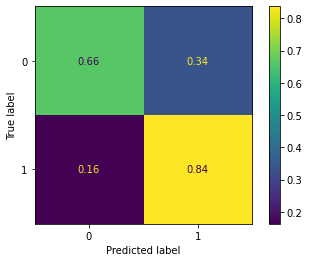

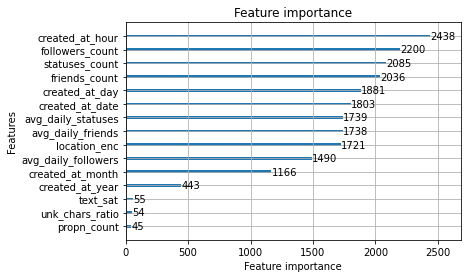

In [30]:
eval_clf(clf_meta_fe, df_test_meta_fe)

### Average probas at the user level

In [31]:
df_train_meta_fe_agg, df_test_meta_fe_agg = get_agg(clf_meta_fe, 
                                                    df_train_meta_fe, 
                                                    df_test_meta_fe, 
                                                    df_train['id'], 
                                                    df_test['id'])
clf_meta_fe_agg = get_best_clf(df_train_meta_fe_agg)

[I 2022-03-29 16:50:49,126] A new study created in memory with name: no-name-0d7818f3-5e93-4642-8ba9-468ed6f44eaf
[I 2022-03-29 16:50:49,456] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 9.39722233775312e-08, 'lambda_l2': 7.35375025854014, 'num_leaves': 176, 'feature_fraction': 0.9715009268875, 'bagging_fraction': 0.4321959414453287, 'bagging_freq': 6, 'learning_rate': 3.471255834558517e-05, 'min_child_samples': 61}. Best is trial 4 with value: 0.5.


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds





Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.998233
Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.999909


[I 2022-03-29 16:50:49,456] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 0.2288597714113402, 'lambda_l2': 2.0658712546783107e-05, 'num_leaves': 3, 'feature_fraction': 0.9993677749771794, 'bagging_fraction': 0.42971373276370595, 'bagging_freq': 6, 'learning_rate': 0.00010105304588673221, 'min_child_samples': 67}. Best is trial 4 with value: 0.5.
[I 2022-03-29 16:50:49,503] Trial 0 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 8.408200151407489e-05, 'lambda_l2': 7.591628808612838, 'num_leaves': 211, 'feature_fraction': 0.5440793821168515, 'bagging_fraction': 0.760202637410422, 'bagging_freq': 6, 'learning_rate': 0.01702708440069042, 'min_child_samples': 16}. Best is trial 0 with value: 0.9971634695184123.
[I 2022-03-29 16:50:49,519] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 0.00047741189100125375, 'lambda_l2': 0.0033051738578887633, 'num_leaves': 253, 'feature_fraction': 0.5793441299531745, 'bagging_fraction': 0.4140818877753

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.999987
Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.999966
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.999947
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's auc: 0.99994
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.999986
Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.999992
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:50:49,691] Trial 8 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 5.304208775723908, 'lambda_l2': 3.735307233986705e-07, 'num_leaves': 60, 'feature_fraction': 0.800685456567887, 'bagging_fraction': 0.5766876340012683, 'bagging_freq': 6, 'learning_rate': 0.17478067038505715, 'min_child_samples': 20}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:49,722] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 5.618687553511621, 'lambda_l2': 4.4311195953352614e-08, 'num_leaves': 51, 'feature_fraction': 0.8879137971390312, 'bagging_fraction': 0.5250856104112327, 'bagging_freq': 2, 'learning_rate': 7.29104168028883e-05, 'min_child_samples': 9}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:49,817] Trial 10 finished with value: 0.5 and parameters: {'lambda_l1': 1.0717700419379033e-08, 'lambda_l2': 4.2065154964696845, 'num_leaves': 89, 'feature_fraction': 0.8551564403298544, 'bagging_fraction': 0.822319

Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.999987
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.999984
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.999984
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:50:49,942] Trial 14 finished with value: 0.5 and parameters: {'lambda_l1': 9.327811979644655e-05, 'lambda_l2': 0.6433187335351972, 'num_leaves': 105, 'feature_fraction': 0.44911142196188525, 'bagging_fraction': 0.4982435539995631, 'bagging_freq': 6, 'learning_rate': 4.836915456428741e-05, 'min_child_samples': 45}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:50,036] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 1.4733873732068461e-05, 'lambda_l2': 4.9282136410058074e-08, 'num_leaves': 160, 'feature_fraction': 0.6348514441550341, 'bagging_fraction': 0.613867954826474, 'bagging_freq': 4, 'learning_rate': 2.47597483128713e-05, 'min_child_samples': 37}. Best is trial 7 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.999964
Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.999979
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.999986


[I 2022-03-29 16:50:50,115] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 0.007895402604959034, 'lambda_l2': 1.1530703733602827e-07, 'num_leaves': 140, 'feature_fraction': 0.9827963645149407, 'bagging_fraction': 0.4166670338092096, 'bagging_freq': 1, 'learning_rate': 0.0017306442515224048, 'min_child_samples': 10}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:50,209] Trial 12 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 1.089497289669697e-08, 'lambda_l2': 2.997425840511772e-08, 'num_leaves': 187, 'feature_fraction': 0.9541368988544779, 'bagging_fraction': 0.6623249505464465, 'bagging_freq': 2, 'learning_rate': 0.06465357382179558, 'min_child_samples': 70}. Best is trial 7 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.999986
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 16:50:50,319] Trial 15 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 4.924657684601571e-07, 'lambda_l2': 1.031972397010117e-05, 'num_leaves': 52, 'feature_fraction': 0.4007348694393419, 'bagging_fraction': 0.6925698858727323, 'bagging_freq': 3, 'learning_rate': 0.021605117093880185, 'min_child_samples': 12}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:50,428] Trial 16 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.1206598543321891e-07, 'lambda_l2': 7.546799331998378e-07, 'num_leaves': 166, 'feature_fraction': 0.6192907760871071, 'bagging_fraction': 0.6843108478846543, 'bagging_freq': 6, 'learning_rate': 0.05876452935162512, 'min_child_samples': 58}. Best is trial 7 with value: 0.9982364308918028.



Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.999987
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.999986


[I 2022-03-29 16:50:50,522] Trial 17 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 8.659342582098955e-07, 'lambda_l2': 0.0004234847786493449, 'num_leaves': 116, 'feature_fraction': 0.4291031403476415, 'bagging_fraction': 0.985248328218193, 'bagging_freq': 1, 'learning_rate': 0.010395932006368104, 'min_child_samples': 39}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:50,616] Trial 18 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.047698134095174795, 'lambda_l2': 9.9318975760672e-07, 'num_leaves': 121, 'feature_fraction': 0.7402280160657564, 'bagging_fraction': 0.5902424933552205, 'bagging_freq': 1, 'learning_rate': 0.2629459510992799, 'min_child_samples': 36}. Best is trial 7 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.999979
Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.999989
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 16:50:50,741] Trial 19 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.04847728977505385, 'lambda_l2': 7.811350760044082e-07, 'num_leaves': 134, 'feature_fraction': 0.7436692089918505, 'bagging_fraction': 0.5764997225582205, 'bagging_freq': 1, 'learning_rate': 0.27335588483723444, 'min_child_samples': 33}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:50,820] Trial 20 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.015756618615747293, 'lambda_l2': 1.405337616262347e-06, 'num_leaves': 123, 'feature_fraction': 0.7626358693355025, 'bagging_fraction': 0.6006689908366475, 'bagging_freq': 1, 'learning_rate': 0.29545783316876595, 'min_child_samples': 32}. Best is trial 7 with value: 0.9982364308918028.



Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.999987
Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.999993
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.999987
Training until validation scores don't improve for 100 roundsDid not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999982



[I 2022-03-29 16:50:50,914] Trial 21 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 1.0186719445690265e-06, 'lambda_l2': 2.065270216072151e-06, 'num_leaves': 20, 'feature_fraction': 0.7921026043174855, 'bagging_fraction': 0.6159909599789766, 'bagging_freq': 3, 'learning_rate': 0.21266912660421275, 'min_child_samples': 33}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:50,976] Trial 22 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 6.40913349626074e-07, 'lambda_l2': 1.5348401744336304e-06, 'num_leaves': 22, 'feature_fraction': 0.7663355678997806, 'bagging_fraction': 0.5654065845830336, 'bagging_freq': 5, 'learning_rate': 0.01274357280510279, 'min_child_samples': 31}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:51,076] Trial 23 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.05093380869601904, 'lambda_l2': 8.784185658320287e-07, 'num_leaves': 120, 'feature_fraction': 0.7722

Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999987
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.999981


[I 2022-03-29 16:50:51,181] Trial 24 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.018037935217143874, 'lambda_l2': 0.00010022331503820168, 'num_leaves': 21, 'feature_fraction': 0.7861176703925373, 'bagging_fraction': 0.5937280857891627, 'bagging_freq': 1, 'learning_rate': 0.00813183752721514, 'min_child_samples': 78}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:51,291] Trial 25 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.039512116917137664, 'lambda_l2': 7.494692268498575e-07, 'num_leaves': 21, 'feature_fraction': 0.7789502150854359, 'bagging_fraction': 0.5948227416302022, 'bagging_freq': 2, 'learning_rate': 0.2827465328859608, 'min_child_samples': 79}. Best is trial 7 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.99999
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.999969
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:50:51,353] Trial 26 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.00875140371226204, 'lambda_l2': 1.31206560807417e-06, 'num_leaves': 231, 'feature_fraction': 0.7493956566867312, 'bagging_fraction': 0.6350191553001674, 'bagging_freq': 2, 'learning_rate': 0.0046340412947312145, 'min_child_samples': 79}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:51,479] Trial 27 finished with value: 0.5 and parameters: {'lambda_l1': 0.2430505257322911, 'lambda_l2': 6.868249549630592e-05, 'num_leaves': 255, 'feature_fraction': 0.7059035730156948, 'bagging_fraction': 0.8547770956018125, 'bagging_freq': 2, 'learning_rate': 0.00040780328422240894, 'min_child_samples': 75}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:51,577] Trial 28 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.1635683966386919, 'lambda_l2': 4.740813485696663e-05, 'num_leaves': 202, 'feature_fraction': 0.701443065222502, 'ba

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.999958
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.999986
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.999982
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:50:51,667] Trial 29 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.15892624396964738, 'lambda_l2': 4.0513264808000373e-05, 'num_leaves': 4, 'feature_fraction': 0.6949556257452041, 'bagging_fraction': 0.520589932116566, 'bagging_freq': 2, 'learning_rate': 0.004941542228570195, 'min_child_samples': 27}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:51,761] Trial 30 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.2617158502664641, 'lambda_l2': 5.1608536337560055e-05, 'num_leaves': 140, 'feature_fraction': 0.6946368772197494, 'bagging_fraction': 0.5362679201973354, 'bagging_freq': 2, 'learning_rate': 0.0044694519348072404, 'min_child_samples': 26}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:51,839] Trial 31 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.4805863321313042, 'lambda_l2': 8.693782586612683e-05, 'num_leaves': 82, 'feature_fraction': 0.67344503

Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.999982
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.999986
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.999986


[I 2022-03-29 16:50:51,949] Trial 33 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 1.0749290377739218, 'lambda_l2': 4.6649811215720445e-05, 'num_leaves': 244, 'feature_fraction': 0.6832520192482742, 'bagging_fraction': 0.5124522259530452, 'bagging_freq': 5, 'learning_rate': 0.04655529535204977, 'min_child_samples': 79}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:51,965] Trial 32 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 3.0310218848505825e-06, 'lambda_l2': 9.237069135506728e-05, 'num_leaves': 22, 'feature_fraction': 0.6683000459580486, 'bagging_fraction': 0.653006041725344, 'bagging_freq': 2, 'learning_rate': 0.05711332037101775, 'min_child_samples': 25}. Best is trial 7 with value: 0.9982364308918028.


Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.999984
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.999965
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:50:52,078] Trial 34 finished with value: 0.5 and parameters: {'lambda_l1': 0.6855238980993094, 'lambda_l2': 5.828670534231963e-05, 'num_leaves': 232, 'feature_fraction': 0.6912856919659409, 'bagging_fraction': 0.5079544748674464, 'bagging_freq': 2, 'learning_rate': 0.0005916282206862975, 'min_child_samples': 81}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:52,200] Trial 35 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 4.674254864335523, 'lambda_l2': 0.0018838624295791542, 'num_leaves': 40, 'feature_fraction': 0.8291637216927122, 'bagging_fraction': 0.48599299596740364, 'bagging_freq': 7, 'learning_rate': 0.05230984527245177, 'min_child_samples': 84}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:52,294] Trial 36 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.43924698486377944, 'lambda_l2': 0.0015899179182520611, 'num_leaves': 227, 'feature_fraction': 0.6696889715956047, 'bagg

Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.999984
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.999938
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:50:52,404] Trial 37 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.002895296411457086, 'lambda_l2': 0.0012296600604739605, 'num_leaves': 220, 'feature_fraction': 0.6591539810228491, 'bagging_fraction': 0.5060911068177404, 'bagging_freq': 3, 'learning_rate': 0.0037489006036099215, 'min_child_samples': 88}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:52,498] Trial 38 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.4328817120890942, 'lambda_l2': 1.7221358922939863e-07, 'num_leaves': 143, 'feature_fraction': 0.5209526307040939, 'bagging_fraction': 0.47318565194705897, 'bagging_freq': 1, 'learning_rate': 0.05901579052825611, 'min_child_samples': 44}. Best is trial 7 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.999933
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.999986


[I 2022-03-29 16:50:52,592] Trial 39 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.3042012743918923, 'lambda_l2': 1.5509592859294641e-07, 'num_leaves': 95, 'feature_fraction': 0.5232313810502762, 'bagging_fraction': 0.6598187319805605, 'bagging_freq': 1, 'learning_rate': 0.057937088431941355, 'min_child_samples': 45}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:52,686] Trial 40 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.516882062669325, 'lambda_l2': 0.0010807175481593707, 'num_leaves': 233, 'feature_fraction': 0.5301685032747044, 'bagging_fraction': 0.46294577770639517, 'bagging_freq': 3, 'learning_rate': 0.10024526227232443, 'min_child_samples': 43}. Best is trial 7 with value: 0.9982364308918028.


Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.999986
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.999987
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.999986


[I 2022-03-29 16:50:52,796] Trial 41 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.1257652162796862e-05, 'lambda_l2': 0.0022343451527659006, 'num_leaves': 38, 'feature_fraction': 0.5234814733963415, 'bagging_fraction': 0.48209934247822145, 'bagging_freq': 3, 'learning_rate': 0.03249318757033214, 'min_child_samples': 87}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:52,858] Trial 42 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.0007043665109935952, 'lambda_l2': 0.0022703265273719287, 'num_leaves': 232, 'feature_fraction': 0.8408985570780789, 'bagging_fraction': 0.44956029872042863, 'bagging_freq': 3, 'learning_rate': 0.02727320301163295, 'min_child_samples': 89}. Best is trial 7 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.999984
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.999984
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.999987


[I 2022-03-29 16:50:52,980] Trial 43 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.0009295479989159751, 'lambda_l2': 0.006413690008174102, 'num_leaves': 35, 'feature_fraction': 0.8331667705486921, 'bagging_fraction': 0.4449974214931945, 'bagging_freq': 7, 'learning_rate': 0.023326690637761667, 'min_child_samples': 44}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:52,984] Trial 44 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.1953807321949974, 'lambda_l2': 0.0003589875917494417, 'num_leaves': 80, 'feature_fraction': 0.5500604328103218, 'bagging_fraction': 0.7317160757299231, 'bagging_freq': 3, 'learning_rate': 0.03300946345998882, 'min_child_samples': 17}. Best is trial 7 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999984


[I 2022-03-29 16:50:53,172] Trial 45 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.000153016133463483, 'lambda_l2': 4.830156971846091e-06, 'num_leaves': 94, 'feature_fraction': 0.5566197956411674, 'bagging_fraction': 0.7424592480020188, 'bagging_freq': 5, 'learning_rate': 0.11011286025697985, 'min_child_samples': 46}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:53,266] Trial 46 finished with value: 0.5 and parameters: {'lambda_l1': 0.0014729015384006238, 'lambda_l2': 0.023905144896325444, 'num_leaves': 99, 'feature_fraction': 0.7323709526149776, 'bagging_fraction': 0.46713983383558216, 'bagging_freq': 5, 'learning_rate': 0.0006687393835371082, 'min_child_samples': 50}. Best is trial 7 with value: 0.9982364308918028.


Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.999956
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.999987


[I 2022-03-29 16:50:53,408] Trial 47 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.0002723732789011591, 'lambda_l2': 5.206215206785169e-06, 'num_leaves': 119, 'feature_fraction': 0.8238886487141119, 'bagging_fraction': 0.5613256129146551, 'bagging_freq': 5, 'learning_rate': 0.1273825274683268, 'min_child_samples': 19}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:53,502] Trial 48 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.04967025958980719, 'lambda_l2': 0.01682035284022036, 'num_leaves': 121, 'feature_fraction': 0.728433124666647, 'bagging_fraction': 0.5866355146803833, 'bagging_freq': 1, 'learning_rate': 0.1156675822000778, 'min_child_samples': 18}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:53,611] Trial 49 finished with value: 0.5 and parameters: {'lambda_l1': 0.00022157386765323306, 'lambda_l2': 4.157467862759202e-06, 'num_leaves': 124, 'feature_fraction': 0.7406429017313796, 'bag

Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.999987
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.999986
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999985


[I 2022-03-29 16:50:53,706] Trial 50 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.000282962331162229, 'lambda_l2': 3.4080977581236513e-06, 'num_leaves': 13, 'feature_fraction': 0.7930972527149049, 'bagging_fraction': 0.5518564355059763, 'bagging_freq': 5, 'learning_rate': 0.014753639224313421, 'min_child_samples': 18}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:53,737] Trial 51 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.000225691194615751, 'lambda_l2': 0.014255344627772894, 'num_leaves': 22, 'feature_fraction': 0.8002025136735895, 'bagging_fraction': 0.5314217004411784, 'bagging_freq': 5, 'learning_rate': 0.015493447439712793, 'min_child_samples': 100}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:53,768] Trial 52 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.00017999601193823241, 'lambda_l2': 0.022586114758795982, 'num_leaves': 15, 'feature_fraction': 0.806

Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.999981
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.999981
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.999981
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.999968


[I 2022-03-29 16:50:53,862] Trial 53 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.053413676332757405, 'lambda_l2': 1.209916817364353e-05, 'num_leaves': 4, 'feature_fraction': 0.7984398220095072, 'bagging_fraction': 0.5521937881777395, 'bagging_freq': 5, 'learning_rate': 0.01243670396536281, 'min_child_samples': 95}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:53,925] Trial 54 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.03902592642364112, 'lambda_l2': 1.1837545229901569e-05, 'num_leaves': 190, 'feature_fraction': 0.8032355232013085, 'bagging_fraction': 0.5476028878149264, 'bagging_freq': 4, 'learning_rate': 0.007119358604542817, 'min_child_samples': 94}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:54,144] Trial 55 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 2.8651281313016278e-05, 'lambda_l2': 1.0973697342746739e-05, 'num_leaves': 16, 'feature_fraction': 0.787

Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.999981
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.999983
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:50:54,348] Trial 57 finished with value: 0.5 and parameters: {'lambda_l1': 0.007653288818777347, 'lambda_l2': 0.0001519975427541226, 'num_leaves': 2, 'feature_fraction': 0.6225863381534928, 'bagging_fraction': 0.7955406657582562, 'bagging_freq': 2, 'learning_rate': 0.0028611027240370446, 'min_child_samples': 63}. Best is trial 7 with value: 0.9982364308918028.


Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.998233
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:50:54,536] Trial 58 finished with value: 0.5 and parameters: {'lambda_l1': 0.012278153908845967, 'lambda_l2': 1.4666951593971984e-05, 'num_leaves': 198, 'feature_fraction': 0.8743628785344199, 'bagging_fraction': 0.6125107933161238, 'bagging_freq': 4, 'learning_rate': 0.006284332862557418, 'min_child_samples': 65}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:54,630] Trial 62 finished with value: 0.5 and parameters: {'lambda_l1': 0.008825368795979728, 'lambda_l2': 3.4695193362440663e-07, 'num_leaves': 61, 'feature_fraction': 0.7769890307856904, 'bagging_fraction': 0.6071789244388897, 'bagging_freq': 4, 'learning_rate': 1.0504566823477945e-05, 'min_child_samples': 32}. Best is trial 7 with value: 0.9982364308918028.


Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.999958
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.999979
Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.999986Training until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.999985Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.99999



[I 2022-03-29 16:50:54,740] Trial 61 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.014388432800480655, 'lambda_l2': 1.5441794687567463e-06, 'num_leaves': 153, 'feature_fraction': 0.895676914451494, 'bagging_fraction': 0.6113722950377372, 'bagging_freq': 4, 'learning_rate': 0.18765681639146856, 'min_child_samples': 32}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:54,740] Trial 59 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.008457491432939414, 'lambda_l2': 1.7677993073646794e-05, 'num_leaves': 208, 'feature_fraction': 0.8704102423201188, 'bagging_fraction': 0.6156293851426786, 'bagging_freq': 2, 'learning_rate': 0.18128376994450007, 'min_child_samples': 30}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:54,756] Trial 60 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.014944942760324396, 'lambda_l2': 1.8994592976631517e-05, 'num_leaves': 201, 'feature_fraction': 0.62

Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.999956
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.999986
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.999984


[I 2022-03-29 16:50:54,991] Trial 65 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.01920276493766631, 'lambda_l2': 1.988488550646827e-06, 'num_leaves': 46, 'feature_fraction': 0.8810042497032409, 'bagging_fraction': 0.61263648581778, 'bagging_freq': 4, 'learning_rate': 0.1617575348088813, 'min_child_samples': 31}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:55,054] Trial 63 finished with value: 0.5 and parameters: {'lambda_l1': 3.6714910236566684e-05, 'lambda_l2': 1.858601172129705e-06, 'num_leaves': 63, 'feature_fraction': 0.6320287179523612, 'bagging_fraction': 0.7723686433945244, 'bagging_freq': 2, 'learning_rate': 0.0031799652428510304, 'min_child_samples': 5}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:55,284] Trial 66 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 3.7669697238497676e-08, 'lambda_l2': 1.7437874899809143e-06, 'num_leaves': 158, 'feature_fraction': 0.7716854083915291, '

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.999989
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:50:55,384] Trial 67 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 5.187532834781992e-08, 'lambda_l2': 1.7605252656394442e-06, 'num_leaves': 111, 'feature_fraction': 0.7213198395457857, 'bagging_fraction': 0.6734089597859206, 'bagging_freq': 1, 'learning_rate': 0.2061234054067753, 'min_child_samples': 32}. Best is trial 7 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.999987
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.999298


[I 2022-03-29 16:50:55,556] Trial 71 finished with value: 0.5 and parameters: {'lambda_l1': 9.712756155602717, 'lambda_l2': 0.00017485918976766147, 'num_leaves': 245, 'feature_fraction': 0.5976105879834711, 'bagging_fraction': 0.40328682031151153, 'bagging_freq': 7, 'learning_rate': 0.0014512148216776885, 'min_child_samples': 26}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:55,619] Trial 68 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.11965241098409861, 'lambda_l2': 0.00783277746092612, 'num_leaves': 33, 'feature_fraction': 0.7494278471521544, 'bagging_fraction': 0.5274143714322196, 'bagging_freq': 2, 'learning_rate': 0.03956485880591686, 'min_child_samples': 27}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:55,713] Trial 72 finished with value: 0.5 and parameters: {'lambda_l1': 8.005628768998381, 'lambda_l2': 0.0001455789382455352, 'num_leaves': 246, 'feature_fraction': 0.5990884088472104, 'bagging_fraction': 0.

Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.999984
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.998233
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.999979
Did not meet early stopping. Best iteration is:
[2]	valid_0's auc: 0.998233


[I 2022-03-29 16:50:55,807] Trial 73 finished with value: 0.5 and parameters: {'lambda_l1': 7.418815739758128, 'lambda_l2': 0.00014362208234818888, 'num_leaves': 32, 'feature_fraction': 0.6644391622041802, 'bagging_fraction': 0.6829424389518493, 'bagging_freq': 7, 'learning_rate': 0.0018020329316971574, 'min_child_samples': 27}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:55,823] Trial 69 finished with value: 0.5 and parameters: {'lambda_l1': 0.003128009930583585, 'lambda_l2': 1.282098425238969e-08, 'num_leaves': 32, 'feature_fraction': 0.764260104325357, 'bagging_fraction': 0.6809872401241862, 'bagging_freq': 7, 'learning_rate': 0.001388755063282989, 'min_child_samples': 28}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:55,901] Trial 70 finished with value: 0.9848066298342542 and parameters: {'lambda_l1': 0.10331199983455741, 'lambda_l2': 0.006328756385597813, 'num_leaves': 37, 'feature_fraction': 0.5975776402172804, 'bagging_fraction': 0

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.999981
Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.999984
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.999986


[I 2022-03-29 16:50:56,073] Trial 75 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 8.509867185510052, 'lambda_l2': 0.00023387116413608764, 'num_leaves': 243, 'feature_fraction': 0.6633147469422822, 'bagging_fraction': 0.646222041643026, 'bagging_freq': 7, 'learning_rate': 0.08402376932718568, 'min_child_samples': 22}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:56,308] Trial 76 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.1538822814976687, 'lambda_l2': 0.2248644686478705, 'num_leaves': 74, 'feature_fraction': 0.7512614429490821, 'bagging_fraction': 0.6411869144056027, 'bagging_freq': 6, 'learning_rate': 0.007454851448700969, 'min_child_samples': 93}. Best is trial 7 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.999967
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:50:56,418] Trial 77 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.07242853018724983, 'lambda_l2': 7.494791728369039e-07, 'num_leaves': 180, 'feature_fraction': 0.7570718004966103, 'bagging_fraction': 0.5830825035568633, 'bagging_freq': 5, 'learning_rate': 0.0860152575924638, 'min_child_samples': 78}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:56,559] Trial 78 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.003446909571408624, 'lambda_l2': 0.12490680502581386, 'num_leaves': 25, 'feature_fraction': 0.8562292485084486, 'bagging_fraction': 0.5858808383102568, 'bagging_freq': 6, 'learning_rate': 0.008097976678449267, 'min_child_samples': 77}. Best is trial 7 with value: 0.9982364308918028.


Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.999985
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.999984
Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.999986
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.999984

[I 2022-03-29 16:50:56,622] Trial 81 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.4220843237511408, 'lambda_l2': 0.0008314097594056394, 'num_leaves': 221, 'feature_fraction': 0.6710899082273719, 'bagging_fraction': 0.43542075567740746, 'bagging_freq': 3, 'learning_rate': 0.07675417583681703, 'min_child_samples': 85}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:56,669] Trial 79 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 3.163344864957853, 'lambda_l2': 0.11240472838047745, 'num_leaves': 222, 'feature_fraction': 0.7570079290677235, 'bagging_fraction': 0.4372118058087771, 'bagging_freq': 3, 'learning_rate': 0.0243888455644981, 'min_child_samples': 85}. Best is trial 7 with value: 0.9982364308918028.



Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.999984
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.999984
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.999984

[I 2022-03-29 16:50:56,826] Trial 83 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 3.4404625943909886, 'lambda_l2': 0.0007408542709766555, 'num_leaves': 219, 'feature_fraction': 0.65350493656152, 'bagging_fraction': 0.4275942575756066, 'bagging_freq': 3, 'learning_rate': 0.02356092416147043, 'min_child_samples': 85}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:56,842] Trial 82 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.4826818840895495, 'lambda_l2': 0.0006818573260293467, 'num_leaves': 219, 'feature_fraction': 0.6668092917750147, 'bagging_fraction': 0.43679318564802594, 'bagging_freq': 3, 'learning_rate': 0.02392703538092809, 'min_child_samples': 85}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:56,904] Trial 80 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.08545793633245428, 'lambda_l2': 6.493463055895338e-07, 'num_leaves': 217, 'feature_fraction': 0.6739488580


Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.999983
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:50:56,987] Trial 84 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.4153148487234701, 'lambda_l2': 0.6973987409558257, 'num_leaves': 12, 'feature_fraction': 0.7191665799512126, 'bagging_fraction': 0.5780473796987756, 'bagging_freq': 6, 'learning_rate': 0.00601953685174903, 'min_child_samples': 76}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:57,155] Trial 85 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.33929858886762315, 'lambda_l2': 0.0006516562765192813, 'num_leaves': 176, 'feature_fraction': 0.7139752734966338, 'bagging_fraction': 0.5892968070972165, 'bagging_freq': 2, 'learning_rate': 0.004962229117757565, 'min_child_samples': 76}. Best is trial 7 with value: 0.9982364308918028.


Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.999981
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:50:57,328] Trial 86 finished with value: 0.9980823038436916 and parameters: {'lambda_l1': 0.029242753039813305, 'lambda_l2': 3.6331995501418375e-05, 'num_leaves': 171, 'feature_fraction': 0.91995043423261, 'bagging_fraction': 0.575157000062189, 'bagging_freq': 3, 'learning_rate': 0.020152329289517358, 'min_child_samples': 13}. Best is trial 7 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.999986
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:50:57,422] Trial 87 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.4043772718147297, 'lambda_l2': 0.0007942458952500413, 'num_leaves': 216, 'feature_fraction': 0.6834753528391669, 'bagging_fraction': 0.4983573199109899, 'bagging_freq': 2, 'learning_rate': 0.019683913201213387, 'min_child_samples': 81}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:57,500] Trial 88 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.4233513567819812, 'lambda_l2': 4.404668134822632e-05, 'num_leaves': 219, 'feature_fraction': 0.6821648336674665, 'bagging_fraction': 0.7009072650025457, 'bagging_freq': 2, 'learning_rate': 0.005343172501054573, 'min_child_samples': 71}. Best is trial 7 with value: 0.9982364308918028.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.999984
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.99997
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.999983Training until validation scores don't improve for 100 rounds



[I 2022-03-29 16:50:57,626] Trial 89 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.6538303600372996, 'lambda_l2': 3.11167927564223e-05, 'num_leaves': 209, 'feature_fraction': 0.6824702515277842, 'bagging_fraction': 0.704494372321346, 'bagging_freq': 2, 'learning_rate': 0.017138182237919786, 'min_child_samples': 90}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:57,704] Trial 90 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 2.250688265469172, 'lambda_l2': 2.9926264434861975e-05, 'num_leaves': 151, 'feature_fraction': 0.6850273141043313, 'bagging_fraction': 0.4960193256832244, 'bagging_freq': 5, 'learning_rate': 0.017667852208122174, 'min_child_samples': 90}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:57,798] Trial 91 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 2.565432033594038, 'lambda_l2': 8.769367720748015e-05, 'num_leaves': 150, 'feature_fraction': 0.82793233271

Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.999981
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.999981
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999986


[I 2022-03-29 16:50:57,892] Trial 92 finished with value: 0.9976999502051076 and parameters: {'lambda_l1': 0.0006321595131607057, 'lambda_l2': 0.005544601358307374, 'num_leaves': 228, 'feature_fraction': 0.8215582644320671, 'bagging_fraction': 0.5023309647413615, 'bagging_freq': 5, 'learning_rate': 0.01767247964775843, 'min_child_samples': 13}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:57,923] Trial 93 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.00045024619579493003, 'lambda_l2': 0.02232631605839703, 'num_leaves': 10, 'feature_fraction': 0.8286309855584465, 'bagging_fraction': 0.5011043808808643, 'bagging_freq': 5, 'learning_rate': 0.016769983215210178, 'min_child_samples': 12}. Best is trial 7 with value: 0.9982364308918028.
[I 2022-03-29 16:50:57,955] Trial 94 finished with value: 0.9976999502051076 and parameters: {'lambda_l1': 2.2246759614253984, 'lambda_l2': 3.082129926078715e-05, 'num_leaves': 83, 'feature_fraction': 0.6924351

Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.999986
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.999984
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.999936
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.998914
Did not meet early stopping. Best iteration is:
[55]	valid_0's auc: 0.999984
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.999985


[I 2022-03-29 16:50:58,089] Trial 98 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 1.8357606785962495e-06, 'lambda_l2': 0.0014909324615581638, 'num_leaves': 107, 'feature_fraction': 0.6501841478675178, 'bagging_fraction': 0.5155300811547209, 'bagging_freq': 1, 'learning_rate': 0.0433268378746029, 'min_child_samples': 36}. Best is trial 7 with value: 0.9982364308918028.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.999986
{'lambda_l1': 1.1644964657884081e-07, 'lambda_l2': 2.740709744461994e-08, 'num_leaves': 176, 'feature_fraction': 0.9392817139221183, 'bagging_fraction': 0.4096146938578828, 'bagging_freq': 4, 'learning_rate': 0.1323398667658064, 'min_child_samples': 56} -> 0.9982364308918028
[LightGBM] [Warning] feature_fraction is set=0.9392817139221183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9392817139221183
[LightGBM] [Warning] lambda_l1 is set=1.1644964657884081e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1644964657884081e-07
[LightGBM] [Warning] bagging_fraction is set=0.4096146938578828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4096146938578828
[LightGBM] [Warning] lambda_l2 is set=2.740709744461994e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.740709744461994e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will

AUROC: 0.7272790055248618
Accuracy: 0.7311918850380389


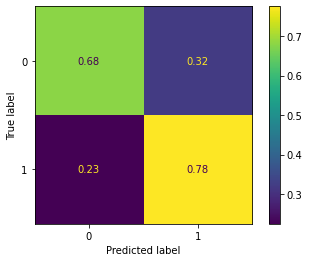

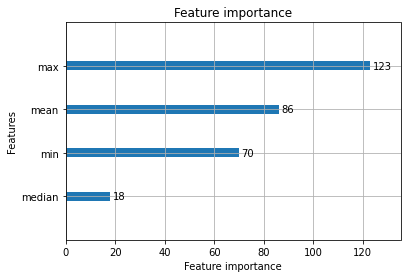

In [32]:
eval_clf(clf_meta_fe_agg, df_test_meta_fe_agg)

### Average features at the user level

> Mean

In [33]:
df_train_meta_fe_mean = get_mean(df_train_meta_fe, df_train['id'])
df_test_meta_fe_mean = get_mean(df_test_meta_fe, df_test['id'])

clf_meta_fe_mean = get_best_clf(df_train_meta_fe_mean)

[I 2022-03-29 16:50:59,633] A new study created in memory with name: no-name-0e66b216-0a90-4aa8-bb45-bd09051bffa5


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:00,731] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 4.14706667242188, 'lambda_l2': 0.005377507985345178, 'num_leaves': 189, 'feature_fraction': 0.5197292721698481, 'bagging_fraction': 0.6503028833737978, 'bagging_freq': 2, 'learning_rate': 0.0004987044901888252, 'min_child_samples': 96}. Best is trial 4 with value: 0.5.
[I 2022-03-29 16:51:00,825] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 0.02510919855165594, 'lambda_l2': 9.182400383556396e-08, 'num_leaves': 21, 'feature_fraction': 0.4347205984258824, 'bagging_fraction': 0.6970460726747594, 'bagging_freq': 5, 'learning_rate': 0.000351936751419269, 'min_child_samples': 60}. Best is trial 4 with value: 0.5.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.870295
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.871717
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:00,935] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 1.4709060914518882e-08, 'lambda_l2': 9.824231648426824, 'num_leaves': 230, 'feature_fraction': 0.8530103574441805, 'bagging_fraction': 0.5151850180130086, 'bagging_freq': 7, 'learning_rate': 4.713315385107281e-05, 'min_child_samples': 46}. Best is trial 4 with value: 0.5.
[I 2022-03-29 16:51:01,091] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 9.354576015569222e-05, 'lambda_l2': 8.344527219396685, 'num_leaves': 212, 'feature_fraction': 0.713962179016858, 'bagging_fraction': 0.8872508215914616, 'bagging_freq': 6, 'learning_rate': 1.0912714086058845e-05, 'min_child_samples': 76}. Best is trial 4 with value: 0.5.


Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.863592
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.870897


[I 2022-03-29 16:51:01,311] Trial 5 finished with value: 0.8009478813458848 and parameters: {'lambda_l1': 0.012654737629857632, 'lambda_l2': 1.753165207263786e-08, 'num_leaves': 56, 'feature_fraction': 0.5830559285750159, 'bagging_fraction': 0.5157575930828346, 'bagging_freq': 2, 'learning_rate': 0.02687880599850358, 'min_child_samples': 69}. Best is trial 5 with value: 0.8009478813458848.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.891456


[I 2022-03-29 16:51:01,421] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 7.726079551803543e-08, 'lambda_l2': 9.405785701127026e-05, 'num_leaves': 213, 'feature_fraction': 0.5580290012350906, 'bagging_fraction': 0.8044436382250746, 'bagging_freq': 4, 'learning_rate': 5.9868213297613875e-05, 'min_child_samples': 98}. Best is trial 5 with value: 0.8009478813458848.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.875442
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.866064


[I 2022-03-29 16:51:01,593] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 0.00016134304382654687, 'lambda_l2': 0.012007174408140496, 'num_leaves': 12, 'feature_fraction': 0.8208258659540124, 'bagging_fraction': 0.41928306415731437, 'bagging_freq': 2, 'learning_rate': 3.863168515516439e-05, 'min_child_samples': 20}. Best is trial 5 with value: 0.8009478813458848.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:02,252] Trial 3 finished with value: 0.6126490882792308 and parameters: {'lambda_l1': 1.6345224284096482e-08, 'lambda_l2': 1.4904363736438792e-06, 'num_leaves': 82, 'feature_fraction': 0.6180521412905527, 'bagging_fraction': 0.6546534264427613, 'bagging_freq': 3, 'learning_rate': 0.001541740195879515, 'min_child_samples': 50}. Best is trial 5 with value: 0.8009478813458848.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.881318
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:02,738] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 0.0037056646442015116, 'lambda_l2': 0.024310920540689594, 'num_leaves': 207, 'feature_fraction': 0.5491842865621608, 'bagging_fraction': 0.4818944657861671, 'bagging_freq': 2, 'learning_rate': 0.0001652995146661094, 'min_child_samples': 61}. Best is trial 5 with value: 0.8009478813458848.


Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.877776
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:03,099] Trial 6 finished with value: 0.8080821852844238 and parameters: {'lambda_l1': 0.1775626691380808, 'lambda_l2': 0.002822647867525679, 'num_leaves': 131, 'feature_fraction': 0.9184003841937717, 'bagging_fraction': 0.8808587686235361, 'bagging_freq': 5, 'learning_rate': 0.03656390749630762, 'min_child_samples': 46}. Best is trial 6 with value: 0.8080821852844238.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.892658
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:03,700] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 2.5126828133705117, 'lambda_l2': 0.03569194706311155, 'num_leaves': 149, 'feature_fraction': 0.4591281394917487, 'bagging_fraction': 0.8985939970814263, 'bagging_freq': 3, 'learning_rate': 0.000360989977791056, 'min_child_samples': 30}. Best is trial 6 with value: 0.8080821852844238.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.879707
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:03,962] Trial 10 finished with value: 0.8036362127427501 and parameters: {'lambda_l1': 1.3243385808806317e-06, 'lambda_l2': 1.3321759082402863e-07, 'num_leaves': 168, 'feature_fraction': 0.5890588026474647, 'bagging_fraction': 0.5054446787467263, 'bagging_freq': 7, 'learning_rate': 0.034718809511009086, 'min_child_samples': 30}. Best is trial 6 with value: 0.8080821852844238.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.893725
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:04,416] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 0.025431535791776115, 'lambda_l2': 1.559405782765847e-05, 'num_leaves': 60, 'feature_fraction': 0.9373326763344707, 'bagging_fraction': 0.5042883438452765, 'bagging_freq': 2, 'learning_rate': 0.00012426171838872296, 'min_child_samples': 60}. Best is trial 6 with value: 0.8080821852844238.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.878775
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:05,891] Trial 17 finished with value: 0.8111528703198729 and parameters: {'lambda_l1': 7.458844700200483, 'lambda_l2': 0.00011088978735561441, 'num_leaves': 145, 'feature_fraction': 0.997668597524843, 'bagging_fraction': 0.9842099388704867, 'bagging_freq': 5, 'learning_rate': 0.15645679533685572, 'min_child_samples': 25}. Best is trial 17 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.895363
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:07,114] Trial 15 finished with value: 0.8011879638631352 and parameters: {'lambda_l1': 0.01137159434180216, 'lambda_l2': 1.1064316048953693e-07, 'num_leaves': 161, 'feature_fraction': 0.47439604704309746, 'bagging_fraction': 0.4483251272097785, 'bagging_freq': 2, 'learning_rate': 0.1226312308900951, 'min_child_samples': 16}. Best is trial 17 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.884259
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:07,945] Trial 13 finished with value: 0.8030256325136936 and parameters: {'lambda_l1': 5.103261298667184e-07, 'lambda_l2': 0.0005506445597378176, 'num_leaves': 201, 'feature_fraction': 0.8701218943398439, 'bagging_fraction': 0.5969612663120902, 'bagging_freq': 6, 'learning_rate': 0.17392084439676736, 'min_child_samples': 17}. Best is trial 17 with value: 0.8111528703198729.
[I 2022-03-29 16:51:08,024] Trial 18 finished with value: 0.8067009698148104 and parameters: {'lambda_l1': 0.06641171418006615, 'lambda_l2': 2.703516289312462e-05, 'num_leaves': 89, 'feature_fraction': 0.9624072003677501, 'bagging_fraction': 0.9546376699196281, 'bagging_freq': 1, 'learning_rate': 0.06008494613877073, 'min_child_samples': 6}. Best is trial 17 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.881779
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.893606
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:08,541] Trial 14 finished with value: 0.5728220662509188 and parameters: {'lambda_l1': 3.4583111091774815e-07, 'lambda_l2': 0.08396495594517014, 'num_leaves': 249, 'feature_fraction': 0.7259793227547028, 'bagging_fraction': 0.6648878391802846, 'bagging_freq': 4, 'learning_rate': 0.0014557323820025099, 'min_child_samples': 13}. Best is trial 17 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.888657
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:08,964] Trial 8 finished with value: 0.8151364617172123 and parameters: {'lambda_l1': 1.3696343511751008, 'lambda_l2': 0.06340409605275771, 'num_leaves': 251, 'feature_fraction': 0.6665756292814871, 'bagging_fraction': 0.7694767176892763, 'bagging_freq': 6, 'learning_rate': 0.10232504996622985, 'min_child_samples': 7}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.8932
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:09,686] Trial 19 finished with value: 0.8123858867047637 and parameters: {'lambda_l1': 2.0630764780898048e-06, 'lambda_l2': 2.7471582994853716e-05, 'num_leaves': 141, 'feature_fraction': 0.9968183574733369, 'bagging_fraction': 0.9746179792956591, 'bagging_freq': 7, 'learning_rate': 0.16026625822077742, 'min_child_samples': 34}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.894175
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:10,909] Trial 26 finished with value: 0.7846637659165817 and parameters: {'lambda_l1': 9.249769661442977, 'lambda_l2': 0.3296342314866072, 'num_leaves': 121, 'feature_fraction': 0.7779224166268459, 'bagging_fraction': 0.7915794026619297, 'bagging_freq': 6, 'learning_rate': 0.012070266272789936, 'min_child_samples': 30}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.877514
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:11,176] Trial 20 finished with value: 0.7979572238161857 and parameters: {'lambda_l1': 2.8591525573488715e-06, 'lambda_l2': 1.4395464937414962e-06, 'num_leaves': 142, 'feature_fraction': 0.7078306108956718, 'bagging_fraction': 0.7995902607819347, 'bagging_freq': 7, 'learning_rate': 0.1830297471262342, 'min_child_samples': 5}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.882815


[I 2022-03-29 16:51:11,474] Trial 21 finished with value: 0.8105422900908164 and parameters: {'lambda_l1': 0.5459514304300123, 'lambda_l2': 0.000539282416656897, 'num_leaves': 119, 'feature_fraction': 0.9812885708672605, 'bagging_fraction': 0.9723199509430202, 'bagging_freq': 5, 'learning_rate': 0.21818888870410175, 'min_child_samples': 10}. Best is trial 8 with value: 0.8151364617172123.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[47]	valid_0's auc: 0.888311


[I 2022-03-29 16:51:11,819] Trial 22 finished with value: 0.8067869252839495 and parameters: {'lambda_l1': 0.3137306424550019, 'lambda_l2': 0.0004692537797095353, 'num_leaves': 114, 'feature_fraction': 0.997059383822052, 'bagging_fraction': 0.9965035483298752, 'bagging_freq': 5, 'learning_rate': 0.2786767629669259, 'min_child_samples': 37}. Best is trial 8 with value: 0.8151364617172123.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.89386
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:12,336] Trial 24 finished with value: 0.7894980200602281 and parameters: {'lambda_l1': 0.29783705593695775, 'lambda_l2': 0.3754138572403201, 'num_leaves': 116, 'feature_fraction': 0.9982336520529921, 'bagging_fraction': 0.9968436443968222, 'bagging_freq': 5, 'learning_rate': 0.007879281470583562, 'min_child_samples': 39}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.882868
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:12,791] Trial 25 finished with value: 0.7885791857349489 and parameters: {'lambda_l1': 0.5503970071168446, 'lambda_l2': 0.0011078303619083609, 'num_leaves': 121, 'feature_fraction': 0.9882508924800429, 'bagging_fraction': 0.998589473426234, 'bagging_freq': 5, 'learning_rate': 0.0086827204966794, 'min_child_samples': 39}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.882536
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:13,732] Trial 23 finished with value: 0.7867474450477794 and parameters: {'lambda_l1': 0.5417632507902138, 'lambda_l2': 0.0009494174913268514, 'num_leaves': 112, 'feature_fraction': 0.9959317733503212, 'bagging_fraction': 0.9988407531448424, 'bagging_freq': 5, 'learning_rate': 0.009793186837991396, 'min_child_samples': 6}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.880803
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.888691


[I 2022-03-29 16:51:14,125] Trial 27 finished with value: 0.7923345505418159 and parameters: {'lambda_l1': 1.304029850954912e-05, 'lambda_l2': 1.5098770555193977e-06, 'num_leaves': 111, 'feature_fraction': 0.7504799171662693, 'bagging_fraction': 0.8093455077106934, 'bagging_freq': 6, 'learning_rate': 0.007831466542691085, 'min_child_samples': 38}. Best is trial 8 with value: 0.8151364617172123.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:15,160] Trial 29 finished with value: 0.7924205060109549 and parameters: {'lambda_l1': 0.6876459470383536, 'lambda_l2': 0.0005395765525804241, 'num_leaves': 254, 'feature_fraction': 0.9997258117127967, 'bagging_fraction': 0.9946936958026285, 'bagging_freq': 5, 'learning_rate': 0.010572498889017724, 'min_child_samples': 37}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.884776
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:15,379] Trial 28 finished with value: 0.7907992080240911 and parameters: {'lambda_l1': 4.900329078941648e-06, 'lambda_l2': 2.6539231756843412e-06, 'num_leaves': 109, 'feature_fraction': 0.9857007649466601, 'bagging_fraction': 0.9829023268581131, 'bagging_freq': 5, 'learning_rate': 0.007029520478307822, 'min_child_samples': 38}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.880167
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:16,540] Trial 30 finished with value: 0.7868037606999738 and parameters: {'lambda_l1': 1.446257435283048e-05, 'lambda_l2': 0.806640558588997, 'num_leaves': 254, 'feature_fraction': 0.6462577646493834, 'bagging_fraction': 0.9247683246002059, 'bagging_freq': 6, 'learning_rate': 0.006563393776820929, 'min_child_samples': 24}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.887312
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:18,280] Trial 32 finished with value: 0.784811965001304 and parameters: {'lambda_l1': 1.2602074531529217e-05, 'lambda_l2': 1.1162396394530761e-05, 'num_leaves': 181, 'feature_fraction': 0.6560814661879711, 'bagging_fraction': 0.7507230358987915, 'bagging_freq': 6, 'learning_rate': 0.006909995779043177, 'min_child_samples': 22}. Best is trial 8 with value: 0.8151364617172123.
[I 2022-03-29 16:51:18,312] Trial 31 finished with value: 0.8052337988760581 and parameters: {'lambda_l1': 9.78728175111007e-06, 'lambda_l2': 4.411218680798292e-06, 'num_leaves': 180, 'feature_fraction': 0.777774160663447, 'bagging_fraction': 0.9289631304379729, 'bagging_freq': 6, 'learning_rate': 0.01468617536073063, 'min_child_samples': 22}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.888674
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.892716
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:19,080] Trial 33 finished with value: 0.8017125886230526 and parameters: {'lambda_l1': 2.189358516210435e-05, 'lambda_l2': 1.0159615799350677e-05, 'num_leaves': 184, 'feature_fraction': 0.6294035861899392, 'bagging_fraction': 0.935528234716017, 'bagging_freq': 6, 'learning_rate': 0.07678175978760013, 'min_child_samples': 24}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.893091


[I 2022-03-29 16:51:19,409] Trial 34 finished with value: 0.8053197543451972 and parameters: {'lambda_l1': 1.838718708298293e-05, 'lambda_l2': 6.80025711828632e-06, 'num_leaves': 170, 'feature_fraction': 0.6628670345899867, 'bagging_fraction': 0.7489872688753482, 'bagging_freq': 6, 'learning_rate': 0.07781252920027301, 'min_child_samples': 23}. Best is trial 8 with value: 0.8151364617172123.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.893845
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:20,288] Trial 35 finished with value: 0.8147541080786286 and parameters: {'lambda_l1': 0.0011302558690381537, 'lambda_l2': 4.319908055809147e-05, 'num_leaves': 179, 'feature_fraction': 0.6464367919267584, 'bagging_fraction': 0.9246713454366873, 'bagging_freq': 7, 'learning_rate': 0.08324739857834558, 'min_child_samples': 24}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.897602
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:20,962] Trial 36 finished with value: 0.8059362625376426 and parameters: {'lambda_l1': 0.002003805515303716, 'lambda_l2': 4.762116628827816e-05, 'num_leaves': 181, 'feature_fraction': 0.6503537522670543, 'bagging_fraction': 0.755075937120134, 'bagging_freq': 7, 'learning_rate': 0.0744176113816078, 'min_child_samples': 22}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.893279
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:21,401] Trial 37 finished with value: 0.8024031963578593 and parameters: {'lambda_l1': 0.0007405131641453641, 'lambda_l2': 6.021508145107758e-05, 'num_leaves': 180, 'feature_fraction': 0.6724459880260858, 'bagging_fraction': 0.846969073178084, 'bagging_freq': 7, 'learning_rate': 0.06705847789698997, 'min_child_samples': 24}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.894364
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:22,342] Trial 43 finished with value: 0.7980372513219359 and parameters: {'lambda_l1': 0.0008597701776049269, 'lambda_l2': 0.00010169499158047388, 'num_leaves': 227, 'feature_fraction': 0.8979873273398625, 'bagging_fraction': 0.8519432381368143, 'bagging_freq': 7, 'learning_rate': 0.11837592744499949, 'min_child_samples': 89}. Best is trial 8 with value: 0.8151364617172123.
[I 2022-03-29 16:51:22,514] Trial 39 finished with value: 0.8026373509117207 and parameters: {'lambda_l1': 0.0009706859567586405, 'lambda_l2': 4.860427157719833e-05, 'num_leaves': 93, 'feature_fraction': 0.9005333733868667, 'bagging_fraction': 0.852377947098505, 'bagging_freq': 4, 'learning_rate': 0.09131931140327747, 'min_child_samples': 11}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.896188
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's auc: 0.895364


[I 2022-03-29 16:51:22,734] Trial 38 finished with value: 0.8111528703198729 and parameters: {'lambda_l1': 2.1277573997853905, 'lambda_l2': 9.172978633097101e-05, 'num_leaves': 178, 'feature_fraction': 0.9057979208184976, 'bagging_fraction': 0.8491791480577031, 'bagging_freq': 7, 'learning_rate': 0.08565353645860596, 'min_child_samples': 12}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.893838
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:23,393] Trial 45 finished with value: 0.740515258577763 and parameters: {'lambda_l1': 2.3634238485945023, 'lambda_l2': 0.0002128545352540444, 'num_leaves': 228, 'feature_fraction': 0.599314622881682, 'bagging_fraction': 0.8527253878466418, 'bagging_freq': 7, 'learning_rate': 0.003263057524858822, 'min_child_samples': 50}. Best is trial 8 with value: 0.8151364617172123.
[I 2022-03-29 16:51:23,550] Trial 41 finished with value: 0.8050233561757523 and parameters: {'lambda_l1': 2.0609206088530447, 'lambda_l2': 9.634822023994548e-05, 'num_leaves': 233, 'feature_fraction': 0.8907112345245134, 'bagging_fraction': 0.8473644394783703, 'bagging_freq': 4, 'learning_rate': 0.28908040127850904, 'min_child_samples': 10}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.881045
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.885701
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:23,910] Trial 42 finished with value: 0.7997267208877719 and parameters: {'lambda_l1': 2.05025146664493, 'lambda_l2': 8.937163830726933e-05, 'num_leaves': 222, 'feature_fraction': 0.9035936141246717, 'bagging_fraction': 0.866596840819269, 'bagging_freq': 4, 'learning_rate': 0.28322105167209743, 'min_child_samples': 10}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.88561
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:24,694] Trial 44 finished with value: 0.8030137765869159 and parameters: {'lambda_l1': 0.00040545339664576886, 'lambda_l2': 0.00013686688695900616, 'num_leaves': 227, 'feature_fraction': 0.9256712585004508, 'bagging_fraction': 0.8480174611886124, 'bagging_freq': 7, 'learning_rate': 0.02249336301253619, 'min_child_samples': 46}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.892686
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:26,074] Trial 46 finished with value: 0.7660796006923862 and parameters: {'lambda_l1': 7.514587965093376e-05, 'lambda_l2': 0.00017078512631046248, 'num_leaves': 222, 'feature_fraction': 0.8314134562410094, 'bagging_fraction': 0.8830917553755526, 'bagging_freq': 7, 'learning_rate': 0.003621205519824533, 'min_child_samples': 47}. Best is trial 8 with value: 0.8151364617172123.
[I 2022-03-29 16:51:26,200] Trial 48 finished with value: 0.8031679036350272 and parameters: {'lambda_l1': 2.2259982395117435, 'lambda_l2': 0.00019902167898822295, 'num_leaves': 145, 'feature_fraction': 0.9596664759663414, 'bagging_fraction': 0.8892031916896364, 'bagging_freq': 7, 'learning_rate': 0.025249279387424706, 'min_child_samples': 31}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.882387
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.892176


[I 2022-03-29 16:51:26,513] Trial 47 finished with value: 0.7625465345126029 and parameters: {'lambda_l1': 2.8900100813704338e-08, 'lambda_l2': 0.00016961348823382472, 'num_leaves': 229, 'feature_fraction': 0.8130376484339055, 'bagging_fraction': 0.8963320035724935, 'bagging_freq': 7, 'learning_rate': 0.0034790373554905284, 'min_child_samples': 45}. Best is trial 8 with value: 0.8151364617172123.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.882395
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:26,906] Trial 51 finished with value: 0.7906569369027577 and parameters: {'lambda_l1': 9.484652281826358, 'lambda_l2': 0.0033419852596009085, 'num_leaves': 149, 'feature_fraction': 0.9504826029172143, 'bagging_fraction': 0.9085966941608856, 'bagging_freq': 7, 'learning_rate': 0.021087585632804967, 'min_child_samples': 15}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.884696
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:27,706] Trial 40 finished with value: 0.7979572238161857 and parameters: {'lambda_l1': 0.0006374490091484784, 'lambda_l2': 6.238723400454011e-05, 'num_leaves': 228, 'feature_fraction': 0.8990392922032501, 'bagging_fraction': 0.8480213546574202, 'bagging_freq': 4, 'learning_rate': 0.07576996017530047, 'min_child_samples': 11}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.89097
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:28,913] Trial 54 finished with value: 0.8012502074787186 and parameters: {'lambda_l1': 9.131402181386846, 'lambda_l2': 0.004953256878979158, 'num_leaves': 160, 'feature_fraction': 0.5528967134215343, 'bagging_fraction': 0.9110059703264713, 'bagging_freq': 7, 'learning_rate': 0.03703026315528886, 'min_child_samples': 15}. Best is trial 8 with value: 0.8151364617172123.
[I 2022-03-29 16:51:28,991] Trial 50 finished with value: 0.8039326109121949 and parameters: {'lambda_l1': 5.285890901961906e-08, 'lambda_l2': 0.0023642501133018766, 'num_leaves': 152, 'feature_fraction': 0.9383669399704364, 'bagging_fraction': 0.8833177521088071, 'bagging_freq': 7, 'learning_rate': 0.020290156514744744, 'min_child_samples': 30}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.889943
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.893095
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:29,368] Trial 55 finished with value: 0.8033220306831385 and parameters: {'lambda_l1': 9.39250263848588, 'lambda_l2': 0.002589016256987016, 'num_leaves': 160, 'feature_fraction': 0.5518371343010121, 'bagging_fraction': 0.9595838524828281, 'bagging_freq': 6, 'learning_rate': 0.04218405058763373, 'min_child_samples': 15}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.889143


[I 2022-03-29 16:51:29,634] Trial 49 finished with value: 0.8001031465629668 and parameters: {'lambda_l1': 6.183093169533908e-08, 'lambda_l2': 0.0028359712123610208, 'num_leaves': 148, 'feature_fraction': 0.9351904872394585, 'bagging_fraction': 0.8918365087953052, 'bagging_freq': 7, 'learning_rate': 0.023510645439865162, 'min_child_samples': 15}. Best is trial 8 with value: 0.8151364617172123.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.893801
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:30,466] Trial 52 finished with value: 0.8059362625376426 and parameters: {'lambda_l1': 3.0231611370150904e-08, 'lambda_l2': 0.002667191811965701, 'num_leaves': 151, 'feature_fraction': 0.822333886044963, 'bagging_fraction': 0.9020763998000286, 'bagging_freq': 7, 'learning_rate': 0.04232437186732019, 'min_child_samples': 29}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.8962
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:32,677] Trial 53 finished with value: 0.8065468427666991 and parameters: {'lambda_l1': 7.928185383274411e-08, 'lambda_l2': 4.925855295277934e-07, 'num_leaves': 155, 'feature_fraction': 0.9526529559310075, 'bagging_fraction': 0.9001148436280958, 'bagging_freq': 7, 'learning_rate': 0.03884878301933532, 'min_child_samples': 16}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.892734
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:34,465] Trial 56 finished with value: 0.8022549972731369 and parameters: {'lambda_l1': 0.07168199047204905, 'lambda_l2': 2.975090361894462e-07, 'num_leaves': 197, 'feature_fraction': 0.5448544069607091, 'bagging_fraction': 0.9416751330851633, 'bagging_freq': 6, 'learning_rate': 0.04728033292674149, 'min_child_samples': 18}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.891683


[I 2022-03-29 16:51:34,779] Trial 59 finished with value: 0.8055539088990586 and parameters: {'lambda_l1': 0.1093236611490134, 'lambda_l2': 5.377819305383956e-07, 'num_leaves': 132, 'feature_fraction': 0.6812938188118698, 'bagging_fraction': 0.9602938637761156, 'bagging_freq': 3, 'learning_rate': 0.16561571430334893, 'min_child_samples': 18}. Best is trial 8 with value: 0.8151364617172123.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.889386


[I 2022-03-29 16:51:34,983] Trial 58 finished with value: 0.8055539088990586 and parameters: {'lambda_l1': 0.10876537733855676, 'lambda_l2': 3.937196803660516e-07, 'num_leaves': 196, 'feature_fraction': 0.9640138813765894, 'bagging_fraction': 0.9543504128585657, 'bagging_freq': 3, 'learning_rate': 0.14855936498756522, 'min_child_samples': 29}. Best is trial 8 with value: 0.8151364617172123.
[I 2022-03-29 16:51:35,062] Trial 60 finished with value: 0.8015703175017191 and parameters: {'lambda_l1': 0.06710973035597757, 'lambda_l2': 3.7138068760894346e-07, 'num_leaves': 131, 'feature_fraction': 0.9709773912497732, 'bagging_fraction': 0.9577780441288413, 'bagging_freq': 3, 'learning_rate': 0.16383840314295742, 'min_child_samples': 27}. Best is trial 8 with value: 0.8151364617172123.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.88973
Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.891468
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.895462


[I 2022-03-29 16:51:35,485] Trial 57 finished with value: 0.8073915775496171 and parameters: {'lambda_l1': 0.06530961231250995, 'lambda_l2': 7.487611408625271e-07, 'num_leaves': 197, 'feature_fraction': 0.5514950201776256, 'bagging_fraction': 0.9544439863847841, 'bagging_freq': 6, 'learning_rate': 0.040338418977927226, 'min_child_samples': 18}. Best is trial 8 with value: 0.8151364617172123.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:37,037] Trial 61 finished with value: 0.8052456548028359 and parameters: {'lambda_l1': 0.12156354844009191, 'lambda_l2': 5.702397236969606e-07, 'num_leaves': 199, 'feature_fraction': 0.9665406215236013, 'bagging_fraction': 0.9605244697173543, 'bagging_freq': 5, 'learning_rate': 0.18342056346210625, 'min_child_samples': 18}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.890131
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:38,056] Trial 67 finished with value: 0.8070951793801722 and parameters: {'lambda_l1': 0.7793312674083163, 'lambda_l2': 2.758602741393154, 'num_leaves': 69, 'feature_fraction': 0.7347891805285902, 'bagging_fraction': 0.821723803080081, 'bagging_freq': 5, 'learning_rate': 0.20827378993443943, 'min_child_samples': 35}. Best is trial 8 with value: 0.8151364617172123.
[I 2022-03-29 16:51:38,198] Trial 62 finished with value: 0.8098457543926209 and parameters: {'lambda_l1': 0.08828839317537682, 'lambda_l2': 6.333978985852271e-07, 'num_leaves': 197, 'feature_fraction': 0.9651154247163305, 'bagging_fraction': 0.9568689777508903, 'bagging_freq': 3, 'learning_rate': 0.15904158816797767, 'min_child_samples': 19}. Best is trial 8 with value: 0.8151364617172123.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.895318
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.889497


[I 2022-03-29 16:51:38,417] Trial 63 finished with value: 0.7987278590567425 and parameters: {'lambda_l1': 0.0974991332913659, 'lambda_l2': 2.479055771730432e-05, 'num_leaves': 132, 'feature_fraction': 0.6821305304176176, 'bagging_fraction': 0.9546660589455925, 'bagging_freq': 5, 'learning_rate': 0.18979557996034338, 'min_child_samples': 19}. Best is trial 8 with value: 0.8151364617172123.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.888329
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:39,421] Trial 68 finished with value: 0.8052456548028359 and parameters: {'lambda_l1': 0.9872087502436123, 'lambda_l2': 0.03456421715280442, 'num_leaves': 98, 'feature_fraction': 0.8568906744676086, 'bagging_fraction': 0.8267309513798387, 'bagging_freq': 5, 'learning_rate': 0.10986977738771554, 'min_child_samples': 34}. Best is trial 8 with value: 0.8151364617172123.
[I 2022-03-29 16:51:39,468] Trial 65 finished with value: 0.8152164892229627 and parameters: {'lambda_l1': 1.0429437964621078, 'lambda_l2': 5.221616967649964, 'num_leaves': 99, 'feature_fraction': 0.9752008080664376, 'bagging_fraction': 0.6193677715352925, 'bagging_freq': 6, 'learning_rate': 0.1651856267431659, 'min_child_samples': 7}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.892685
Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.892779
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:40,754] Trial 69 finished with value: 0.7969583619851563 and parameters: {'lambda_l1': 0.006975636653702467, 'lambda_l2': 2.493184871239393e-05, 'num_leaves': 101, 'feature_fraction': 0.8548979025002016, 'bagging_fraction': 0.59639429108825, 'bagging_freq': 5, 'learning_rate': 0.09956720912164749, 'min_child_samples': 33}. Best is trial 65 with value: 0.8152164892229627.
[I 2022-03-29 16:51:40,880] Trial 64 finished with value: 0.8102340359945936 and parameters: {'lambda_l1': 0.06653057364791881, 'lambda_l2': 5.349190235535824, 'num_leaves': 135, 'feature_fraction': 0.9699817476652834, 'bagging_fraction': 0.959748377129358, 'bagging_freq': 3, 'learning_rate': 0.1773792267213462, 'min_child_samples': 8}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.889835
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.892424
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:41,178] Trial 66 finished with value: 0.8012620634054963 and parameters: {'lambda_l1': 0.020906873658624217, 'lambda_l2': 0.049188471464961095, 'num_leaves': 132, 'feature_fraction': 0.6955648480686863, 'bagging_fraction': 0.9723723651206333, 'bagging_freq': 5, 'learning_rate': 0.2054979880361479, 'min_child_samples': 7}. Best is trial 65 with value: 0.8152164892229627.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.887287
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:42,401] Trial 70 finished with value: 0.8080140137054513 and parameters: {'lambda_l1': 4.3688414798238, 'lambda_l2': 0.016558309769174613, 'num_leaves': 102, 'feature_fraction': 0.8643174492096761, 'bagging_fraction': 0.5554544746924536, 'bagging_freq': 5, 'learning_rate': 0.09423228337779059, 'min_child_samples': 7}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.890393
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:43,138] Trial 74 finished with value: 0.8050974557181135 and parameters: {'lambda_l1': 0.011364763460422388, 'lambda_l2': 0.014866119280027106, 'num_leaves': 80, 'feature_fraction': 0.6169343969207665, 'bagging_fraction': 0.5709329588208369, 'bagging_freq': 6, 'learning_rate': 0.10376589122105102, 'min_child_samples': 7}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.88784
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:44,220] Trial 75 finished with value: 0.5 and parameters: {'lambda_l1': 4.455580698969197, 'lambda_l2': 0.011062606501197272, 'num_leaves': 80, 'feature_fraction': 0.6269435451732663, 'bagging_fraction': 0.6240088710278338, 'bagging_freq': 6, 'learning_rate': 1.4936320568714051e-05, 'min_child_samples': 7}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.877585
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:44,502] Trial 76 finished with value: 0.5 and parameters: {'lambda_l1': 3.5358211700697604, 'lambda_l2': 0.0867139776538338, 'num_leaves': 81, 'feature_fraction': 0.9229224741148456, 'bagging_fraction': 0.5815521677163963, 'bagging_freq': 6, 'learning_rate': 0.0007105228730568911, 'min_child_samples': 5}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.873852
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:44,979] Trial 79 finished with value: 0.8080881132478125 and parameters: {'lambda_l1': 4.2647172950395635, 'lambda_l2': 2.0999085401080992, 'num_leaves': 33, 'feature_fraction': 0.9811189919068555, 'bagging_fraction': 0.6625086067663587, 'bagging_freq': 6, 'learning_rate': 0.05426588259533778, 'min_child_samples': 12}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.893855
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:46,400] Trial 78 finished with value: 0.804400920019918 and parameters: {'lambda_l1': 0.3078639097150834, 'lambda_l2': 2.304397925969432, 'num_leaves': 79, 'feature_fraction': 0.9759237324017954, 'bagging_fraction': 0.678692648203949, 'bagging_freq': 6, 'learning_rate': 0.055792386033523544, 'min_child_samples': 5}. Best is trial 65 with value: 0.8152164892229627.
[I 2022-03-29 16:51:46,447] Trial 81 finished with value: 0.8100739809830935 and parameters: {'lambda_l1': 0.2721408792033646, 'lambda_l2': 6.226308534291769, 'num_leaves': 33, 'feature_fraction': 0.9823748790361804, 'bagging_fraction': 0.6719374629280124, 'bagging_freq': 1, 'learning_rate': 0.06009747157811051, 'min_child_samples': 12}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.897643
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.899408


[I 2022-03-29 16:51:46,651] Trial 73 finished with value: 0.5 and parameters: {'lambda_l1': 0.24916447914615394, 'lambda_l2': 1.3831578124159807e-08, 'num_leaves': 170, 'feature_fraction': 0.6110724082541132, 'bagging_fraction': 0.7789862284332173, 'bagging_freq': 6, 'learning_rate': 2.691103995085785e-05, 'min_child_samples': 8}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[46]	valid_0's auc: 0.886857
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:47,372] Trial 71 finished with value: 0.5 and parameters: {'lambda_l1': 0.013274086483018583, 'lambda_l2': 1.8448197603707808e-05, 'num_leaves': 213, 'feature_fraction': 0.8785332500569918, 'bagging_fraction': 0.97471101888202, 'bagging_freq': 6, 'learning_rate': 2.626329295160709e-05, 'min_child_samples': 7}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.87552
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:48,956] Trial 72 finished with value: 0.8083104118748964 and parameters: {'lambda_l1': 0.009505381475868172, 'lambda_l2': 0.02086611952169936, 'num_leaves': 242, 'feature_fraction': 0.8561163430586056, 'bagging_fraction': 0.9761312591555249, 'bagging_freq': 1, 'learning_rate': 0.10484579466466705, 'min_child_samples': 7}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.891398
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:49,819] Trial 80 finished with value: 0.8096916273445096 and parameters: {'lambda_l1': 1.1071666167001426, 'lambda_l2': 6.040181131398137, 'num_leaves': 170, 'feature_fraction': 0.980894951575942, 'bagging_fraction': 0.7045959130984651, 'bagging_freq': 6, 'learning_rate': 0.05484987423753043, 'min_child_samples': 12}. Best is trial 65 with value: 0.8152164892229627.
[I 2022-03-29 16:51:49,944] Trial 85 finished with value: 0.8111587982832619 and parameters: {'lambda_l1': 1.2106601475564218, 'lambda_l2': 0.4783774369785507, 'num_leaves': 140, 'feature_fraction': 0.8816005265717434, 'bagging_fraction': 0.727653805993209, 'bagging_freq': 4, 'learning_rate': 0.25956312401181386, 'min_child_samples': 26}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.891272
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.894555
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:50,195] Trial 88 finished with value: 0.7769188817489864 and parameters: {'lambda_l1': 1.228382917599771, 'lambda_l2': 8.782306839762713, 'num_leaves': 2, 'feature_fraction': 0.998766874435566, 'bagging_fraction': 0.6358985818440602, 'bagging_freq': 4, 'learning_rate': 0.23275553738459137, 'min_child_samples': 10}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.86974
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:50,589] Trial 86 finished with value: 0.7982714058757974 and parameters: {'lambda_l1': 1.3096709657634706, 'lambda_l2': 0.314137751182446, 'num_leaves': 141, 'feature_fraction': 0.941461032335789, 'bagging_fraction': 0.7199332092354842, 'bagging_freq': 4, 'learning_rate': 0.24344383409011597, 'min_child_samples': 26}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.884298
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:50,885] Trial 84 finished with value: 0.8047892016218907 and parameters: {'lambda_l1': 1.0621628894195156, 'lambda_l2': 0.27565136838055804, 'num_leaves': 121, 'feature_fraction': 0.8823954196770588, 'bagging_fraction': 0.7277507103215702, 'bagging_freq': 4, 'learning_rate': 0.22828782792824084, 'min_child_samples': 9}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.888145
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.894513


[I 2022-03-29 16:51:51,136] Trial 77 finished with value: 0.8085386384653689 and parameters: {'lambda_l1': 0.28432176660898917, 'lambda_l2': 0.010100734987284619, 'num_leaves': 242, 'feature_fraction': 0.918835408120112, 'bagging_fraction': 0.721551654556897, 'bagging_freq': 6, 'learning_rate': 0.05663949833006386, 'min_child_samples': 5}. Best is trial 65 with value: 0.8152164892229627.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:51,873] Trial 82 finished with value: 0.8041786213928342 and parameters: {'lambda_l1': 0.3131575670853252, 'lambda_l2': 6.515527443531907, 'num_leaves': 169, 'feature_fraction': 0.9790815679712718, 'bagging_fraction': 0.9758218148427308, 'bagging_freq': 1, 'learning_rate': 0.23638937109269612, 'min_child_samples': 9}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.887179
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:53,128] Trial 83 finished with value: 0.8014102624902188 and parameters: {'lambda_l1': 1.3522225678638442, 'lambda_l2': 8.899120459217857, 'num_leaves': 242, 'feature_fraction': 0.40281738452621, 'bagging_fraction': 0.9826444222960043, 'bagging_freq': 4, 'learning_rate': 0.2353534459643785, 'min_child_samples': 9}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.892978


[I 2022-03-29 16:51:53,317] Trial 87 finished with value: 0.8016444170440804 and parameters: {'lambda_l1': 4.823635751086623e-05, 'lambda_l2': 0.33655806144124306, 'num_leaves': 122, 'feature_fraction': 0.4039786734828052, 'bagging_fraction': 0.9225204656434218, 'bagging_freq': 4, 'learning_rate': 0.1306574282749582, 'min_child_samples': 26}. Best is trial 65 with value: 0.8152164892229627.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.889756


[I 2022-03-29 16:51:53,536] Trial 89 finished with value: 0.7998126763569108 and parameters: {'lambda_l1': 1.1919427527091158, 'lambda_l2': 0.5210503851167455, 'num_leaves': 123, 'feature_fraction': 0.94236622815777, 'bagging_fraction': 0.7226490133397826, 'bagging_freq': 4, 'learning_rate': 0.27507042978802937, 'min_child_samples': 21}. Best is trial 65 with value: 0.8152164892229627.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.886488
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:53,724] Trial 93 finished with value: 0.7981172788276859 and parameters: {'lambda_l1': 4.4691341902882236e-05, 'lambda_l2': 1.281382082700199, 'num_leaves': 139, 'feature_fraction': 0.9505979638079594, 'bagging_fraction': 0.91738402784646, 'bagging_freq': 2, 'learning_rate': 0.29548530913517745, 'min_child_samples': 67}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.887931
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.880015


[I 2022-03-29 16:51:53,912] Trial 90 finished with value: 0.7958231569961824 and parameters: {'lambda_l1': 0.5055516728809021, 'lambda_l2': 0.46756306719996227, 'num_leaves': 140, 'feature_fraction': 0.942321390168438, 'bagging_fraction': 0.7235919584618791, 'bagging_freq': 4, 'learning_rate': 0.26153835020177524, 'min_child_samples': 27}. Best is trial 65 with value: 0.8152164892229627.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:51:54,508] Trial 91 finished with value: 0.8057880634529201 and parameters: {'lambda_l1': 0.41974736069402135, 'lambda_l2': 0.703977701858146, 'num_leaves': 122, 'feature_fraction': 0.9178230381446503, 'bagging_fraction': 0.9198695080524382, 'bagging_freq': 4, 'learning_rate': 0.1286599458960412, 'min_child_samples': 41}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.892035


[I 2022-03-29 16:51:54,994] Trial 92 finished with value: 0.8041726934294454 and parameters: {'lambda_l1': 1.4873359867290453e-06, 'lambda_l2': 0.942922577265714, 'num_leaves': 140, 'feature_fraction': 0.5779363948240057, 'bagging_fraction': 0.9219511323318864, 'bagging_freq': 2, 'learning_rate': 0.13506324476180775, 'min_child_samples': 42}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.889604


[I 2022-03-29 16:51:55,512] Trial 94 finished with value: 0.7957372015270433 and parameters: {'lambda_l1': 5.342348089337993e-05, 'lambda_l2': 0.6731923624802021, 'num_leaves': 121, 'feature_fraction': 0.9139762604372555, 'bagging_fraction': 0.9349136297777368, 'bagging_freq': 3, 'learning_rate': 0.12838005916208844, 'min_child_samples': 56}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.895938
Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.89585


[I 2022-03-29 16:51:55,684] Trial 99 finished with value: 0.8017926161288028 and parameters: {'lambda_l1': 0.523791024452737, 'lambda_l2': 4.2699312875398, 'num_leaves': 23, 'feature_fraction': 0.9898915266003375, 'bagging_fraction': 0.6810231982883497, 'bagging_freq': 2, 'learning_rate': 0.07869191915715752, 'min_child_samples': 13}. Best is trial 65 with value: 0.8152164892229627.
[I 2022-03-29 16:51:56,155] Trial 98 finished with value: 0.8096975553078984 and parameters: {'lambda_l1': 0.4675462923440361, 'lambda_l2': 4.038216158008907, 'num_leaves': 41, 'feature_fraction': 0.9123421311334924, 'bagging_fraction': 0.6867948238596403, 'bagging_freq': 1, 'learning_rate': 0.13216198411199653, 'min_child_samples': 13}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.895457


[I 2022-03-29 16:51:56,438] Trial 97 finished with value: 0.8054057098143361 and parameters: {'lambda_l1': 0.4715826444317649, 'lambda_l2': 0.0004128029155773721, 'num_leaves': 139, 'feature_fraction': 0.7825037179493185, 'bagging_fraction': 0.7839857308610259, 'bagging_freq': 3, 'learning_rate': 0.13582431647446, 'min_child_samples': 56}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.889356


[I 2022-03-29 16:51:57,206] Trial 95 finished with value: 0.8100058094041211 and parameters: {'lambda_l1': 0.00010947058392159861, 'lambda_l2': 1.4528368156501668, 'num_leaves': 138, 'feature_fraction': 0.9515455242102929, 'bagging_fraction': 0.7744347900145911, 'bagging_freq': 3, 'learning_rate': 0.11660728382192885, 'min_child_samples': 21}. Best is trial 65 with value: 0.8152164892229627.
[I 2022-03-29 16:51:57,284] Trial 96 finished with value: 0.7995725938396605 and parameters: {'lambda_l1': 0.5477018983633164, 'lambda_l2': 0.8227302509582345, 'num_leaves': 140, 'feature_fraction': 0.9116421319538702, 'bagging_fraction': 0.763648979272169, 'bagging_freq': 3, 'learning_rate': 0.13477194771204093, 'min_child_samples': 14}. Best is trial 65 with value: 0.8152164892229627.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.887815
Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.894066
{'lambda_l1': 1.0429437964621078, 'lambda_l2': 5.221616967649964, 'num_leaves': 99, 'feature_fraction': 0.9752008080664376, 'bagging_fraction': 0.6193677715352925, 'bagging_freq': 6, 'learning_rate': 0.1651856267431659, 'min_child_samples': 7} -> 0.8152164892229627
[LightGBM] [Warning] feature_fraction is set=0.9752008080664376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9752008080664376
[LightGBM] [Warning] lambda_l1 is set=1.0429437964621078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0429437964621078
[LightGBM] [Warning] bagging_fraction is set=0.6193677715352925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6193677715352925
[LightGBM] [Warning] lambda_l2 is set=5.221616967649964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.221616967649964
[LightGBM] [Wa

AUROC: 0.7930176680478821
Accuracy: 0.7962806424344886


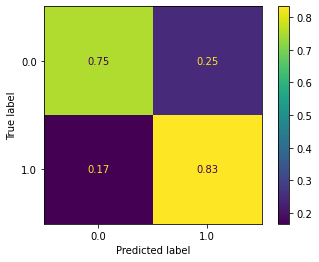

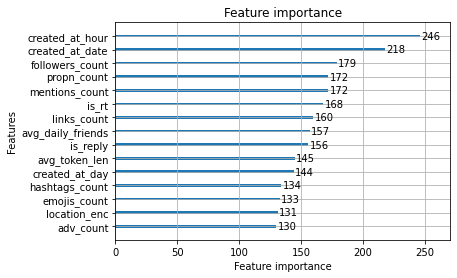

In [34]:
eval_clf(clf_meta_fe_mean, df_test_meta_fe_mean)

> Median

In [35]:
df_train_meta_fe_median = get_median(df_train_meta_fe, df_train['id'])
df_test_meta_fe_median = get_median(df_test_meta_fe, df_test['id'])

clf_meta_fe_median = get_best_clf(df_train_meta_fe_median)

[I 2022-03-29 16:52:01,824] A new study created in memory with name: no-name-20eda27e-0090-4c28-8857-c4e1a1d7dabe


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds



[I 2022-03-29 16:52:03,325] Trial 1 finished with value: 0.7781696820240438 and parameters: {'lambda_l1': 1.2040312808711053e-08, 'lambda_l2': 7.868717604550608e-08, 'num_leaves': 13, 'feature_fraction': 0.42422044574171064, 'bagging_fraction': 0.41807082674781, 'bagging_freq': 6, 'learning_rate': 0.16071588450446586, 'min_child_samples': 56}. Best is trial 1 with value: 0.7781696820240438.


Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.870956
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:03,749] Trial 3 finished with value: 0.7499733241647499 and parameters: {'lambda_l1': 4.014646104384503e-06, 'lambda_l2': 0.0004987030279093022, 'num_leaves': 21, 'feature_fraction': 0.8555091698058936, 'bagging_fraction': 0.7354084608563924, 'bagging_freq': 5, 'learning_rate': 0.004958445516836197, 'min_child_samples': 11}. Best is trial 1 with value: 0.7781696820240438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.853931
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:04,125] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 0.05178844109282044, 'lambda_l2': 3.9325289212191255, 'num_leaves': 165, 'feature_fraction': 0.5258666621171268, 'bagging_fraction': 0.5168772779601262, 'bagging_freq': 4, 'learning_rate': 2.2425326462141608e-05, 'min_child_samples': 42}. Best is trial 1 with value: 0.7781696820240438.


Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.855358
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:04,539] Trial 8 finished with value: 0.7858286107225001 and parameters: {'lambda_l1': 4.537964852381558, 'lambda_l2': 7.607572160670819, 'num_leaves': 52, 'feature_fraction': 0.41630497867933447, 'bagging_fraction': 0.7634353761861139, 'bagging_freq': 6, 'learning_rate': 0.06253833929707259, 'min_child_samples': 83}. Best is trial 8 with value: 0.7858286107225001.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.869488
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:04,774] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 1.780319681097548e-07, 'lambda_l2': 3.731007674504314e-05, 'num_leaves': 115, 'feature_fraction': 0.916023486223003, 'bagging_fraction': 0.6930569621890192, 'bagging_freq': 2, 'learning_rate': 0.0009502375685891739, 'min_child_samples': 52}. Best is trial 8 with value: 0.7858286107225001.
[I 2022-03-29 16:52:04,884] Trial 2 finished with value: 0.7947324117326252 and parameters: {'lambda_l1': 0.33951723049803123, 'lambda_l2': 7.94322353620321e-07, 'num_leaves': 227, 'feature_fraction': 0.45111758639375193, 'bagging_fraction': 0.985737571898965, 'bagging_freq': 1, 'learning_rate': 0.12977375927774867, 'min_child_samples': 78}. Best is trial 2 with value: 0.7947324117326252.
[I 2022-03-29 16:52:04,931] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 0.0563944463483906, 'lambda_l2': 1.1589693649144637e-05, 'num_leaves': 141, 'feature_fraction': 0.9097720703235291, 'bagging_fraction': 

Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.859354
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.87635
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.859203


[I 2022-03-29 16:52:05,131] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 1.7038892525197905e-08, 'lambda_l2': 0.0334947076571641, 'num_leaves': 115, 'feature_fraction': 0.691951507309724, 'bagging_fraction': 0.7602854228088467, 'bagging_freq': 6, 'learning_rate': 2.1029033532968192e-05, 'min_child_samples': 53}. Best is trial 2 with value: 0.7947324117326252.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.862692


[I 2022-03-29 16:52:05,240] Trial 9 finished with value: 0.7913594005643421 and parameters: {'lambda_l1': 0.0009200814806316197, 'lambda_l2': 0.09529825627719313, 'num_leaves': 74, 'feature_fraction': 0.9873763991454546, 'bagging_fraction': 0.4665718813886511, 'bagging_freq': 2, 'learning_rate': 0.08645030873830598, 'min_child_samples': 61}. Best is trial 2 with value: 0.7947324117326252.
[I 2022-03-29 16:52:05,365] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 5.950380021001246e-07, 'lambda_l2': 2.3186262490937547e-08, 'num_leaves': 119, 'feature_fraction': 0.7759493730201343, 'bagging_fraction': 0.6174243318697324, 'bagging_freq': 5, 'learning_rate': 0.0005290456372988901, 'min_child_samples': 41}. Best is trial 2 with value: 0.7947324117326252.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.873936
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.85981
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:05,758] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 7.551347642986414e-05, 'lambda_l2': 0.09357655274036517, 'num_leaves': 96, 'feature_fraction': 0.6144153114610731, 'bagging_fraction': 0.4232252086755301, 'bagging_freq': 5, 'learning_rate': 0.0011711812766086438, 'min_child_samples': 92}. Best is trial 2 with value: 0.7947324117326252.


Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.85264
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:06,071] Trial 16 finished with value: 0.7612631304389064 and parameters: {'lambda_l1': 2.8597831947048028e-08, 'lambda_l2': 1.045635335804617e-06, 'num_leaves': 14, 'feature_fraction': 0.8110737205866637, 'bagging_fraction': 0.7665555190682861, 'bagging_freq': 2, 'learning_rate': 0.009745154330659365, 'min_child_samples': 94}. Best is trial 2 with value: 0.7947324117326252.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.851717
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:06,306] Trial 14 finished with value: 0.7710235221587272 and parameters: {'lambda_l1': 5.479081517588412e-07, 'lambda_l2': 2.4835859053783375e-05, 'num_leaves': 122, 'feature_fraction': 0.7035212299946176, 'bagging_fraction': 0.7046525857980555, 'bagging_freq': 6, 'learning_rate': 0.01557681549753141, 'min_child_samples': 92}. Best is trial 2 with value: 0.7947324117326252.
[I 2022-03-29 16:52:06,401] Trial 10 finished with value: 0.5 and parameters: {'lambda_l1': 0.17557551871493082, 'lambda_l2': 1.3893303571641507e-05, 'num_leaves': 256, 'feature_fraction': 0.8276037573711563, 'bagging_fraction': 0.9775411701443757, 'bagging_freq': 3, 'learning_rate': 1.848269827452488e-05, 'min_child_samples': 65}. Best is trial 2 with value: 0.7947324117326252.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.864881
Did not meet early stopping. Best iteration is:
[5]	valid_0's auc: 0.860578


[I 2022-03-29 16:52:06,573] Trial 17 finished with value: 0.7584206719939298 and parameters: {'lambda_l1': 6.083115448499768, 'lambda_l2': 7.497810270605203e-07, 'num_leaves': 252, 'feature_fraction': 0.6140817816536204, 'bagging_fraction': 0.9867311258518328, 'bagging_freq': 3, 'learning_rate': 0.009029303284403122, 'min_child_samples': 98}. Best is trial 2 with value: 0.7947324117326252.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.855947
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:07,530] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 0.0017872033653509754, 'lambda_l2': 0.028329766022734796, 'num_leaves': 62, 'feature_fraction': 0.930356682777232, 'bagging_fraction': 0.8243144006719821, 'bagging_freq': 2, 'learning_rate': 1.0602568309582182e-05, 'min_child_samples': 17}. Best is trial 2 with value: 0.7947324117326252.


Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.858193
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:07,890] Trial 15 finished with value: 0.7840768975410808 and parameters: {'lambda_l1': 2.563797484895051e-05, 'lambda_l2': 1.376135483679767, 'num_leaves': 183, 'feature_fraction': 0.8878066554515871, 'bagging_fraction': 0.862742545756092, 'bagging_freq': 4, 'learning_rate': 0.1188477208090634, 'min_child_samples': 45}. Best is trial 2 with value: 0.7947324117326252.


Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.870332
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:08,157] Trial 18 finished with value: 0.7807720579517701 and parameters: {'lambda_l1': 0.008302668020093001, 'lambda_l2': 9.989047274295052e-07, 'num_leaves': 249, 'feature_fraction': 0.5771667145113547, 'bagging_fraction': 0.9984244191807888, 'bagging_freq': 2, 'learning_rate': 0.020341068413512874, 'min_child_samples': 71}. Best is trial 2 with value: 0.7947324117326252.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.869946
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:08,470] Trial 19 finished with value: 0.7859886657340005 and parameters: {'lambda_l1': 0.008389651524402403, 'lambda_l2': 0.0004612914002571276, 'num_leaves': 254, 'feature_fraction': 0.5916483886911473, 'bagging_fraction': 0.9594231120065861, 'bagging_freq': 1, 'learning_rate': 0.031209618887446895, 'min_child_samples': 73}. Best is trial 2 with value: 0.7947324117326252.
[I 2022-03-29 16:52:08,549] Trial 22 finished with value: 0.7781696820240438 and parameters: {'lambda_l1': 0.002404653173071994, 'lambda_l2': 0.002627541462405561, 'num_leaves': 208, 'feature_fraction': 0.9811740500112734, 'bagging_fraction': 0.8659060515644574, 'bagging_freq': 1, 'learning_rate': 0.2893683849819038, 'min_child_samples': 73}. Best is trial 2 with value: 0.7947324117326252.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.872003
Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.861437
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.870444


[I 2022-03-29 16:52:08,643] Trial 21 finished with value: 0.7885228700827545 and parameters: {'lambda_l1': 0.000393956104937972, 'lambda_l2': 0.0037117272959069293, 'num_leaves': 243, 'feature_fraction': 0.9692858302867814, 'bagging_fraction': 0.9932372076506871, 'bagging_freq': 1, 'learning_rate': 0.20670933520790752, 'min_child_samples': 73}. Best is trial 2 with value: 0.7947324117326252.
[I 2022-03-29 16:52:08,730] Trial 20 finished with value: 0.7890652787328385 and parameters: {'lambda_l1': 0.009845238563172688, 'lambda_l2': 0.003903927015271272, 'num_leaves': 223, 'feature_fraction': 0.9823849816291143, 'bagging_fraction': 0.9875488801527763, 'bagging_freq': 1, 'learning_rate': 0.2581898568428497, 'min_child_samples': 81}. Best is trial 2 with value: 0.7947324117326252.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.867931
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:09,532] Trial 24 finished with value: 0.7859945936973893 and parameters: {'lambda_l1': 0.00250647969449154, 'lambda_l2': 0.007438501074003135, 'num_leaves': 209, 'feature_fraction': 0.9767463354602416, 'bagging_fraction': 0.5592841587923091, 'bagging_freq': 1, 'learning_rate': 0.03862886776522667, 'min_child_samples': 75}. Best is trial 2 with value: 0.7947324117326252.
[I 2022-03-29 16:52:09,615] Trial 25 finished with value: 0.7838427429872195 and parameters: {'lambda_l1': 0.6950237901037744, 'lambda_l2': 0.0006480834794679865, 'num_leaves': 215, 'feature_fraction': 0.9874607615926035, 'bagging_fraction': 0.565781942461633, 'bagging_freq': 1, 'learning_rate': 0.29459945009927857, 'min_child_samples': 76}. Best is trial 2 with value: 0.7947324117326252.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.873102
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.867485
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:09,803] Trial 26 finished with value: 0.7825415550233562 and parameters: {'lambda_l1': 0.5781627468293283, 'lambda_l2': 0.0019521122741525954, 'num_leaves': 211, 'feature_fraction': 0.9906321766621786, 'bagging_fraction': 0.5407693627819793, 'bagging_freq': 1, 'learning_rate': 0.2718105614020989, 'min_child_samples': 83}. Best is trial 2 with value: 0.7947324117326252.
[I 2022-03-29 16:52:09,913] Trial 23 finished with value: 0.7790885163493231 and parameters: {'lambda_l1': 0.0016672825391355454, 'lambda_l2': 0.001557377377706262, 'num_leaves': 200, 'feature_fraction': 0.9997073721194792, 'bagging_fraction': 0.8783205923255771, 'bagging_freq': 1, 'learning_rate': 0.2965679669287766, 'min_child_samples': 76}. Best is trial 2 with value: 0.7947324117326252.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.864663
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.862531
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:10,650] Trial 28 finished with value: 0.7908229198776469 and parameters: {'lambda_l1': 0.0002313182791919921, 'lambda_l2': 0.003577323230013113, 'num_leaves': 215, 'feature_fraction': 0.9994052870908274, 'bagging_fraction': 0.9230940897621759, 'bagging_freq': 1, 'learning_rate': 0.059733336224490036, 'min_child_samples': 83}. Best is trial 2 with value: 0.7947324117326252.
[I 2022-03-29 16:52:10,776] Trial 29 finished with value: 0.79212410784151 and parameters: {'lambda_l1': 0.6320297818391473, 'lambda_l2': 0.3543430082520398, 'num_leaves': 215, 'feature_fraction': 0.501534258940714, 'bagging_fraction': 0.9082806346300055, 'bagging_freq': 3, 'learning_rate': 0.05549995197305345, 'min_child_samples': 84}. Best is trial 2 with value: 0.7947324117326252.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.87751
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.876575
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:11,089] Trial 27 finished with value: 0.7843851516373035 and parameters: {'lambda_l1': 0.7449504870699062, 'lambda_l2': 0.2543901735105508, 'num_leaves': 78, 'feature_fraction': 0.7454510680583202, 'bagging_fraction': 0.560083616381793, 'bagging_freq': 3, 'learning_rate': 0.06097510706431711, 'min_child_samples': 33}. Best is trial 2 with value: 0.7947324117326252.


Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.874563
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:11,387] Trial 33 finished with value: 0.7871416546131411 and parameters: {'lambda_l1': 0.00014803827809479957, 'lambda_l2': 0.31991721268329854, 'num_leaves': 156, 'feature_fraction': 0.7185437471775391, 'bagging_fraction': 0.49474529626281355, 'bagging_freq': 3, 'learning_rate': 0.0735414407926111, 'min_child_samples': 62}. Best is trial 2 with value: 0.7947324117326252.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.875474
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:11,607] Trial 30 finished with value: 0.7900522846370901 and parameters: {'lambda_l1': 0.3117933075165547, 'lambda_l2': 0.19543668929161237, 'num_leaves': 214, 'feature_fraction': 0.7084312320992314, 'bagging_fraction': 0.9052876821909536, 'bagging_freq': 3, 'learning_rate': 0.0808239727210798, 'min_child_samples': 84}. Best is trial 2 with value: 0.7947324117326252.
[I 2022-03-29 16:52:11,748] Trial 31 finished with value: 0.7998689920091053 and parameters: {'lambda_l1': 0.7962751709691349, 'lambda_l2': 0.09630127181705168, 'num_leaves': 77, 'feature_fraction': 0.48531772859997907, 'bagging_fraction': 0.9259548657926732, 'bagging_freq': 3, 'learning_rate': 0.08652149022403988, 'min_child_samples': 83}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.877829
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.877433
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:12,486] Trial 36 finished with value: 0.6455759609228653 and parameters: {'lambda_l1': 0.062208967864466856, 'lambda_l2': 1.3188097378557837, 'num_leaves': 159, 'feature_fraction': 0.4686116921584214, 'bagging_fraction': 0.4777100372518527, 'bagging_freq': 3, 'learning_rate': 0.0027031420047706205, 'min_child_samples': 66}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:12,627] Trial 11 finished with value: 0.7855322125530553 and parameters: {'lambda_l1': 0.12295638951283415, 'lambda_l2': 1.046184805955327e-07, 'num_leaves': 245, 'feature_fraction': 0.6038235601292425, 'bagging_fraction': 0.5263801096370242, 'bagging_freq': 5, 'learning_rate': 0.06754298020005674, 'min_child_samples': 8}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.858025
Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.86668
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:12,768] Trial 35 finished with value: 0.6801923031323358 and parameters: {'lambda_l1': 1.596278848058994, 'lambda_l2': 0.27106175667429294, 'num_leaves': 80, 'feature_fraction': 0.47158174656830176, 'bagging_fraction': 0.9115502572867284, 'bagging_freq': 3, 'learning_rate': 0.0033324121375276454, 'min_child_samples': 65}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:12,838] Trial 32 finished with value: 0.7949606383230977 and parameters: {'lambda_l1': 0.00018607954833303202, 'lambda_l2': 0.1460540377469157, 'num_leaves': 161, 'feature_fraction': 0.48032823423183, 'bagging_fraction': 0.9193946829266711, 'bagging_freq': 3, 'learning_rate': 0.08685219871454612, 'min_child_samples': 62}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.861695
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.873641
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:13,223] Trial 39 finished with value: 0.6742050601095488 and parameters: {'lambda_l1': 2.252651230528403, 'lambda_l2': 1.4514787028473108, 'num_leaves': 37, 'feature_fraction': 0.4871360089027337, 'bagging_fraction': 0.822872189299563, 'bagging_freq': 2, 'learning_rate': 0.0031145008662748445, 'min_child_samples': 64}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.859269
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:13,442] Trial 34 finished with value: 0.7959595001541271 and parameters: {'lambda_l1': 0.00015079650211113105, 'lambda_l2': 0.2606131589894, 'num_leaves': 157, 'feature_fraction': 0.5011646148279356, 'bagging_fraction': 0.8985283575621433, 'bagging_freq': 3, 'learning_rate': 0.08958971251977782, 'min_child_samples': 63}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.878929
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:13,840] Trial 37 finished with value: 0.5 and parameters: {'lambda_l1': 0.06493961194403236, 'lambda_l2': 0.9161239981109429, 'num_leaves': 184, 'feature_fraction': 0.47588082984802677, 'bagging_fraction': 0.9292992944775201, 'bagging_freq': 2, 'learning_rate': 0.00011941791980688399, 'min_child_samples': 64}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:13,897] Trial 42 finished with value: 0.7867533730111682 and parameters: {'lambda_l1': 9.632745709536717, 'lambda_l2': 0.025799581992572942, 'num_leaves': 40, 'feature_fraction': 0.530733912497532, 'bagging_fraction': 0.8110637093115085, 'bagging_freq': 2, 'learning_rate': 0.1454054679032429, 'min_child_samples': 88}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.864887
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.874564


[I 2022-03-29 16:52:14,242] Trial 40 finished with value: 0.7894357764446447 and parameters: {'lambda_l1': 1.700077092282889, 'lambda_l2': 1.8827366346757923, 'num_leaves': 36, 'feature_fraction': 0.4684528892517987, 'bagging_fraction': 0.9326836447456517, 'bagging_freq': 2, 'learning_rate': 0.1228320351546695, 'min_child_samples': 59}. Best is trial 31 with value: 0.7998689920091053.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.874435


[I 2022-03-29 16:52:14,336] Trial 41 finished with value: 0.7885169421193655 and parameters: {'lambda_l1': 1.8901148566996935, 'lambda_l2': 1.4735049233561663, 'num_leaves': 37, 'feature_fraction': 0.4998596776802877, 'bagging_fraction': 0.9238942494087437, 'bagging_freq': 2, 'learning_rate': 0.1251565264360449, 'min_child_samples': 59}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:14,430] Trial 38 finished with value: 0.786216892324473 and parameters: {'lambda_l1': 0.049684744760191, 'lambda_l2': 0.016937776074899335, 'num_leaves': 181, 'feature_fraction': 0.47835674240180553, 'bagging_fraction': 0.926501736352232, 'bagging_freq': 2, 'learning_rate': 0.032298608976016774, 'min_child_samples': 65}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.87465
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.875522
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:14,901] Trial 43 finished with value: 0.7902864391909515 and parameters: {'lambda_l1': 5.337997371104591e-06, 'lambda_l2': 0.00011109203455671297, 'num_leaves': 185, 'feature_fraction': 0.5272406623514859, 'bagging_fraction': 0.9458342226308047, 'bagging_freq': 4, 'learning_rate': 0.14163370913723897, 'min_child_samples': 89}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.873801
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.860257


[I 2022-03-29 16:52:15,073] Trial 44 finished with value: 0.5 and parameters: {'lambda_l1': 8.45743836033353e-06, 'lambda_l2': 8.341488409506864e-05, 'num_leaves': 177, 'feature_fraction': 0.542976453942351, 'bagging_fraction': 0.8129971005300336, 'bagging_freq': 4, 'learning_rate': 9.650876630555859e-05, 'min_child_samples': 89}. Best is trial 31 with value: 0.7998689920091053.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:16,391] Trial 49 finished with value: 0.7776213454105707 and parameters: {'lambda_l1': 3.8412711914668815e-05, 'lambda_l2': 7.26534548679224, 'num_leaves': 135, 'feature_fraction': 0.40526476183808624, 'bagging_fraction': 0.9535872273431617, 'bagging_freq': 4, 'learning_rate': 0.0332516107035458, 'min_child_samples': 54}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:16,469] Trial 46 finished with value: 0.7876040357574752 and parameters: {'lambda_l1': 6.5267984373483856e-06, 'lambda_l2': 9.42391714111116e-05, 'num_leaves': 142, 'feature_fraction': 0.542963089217499, 'bagging_fraction': 0.8223972221638929, 'bagging_freq': 4, 'learning_rate': 0.13263647177371815, 'min_child_samples': 55}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.868254
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.867523


[I 2022-03-29 16:52:16,657] Trial 47 finished with value: 0.7802296493016858 and parameters: {'lambda_l1': 3.1938593207565614e-05, 'lambda_l2': 0.0001933937070921646, 'num_leaves': 144, 'feature_fraction': 0.43679731873638206, 'bagging_fraction': 0.9499676173257174, 'bagging_freq': 4, 'learning_rate': 0.021698445069254252, 'min_child_samples': 57}. Best is trial 31 with value: 0.7998689920091053.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.86708
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:16,814] Trial 51 finished with value: 0.776770682664264 and parameters: {'lambda_l1': 4.238286188730659e-05, 'lambda_l2': 5.778485298682632, 'num_leaves': 133, 'feature_fraction': 0.40474114334377925, 'bagging_fraction': 0.8910444543457837, 'bagging_freq': 4, 'learning_rate': 0.019374396026699738, 'min_child_samples': 52}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.864977
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:17,017] Trial 52 finished with value: 0.7763142294833186 and parameters: {'lambda_l1': 4.547065713114055e-05, 'lambda_l2': 6.766133314955164, 'num_leaves': 139, 'feature_fraction': 0.436161997857023, 'bagging_fraction': 0.8914838900595552, 'bagging_freq': 7, 'learning_rate': 0.021536699344611724, 'min_child_samples': 50}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.862502
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:17,363] Trial 48 finished with value: 0.7882086880231428 and parameters: {'lambda_l1': 2.4274643138344764e-05, 'lambda_l2': 8.015412513144228e-05, 'num_leaves': 141, 'feature_fraction': 0.5347256950424379, 'bagging_fraction': 0.9545185534752851, 'bagging_freq': 4, 'learning_rate': 0.030034923107885043, 'min_child_samples': 52}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:17,425] Trial 50 finished with value: 0.7764683565314301 and parameters: {'lambda_l1': 1.4848714701494383e-05, 'lambda_l2': 0.00012737862331853994, 'num_leaves': 138, 'feature_fraction': 0.40193224684683737, 'bagging_fraction': 0.9577060235729471, 'bagging_freq': 4, 'learning_rate': 0.017670362075234522, 'min_child_samples': 54}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.872992
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.86628
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:17,912] Trial 45 finished with value: 0.7837686434448581 and parameters: {'lambda_l1': 1.534160141625146e-05, 'lambda_l2': 0.02182279684595264, 'num_leaves': 179, 'feature_fraction': 0.5597446042175839, 'bagging_fraction': 0.9498479660252098, 'bagging_freq': 4, 'learning_rate': 0.1302259368731983, 'min_child_samples': 34}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.86843
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:18,225] Trial 53 finished with value: 0.7792248595072677 and parameters: {'lambda_l1': 0.0252423773315232, 'lambda_l2': 0.07187726243058014, 'num_leaves': 103, 'feature_fraction': 0.43777448829853005, 'bagging_fraction': 0.8923831956972035, 'bagging_freq': 7, 'learning_rate': 0.015301213782130152, 'min_child_samples': 100}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:18,335] Trial 55 finished with value: 0.7699387048585588 and parameters: {'lambda_l1': 0.0006055514456315114, 'lambda_l2': 0.06807340047113153, 'num_leaves': 107, 'feature_fraction': 0.6441731867301678, 'bagging_fraction': 0.8895750516593972, 'bagging_freq': 5, 'learning_rate': 0.010450272291569494, 'min_child_samples': 100}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.865481
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.864595
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:18,571] Trial 56 finished with value: 0.7720164560263676 and parameters: {'lambda_l1': 0.000634476574177091, 'lambda_l2': 0.07731181503209489, 'num_leaves': 101, 'feature_fraction': 0.6543136591121008, 'bagging_fraction': 0.8565699196581401, 'bagging_freq': 5, 'learning_rate': 0.011029684340030113, 'min_child_samples': 99}. Best is trial 31 with value: 0.7998689920091053.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.863183
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:19,049] Trial 58 finished with value: 0.7703269864605315 and parameters: {'lambda_l1': 0.0006444010923052191, 'lambda_l2': 0.0627494598313284, 'num_leaves': 91, 'feature_fraction': 0.6477087026755768, 'bagging_fraction': 0.647137761983658, 'bagging_freq': 3, 'learning_rate': 0.010509058119450342, 'min_child_samples': 69}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:19,135] Trial 57 finished with value: 0.7668739477864985 and parameters: {'lambda_l1': 7.897187644185113e-07, 'lambda_l2': 1.2635306639891073e-08, 'num_leaves': 232, 'feature_fraction': 0.6602984176054307, 'bagging_fraction': 0.8561098262319236, 'bagging_freq': 5, 'learning_rate': 0.01067835051440346, 'min_child_samples': 69}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.863393
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.865343


[I 2022-03-29 16:52:19,276] Trial 59 finished with value: 0.7968042349370452 and parameters: {'lambda_l1': 0.0007194975246004985, 'lambda_l2': 0.05216746974014031, 'num_leaves': 101, 'feature_fraction': 0.5075932243058193, 'bagging_fraction': 0.6330864406373035, 'bagging_freq': 3, 'learning_rate': 0.07483061770443583, 'min_child_samples': 69}. Best is trial 31 with value: 0.7998689920091053.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.874518
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:19,684] Trial 54 finished with value: 0.7844473952528868 and parameters: {'lambda_l1': 0.0006426620146746729, 'lambda_l2': 0.06880951722681496, 'num_leaves': 231, 'feature_fraction': 0.4344535922816946, 'bagging_fraction': 0.8886450684007604, 'bagging_freq': 3, 'learning_rate': 0.019964534028406554, 'min_child_samples': 48}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.867408
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:19,966] Trial 62 finished with value: 0.7886028975885045 and parameters: {'lambda_l1': 1.3063428027399397e-06, 'lambda_l2': 3.882068607975349e-06, 'num_leaves': 81, 'feature_fraction': 0.6415653801473354, 'bagging_fraction': 0.609694232752382, 'bagging_freq': 3, 'learning_rate': 0.09355924026055203, 'min_child_samples': 69}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.875055
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:20,217] Trial 60 finished with value: 0.7810002845422426 and parameters: {'lambda_l1': 1.5863946649281083e-06, 'lambda_l2': 0.07497169859668087, 'num_leaves': 106, 'feature_fraction': 0.5024162605351619, 'bagging_fraction': 0.8570182155473179, 'bagging_freq': 3, 'learning_rate': 0.050084267517329216, 'min_child_samples': 69}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:20,311] Trial 65 finished with value: 0.7827638536504398 and parameters: {'lambda_l1': 0.0001229374230004538, 'lambda_l2': 4.09362907960064e-06, 'num_leaves': 197, 'feature_fraction': 0.5095306396320706, 'bagging_fraction': 0.40111805241842646, 'bagging_freq': 3, 'learning_rate': 0.04860598357713357, 'min_child_samples': 78}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.877306
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.871027
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:20,515] Trial 61 finished with value: 0.7914335001067033 and parameters: {'lambda_l1': 1.3798730042672465e-06, 'lambda_l2': 0.0819195056929974, 'num_leaves': 230, 'feature_fraction': 0.5011840111765635, 'bagging_fraction': 0.8532771368202676, 'bagging_freq': 3, 'learning_rate': 0.04822323579099622, 'min_child_samples': 71}. Best is trial 31 with value: 0.7998689920091053.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.880581


[I 2022-03-29 16:52:20,718] Trial 63 finished with value: 0.789589903492756 and parameters: {'lambda_l1': 1.1378500019395626e-06, 'lambda_l2': 1.1270668692727558e-08, 'num_leaves': 237, 'feature_fraction': 0.5111061260506032, 'bagging_fraction': 0.7810673001527195, 'bagging_freq': 3, 'learning_rate': 0.04860260137503233, 'min_child_samples': 70}. Best is trial 31 with value: 0.7998689920091053.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.876718
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:21,284] Trial 66 finished with value: 0.7905146657814242 and parameters: {'lambda_l1': 0.00014765064120508904, 'lambda_l2': 0.6051689573012304, 'num_leaves': 196, 'feature_fraction': 0.50748178719759, 'bagging_fraction': 0.736495116365647, 'bagging_freq': 3, 'learning_rate': 0.04512975174979822, 'min_child_samples': 78}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:21,378] Trial 68 finished with value: 0.7801614777227136 and parameters: {'lambda_l1': 8.782679424525696e-05, 'lambda_l2': 0.6529874046543184, 'num_leaves': 65, 'feature_fraction': 0.5177771334404195, 'bagging_fraction': 0.4110274229340384, 'bagging_freq': 3, 'learning_rate': 0.05223731911873492, 'min_child_samples': 79}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.876581
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.868604
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.87159


[I 2022-03-29 16:52:21,691] Trial 70 finished with value: 0.787524008251725 and parameters: {'lambda_l1': 0.22805900228821768, 'lambda_l2': 0.5835695477898001, 'num_leaves': 67, 'feature_fraction': 0.5687899996020602, 'bagging_fraction': 0.4371091197446529, 'bagging_freq': 2, 'learning_rate': 0.09187155557117375, 'min_child_samples': 86}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:21,770] Trial 67 finished with value: 0.7929688426244279 and parameters: {'lambda_l1': 2.1198667867854556e-06, 'lambda_l2': 0.47454233771051363, 'num_leaves': 66, 'feature_fraction': 0.5075943835825973, 'bagging_fraction': 0.6981395988431153, 'bagging_freq': 3, 'learning_rate': 0.05123994475050965, 'min_child_samples': 79}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:21,844] Trial 69 finished with value: 0.7821592013847721 and parameters: {'lambda_l1': 0.0001060911791945339, 'lambda_l2': 0.522708235349793, 'num_leaves': 63, 'feature_fraction': 0.5025550965541

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.875479
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.865432
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:22,629] Trial 71 finished with value: 0.7884428425770043 and parameters: {'lambda_l1': 8.113074897326027e-08, 'lambda_l2': 0.66405994531831, 'num_leaves': 123, 'feature_fraction': 0.5691677853936724, 'bagging_fraction': 0.7161149363801306, 'bagging_freq': 3, 'learning_rate': 0.19396399550404414, 'min_child_samples': 79}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.870893
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.872986

[I 2022-03-29 16:52:22,818] Trial 64 finished with value: 0.7923523344319826 and parameters: {'lambda_l1': 2.2475683859228723e-06, 'lambda_l2': 3.666645552365141e-06, 'num_leaves': 228, 'feature_fraction': 0.5113254244293672, 'bagging_fraction': 0.8490080183748411, 'bagging_freq': 3, 'learning_rate': 0.18959867566704675, 'min_child_samples': 46}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:22,896] Trial 72 finished with value: 0.7901382401062291 and parameters: {'lambda_l1': 1.0117885058562354e-07, 'lambda_l2': 0.5454056635883556, 'num_leaves': 125, 'feature_fraction': 0.4481247373104703, 'bagging_fraction': 0.7230041475743267, 'bagging_freq': 3, 'learning_rate': 0.19947434321752366, 'min_child_samples': 79}. Best is trial 31 with value: 0.7998689920091053.



Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.869871
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:23,571] Trial 75 finished with value: 0.7887629526000047 and parameters: {'lambda_l1': 4.737901856026036e-08, 'lambda_l2': 0.010612432295732303, 'num_leaves': 124, 'feature_fraction': 0.4537635110031417, 'bagging_fraction': 0.678414156203915, 'bagging_freq': 3, 'learning_rate': 0.185250204331144, 'min_child_samples': 81}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:23,680] Trial 73 finished with value: 0.790434638275674 and parameters: {'lambda_l1': 0.23778383334868972, 'lambda_l2': 0.0074951773892480995, 'num_leaves': 226, 'feature_fraction': 0.45569104442839703, 'bagging_fraction': 0.9773313982492579, 'bagging_freq': 3, 'learning_rate': 0.09428384485356953, 'min_child_samples': 85}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.870844
Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.871614
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 16:52:23,805] Trial 74 finished with value: 0.7802355772650749 and parameters: {'lambda_l1': 1.1917843123618465e-07, 'lambda_l2': 1.3669015940364766e-07, 'num_leaves': 123, 'feature_fraction': 0.4527395158703952, 'bagging_fraction': 0.9792326943398922, 'bagging_freq': 2, 'learning_rate': 0.20837584778836543, 'min_child_samples': 85}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:23,884] Trial 76 finished with value: 0.5 and parameters: {'lambda_l1': 2.0787088550171056e-07, 'lambda_l2': 1.1544970994608196e-07, 'num_leaves': 122, 'feature_fraction': 0.45402863546149597, 'bagging_fraction': 0.685033570858926, 'bagging_freq': 2, 'learning_rate': 0.0004657129025194676, 'min_child_samples': 75}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:23,915] Trial 77 finished with value: 0.7947324117326252 and parameters: {'lambda_l1': 2.496817539085057e-07, 'lambda_l2': 4.5940163586232855e-08, 'num_leaves': 119, 'feature_fraction': 0.4536921


Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.865302
Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.86224
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.874578
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.87722


[I 2022-03-29 16:52:24,244] Trial 78 finished with value: 0.797266616081379 and parameters: {'lambda_l1': 2.1337503694516996e-07, 'lambda_l2': 0.15689245398959523, 'num_leaves': 51, 'feature_fraction': 0.45520254854661757, 'bagging_fraction': 0.6596444421221371, 'bagging_freq': 2, 'learning_rate': 0.08993917076807552, 'min_child_samples': 93}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:24,480] Trial 79 finished with value: 0.7895217319137836 and parameters: {'lambda_l1': 1.9723494812400917e-07, 'lambda_l2': 1.363134834802666e-07, 'num_leaves': 90, 'feature_fraction': 0.45551084458333313, 'bagging_fraction': 0.6840470755506506, 'bagging_freq': 2, 'learning_rate': 0.0892053368141752, 'min_child_samples': 96}. Best is trial 31 with value: 0.7998689920091053.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.874163
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:25,061] Trial 82 finished with value: 0.7877581628055865 and parameters: {'lambda_l1': 1.2217432897611756e-08, 'lambda_l2': 0.1557173172114761, 'num_leaves': 52, 'feature_fraction': 0.5517541315484271, 'bagging_fraction': 0.6006860626677339, 'bagging_freq': 2, 'learning_rate': 0.07120397322921825, 'min_child_samples': 92}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.874545
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:25,374] Trial 86 finished with value: 0.786216892324473 and parameters: {'lambda_l1': 3.58109045421491e-07, 'lambda_l2': 2.9168059859484354, 'num_leaves': 87, 'feature_fraction': 0.4218944187066819, 'bagging_fraction': 0.6280570960035925, 'bagging_freq': 1, 'learning_rate': 0.07429035495185575, 'min_child_samples': 93}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.87382
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.879851
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:25,562] Trial 81 finished with value: 0.7917417542029261 and parameters: {'lambda_l1': 2.3734694080763123e-07, 'lambda_l2': 1.111868864225077e-07, 'num_leaves': 55, 'feature_fraction': 0.5886269902783036, 'bagging_fraction': 0.9732542556365967, 'bagging_freq': 2, 'learning_rate': 0.0957628370934861, 'min_child_samples': 94}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:25,762] Trial 87 finished with value: 0.777399046783487 and parameters: {'lambda_l1': 1.3176026933734914e-08, 'lambda_l2': 0.15901521912454572, 'num_leaves': 53, 'feature_fraction': 0.4224429747977129, 'bagging_fraction': 0.6314336860058066, 'bagging_freq': 1, 'learning_rate': 0.07337133220639694, 'min_child_samples': 93}. Best is trial 31 with value: 0.7998689920091053.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.874357
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.865535


[I 2022-03-29 16:52:25,891] Trial 83 finished with value: 0.7560405946932872 and parameters: {'lambda_l1': 0.0046796115552215295, 'lambda_l2': 3.082908855065668e-07, 'num_leaves': 52, 'feature_fraction': 0.5881530955763521, 'bagging_fraction': 0.6327038598658212, 'bagging_freq': 2, 'learning_rate': 0.006035368045185717, 'min_child_samples': 40}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:25,985] Trial 84 finished with value: 0.7969524340217675 and parameters: {'lambda_l1': 0.005547592569374476, 'lambda_l2': 3.0380191208942805e-07, 'num_leaves': 48, 'feature_fraction': 0.595124804148658, 'bagging_fraction': 0.6240487846158658, 'bagging_freq': 2, 'learning_rate': 0.06910834052081562, 'min_child_samples': 46}. Best is trial 31 with value: 0.7998689920091053.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.872993
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.874329


[I 2022-03-29 16:52:26,126] Trial 80 finished with value: 0.7903605387333127 and parameters: {'lambda_l1': 4.321089285752016e-07, 'lambda_l2': 2.415003167482741e-07, 'num_leaves': 89, 'feature_fraction': 0.4527282980844915, 'bagging_fraction': 0.6751599596697347, 'bagging_freq': 2, 'learning_rate': 0.09575496872896046, 'min_child_samples': 36}. Best is trial 31 with value: 0.7998689920091053.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:26,503] Trial 94 finished with value: 0.7395460365636781 and parameters: {'lambda_l1': 0.0002960906706187446, 'lambda_l2': 3.2866947323617804e-08, 'num_leaves': 4, 'feature_fraction': 0.4890913808029, 'bagging_fraction': 0.5865606062389243, 'bagging_freq': 1, 'learning_rate': 0.027968018155827522, 'min_child_samples': 62}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:26,597] Trial 85 finished with value: 0.7889793232636996 and parameters: {'lambda_l1': 0.005591597615561151, 'lambda_l2': 2.5746271998100883e-07, 'num_leaves': 114, 'feature_fraction': 0.5901520818059801, 'bagging_fraction': 0.6404203923944946, 'bagging_freq': 2, 'learning_rate': 0.07363967023872244, 'min_child_samples': 39}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.841534
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.874798
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:27,256] Trial 93 finished with value: 0.7859086382282503 and parameters: {'lambda_l1': 0.00026371287258136967, 'lambda_l2': 5.8551578152715294e-08, 'num_leaves': 27, 'feature_fraction': 0.48098993724193645, 'bagging_fraction': 0.6616981830553402, 'bagging_freq': 1, 'learning_rate': 0.027802610185042553, 'min_child_samples': 39}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.868376
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:27,522] Trial 92 finished with value: 0.7943559860574301 and parameters: {'lambda_l1': 3.9401354890927733e-08, 'lambda_l2': 3.278588164152732e-07, 'num_leaves': 114, 'feature_fraction': 0.4861138601266346, 'bagging_fraction': 0.6618604259083801, 'bagging_freq': 1, 'learning_rate': 0.15846056100445866, 'min_child_samples': 74}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:27,694] Trial 91 finished with value: 0.792580561022455 and parameters: {'lambda_l1': 5.200550466249899e-07, 'lambda_l2': 3.7251948695723214e-07, 'num_leaves': 112, 'feature_fraction': 0.47829781500964796, 'bagging_fraction': 0.6445707525923386, 'bagging_freq': 2, 'learning_rate': 0.15793781248865296, 'min_child_samples': 60}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.873082
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.869657
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:52:28,149] Trial 89 finished with value: 0.7910570744315082 and parameters: {'lambda_l1': 2.7326006578869507e-06, 'lambda_l2': 4.323696505974315e-08, 'num_leaves': 153, 'feature_fraction': 0.48418787051399836, 'bagging_fraction': 0.6637548517305216, 'bagging_freq': 2, 'learning_rate': 0.10658256175743394, 'min_child_samples': 40}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:28,167] Trial 96 finished with value: 0.7852180304934436 and parameters: {'lambda_l1': 0.0013102331750086656, 'lambda_l2': 5.415670329583957e-08, 'num_leaves': 152, 'feature_fraction': 0.48258372177339937, 'bagging_fraction': 0.6632793409263479, 'bagging_freq': 2, 'learning_rate': 0.03827416699401062, 'min_child_samples': 73}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:28,275] Trial 90 finished with value: 0.7951947928769594 and parameters: {'lambda_l1': 0.004048881023639503, 'lambda_l2': 3.244914882307547e-07, 'num_leaves': 114, 'feature_fraction':

Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.867697
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.873063
Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.869994


[I 2022-03-29 16:52:28,620] Trial 97 finished with value: 0.7938876769497072 and parameters: {'lambda_l1': 3.018003277682617e-06, 'lambda_l2': 0.03811657782334552, 'num_leaves': 73, 'feature_fraction': 0.486543355468579, 'bagging_fraction': 0.6998463078738925, 'bagging_freq': 2, 'learning_rate': 0.03891886040539945, 'min_child_samples': 73}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:28,745] Trial 98 finished with value: 0.7932770967206507 and parameters: {'lambda_l1': 2.3537355382774822e-08, 'lambda_l2': 6.451276050903568e-07, 'num_leaves': 150, 'feature_fraction': 0.48949845058234875, 'bagging_fraction': 0.6561453053865063, 'bagging_freq': 1, 'learning_rate': 0.1159637968180086, 'min_child_samples': 74}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.874028
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.872556
Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.869908


[I 2022-03-29 16:52:28,824] Trial 88 finished with value: 0.7827757095772176 and parameters: {'lambda_l1': 3.613612003406016e-06, 'lambda_l2': 6.634737597434528e-07, 'num_leaves': 113, 'feature_fraction': 0.4857558668612198, 'bagging_fraction': 0.6448565821166719, 'bagging_freq': 1, 'learning_rate': 0.10966539831939762, 'min_child_samples': 16}. Best is trial 31 with value: 0.7998689920091053.
[I 2022-03-29 16:52:28,871] Trial 99 finished with value: 0.794658312190264 and parameters: {'lambda_l1': 2.461356765451909e-08, 'lambda_l2': 0.03985205017637922, 'num_leaves': 44, 'feature_fraction': 0.5251362372314589, 'bagging_fraction': 0.6967568754248173, 'bagging_freq': 1, 'learning_rate': 0.11367404098886313, 'min_child_samples': 73}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.875765


[I 2022-03-29 16:52:29,122] Trial 95 finished with value: 0.7875981077940863 and parameters: {'lambda_l1': 2.3837899733406666e-08, 'lambda_l2': 3.854226293467845e-08, 'num_leaves': 115, 'feature_fraction': 0.48920848438439335, 'bagging_fraction': 0.6613990503758433, 'bagging_freq': 2, 'learning_rate': 0.03948274141821484, 'min_child_samples': 28}. Best is trial 31 with value: 0.7998689920091053.


Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.871193
{'lambda_l1': 0.7962751709691349, 'lambda_l2': 0.09630127181705168, 'num_leaves': 77, 'feature_fraction': 0.48531772859997907, 'bagging_fraction': 0.9259548657926732, 'bagging_freq': 3, 'learning_rate': 0.08652149022403988, 'min_child_samples': 83} -> 0.7998689920091053
[LightGBM] [Warning] feature_fraction is set=0.48531772859997907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48531772859997907
[LightGBM] [Warning] lambda_l1 is set=0.7962751709691349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7962751709691349
[LightGBM] [Warning] bagging_fraction is set=0.9259548657926732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9259548657926732
[LightGBM] [Warning] lambda_l2 is set=0.09630127181705168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09630127181705168
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Cu

AUROC: 0.793965814917127
Accuracy: 0.7988165680473372


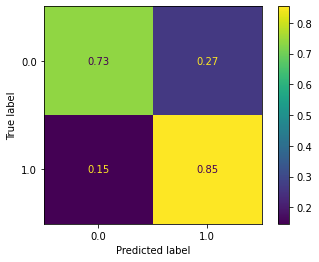

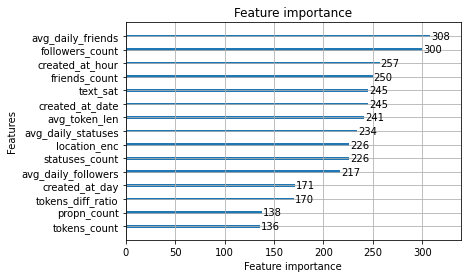

In [36]:
eval_clf(clf_meta_fe_median, df_test_meta_fe_median)

# Detection on tweets metadata (but not users')

In [37]:
def filter_tweet_metadata(df: pd.DataFrame):
    return df.drop([ 'followers_count', 'friends_count', 'statuses_count',
                     'location_enc', 'created_at_date', 'created_at_year',
                     'created_at_month', 'created_at_day', 'created_at_hour', 
                     'avg_daily_followers', 'avg_daily_friends', 'avg_daily_statuses'], axis=1)

In [38]:
df_train_meta_tweet = filter_tweet_metadata(df_train_meta)
df_test_meta_tweet = filter_tweet_metadata(df_test_meta)

In [39]:
clf_meta_tweet = get_best_clf(df_train_meta_tweet)

[I 2022-03-29 16:52:31,128] A new study created in memory with name: no-name-a4b479ac-33fe-4753-a8ee-10b601468d49


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.654116


[I 2022-03-29 16:53:19,180] Trial 3 finished with value: 0.6001594356739892 and parameters: {'lambda_l1': 0.0004932403583974768, 'lambda_l2': 0.5910247123728206, 'num_leaves': 59, 'feature_fraction': 0.5644698940897132, 'bagging_fraction': 0.8502916408043624, 'bagging_freq': 1, 'learning_rate': 0.16322216165073714, 'min_child_samples': 23}. Best is trial 3 with value: 0.6001594356739892.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.641885


[I 2022-03-29 16:53:21,869] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 7.19148973946593e-06, 'lambda_l2': 1.9266823962957862e-06, 'num_leaves': 68, 'feature_fraction': 0.5078567136895568, 'bagging_fraction': 0.9176560429735873, 'bagging_freq': 2, 'learning_rate': 1.766323141848178e-05, 'min_child_samples': 30}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654211


[I 2022-03-29 16:53:31,633] Trial 2 finished with value: 0.5996684425733654 and parameters: {'lambda_l1': 0.8922268054585176, 'lambda_l2': 0.001385375820927416, 'num_leaves': 101, 'feature_fraction': 0.9174402723610698, 'bagging_fraction': 0.716187268299902, 'bagging_freq': 3, 'learning_rate': 0.046581406042421884, 'min_child_samples': 41}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.630206


[I 2022-03-29 16:53:50,543] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 1.6415816565406497e-06, 'lambda_l2': 1.7353323143384477e-08, 'num_leaves': 19, 'feature_fraction': 0.43893207228041664, 'bagging_fraction': 0.84039802212308, 'bagging_freq': 5, 'learning_rate': 1.3100166429202278e-05, 'min_child_samples': 62}. Best is trial 3 with value: 0.6001594356739892.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.635065
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:53:55,630] Trial 10 finished with value: 0.5087790991034633 and parameters: {'lambda_l1': 1.339422123050819e-08, 'lambda_l2': 2.6982018873542226, 'num_leaves': 16, 'feature_fraction': 0.8783912888314499, 'bagging_fraction': 0.6524376740577207, 'bagging_freq': 6, 'learning_rate': 0.0019178539117405656, 'min_child_samples': 65}. Best is trial 3 with value: 0.6001594356739892.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.649667
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:53:59,768] Trial 6 finished with value: 0.5846925862193736 and parameters: {'lambda_l1': 0.00936971816211063, 'lambda_l2': 0.009372097399302353, 'num_leaves': 144, 'feature_fraction': 0.9619896548634705, 'bagging_fraction': 0.8583163961533047, 'bagging_freq': 7, 'learning_rate': 0.00517826474551933, 'min_child_samples': 23}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.644554


[I 2022-03-29 16:54:15,358] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 1.0265565432734474e-08, 'lambda_l2': 2.0617108562675446, 'num_leaves': 181, 'feature_fraction': 0.5349899270182662, 'bagging_fraction': 0.8131815983738704, 'bagging_freq': 3, 'learning_rate': 5.2176754491230726e-05, 'min_child_samples': 24}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.651865
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.650363


[I 2022-03-29 16:54:25,970] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 4.669941376458214e-08, 'lambda_l2': 0.0002640509971329117, 'num_leaves': 219, 'feature_fraction': 0.9268959281594529, 'bagging_fraction': 0.6526215553948991, 'bagging_freq': 3, 'learning_rate': 3.344769628720717e-05, 'min_child_samples': 77}. Best is trial 3 with value: 0.6001594356739892.
[I 2022-03-29 16:54:27,578] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 0.04436087660576701, 'lambda_l2': 5.4157360934855615e-08, 'num_leaves': 173, 'feature_fraction': 0.7764432665107142, 'bagging_fraction': 0.6178064237435386, 'bagging_freq': 1, 'learning_rate': 0.00017676846691118344, 'min_child_samples': 70}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.636321


[I 2022-03-29 16:54:37,458] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 1.7592667222232604e-05, 'lambda_l2': 7.47995482530875e-05, 'num_leaves': 251, 'feature_fraction': 0.44735365954957784, 'bagging_fraction': 0.46065951716161985, 'bagging_freq': 4, 'learning_rate': 6.33810495465512e-05, 'min_child_samples': 16}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.630704


[I 2022-03-29 16:54:46,381] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 3.0399792600410977e-07, 'lambda_l2': 0.7546590919033502, 'num_leaves': 11, 'feature_fraction': 0.7237676499116514, 'bagging_fraction': 0.8789562322635953, 'bagging_freq': 1, 'learning_rate': 2.5089906222691774e-05, 'min_child_samples': 8}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.650637
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.646789


[I 2022-03-29 16:55:02,096] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 4.172428864829915e-05, 'lambda_l2': 0.003154874599798319, 'num_leaves': 183, 'feature_fraction': 0.7251845994905552, 'bagging_fraction': 0.6378115329278824, 'bagging_freq': 3, 'learning_rate': 1.1515472030321738e-05, 'min_child_samples': 67}. Best is trial 3 with value: 0.6001594356739892.
[I 2022-03-29 16:55:03,541] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 1.167715754776286e-08, 'lambda_l2': 2.1141490057311144e-05, 'num_leaves': 107, 'feature_fraction': 0.6662873649519634, 'bagging_fraction': 0.41378021415650135, 'bagging_freq': 7, 'learning_rate': 0.0005176527373790033, 'min_child_samples': 12}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.646691


[I 2022-03-29 16:55:17,293] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 8.247656338453921e-08, 'lambda_l2': 0.0037426919336567637, 'num_leaves': 67, 'feature_fraction': 0.8154387795685554, 'bagging_fraction': 0.6943998262462281, 'bagging_freq': 5, 'learning_rate': 0.0007940713000479235, 'min_child_samples': 64}. Best is trial 3 with value: 0.6001594356739892.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.650945


[I 2022-03-29 16:55:20,649] Trial 12 finished with value: 0.5769755149886217 and parameters: {'lambda_l1': 0.07460759527427935, 'lambda_l2': 0.0038158258022815347, 'num_leaves': 150, 'feature_fraction': 0.893163723973591, 'bagging_fraction': 0.8443168845944861, 'bagging_freq': 6, 'learning_rate': 0.0044145127617537805, 'min_child_samples': 93}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.655283


[I 2022-03-29 16:55:24,319] Trial 17 finished with value: 0.6011462488651653 and parameters: {'lambda_l1': 0.0010354344655165426, 'lambda_l2': 0.07210353507972937, 'num_leaves': 66, 'feature_fraction': 0.6376132892794538, 'bagging_fraction': 0.9875868472001785, 'bagging_freq': 1, 'learning_rate': 0.27442008311593347, 'min_child_samples': 94}. Best is trial 17 with value: 0.6011462488651653.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.654963


[I 2022-03-29 16:55:49,228] Trial 18 finished with value: 0.6013923614144693 and parameters: {'lambda_l1': 7.951917623002802, 'lambda_l2': 0.017805132681013844, 'num_leaves': 90, 'feature_fraction': 0.5988984136998288, 'bagging_fraction': 0.9955943278465769, 'bagging_freq': 2, 'learning_rate': 0.28928070494883174, 'min_child_samples': 43}. Best is trial 18 with value: 0.6013923614144693.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.644606


[I 2022-03-29 16:55:54,225] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 0.0005091894819768746, 'lambda_l2': 1.1602993641734145e-08, 'num_leaves': 218, 'feature_fraction': 0.5250575475978082, 'bagging_fraction': 0.807350602059959, 'bagging_freq': 5, 'learning_rate': 0.0001477922932018159, 'min_child_samples': 84}. Best is trial 18 with value: 0.6013923614144693.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654687


[I 2022-03-29 16:55:59,416] Trial 20 finished with value: 0.6014005722033067 and parameters: {'lambda_l1': 6.126967223625246, 'lambda_l2': 0.017076498132808603, 'num_leaves': 71, 'feature_fraction': 0.6108808648302663, 'bagging_fraction': 0.7515180671519888, 'bagging_freq': 2, 'learning_rate': 0.21703744157514096, 'min_child_samples': 42}. Best is trial 20 with value: 0.6014005722033067.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.65487


[I 2022-03-29 16:56:09,576] Trial 19 finished with value: 0.6014663870830748 and parameters: {'lambda_l1': 5.560217490602715, 'lambda_l2': 0.05963998994628218, 'num_leaves': 84, 'feature_fraction': 0.5672790096565042, 'bagging_fraction': 0.9995317446796554, 'bagging_freq': 2, 'learning_rate': 0.18011085563179124, 'min_child_samples': 42}. Best is trial 19 with value: 0.6014663870830748.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.651764
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.654611


[I 2022-03-29 16:56:12,538] Trial 14 finished with value: 0.5061325000770531 and parameters: {'lambda_l1': 0.010513319149979487, 'lambda_l2': 0.0028037440897319904, 'num_leaves': 194, 'feature_fraction': 0.8584672006794956, 'bagging_fraction': 0.981407551027469, 'bagging_freq': 2, 'learning_rate': 0.0012263905499009717, 'min_child_samples': 19}. Best is trial 19 with value: 0.6014663870830748.
[I 2022-03-29 16:56:14,859] Trial 23 finished with value: 0.6008345923191534 and parameters: {'lambda_l1': 0.0007963300327084674, 'lambda_l2': 0.12211173684607236, 'num_leaves': 57, 'feature_fraction': 0.6138663423593776, 'bagging_fraction': 0.9867973619162028, 'bagging_freq': 1, 'learning_rate': 0.2533949954997017, 'min_child_samples': 97}. Best is trial 19 with value: 0.6014663870830748.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.655307


[I 2022-03-29 16:56:28,350] Trial 21 finished with value: 0.6020941338646514 and parameters: {'lambda_l1': 3.4338337547276736, 'lambda_l2': 0.041844981107834286, 'num_leaves': 88, 'feature_fraction': 0.6418011549508097, 'bagging_fraction': 0.734945149860189, 'bagging_freq': 2, 'learning_rate': 0.18857127996155507, 'min_child_samples': 41}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.655739


[I 2022-03-29 16:56:33,200] Trial 22 finished with value: 0.6016482871170284 and parameters: {'lambda_l1': 1.655842673624569, 'lambda_l2': 0.17114465938554801, 'num_leaves': 94, 'feature_fraction': 0.6235962402107948, 'bagging_fraction': 0.7665140078759435, 'bagging_freq': 2, 'learning_rate': 0.2193053143221568, 'min_child_samples': 39}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.65605


[I 2022-03-29 16:56:59,373] Trial 24 finished with value: 0.6020596913821513 and parameters: {'lambda_l1': 1.3552364062943039, 'lambda_l2': 0.15587876055005473, 'num_leaves': 102, 'feature_fraction': 0.6255354439956359, 'bagging_fraction': 0.9991028136472389, 'bagging_freq': 2, 'learning_rate': 0.25301308799667677, 'min_child_samples': 47}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.655771


[I 2022-03-29 16:57:08,187] Trial 25 finished with value: 0.6017860233282137 and parameters: {'lambda_l1': 7.256681241914746, 'lambda_l2': 0.05905789273540978, 'num_leaves': 105, 'feature_fraction': 0.6120616636669249, 'bagging_fraction': 0.993830556457622, 'bagging_freq': 2, 'learning_rate': 0.2666900671677163, 'min_child_samples': 41}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.651004


[I 2022-03-29 16:57:16,106] Trial 26 finished with value: 0.5981803380149473 and parameters: {'lambda_l1': 8.904649181843727, 'lambda_l2': 0.05850151149827154, 'num_leaves': 106, 'feature_fraction': 0.6074367903040155, 'bagging_fraction': 0.9917334554301063, 'bagging_freq': 2, 'learning_rate': 0.03548966912498393, 'min_child_samples': 47}. Best is trial 21 with value: 0.6020941338646514.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.651603


[I 2022-03-29 16:57:19,305] Trial 29 finished with value: 0.598457418953489 and parameters: {'lambda_l1': 8.993238145874402, 'lambda_l2': 0.05763385920651069, 'num_leaves': 102, 'feature_fraction': 0.5958872647465348, 'bagging_fraction': 0.5442629869321457, 'bagging_freq': 2, 'learning_rate': 0.0485426279918959, 'min_child_samples': 48}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.652517
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:57:23,916] Trial 28 finished with value: 0.5993257640998444 and parameters: {'lambda_l1': 9.238389057872231, 'lambda_l2': 0.05936481032993022, 'num_leaves': 103, 'feature_fraction': 0.6008339911051981, 'bagging_fraction': 0.9355405858220569, 'bagging_freq': 2, 'learning_rate': 0.052029070734537004, 'min_child_samples': 48}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.650959


[I 2022-03-29 16:57:32,541] Trial 27 finished with value: 0.596390754278453 and parameters: {'lambda_l1': 8.055368634533545, 'lambda_l2': 0.07214520315748088, 'num_leaves': 122, 'feature_fraction': 0.6173098475559748, 'bagging_fraction': 0.5219266884233827, 'bagging_freq': 2, 'learning_rate': 0.022819070205867834, 'min_child_samples': 52}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.653338


[I 2022-03-29 16:57:44,099] Trial 30 finished with value: 0.5991049527336081 and parameters: {'lambda_l1': 8.33972677327417, 'lambda_l2': 0.08237296914777434, 'num_leaves': 122, 'feature_fraction': 0.6677007906619442, 'bagging_fraction': 0.5249431904145527, 'bagging_freq': 2, 'learning_rate': 0.04832714606389789, 'min_child_samples': 50}. Best is trial 21 with value: 0.6020941338646514.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.653582


[I 2022-03-29 16:57:47,518] Trial 31 finished with value: 0.6000015650317697 and parameters: {'lambda_l1': 0.6355341790880747, 'lambda_l2': 0.1475536108552742, 'num_leaves': 120, 'feature_fraction': 0.6896277098434472, 'bagging_fraction': 0.5278947982480638, 'bagging_freq': 4, 'learning_rate': 0.04092820837434157, 'min_child_samples': 51}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.637125


[I 2022-03-29 16:58:11,764] Trial 37 finished with value: 0.5778617127546022 and parameters: {'lambda_l1': 0.4053781583170652, 'lambda_l2': 7.125380860931226, 'num_leaves': 38, 'feature_fraction': 0.48474067011322497, 'bagging_fraction': 0.9208031064153519, 'bagging_freq': 4, 'learning_rate': 0.012743129416501565, 'min_child_samples': 34}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.65368


[I 2022-03-29 16:58:21,189] Trial 32 finished with value: 0.5994822741750108 and parameters: {'lambda_l1': 0.3413093246236887, 'lambda_l2': 8.735463243345583, 'num_leaves': 121, 'feature_fraction': 0.6785680278730353, 'bagging_fraction': 0.5598801013376113, 'bagging_freq': 4, 'learning_rate': 0.04411537348935023, 'min_child_samples': 52}. Best is trial 21 with value: 0.6020941338646514.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.648323


[I 2022-03-29 16:58:24,075] Trial 39 finished with value: 0.5975204276794497 and parameters: {'lambda_l1': 0.7319807012826687, 'lambda_l2': 5.4727685251037865, 'num_leaves': 33, 'feature_fraction': 0.47877784054424244, 'bagging_fraction': 0.9130210717262448, 'bagging_freq': 3, 'learning_rate': 0.09813833279709472, 'min_child_samples': 34}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.648231


[I 2022-03-29 16:58:29,234] Trial 38 finished with value: 0.5981559475230185 and parameters: {'lambda_l1': 0.7753542144926219, 'lambda_l2': 8.245446243474944, 'num_leaves': 44, 'feature_fraction': 0.47908022791252214, 'bagging_fraction': 0.9055915205894283, 'bagging_freq': 4, 'learning_rate': 0.08566002766702474, 'min_child_samples': 34}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654986


[I 2022-03-29 16:58:40,980] Trial 34 finished with value: 0.6010929116200019 and parameters: {'lambda_l1': 0.4608261815181557, 'lambda_l2': 6.46852683170731, 'num_leaves': 124, 'feature_fraction': 0.6850097720870745, 'bagging_fraction': 0.92269409935136, 'bagging_freq': 4, 'learning_rate': 0.06371143219499482, 'min_child_samples': 53}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.641242


[I 2022-03-29 16:58:48,115] Trial 36 finished with value: 0.5850289364177743 and parameters: {'lambda_l1': 0.3898302716318512, 'lambda_l2': 3.2251514492045796e-06, 'num_leaves': 125, 'feature_fraction': 0.4837387557458803, 'bagging_fraction': 0.9134670560552828, 'bagging_freq': 4, 'learning_rate': 0.016966574154330526, 'min_child_samples': 32}. Best is trial 21 with value: 0.6020941338646514.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.651402
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654149


[I 2022-03-29 16:58:51,580] Trial 35 finished with value: 0.5951419104517023 and parameters: {'lambda_l1': 0.3810944896734611, 'lambda_l2': 9.466399002794947, 'num_leaves': 131, 'feature_fraction': 0.6808534859884393, 'bagging_fraction': 0.920110052885285, 'bagging_freq': 4, 'learning_rate': 0.019890839935405337, 'min_child_samples': 54}. Best is trial 21 with value: 0.6020941338646514.
[I 2022-03-29 16:58:53,354] Trial 33 finished with value: 0.5996710642240981 and parameters: {'lambda_l1': 0.35818660921924406, 'lambda_l2': 6.962048355865379, 'num_leaves': 128, 'feature_fraction': 0.6740347446046422, 'bagging_fraction': 0.9184093500572826, 'bagging_freq': 4, 'learning_rate': 0.04527213826980404, 'min_child_samples': 53}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.656237


[I 2022-03-29 16:59:26,961] Trial 40 finished with value: 0.6020380938634227 and parameters: {'lambda_l1': 1.2057535433117514, 'lambda_l2': 0.9897040495551764, 'num_leaves': 140, 'feature_fraction': 0.7631640574086668, 'bagging_fraction': 0.7832656904757596, 'bagging_freq': 3, 'learning_rate': 0.08924083745235684, 'min_child_samples': 32}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.656288


[I 2022-03-29 16:59:35,915] Trial 41 finished with value: 0.6020067841934462 and parameters: {'lambda_l1': 1.4497710101650514, 'lambda_l2': 0.49776576737917283, 'num_leaves': 143, 'feature_fraction': 0.7588009136238071, 'bagging_fraction': 0.7773347289803918, 'bagging_freq': 3, 'learning_rate': 0.09057485533773718, 'min_child_samples': 33}. Best is trial 21 with value: 0.6020941338646514.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654657


[I 2022-03-29 16:59:39,177] Trial 46 finished with value: 0.6002730307837787 and parameters: {'lambda_l1': 0.04751587131167174, 'lambda_l2': 0.47871301416346623, 'num_leaves': 82, 'feature_fraction': 0.5519156461351373, 'bagging_fraction': 0.7622650521372368, 'bagging_freq': 3, 'learning_rate': 0.1342110975603921, 'min_child_samples': 58}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654799


[I 2022-03-29 16:59:42,470] Trial 47 finished with value: 0.6007465723127589 and parameters: {'lambda_l1': 1.9119760688783036, 'lambda_l2': 0.5870767611970203, 'num_leaves': 84, 'feature_fraction': 0.5483795577093309, 'bagging_fraction': 0.7723741272644985, 'bagging_freq': 3, 'learning_rate': 0.13336540847679412, 'min_child_samples': 28}. Best is trial 21 with value: 0.6020941338646514.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.655558
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:59:44,791] Trial 42 finished with value: 0.6014203393051744 and parameters: {'lambda_l1': 1.4830240624339475, 'lambda_l2': 0.5918240835078928, 'num_leaves': 145, 'feature_fraction': 0.555378635470441, 'bagging_fraction': 0.7816057538379878, 'bagging_freq': 3, 'learning_rate': 0.12269631522560653, 'min_child_samples': 30}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.65536
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:59:49,056] Trial 43 finished with value: 0.6010579273713819 and parameters: {'lambda_l1': 0.12084228892092505, 'lambda_l2': 0.7994960100372472, 'num_leaves': 141, 'feature_fraction': 0.5551891797719948, 'bagging_fraction': 0.7716787023095053, 'bagging_freq': 3, 'learning_rate': 0.11432357412287739, 'min_child_samples': 29}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.655465


[I 2022-03-29 16:59:58,622] Trial 44 finished with value: 0.6010979100096165 and parameters: {'lambda_l1': 0.07193173182876046, 'lambda_l2': 0.35156192422692356, 'num_leaves': 144, 'feature_fraction': 0.5620674036597645, 'bagging_fraction': 0.7884158160998105, 'bagging_freq': 3, 'learning_rate': 0.12424554290983875, 'min_child_samples': 32}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.656273


[I 2022-03-29 17:00:04,142] Trial 45 finished with value: 0.6023780558359568 and parameters: {'lambda_l1': 0.09652580380175073, 'lambda_l2': 0.7206901266824409, 'num_leaves': 152, 'feature_fraction': 0.7604297473535445, 'bagging_fraction': 0.7816455800934922, 'bagging_freq': 3, 'learning_rate': 0.11880916549322416, 'min_child_samples': 58}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.656334


[I 2022-03-29 17:00:39,301] Trial 48 finished with value: 0.6022328801731309 and parameters: {'lambda_l1': 2.576446467212153, 'lambda_l2': 0.5154584602536, 'num_leaves': 152, 'feature_fraction': 0.779449296408387, 'bagging_fraction': 0.7710416195280747, 'bagging_freq': 3, 'learning_rate': 0.11443774684463029, 'min_child_samples': 28}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.656469


[I 2022-03-29 17:00:49,322] Trial 50 finished with value: 0.6023460054331126 and parameters: {'lambda_l1': 2.106946989317476, 'lambda_l2': 0.3440556238769669, 'num_leaves': 150, 'feature_fraction': 0.7472440702533334, 'bagging_fraction': 0.696804384065673, 'bagging_freq': 3, 'learning_rate': 0.10518937946003934, 'min_child_samples': 27}. Best is trial 45 with value: 0.6023780558359568.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.651133


[I 2022-03-29 17:00:53,415] Trial 52 finished with value: 0.58474645756027 and parameters: {'lambda_l1': 0.10514215870612477, 'lambda_l2': 0.00038993999197712924, 'num_leaves': 146, 'feature_fraction': 0.7514275139611947, 'bagging_fraction': 0.7007505036666357, 'bagging_freq': 1, 'learning_rate': 0.006628577332064019, 'min_child_samples': 26}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.656518


[I 2022-03-29 17:00:57,163] Trial 51 finished with value: 0.6022244306241962 and parameters: {'lambda_l1': 2.1575552723183566, 'lambda_l2': 0.00039307330248368667, 'num_leaves': 160, 'feature_fraction': 0.7589408328123685, 'bagging_fraction': 0.6983677027067504, 'bagging_freq': 3, 'learning_rate': 0.10346130288677925, 'min_child_samples': 28}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.651815
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.656569


[I 2022-03-29 17:01:03,671] Trial 53 finished with value: 0.5914389658678687 and parameters: {'lambda_l1': 0.007158396045853476, 'lambda_l2': 1.9930175959800636, 'num_leaves': 161, 'feature_fraction': 0.7654769041905616, 'bagging_fraction': 0.7062904793250397, 'bagging_freq': 1, 'learning_rate': 0.009202590202893593, 'min_child_samples': 39}. Best is trial 45 with value: 0.6023780558359568.
[I 2022-03-29 17:01:05,273] Trial 49 finished with value: 0.6018310717164743 and parameters: {'lambda_l1': 0.06658430840406887, 'lambda_l2': 0.9331304567076345, 'num_leaves': 159, 'feature_fraction': 0.7626771528048057, 'bagging_fraction': 0.6929752762157434, 'bagging_freq': 3, 'learning_rate': 0.10839989362790371, 'min_child_samples': 24}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.651507


[I 2022-03-29 17:01:14,459] Trial 54 finished with value: 0.584830555038903 and parameters: {'lambda_l1': 0.017432459936661017, 'lambda_l2': 0.000649127598699882, 'num_leaves': 162, 'feature_fraction': 0.7638490454337733, 'bagging_fraction': 0.6781246157866043, 'bagging_freq': 1, 'learning_rate': 0.006578894179847943, 'min_child_samples': 38}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.651644


[I 2022-03-29 17:01:22,536] Trial 55 finished with value: 0.5908152732203902 and parameters: {'lambda_l1': 0.014254266862956519, 'lambda_l2': 2.3915957694001877, 'num_leaves': 164, 'feature_fraction': 0.7929467043183056, 'bagging_fraction': 0.7263917812905337, 'bagging_freq': 3, 'learning_rate': 0.00839931853409244, 'min_child_samples': 74}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.651332


[I 2022-03-29 17:01:59,062] Trial 56 finished with value: 0.5870657161585939 and parameters: {'lambda_l1': 0.008643178926807134, 'lambda_l2': 1.8325673124564323, 'num_leaves': 162, 'feature_fraction': 0.7946170101989655, 'bagging_fraction': 0.7051604549979806, 'bagging_freq': 1, 'learning_rate': 0.007107623540520029, 'min_child_samples': 76}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.652147


[I 2022-03-29 17:02:07,436] Trial 57 finished with value: 0.5914407671990344 and parameters: {'lambda_l1': 0.008062862908312343, 'lambda_l2': 0.0006285958531423482, 'num_leaves': 161, 'feature_fraction': 0.8371369197166421, 'bagging_fraction': 0.7119188113675319, 'bagging_freq': 1, 'learning_rate': 0.008544005002270294, 'min_child_samples': 19}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.656105


[I 2022-03-29 17:02:14,304] Trial 59 finished with value: 0.6021925501024044 and parameters: {'lambda_l1': 0.010311874985793322, 'lambda_l2': 2.136120662591101, 'num_leaves': 160, 'feature_fraction': 0.7959881415731478, 'bagging_fraction': 0.7359044750415222, 'bagging_freq': 3, 'learning_rate': 0.06623674976499291, 'min_child_samples': 20}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.65612


[I 2022-03-29 17:02:27,117] Trial 60 finished with value: 0.6019814019050458 and parameters: {'lambda_l1': 2.7366161372252784, 'lambda_l2': 1.9935355334797608e-07, 'num_leaves': 166, 'feature_fraction': 0.8011842536176665, 'bagging_fraction': 0.7275642042463646, 'bagging_freq': 3, 'learning_rate': 0.06879583702200041, 'min_child_samples': 20}. Best is trial 45 with value: 0.6023780558359568.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.656267


[I 2022-03-29 17:02:31,716] Trial 58 finished with value: 0.6021809953080077 and parameters: {'lambda_l1': 0.015279078857079749, 'lambda_l2': 2.0776685604043528, 'num_leaves': 164, 'feature_fraction': 0.8024375063801968, 'bagging_fraction': 0.7315865528299613, 'bagging_freq': 3, 'learning_rate': 0.07613527995881615, 'min_child_samples': 19}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.65454


[I 2022-03-29 17:02:40,199] Trial 61 finished with value: 0.5990949130465435 and parameters: {'lambda_l1': 2.729684057740795, 'lambda_l2': 0.0008037755676310646, 'num_leaves': 187, 'feature_fraction': 0.8319212048243569, 'bagging_fraction': 0.7334662270850838, 'bagging_freq': 3, 'learning_rate': 0.02792764518253634, 'min_child_samples': 19}. Best is trial 45 with value: 0.6023780558359568.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.656201


[I 2022-03-29 17:02:44,417] Trial 62 finished with value: 0.6026267502426438 and parameters: {'lambda_l1': 3.207889046673254, 'lambda_l2': 8.965306273586665e-05, 'num_leaves': 186, 'feature_fraction': 0.8071254661739347, 'bagging_fraction': 0.7337656246692797, 'bagging_freq': 3, 'learning_rate': 0.1889995933659931, 'min_child_samples': 72}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654901


[I 2022-03-29 17:03:00,116] Trial 63 finished with value: 0.5996963776334536 and parameters: {'lambda_l1': 3.1231291348751444, 'lambda_l2': 8.435147923676086e-05, 'num_leaves': 199, 'feature_fraction': 0.8383051304960125, 'bagging_fraction': 0.7336352442349092, 'bagging_freq': 5, 'learning_rate': 0.028935927651512677, 'min_child_samples': 20}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.653535


[I 2022-03-29 17:03:29,222] Trial 64 finished with value: 0.5989679817078664 and parameters: {'lambda_l1': 3.1619703951365197, 'lambda_l2': 8.362965128341986e-05, 'num_leaves': 191, 'feature_fraction': 0.7191965960459744, 'bagging_fraction': 0.610416638038176, 'bagging_freq': 3, 'learning_rate': 0.02925446049873299, 'min_child_samples': 58}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.648407


[I 2022-03-29 17:03:38,302] Trial 65 finished with value: 0.5 and parameters: {'lambda_l1': 2.835946921718118, 'lambda_l2': 0.00010618161260132482, 'num_leaves': 195, 'feature_fraction': 0.7210062602065576, 'bagging_fraction': 0.5995361225576019, 'bagging_freq': 3, 'learning_rate': 0.0028093387929426315, 'min_child_samples': 58}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.653671


[I 2022-03-29 17:03:48,229] Trial 66 finished with value: 0.5988195936458177 and parameters: {'lambda_l1': 3.0441313760588553, 'lambda_l2': 5.748079285211205e-05, 'num_leaves': 193, 'feature_fraction': 0.7205706533835081, 'bagging_fraction': 0.7376732694664988, 'bagging_freq': 5, 'learning_rate': 0.027732009457650454, 'min_child_samples': 10}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.653941


[I 2022-03-29 17:03:55,773] Trial 68 finished with value: 0.5990083745058845 and parameters: {'lambda_l1': 0.003992398497844839, 'lambda_l2': 8.13604077333713e-05, 'num_leaves': 184, 'feature_fraction': 0.7208663079081162, 'bagging_fraction': 0.8203269681328161, 'bagging_freq': 5, 'learning_rate': 0.02776734248490887, 'min_child_samples': 13}. Best is trial 62 with value: 0.6026267502426438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654039


[I 2022-03-29 17:04:00,085] Trial 67 finished with value: 0.5990932418030807 and parameters: {'lambda_l1': 0.00013076930658239555, 'lambda_l2': 7.846873915233172e-05, 'num_leaves': 190, 'feature_fraction': 0.7221262941213187, 'bagging_fraction': 0.8215028813949581, 'bagging_freq': 3, 'learning_rate': 0.028008517682327847, 'min_child_samples': 10}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.656764


[I 2022-03-29 17:04:10,435] Trial 70 finished with value: 0.6020727781432874 and parameters: {'lambda_l1': 0.0018724243417835302, 'lambda_l2': 5.293215362664279e-05, 'num_leaves': 200, 'feature_fraction': 0.7194941885898736, 'bagging_fraction': 0.810676248187709, 'bagging_freq': 5, 'learning_rate': 0.1695070309058646, 'min_child_samples': 9}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.656555


[I 2022-03-29 17:04:18,590] Trial 69 finished with value: 0.602214487383238 and parameters: {'lambda_l1': 0.00015383821285382522, 'lambda_l2': 5.926202434637756e-05, 'num_leaves': 201, 'feature_fraction': 0.7210643806833861, 'bagging_fraction': 0.8180512958496122, 'bagging_freq': 3, 'learning_rate': 0.1822160833332518, 'min_child_samples': 9}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.657096


[I 2022-03-29 17:04:25,554] Trial 71 finished with value: 0.6030042032903828 and parameters: {'lambda_l1': 0.002723171699993043, 'lambda_l2': 7.959312207326879e-05, 'num_leaves': 215, 'feature_fraction': 0.7227766823731273, 'bagging_fraction': 0.8137291202846441, 'bagging_freq': 3, 'learning_rate': 0.1666136342166966, 'min_child_samples': 12}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.65635


[I 2022-03-29 17:04:40,922] Trial 72 finished with value: 0.6022785009318404 and parameters: {'lambda_l1': 0.17479287361097406, 'lambda_l2': 6.17998432681016e-06, 'num_leaves': 176, 'feature_fraction': 0.7381143782320545, 'bagging_fraction': 0.6642041098252265, 'bagging_freq': 3, 'learning_rate': 0.1805022137088545, 'min_child_samples': 12}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.657262


[I 2022-03-29 17:04:49,044] Trial 73 finished with value: 0.6027664209099649 and parameters: {'lambda_l1': 0.00016030568982021827, 'lambda_l2': 1.7251836029654815e-05, 'num_leaves': 175, 'feature_fraction': 0.9345675341011788, 'bagging_fraction': 0.8159693686858721, 'bagging_freq': 4, 'learning_rate': 0.15706304023006268, 'min_child_samples': 12}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.657152


[I 2022-03-29 17:04:59,050] Trial 74 finished with value: 0.6026201938378617 and parameters: {'lambda_l1': 0.002072271214134974, 'lambda_l2': 4.450655943409449e-06, 'num_leaves': 177, 'feature_fraction': 0.9516813153655223, 'bagging_fraction': 0.8155798735299157, 'bagging_freq': 3, 'learning_rate': 0.1643966580038073, 'min_child_samples': 14}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.656455


[I 2022-03-29 17:05:08,287] Trial 76 finished with value: 0.6026399502320752 and parameters: {'lambda_l1': 0.17548900294334258, 'lambda_l2': 1.1833094487867678e-05, 'num_leaves': 175, 'feature_fraction': 0.8814840385623044, 'bagging_fraction': 0.6595562473030199, 'bagging_freq': 4, 'learning_rate': 0.1835418977864788, 'min_child_samples': 5}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.656358


[I 2022-03-29 17:05:22,379] Trial 75 finished with value: 0.6026815123007856 and parameters: {'lambda_l1': 0.026005176499536146, 'lambda_l2': 1.385283701239981e-05, 'num_leaves': 212, 'feature_fraction': 0.8869116473951875, 'bagging_fraction': 0.6651341971973631, 'bagging_freq': 3, 'learning_rate': 0.16023908688485106, 'min_child_samples': 82}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.651062


[I 2022-03-29 17:05:28,120] Trial 77 finished with value: 0.5 and parameters: {'lambda_l1': 0.20437198130039919, 'lambda_l2': 1.0994385784226098e-05, 'num_leaves': 178, 'feature_fraction': 0.9036735855772735, 'bagging_fraction': 0.6740834198460691, 'bagging_freq': 4, 'learning_rate': 0.0003461212008916798, 'min_child_samples': 90}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.655821


[I 2022-03-29 17:05:35,177] Trial 78 finished with value: 0.6020549148932266 and parameters: {'lambda_l1': 0.00010879247553089179, 'lambda_l2': 1.4740889720039567e-05, 'num_leaves': 174, 'feature_fraction': 0.7450839538357451, 'bagging_fraction': 0.6664340016829767, 'bagging_freq': 3, 'learning_rate': 0.06656328604317453, 'min_child_samples': 83}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.656534


[I 2022-03-29 17:05:55,642] Trial 81 finished with value: 0.6023925352871087 and parameters: {'lambda_l1': 6.994680685026122e-06, 'lambda_l2': 1.0694762287307498e-05, 'num_leaves': 174, 'feature_fraction': 0.9077415582367845, 'bagging_fraction': 0.6454182325713227, 'bagging_freq': 4, 'learning_rate': 0.15687026239210317, 'min_child_samples': 5}. Best is trial 71 with value: 0.6030042032903828.


Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.656918
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:05:59,719] Trial 79 finished with value: 0.6023259199844484 and parameters: {'lambda_l1': 0.00017819910321645945, 'lambda_l2': 1.682363283355632e-05, 'num_leaves': 211, 'feature_fraction': 0.7409618974579905, 'bagging_fraction': 0.8575806334998465, 'bagging_freq': 3, 'learning_rate': 0.1674883167401364, 'min_child_samples': 16}. Best is trial 71 with value: 0.6030042032903828.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.656118


[I 2022-03-29 17:06:04,032] Trial 80 finished with value: 0.6020031402191315 and parameters: {'lambda_l1': 8.82703219307537e-06, 'lambda_l2': 1.0280969220773995e-05, 'num_leaves': 213, 'feature_fraction': 0.7422857848210616, 'bagging_fraction': 0.669206105009003, 'bagging_freq': 4, 'learning_rate': 0.18147792573759836, 'min_child_samples': 6}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.657154


[I 2022-03-29 17:06:07,544] Trial 82 finished with value: 0.6018530197049622 and parameters: {'lambda_l1': 8.358734989194153e-06, 'lambda_l2': 7.1455719219982325e-06, 'num_leaves': 175, 'feature_fraction': 0.9681921579623863, 'bagging_fraction': 0.8629337229024211, 'bagging_freq': 4, 'learning_rate': 0.16346167403687345, 'min_child_samples': 15}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.656622


[I 2022-03-29 17:06:13,222] Trial 83 finished with value: 0.6027450514436794 and parameters: {'lambda_l1': 0.18966522785078133, 'lambda_l2': 1.0627402797700735e-05, 'num_leaves': 176, 'feature_fraction': 0.9808075470845489, 'bagging_fraction': 0.8715923585287889, 'bagging_freq': 4, 'learning_rate': 0.29464321184291603, 'min_child_samples': 5}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.656706


[I 2022-03-29 17:06:34,437] Trial 84 finished with value: 0.6025169857704102 and parameters: {'lambda_l1': 0.0018979124552907336, 'lambda_l2': 1.603369169730118e-05, 'num_leaves': 224, 'feature_fraction': 0.9993062562431995, 'bagging_fraction': 0.8648114576923202, 'bagging_freq': 4, 'learning_rate': 0.290323742647545, 'min_child_samples': 5}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.655519


[I 2022-03-29 17:06:39,570] Trial 85 finished with value: 0.6019874165437078 and parameters: {'lambda_l1': 0.028855328313757103, 'lambda_l2': 1.4848796664672256e-06, 'num_leaves': 235, 'feature_fraction': 0.9521048696966741, 'bagging_fraction': 0.632557400368421, 'bagging_freq': 4, 'learning_rate': 0.2966055677220129, 'min_child_samples': 83}. Best is trial 71 with value: 0.6030042032903828.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.656818


[I 2022-03-29 17:06:43,380] Trial 86 finished with value: 0.6026530859755813 and parameters: {'lambda_l1': 7.090607555894278e-06, 'lambda_l2': 8.360926886323196e-07, 'num_leaves': 214, 'feature_fraction': 0.9536753149110245, 'bagging_fraction': 0.8625261754018335, 'bagging_freq': 4, 'learning_rate': 0.22741313451512712, 'min_child_samples': 6}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.656016


[I 2022-03-29 17:07:08,583] Trial 87 finished with value: 0.6019948085316118 and parameters: {'lambda_l1': 3.574262665449051e-06, 'lambda_l2': 7.747676305255106e-07, 'num_leaves': 228, 'feature_fraction': 0.957153532228698, 'bagging_fraction': 0.6461143504126137, 'bagging_freq': 4, 'learning_rate': 0.2299861652245651, 'min_child_samples': 6}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.655881


[I 2022-03-29 17:07:17,991] Trial 89 finished with value: 0.6019447464129628 and parameters: {'lambda_l1': 2.4814598481558082e-06, 'lambda_l2': 6.251986317315313e-07, 'num_leaves': 232, 'feature_fraction': 0.9467631068320667, 'bagging_fraction': 0.6473140595278105, 'bagging_freq': 4, 'learning_rate': 0.28591337882197687, 'min_child_samples': 6}. Best is trial 71 with value: 0.6030042032903828.


Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.65707
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.655474


[I 2022-03-29 17:07:22,732] Trial 88 finished with value: 0.6033746729913676 and parameters: {'lambda_l1': 2.2098733434044965e-06, 'lambda_l2': 5.878618758265701e-07, 'num_leaves': 243, 'feature_fraction': 0.9539201192201836, 'bagging_fraction': 0.8375095714262327, 'bagging_freq': 4, 'learning_rate': 0.2435917132290277, 'min_child_samples': 7}. Best is trial 88 with value: 0.6033746729913676.


Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.655499


[I 2022-03-29 17:07:24,935] Trial 91 finished with value: 0.6030590572387304 and parameters: {'lambda_l1': 2.4928809739676663e-06, 'lambda_l2': 1.36903801081876e-06, 'num_leaves': 229, 'feature_fraction': 0.9366468684498968, 'bagging_fraction': 0.6317004987618022, 'bagging_freq': 4, 'learning_rate': 0.2927639856539705, 'min_child_samples': 71}. Best is trial 88 with value: 0.6033746729913676.
[I 2022-03-29 17:07:24,979] Trial 90 finished with value: 0.6021200870048673 and parameters: {'lambda_l1': 4.000161914625013e-05, 'lambda_l2': 1.5654840149327054e-06, 'num_leaves': 243, 'feature_fraction': 0.9460947926410661, 'bagging_fraction': 0.630225090235008, 'bagging_freq': 4, 'learning_rate': 0.296782596443424, 'min_child_samples': 6}. Best is trial 88 with value: 0.6033746729913676.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.655854


[I 2022-03-29 17:07:50,133] Trial 92 finished with value: 0.6021035445285101 and parameters: {'lambda_l1': 2.473786472679651e-06, 'lambda_l2': 1.3967477582397556e-06, 'num_leaves': 237, 'feature_fraction': 0.9923521364653888, 'bagging_fraction': 0.6361751471554865, 'bagging_freq': 4, 'learning_rate': 0.276856175555791, 'min_child_samples': 5}. Best is trial 88 with value: 0.6033746729913676.


Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.656678


[I 2022-03-29 17:07:53,520] Trial 93 finished with value: 0.6016114540735062 and parameters: {'lambda_l1': 7.48738255689209e-07, 'lambda_l2': 2.971468018657924e-05, 'num_leaves': 228, 'feature_fraction': 0.9954677011412933, 'bagging_fraction': 0.8884583119001024, 'bagging_freq': 4, 'learning_rate': 0.22835798557253703, 'min_child_samples': 5}. Best is trial 88 with value: 0.6033746729913676.


Did not meet early stopping. Best iteration is:
[64]	valid_0's auc: 0.657048


[I 2022-03-29 17:07:54,712] Trial 94 finished with value: 0.6028761011623798 and parameters: {'lambda_l1': 0.0018942404853406843, 'lambda_l2': 9.381276679057297e-07, 'num_leaves': 232, 'feature_fraction': 0.9933278552857685, 'bagging_fraction': 0.8843840892997715, 'bagging_freq': 4, 'learning_rate': 0.23036701809073987, 'min_child_samples': 7}. Best is trial 88 with value: 0.6033746729913676.


Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.656564


[I 2022-03-29 17:08:11,696] Trial 99 finished with value: 0.6022152985137843 and parameters: {'lambda_l1': 4.025875048736847e-07, 'lambda_l2': 2.9234904048575077e-05, 'num_leaves': 208, 'feature_fraction': 0.9279755997224566, 'bagging_fraction': 0.8844987102407503, 'bagging_freq': 4, 'learning_rate': 0.22557693711540155, 'min_child_samples': 67}. Best is trial 88 with value: 0.6033746729913676.


Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.657001


[I 2022-03-29 17:08:15,162] Trial 97 finished with value: 0.6029590355220735 and parameters: {'lambda_l1': 7.756398995688781e-07, 'lambda_l2': 3.1418138714458423e-06, 'num_leaves': 237, 'feature_fraction': 0.8820754295615133, 'bagging_fraction': 0.8911455998949076, 'bagging_freq': 6, 'learning_rate': 0.20722972992455993, 'min_child_samples': 14}. Best is trial 88 with value: 0.6033746729913676.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.652517
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.656875


[I 2022-03-29 17:08:17,310] Trial 95 finished with value: 0.5 and parameters: {'lambda_l1': 0.0018704797030257663, 'lambda_l2': 3.20295667514817e-05, 'num_leaves': 256, 'feature_fraction': 0.9328113883478834, 'bagging_fraction': 0.8746833788600137, 'bagging_freq': 4, 'learning_rate': 7.699341922723534e-05, 'min_child_samples': 69}. Best is trial 88 with value: 0.6033746729913676.
[I 2022-03-29 17:08:17,514] Trial 98 finished with value: 0.6023121919738186 and parameters: {'lambda_l1': 3.9693068308314543e-07, 'lambda_l2': 2.8467315889469903e-05, 'num_leaves': 254, 'feature_fraction': 0.9284538764765758, 'bagging_fraction': 0.8343250583993214, 'bagging_freq': 4, 'learning_rate': 0.22813648418679025, 'min_child_samples': 13}. Best is trial 88 with value: 0.6033746729913676.


Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.656851


[I 2022-03-29 17:08:19,051] Trial 96 finished with value: 0.6024749293993161 and parameters: {'lambda_l1': 0.0020471485338215893, 'lambda_l2': 2.755948991453038e-05, 'num_leaves': 244, 'feature_fraction': 0.9823410059878345, 'bagging_fraction': 0.8722605832594321, 'bagging_freq': 4, 'learning_rate': 0.2158429115966961, 'min_child_samples': 14}. Best is trial 88 with value: 0.6033746729913676.


{'lambda_l1': 2.2098733434044965e-06, 'lambda_l2': 5.878618758265701e-07, 'num_leaves': 243, 'feature_fraction': 0.9539201192201836, 'bagging_fraction': 0.8375095714262327, 'bagging_freq': 4, 'learning_rate': 0.2435917132290277, 'min_child_samples': 7} -> 0.6033746729913676
[LightGBM] [Warning] feature_fraction is set=0.9539201192201836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9539201192201836
[LightGBM] [Warning] lambda_l1 is set=2.2098733434044965e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2098733434044965e-06
[LightGBM] [Warning] bagging_fraction is set=0.8375095714262327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8375095714262327
[LightGBM] [Warning] lambda_l2 is set=5.878618758265701e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.878618758265701e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores do

AUROC: 0.5943280148490818
Accuracy: 0.5997458258907351


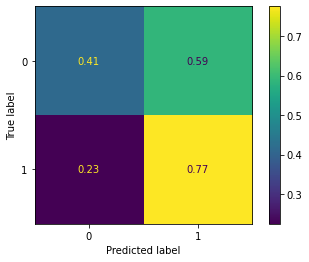

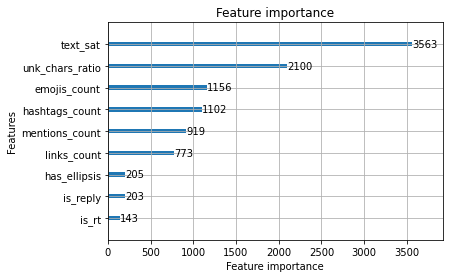

In [40]:
eval_clf(clf_meta_tweet, df_test_meta_tweet)

### Average probas at the user level

In [41]:
df_train_meta_agg_tweet, df_test_meta_agg_tweet = get_agg(clf_meta_tweet, 
                                                          df_train_meta_tweet, 
                                                          df_test_meta_tweet, 
                                                          df_train['id'], 
                                                          df_test['id'])
clf_meta_agg_tweet = get_best_clf(df_train_meta_agg_tweet)

[I 2022-03-29 17:08:36,692] A new study created in memory with name: no-name-bab2f2cd-f695-416e-bf51-715ed92f2eae


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:37,131] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 1.9255534843572205e-06, 'lambda_l2': 3.082179261909459e-08, 'num_leaves': 172, 'feature_fraction': 0.8145017756575026, 'bagging_fraction': 0.41331132635662043, 'bagging_freq': 7, 'learning_rate': 1.599176953934176e-05, 'min_child_samples': 92}. Best is trial 0 with value: 0.5.
[I 2022-03-29 17:08:37,210] Trial 2 finished with value: 0.7287363953240225 and parameters: {'lambda_l1': 1.5754228312329334e-07, 'lambda_l2': 3.668436590083907, 'num_leaves': 27, 'feature_fraction': 0.9330313901566533, 'bagging_fraction': 0.7801221058429226, 'bagging_freq': 7, 'learning_rate': 0.00788121797936562, 'min_child_samples': 94}. Best is trial 2 with value: 0.7287363953240225.


Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.832723
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.832863
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:37,461] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 0.010670123954128865, 'lambda_l2': 0.04577648452995584, 'num_leaves': 208, 'feature_fraction': 0.49366913857144173, 'bagging_fraction': 0.645419175398608, 'bagging_freq': 1, 'learning_rate': 7.771176976241245e-05, 'min_child_samples': 69}. Best is trial 2 with value: 0.7287363953240225.
[I 2022-03-29 17:08:37,570] Trial 4 finished with value: 0.748897398809665 and parameters: {'lambda_l1': 2.3887735788853925, 'lambda_l2': 0.0008525815342313814, 'num_leaves': 160, 'feature_fraction': 0.5462400451501364, 'bagging_fraction': 0.6173810384945265, 'bagging_freq': 1, 'learning_rate': 0.12223233498815436, 'min_child_samples': 40}. Best is trial 4 with value: 0.748897398809665.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.83435
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.833029
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.833929


[I 2022-03-29 17:08:37,649] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 9.426988875125323e-05, 'lambda_l2': 1.371048755496133e-08, 'num_leaves': 53, 'feature_fraction': 0.4497233002666301, 'bagging_fraction': 0.4044518896310791, 'bagging_freq': 7, 'learning_rate': 0.000887438078366144, 'min_child_samples': 19}. Best is trial 4 with value: 0.748897398809665.
[I 2022-03-29 17:08:37,681] Trial 5 finished with value: 0.7479726365209969 and parameters: {'lambda_l1': 2.125659562130499e-05, 'lambda_l2': 0.000125318649701969, 'num_leaves': 54, 'feature_fraction': 0.9178984321914847, 'bagging_fraction': 0.9019207435565221, 'bagging_freq': 3, 'learning_rate': 0.06602534963911, 'min_child_samples': 28}. Best is trial 4 with value: 0.748897398809665.


Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.832305
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:37,900] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 0.24060735238618253, 'lambda_l2': 1.1090883672255921e-05, 'num_leaves': 141, 'feature_fraction': 0.778264357708227, 'bagging_fraction': 0.8279323844022204, 'bagging_freq': 3, 'learning_rate': 6.394816111762328e-05, 'min_child_samples': 49}. Best is trial 4 with value: 0.748897398809665.
[I 2022-03-29 17:08:37,994] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 0.054949736182065625, 'lambda_l2': 2.6384894682165174e-06, 'num_leaves': 37, 'feature_fraction': 0.7542462306441506, 'bagging_fraction': 0.5653850979168277, 'bagging_freq': 5, 'learning_rate': 5.709718754927425e-05, 'min_child_samples': 12}. Best is trial 4 with value: 0.748897398809665.


Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.834625
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.834453
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:38,104] Trial 10 finished with value: 0.7438171341853793 and parameters: {'lambda_l1': 1.1757774995659023, 'lambda_l2': 1.9422705179354243e-06, 'num_leaves': 255, 'feature_fraction': 0.8681570158374283, 'bagging_fraction': 0.606508432850586, 'bagging_freq': 2, 'learning_rate': 0.02009918042109932, 'min_child_samples': 76}. Best is trial 4 with value: 0.748897398809665.
[I 2022-03-29 17:08:38,166] Trial 11 finished with value: 0.7414489128115146 and parameters: {'lambda_l1': 0.025868299268450873, 'lambda_l2': 0.9525927928258379, 'num_leaves': 26, 'feature_fraction': 0.9310715370290367, 'bagging_fraction': 0.6501196539432466, 'bagging_freq': 3, 'learning_rate': 0.029905339226537583, 'min_child_samples': 88}. Best is trial 4 with value: 0.748897398809665.


Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.835326
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.833107
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:38,339] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 5.586641797551713e-08, 'lambda_l2': 7.520833652214214e-08, 'num_leaves': 246, 'feature_fraction': 0.48144840808274475, 'bagging_fraction': 0.9709203289304051, 'bagging_freq': 3, 'learning_rate': 1.8427464401765187e-05, 'min_child_samples': 51}. Best is trial 4 with value: 0.748897398809665.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.830636
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:38,558] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 1.5689563578996901, 'lambda_l2': 4.002551708601299e-05, 'num_leaves': 91, 'feature_fraction': 0.6725152852044, 'bagging_fraction': 0.5011862953028542, 'bagging_freq': 1, 'learning_rate': 4.082450360146445e-05, 'min_child_samples': 12}. Best is trial 4 with value: 0.748897398809665.
[I 2022-03-29 17:08:38,715] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 0.19223024684866452, 'lambda_l2': 4.0488956016645184e-06, 'num_leaves': 22, 'feature_fraction': 0.9553944311940956, 'bagging_fraction': 0.4912727300924538, 'bagging_freq': 1, 'learning_rate': 0.00010860315825784734, 'min_child_samples': 34}. Best is trial 4 with value: 0.748897398809665.


Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.832239
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.832969


[I 2022-03-29 17:08:38,825] Trial 17 finished with value: 0.751431603158419 and parameters: {'lambda_l1': 7.506516844376025, 'lambda_l2': 0.007206414152430754, 'num_leaves': 111, 'feature_fraction': 0.5968931476859483, 'bagging_fraction': 0.9973097641227835, 'bagging_freq': 1, 'learning_rate': 0.28416600465285463, 'min_child_samples': 44}. Best is trial 17 with value: 0.751431603158419.
[I 2022-03-29 17:08:38,982] Trial 14 finished with value: 0.7577093163872619 and parameters: {'lambda_l1': 0.8199245438015164, 'lambda_l2': 6.838193681106014e-07, 'num_leaves': 65, 'feature_fraction': 0.49445973361305673, 'bagging_fraction': 0.8312754505644948, 'bagging_freq': 6, 'learning_rate': 0.026079299034659508, 'min_child_samples': 74}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.833608
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.834854


[I 2022-03-29 17:08:39,202] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 0.0008647771000871669, 'lambda_l2': 3.0640484546768136e-08, 'num_leaves': 61, 'feature_fraction': 0.8868917278283583, 'bagging_fraction': 0.5104839550422442, 'bagging_freq': 2, 'learning_rate': 5.0454306970050855e-05, 'min_child_samples': 8}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.832395
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:39,641] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 0.008770412599417066, 'lambda_l2': 0.2933504515207128, 'num_leaves': 92, 'feature_fraction': 0.9878480852156085, 'bagging_fraction': 0.490043748050456, 'bagging_freq': 6, 'learning_rate': 2.5127285138764605e-05, 'min_child_samples': 16}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.82979
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:39,813] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 1.4475424366976035e-06, 'lambda_l2': 5.181831423854625, 'num_leaves': 208, 'feature_fraction': 0.5112287930285973, 'bagging_fraction': 0.6790660021725241, 'bagging_freq': 3, 'learning_rate': 0.0014016368267241802, 'min_child_samples': 13}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.831555
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:40,111] Trial 24 finished with value: 0.7448337799065753 and parameters: {'lambda_l1': 9.518885443545383, 'lambda_l2': 0.0022022878419181956, 'num_leaves': 97, 'feature_fraction': 0.612257866418291, 'bagging_fraction': 0.9634362064807442, 'bagging_freq': 4, 'learning_rate': 0.2385620870435168, 'min_child_samples': 70}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.834028
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:40,378] Trial 18 finished with value: 0.7484468735921087 and parameters: {'lambda_l1': 0.00016856654455715928, 'lambda_l2': 0.003385979136895321, 'num_leaves': 94, 'feature_fraction': 0.5941068998800711, 'bagging_fraction': 0.962909892837176, 'bagging_freq': 1, 'learning_rate': 0.18451792268095024, 'min_child_samples': 32}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.822935
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:40,582] Trial 25 finished with value: 0.7473679842553292 and parameters: {'lambda_l1': 5.3299149146515035, 'lambda_l2': 0.0036635566720712763, 'num_leaves': 102, 'feature_fraction': 0.6071130327135641, 'bagging_fraction': 0.9607960247069562, 'bagging_freq': 5, 'learning_rate': 0.2717639513318973, 'min_child_samples': 63}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:40,660] Trial 22 finished with value: 0.7514138192682522 and parameters: {'lambda_l1': 0.002250914612599214, 'lambda_l2': 0.005060300083765661, 'num_leaves': 94, 'feature_fraction': 0.6272220063844254, 'bagging_fraction': 0.9797252629599038, 'bagging_freq': 5, 'learning_rate': 0.2602440997687531, 'min_child_samples': 67}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:40,754] Trial 21 finished with value: 0.7435325919427123 and parameters: {'lambda_l1': 0.0018386588382573526, 'lambda_l2': 0.01023882463019631, 'num_leaves': 108, 'feature_fraction': 0.606921470

Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.831106
Did not meet early stopping. Best iteration is:
[5]	valid_0's auc: 0.832714
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.820258
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:40,926] Trial 19 finished with value: 0.7446114812794916 and parameters: {'lambda_l1': 0.00010468183670077931, 'lambda_l2': 0.0031386654331437753, 'num_leaves': 110, 'feature_fraction': 0.6226945272651597, 'bagging_fraction': 0.9380193362131729, 'bagging_freq': 5, 'learning_rate': 0.2868551940070257, 'min_child_samples': 36}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.818935
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.825861
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.822996


[I 2022-03-29 17:08:41,021] Trial 23 finished with value: 0.7539658075071728 and parameters: {'lambda_l1': 0.002134802593130675, 'lambda_l2': 0.0077186884257113494, 'num_leaves': 99, 'feature_fraction': 0.6059243717623982, 'bagging_fraction': 0.9972390202021273, 'bagging_freq': 5, 'learning_rate': 0.2667069577568622, 'min_child_samples': 62}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:41,021] Trial 20 finished with value: 0.7463750503876889 and parameters: {'lambda_l1': 8.212251851863292e-05, 'lambda_l2': 0.002671920090727904, 'num_leaves': 102, 'feature_fraction': 0.611199870769391, 'bagging_fraction': 0.9531009658996741, 'bagging_freq': 5, 'learning_rate': 0.1635205849600759, 'min_child_samples': 31}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:41,224] Trial 27 finished with value: 0.7093134232802979 and parameters: {'lambda_l1': 8.204562990829848, 'lambda_l2': 0.019364526364892443, 'num_leaves': 123, 'feature_fraction': 0.4101198503

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.82892
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.818053Training until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:41,287] Trial 30 finished with value: 0.751899912266142 and parameters: {'lambda_l1': 0.2901430066546254, 'lambda_l2': 0.09209572056745431, 'num_leaves': 3, 'feature_fraction': 0.4199050949459702, 'bagging_fraction': 0.8800931374794886, 'bagging_freq': 5, 'learning_rate': 0.00847658562043223, 'min_child_samples': 59}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:41,522] Trial 26 finished with value: 0.711539373532829 and parameters: {'lambda_l1': 0.0004965093428739363, 'lambda_l2': 0.010817735597594988, 'num_leaves': 109, 'feature_fraction': 0.41002845309402536, 'bagging_fraction': 0.7620586629904713, 'bagging_freq': 5, 'learning_rate': 0.005230043116088854, 'min_child_samples': 60}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.832777


[I 2022-03-29 17:08:41,741] Trial 36 finished with value: 0.7492975363384156 and parameters: {'lambda_l1': 0.24436912700364039, 'lambda_l2': 0.09703452468950381, 'num_leaves': 2, 'feature_fraction': 0.5378279534143364, 'bagging_fraction': 0.8574971252067874, 'bagging_freq': 6, 'learning_rate': 0.048135378013953685, 'min_child_samples': 82}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.830461
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:42,243] Trial 35 finished with value: 0.5 and parameters: {'lambda_l1': 0.4993772522780917, 'lambda_l2': 3.5443915144542157e-07, 'num_leaves': 72, 'feature_fraction': 0.4167809762017081, 'bagging_fraction': 0.861008972957053, 'bagging_freq': 6, 'learning_rate': 0.0004284720745250691, 'min_child_samples': 82}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:42,338] Trial 29 finished with value: 0.73786842292462 and parameters: {'lambda_l1': 0.002134159934093751, 'lambda_l2': 0.031536023576019964, 'num_leaves': 133, 'feature_fraction': 0.6694669796957153, 'bagging_fraction': 0.8806489823689203, 'bagging_freq': 5, 'learning_rate': 0.006451901161363162, 'min_child_samples': 58}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.833924
Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.835354
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.836267Training until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.83156
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.833532


[I 2022-03-29 17:08:42,432] Trial 31 finished with value: 0.6418205961159984 and parameters: {'lambda_l1': 0.3728843490624988, 'lambda_l2': 0.09830682158118165, 'num_leaves': 73, 'feature_fraction': 0.6825118143803451, 'bagging_fraction': 0.8584518033632459, 'bagging_freq': 6, 'learning_rate': 0.010119188639775487, 'min_child_samples': 59}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:42,447] Trial 28 finished with value: 0.7491256254001375 and parameters: {'lambda_l1': 0.6534465012592596, 'lambda_l2': 0.04072106230788507, 'num_leaves': 142, 'feature_fraction': 0.40472766760887535, 'bagging_fraction': 0.7498378592603229, 'bagging_freq': 2, 'learning_rate': 0.07373232993776613, 'min_child_samples': 42}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:42,541] Trial 32 finished with value: 0.7149983401702511 and parameters: {'lambda_l1': 0.3641179643529567, 'lambda_l2': 0.04068295963566116, 'num_leaves': 131, 'feature_fraction': 0.4090430843320

Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.836235
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.832888
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:43,232] Trial 37 finished with value: 0.5 and parameters: {'lambda_l1': 0.0675242178675789, 'lambda_l2': 3.020570410255103e-07, 'num_leaves': 71, 'feature_fraction': 0.6883756147954118, 'bagging_fraction': 0.8921303940310483, 'bagging_freq': 6, 'learning_rate': 0.00044242540966052857, 'min_child_samples': 57}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.834745
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:43,583] Trial 41 finished with value: 0.7457348303416877 and parameters: {'lambda_l1': 0.0875681135688566, 'lambda_l2': 0.00045681597015479776, 'num_leaves': 163, 'feature_fraction': 0.46229616598620227, 'bagging_fraction': 0.8073041543705182, 'bagging_freq': 4, 'learning_rate': 0.01353370333802912, 'min_child_samples': 98}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:43,718] Trial 44 finished with value: 0.7498784767505275 and parameters: {'lambda_l1': 0.07621389170928852, 'lambda_l2': 0.00047813710236199465, 'num_leaves': 160, 'feature_fraction': 0.4721437932428153, 'bagging_fraction': 0.9160874777155131, 'bagging_freq': 4, 'learning_rate': 0.016152590093889023, 'min_child_samples': 98}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.834236
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.834312
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.834583


[I 2022-03-29 17:08:43,783] Trial 38 finished with value: 0.7395697484172338 and parameters: {'lambda_l1': 0.057755020089524815, 'lambda_l2': 0.00030062487236327454, 'num_leaves': 73, 'feature_fraction': 0.6841020852352075, 'bagging_fraction': 0.9014373204528179, 'bagging_freq': 4, 'learning_rate': 0.01900285305213067, 'min_child_samples': 56}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:43,937] Trial 39 finished with value: 0.7515798022431414 and parameters: {'lambda_l1': 0.07516183169277868, 'lambda_l2': 0.0004491873781865283, 'num_leaves': 72, 'feature_fraction': 0.5501148213288292, 'bagging_fraction': 0.9167601002819198, 'bagging_freq': 4, 'learning_rate': 0.020242181359378948, 'min_child_samples': 45}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.831284
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:44,188] Trial 49 finished with value: 0.7537316529533113 and parameters: {'lambda_l1': 0.010413991922062663, 'lambda_l2': 3.841122698619626e-05, 'num_leaves': 4, 'feature_fraction': 0.5077144024432119, 'bagging_fraction': 0.9956216825625182, 'bagging_freq': 7, 'learning_rate': 0.10200149149504226, 'min_child_samples': 50}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.836942
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:44,486] Trial 43 finished with value: 0.7514197472316411 and parameters: {'lambda_l1': 0.052099040515976705, 'lambda_l2': 0.00048196402859127234, 'num_leaves': 176, 'feature_fraction': 0.46871683291627125, 'bagging_fraction': 0.8106662457926541, 'bagging_freq': 4, 'learning_rate': 0.019945616232683205, 'min_child_samples': 47}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:44,564] Trial 40 finished with value: 0.7563281009176487 and parameters: {'lambda_l1': 0.03776122128370026, 'lambda_l2': 0.00011945811611351216, 'num_leaves': 170, 'feature_fraction': 0.46658881800144947, 'bagging_fraction': 0.9994701836445243, 'bagging_freq': 4, 'learning_rate': 0.017707041826850258, 'min_child_samples': 47}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.831638
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.831123
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:44,706] Trial 42 finished with value: 0.7552551395442582 and parameters: {'lambda_l1': 0.03301739785647847, 'lambda_l2': 0.0005813175503252857, 'num_leaves': 165, 'feature_fraction': 0.4698137671954785, 'bagging_fraction': 0.9997107957847583, 'bagging_freq': 4, 'learning_rate': 0.015162111408903091, 'min_child_samples': 48}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:44,800] Trial 50 finished with value: 0.7519680838451142 and parameters: {'lambda_l1': 0.015465063911965853, 'lambda_l2': 3.357179477085261e-05, 'num_leaves': 14, 'feature_fraction': 0.4952787046637488, 'bagging_fraction': 0.9283868041677966, 'bagging_freq': 7, 'learning_rate': 0.09680814189801486, 'min_child_samples': 48}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.830992
Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.83469
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:44,894] Trial 47 finished with value: 0.7535715979418112 and parameters: {'lambda_l1': 2.640427108298885, 'lambda_l2': 0.00011750588885856911, 'num_leaves': 43, 'feature_fraction': 0.5174949384153407, 'bagging_fraction': 0.9900749599993869, 'bagging_freq': 7, 'learning_rate': 0.10647380985971666, 'min_child_samples': 68}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:45,004] Trial 52 finished with value: 0.7451479619661869 and parameters: {'lambda_l1': 0.009832396817020606, 'lambda_l2': 5.741539220834696e-05, 'num_leaves': 2, 'feature_fraction': 0.5030858580367863, 'bagging_fraction': 0.9975913292062752, 'bagging_freq': 7, 'learning_rate': 0.10100924972818519, 'min_child_samples': 52}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.831953
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.835005
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:45,098] Trial 48 finished with value: 0.7515857302065303 and parameters: {'lambda_l1': 0.006747691259262472, 'lambda_l2': 0.6667049290202619, 'num_leaves': 49, 'feature_fraction': 0.5732362553414959, 'bagging_fraction': 0.9896559934400654, 'bagging_freq': 7, 'learning_rate': 0.10586230451359212, 'min_child_samples': 71}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.831864
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:45,348] Trial 45 finished with value: 0.753953951580395 and parameters: {'lambda_l1': 0.011200917476562206, 'lambda_l2': 0.0007194893713700212, 'num_leaves': 168, 'feature_fraction': 0.465254260625244, 'bagging_fraction': 0.9988450635076217, 'bagging_freq': 4, 'learning_rate': 0.020009869320760255, 'min_child_samples': 48}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.831617
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:45,599] Trial 51 finished with value: 0.754804614326702 and parameters: {'lambda_l1': 0.009406867292957541, 'lambda_l2': 2.837621027216125e-05, 'num_leaves': 41, 'feature_fraction': 0.5078860661563197, 'bagging_fraction': 0.9325843813469633, 'bagging_freq': 7, 'learning_rate': 0.08574990620144908, 'min_child_samples': 52}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:45,694] Trial 46 finished with value: 0.7489033267730538 and parameters: {'lambda_l1': 0.01384252025334626, 'lambda_l2': 0.00010902836469593163, 'num_leaves': 193, 'feature_fraction': 0.5066842113711697, 'bagging_fraction': 0.9899932564687403, 'bagging_freq': 4, 'learning_rate': 0.10889086314205056, 'min_child_samples': 49}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.833324
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.827556
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:46,540] Trial 53 finished with value: 0.7504386692907785 and parameters: {'lambda_l1': 0.006474458041579614, 'lambda_l2': 7.644074824622964e-05, 'num_leaves': 193, 'feature_fraction': 0.5058699275966148, 'bagging_fraction': 0.9993542090546789, 'bagging_freq': 7, 'learning_rate': 0.11200298410556145, 'min_child_samples': 51}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:46,635] Trial 55 finished with value: 0.7559457472790648 and parameters: {'lambda_l1': 0.0043007064935971, 'lambda_l2': 2.63531240004386e-05, 'num_leaves': 185, 'feature_fraction': 0.44106227780302265, 'bagging_fraction': 0.997073133885257, 'bagging_freq': 7, 'learning_rate': 0.0346274837544694, 'min_child_samples': 53}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.829221
Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.831318
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:47,811] Trial 54 finished with value: 0.7468255756052451 and parameters: {'lambda_l1': 0.007500346929928686, 'lambda_l2': 7.096353107301679e-05, 'num_leaves': 187, 'feature_fraction': 0.5149864770777223, 'bagging_fraction': 0.9945841093233492, 'bagging_freq': 7, 'learning_rate': 0.036998376548069055, 'min_child_samples': 25}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:47,920] Trial 57 finished with value: 0.7506609679178622 and parameters: {'lambda_l1': 0.004679905540890154, 'lambda_l2': 5.883026711433447e-06, 'num_leaves': 205, 'feature_fraction': 0.4362376756069753, 'bagging_fraction': 0.9413996605211572, 'bagging_freq': 3, 'learning_rate': 0.03288050479941917, 'min_child_samples': 25}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.821652
Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.824352
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:47,999] Trial 56 finished with value: 0.738982880041733 and parameters: {'lambda_l1': 0.004672841092789143, 'lambda_l2': 1.036911555404285e-05, 'num_leaves': 190, 'feature_fraction': 0.44223688895396274, 'bagging_fraction': 0.9394878494224865, 'bagging_freq': 7, 'learning_rate': 0.03653850597715431, 'min_child_samples': 24}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.823666
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:48,492] Trial 58 finished with value: 0.7494338794963601 and parameters: {'lambda_l1': 0.005620485601511291, 'lambda_l2': 1.1636540948277968e-05, 'num_leaves': 191, 'feature_fraction': 0.44134175773596535, 'bagging_fraction': 0.9428724109718064, 'bagging_freq': 3, 'learning_rate': 0.030933396817547823, 'min_child_samples': 24}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:48,595] Trial 60 finished with value: 0.7411288027885139 and parameters: {'lambda_l1': 0.004047594114260092, 'lambda_l2': 9.752285502210133e-06, 'num_leaves': 184, 'feature_fraction': 0.4425619831786779, 'bagging_fraction': 0.9442923163339694, 'bagging_freq': 3, 'learning_rate': 0.03441367983431697, 'min_child_samples': 25}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.824572
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.824661
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:48,924] Trial 59 finished with value: 0.739525288691817 and parameters: {'lambda_l1': 0.004469905561897848, 'lambda_l2': 1.043230395855915e-05, 'num_leaves': 202, 'feature_fraction': 0.4437954335028588, 'bagging_fraction': 0.9402312824765992, 'bagging_freq': 3, 'learning_rate': 0.039741156117524774, 'min_child_samples': 22}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.822934
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.833441

[I 2022-03-29 17:08:49,128] Trial 63 finished with value: 0.7465173215090224 and parameters: {'lambda_l1': 1.962551051556631e-08, 'lambda_l2': 1.3817695149459927e-05, 'num_leaves': 148, 'feature_fraction': 0.44538190146407347, 'bagging_fraction': 0.9445809579844814, 'bagging_freq': 3, 'learning_rate': 0.03354507299651088, 'min_child_samples': 76}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:49,206] Trial 61 finished with value: 0.739907642330401 and parameters: {'lambda_l1': 1.6442482837016747e-08, 'lambda_l2': 1.211384582862976e-05, 'num_leaves': 148, 'feature_fraction': 0.45072747892172366, 'bagging_fraction': 0.9414010500770085, 'bagging_freq': 3, 'learning_rate': 0.03915885761974804, 'min_child_samples': 24}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:49,253] Trial 64 finished with value: 0.5 and parameters: {'lambda_l1': 0.0009373246068397537, 'lambda_l2': 1.1470958363428308e-05, 'num_leaves': 148, 'feature_fraction': 0.7313025179


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.823823
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.836958


[I 2022-03-29 17:08:49,394] Trial 65 finished with value: 0.5 and parameters: {'lambda_l1': 9.802300595504304e-06, 'lambda_l2': 2.108874429740824e-05, 'num_leaves': 152, 'feature_fraction': 0.736684229611747, 'bagging_fraction': 0.9680452285035986, 'bagging_freq': 3, 'learning_rate': 1.0031329497009827e-05, 'min_child_samples': 75}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.836631
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:49,755] Trial 62 finished with value: 0.74074644914993 and parameters: {'lambda_l1': 1.321653894306415e-05, 'lambda_l2': 1.2879972884066602e-05, 'num_leaves': 219, 'feature_fraction': 0.4411093699473658, 'bagging_fraction': 0.9429871625308638, 'bagging_freq': 7, 'learning_rate': 0.03717185526402981, 'min_child_samples': 25}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:49,818] Trial 66 finished with value: 0.5 and parameters: {'lambda_l1': 2.7923687110625054e-05, 'lambda_l2': 1.430443301501765e-06, 'num_leaves': 226, 'feature_fraction': 0.6462476482326042, 'bagging_fraction': 0.9631866262906622, 'bagging_freq': 6, 'learning_rate': 0.0031316394107940896, 'min_child_samples': 74}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:49,912] Trial 67 finished with value: 0.6671567116401489 and parameters: {'lambda_l1': 0.0011493503581116516, 'lambda_l2': 9.74206654466796e-07, 'num_leaves': 234, 'feature_fraction': 0.7189070795792

Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.823877
Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.83727
Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.836731
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:50,571] Trial 68 finished with value: 0.6783605624451663 and parameters: {'lambda_l1': 0.0009509887628356311, 'lambda_l2': 0.0010200137952405838, 'num_leaves': 225, 'feature_fraction': 0.7474238604217529, 'bagging_fraction': 0.9689517994991469, 'bagging_freq': 4, 'learning_rate': 0.0027290143054128427, 'min_child_samples': 54}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.833604
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:51,276] Trial 69 finished with value: 0.5885578450667488 and parameters: {'lambda_l1': 0.0010954653254937052, 'lambda_l2': 0.00021765234202478066, 'num_leaves': 233, 'feature_fraction': 0.7324484776616209, 'bagging_fraction': 0.9700288987629668, 'bagging_freq': 4, 'learning_rate': 0.0035338452838343387, 'min_child_samples': 39}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:51,417] Trial 71 finished with value: 0.7485091172076921 and parameters: {'lambda_l1': 0.028282360520613836, 'lambda_l2': 0.0014514863077161066, 'num_leaves': 228, 'feature_fraction': 0.4819197083018199, 'bagging_fraction': 0.9655105892550588, 'bagging_freq': 4, 'learning_rate': 0.06589164860906054, 'min_child_samples': 39}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.833834
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.826835
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.829616


[I 2022-03-29 17:08:51,497] Trial 75 finished with value: 0.7559457472790648 and parameters: {'lambda_l1': 0.00040084096349714374, 'lambda_l2': 0.0002010217221097132, 'num_leaves': 83, 'feature_fraction': 0.48176437233327657, 'bagging_fraction': 0.9158487181292037, 'bagging_freq': 4, 'learning_rate': 0.060509942202720456, 'min_child_samples': 40}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:51,558] Trial 74 finished with value: 0.7511233490621961 and parameters: {'lambda_l1': 0.0002704073402385584, 'lambda_l2': 0.0013455280605376724, 'num_leaves': 84, 'feature_fraction': 0.5718803101678788, 'bagging_fraction': 0.9739959307043444, 'bagging_freq': 4, 'learning_rate': 0.0674427792830794, 'min_child_samples': 37}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:51,637] Trial 70 finished with value: 0.7538857800014229 and parameters: {'lambda_l1': 0.0007893110496212099, 'lambda_l2': 0.0013671502302354973, 'num_leaves': 227, 'feature_fraction': 0

Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.825875
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.823659
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.832219


[I 2022-03-29 17:08:51,747] Trial 72 finished with value: 0.7430464989448226 and parameters: {'lambda_l1': 0.021680515943998523, 'lambda_l2': 0.001091103064176388, 'num_leaves': 218, 'feature_fraction': 0.6490583664996735, 'bagging_fraction': 0.9753831584177619, 'bagging_freq': 4, 'learning_rate': 0.16373358575167996, 'min_child_samples': 38}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:52,029] Trial 73 finished with value: 0.7496680340502218 and parameters: {'lambda_l1': 0.0002804781813968638, 'lambda_l2': 0.0013554042844631192, 'num_leaves': 232, 'feature_fraction': 0.47880934593628915, 'bagging_fraction': 0.9679590982845124, 'bagging_freq': 4, 'learning_rate': 0.15776423423626762, 'min_child_samples': 38}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:52,186] Trial 76 finished with value: 0.7489774263154151 and parameters: {'lambda_l1': 0.03003368890021635, 'lambda_l2': 0.0014999183311715232, 'num_leaves': 83, 'feature_fraction': 0.48548646940698215, 'bagging_fraction': 0.919076584904152, 'bagging_freq': 5, 'learning_rate': 0.1690691110359528, 'min_child_samples': 39}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.825039
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.824919
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:52,875] Trial 79 finished with value: 0.7464491499300501 and parameters: {'lambda_l1': 0.0003540575232087849, 'lambda_l2': 0.00018302712483406037, 'num_leaves': 64, 'feature_fraction': 0.5312236500682955, 'bagging_fraction': 0.9159411654393801, 'bagging_freq': 5, 'learning_rate': 0.1578223883932558, 'min_child_samples': 43}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:52,907] Trial 78 finished with value: 0.7485150451710809 and parameters: {'lambda_l1': 0.01899496883361892, 'lambda_l2': 9.421850939109358e-08, 'num_leaves': 83, 'feature_fraction': 0.5267872522504183, 'bagging_fraction': 0.9252241841807997, 'bagging_freq': 7, 'learning_rate': 0.17582668983911662, 'min_child_samples': 63}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:53,048] Trial 80 finished with value: 0.6934116614895787 and parameters: {'lambda_l1': 0.0004578059974843916, 'lambda_l2': 0.00018595637848353993, 'num_leaves': 121, 'feature_fraction': 0.48

Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.827031
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.826251
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.832854


[I 2022-03-29 17:08:53,142] Trial 82 finished with value: 0.7082286059801295 and parameters: {'lambda_l1': 0.128574891186717, 'lambda_l2': 5.691690191187441e-08, 'num_leaves': 83, 'feature_fraction': 0.7934554600011686, 'bagging_fraction': 0.9156859217315183, 'bagging_freq': 5, 'learning_rate': 0.053720463700445566, 'min_child_samples': 64}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.835293
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:53,301] Trial 83 finished with value: 0.7435711237047401 and parameters: {'lambda_l1': 0.03238653428061118, 'lambda_l2': 0.0001988586715695256, 'num_leaves': 170, 'feature_fraction': 0.5297255292375718, 'bagging_fraction': 0.8380615973316093, 'bagging_freq': 5, 'learning_rate': 0.010229758303346463, 'min_child_samples': 64}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:53,409] Trial 77 finished with value: 0.7491256254001375 and parameters: {'lambda_l1': 0.03456402482698587, 'lambda_l2': 0.00117443205769456, 'num_leaves': 172, 'feature_fraction': 0.5700816668324866, 'bagging_fraction': 0.915823348809019, 'bagging_freq': 5, 'learning_rate': 0.068771347852219, 'min_child_samples': 38}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.834041
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.826523
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.831321
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:53,503] Trial 81 finished with value: 0.7525490242572263 and parameters: {'lambda_l1': 0.02527388712708926, 'lambda_l2': 0.00025197486750158134, 'num_leaves': 83, 'feature_fraction': 0.5286829166270245, 'bagging_fraction': 0.9166521245472856, 'bagging_freq': 5, 'learning_rate': 0.010477791224144023, 'min_child_samples': 43}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:54,036] Trial 86 finished with value: 0.7567163825196216 and parameters: {'lambda_l1': 0.0024524891352461467, 'lambda_l2': 0.0077838360009201, 'num_leaves': 32, 'feature_fraction': 0.5647086748081456, 'bagging_fraction': 0.9026131553065627, 'bagging_freq': 5, 'learning_rate': 0.021848629187743097, 'min_child_samples': 54}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.834795
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:54,256] Trial 89 finished with value: 0.7318930358286108 and parameters: {'lambda_l1': 0.0023586056855839864, 'lambda_l2': 0.005595291273473019, 'num_leaves': 31, 'feature_fraction': 0.5597523113289327, 'bagging_fraction': 0.5642857906080297, 'bagging_freq': 4, 'learning_rate': 0.0233006888798402, 'min_child_samples': 46}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:54,412] Trial 90 finished with value: 0.7500444597254168 and parameters: {'lambda_l1': 0.0031171426137900577, 'lambda_l2': 0.005681955116946832, 'num_leaves': 32, 'feature_fraction': 0.4638111708355489, 'bagging_fraction': 0.43973940746308343, 'bagging_freq': 4, 'learning_rate': 0.0229467372981091, 'min_child_samples': 54}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.832986
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.833412


[I 2022-03-29 17:08:54,553] Trial 91 finished with value: 0.7512715481469185 and parameters: {'lambda_l1': 0.0023251550755367376, 'lambda_l2': 0.005000743878009858, 'num_leaves': 36, 'feature_fraction': 0.4244804957803632, 'bagging_fraction': 0.4372282071469922, 'bagging_freq': 4, 'learning_rate': 0.027190583911965112, 'min_child_samples': 54}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:54,679] Trial 84 finished with value: 0.7495820785810827 and parameters: {'lambda_l1': 0.14381389153131433, 'lambda_l2': 0.00026053152906896864, 'num_leaves': 174, 'feature_fraction': 0.5276408729015972, 'bagging_fraction': 0.8371565861293029, 'bagging_freq': 5, 'learning_rate': 0.024764264053733727, 'min_child_samples': 45}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.833672
Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.831921
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 17:08:54,836] Trial 85 finished with value: 0.639600573826856 and parameters: {'lambda_l1': 0.13119139285801587, 'lambda_l2': 8.01949407552083e-08, 'num_leaves': 177, 'feature_fraction': 0.42267888761074324, 'bagging_fraction': 0.7309490480803786, 'bagging_freq': 5, 'learning_rate': 0.010527344141862165, 'min_child_samples': 46}. Best is trial 14 with value: 0.7577093163872619.



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.83322


[I 2022-03-29 17:08:55,040] Trial 87 finished with value: 0.74564294690916 and parameters: {'lambda_l1': 0.14171411532608366, 'lambda_l2': 0.008109694685235596, 'num_leaves': 170, 'feature_fraction': 0.4256358423862103, 'bagging_fraction': 0.9004247709414789, 'bagging_freq': 5, 'learning_rate': 0.009967412836407806, 'min_child_samples': 55}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.832236
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:55,479] Trial 96 finished with value: 0.7494220235695824 and parameters: {'lambda_l1': 0.8343550543812785, 'lambda_l2': 0.01732636210664925, 'num_leaves': 18, 'feature_fraction': 0.42575055568901615, 'bagging_fraction': 0.8942788014546762, 'bagging_freq': 6, 'learning_rate': 0.015304446110831761, 'min_child_samples': 32}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:55,620] Trial 88 finished with value: 0.7472820287861902 and parameters: {'lambda_l1': 0.0018331198912961957, 'lambda_l2': 0.006173348419655618, 'num_leaves': 173, 'feature_fraction': 0.5659809722864008, 'bagging_fraction': 0.8344076891085763, 'bagging_freq': 4, 'learning_rate': 0.0661467217050027, 'min_child_samples': 45}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.83394
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.829774


[I 2022-03-29 17:08:55,792] Trial 92 finished with value: 0.7503467858582505 and parameters: {'lambda_l1': 0.0027124638245312337, 'lambda_l2': 0.015585992450028762, 'num_leaves': 56, 'feature_fraction': 0.4597740844434834, 'bagging_fraction': 0.8973509983467018, 'bagging_freq': 4, 'learning_rate': 0.020989695604896292, 'min_child_samples': 55}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:55,918] Trial 93 finished with value: 0.7546386313518129 and parameters: {'lambda_l1': 0.0023721167842392543, 'lambda_l2': 0.013770021854799218, 'num_leaves': 56, 'feature_fraction': 0.46517468401032436, 'bagging_fraction': 0.8985859027487431, 'bagging_freq': 4, 'learning_rate': 0.016665863755113263, 'min_child_samples': 55}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.832572
Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.832606


[I 2022-03-29 17:08:56,006] Trial 94 finished with value: 0.7503408578948616 and parameters: {'lambda_l1': 0.0001443110680028139, 'lambda_l2': 1.3997950631151977e-08, 'num_leaves': 51, 'feature_fraction': 0.42455642792134574, 'bagging_fraction': 0.8960898788355502, 'bagging_freq': 6, 'learning_rate': 0.015508366683217128, 'min_child_samples': 34}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:56,153] Trial 95 finished with value: 0.7464254380764944 and parameters: {'lambda_l1': 0.8932039429839604, 'lambda_l2': 0.0006710550059956705, 'num_leaves': 58, 'feature_fraction': 0.4634258358239724, 'bagging_fraction': 0.9009528033061076, 'bagging_freq': 6, 'learning_rate': 0.01524705699361989, 'min_child_samples': 34}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.831431
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.831646
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.832402


[I 2022-03-29 17:08:56,185] Trial 97 finished with value: 0.7492619685580821 and parameters: {'lambda_l1': 1.7998777827286299, 'lambda_l2': 0.019349591575561157, 'num_leaves': 53, 'feature_fraction': 0.4592559930950839, 'bagging_fraction': 0.8939546152879861, 'bagging_freq': 6, 'learning_rate': 0.014241434492228616, 'min_child_samples': 35}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:56,232] Trial 98 finished with value: 0.7515857302065303 and parameters: {'lambda_l1': 0.00012997363975668534, 'lambda_l2': 0.017885646677191606, 'num_leaves': 52, 'feature_fraction': 0.4613464493286713, 'bagging_fraction': 0.9830471952894286, 'bagging_freq': 4, 'learning_rate': 0.2271452828011453, 'min_child_samples': 33}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.826872


[I 2022-03-29 17:08:56,671] Trial 99 finished with value: 0.7490515258577763 and parameters: {'lambda_l1': 0.0014434821192476084, 'lambda_l2': 0.0006038054908703, 'num_leaves': 246, 'feature_fraction': 0.4704008713248127, 'bagging_fraction': 0.9806471392481758, 'bagging_freq': 4, 'learning_rate': 0.04870539300102246, 'min_child_samples': 34}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.826946
{'lambda_l1': 0.8199245438015164, 'lambda_l2': 6.838193681106014e-07, 'num_leaves': 65, 'feature_fraction': 0.49445973361305673, 'bagging_fraction': 0.8312754505644948, 'bagging_freq': 6, 'learning_rate': 0.026079299034659508, 'min_child_samples': 74} -> 0.7577093163872619
[LightGBM] [Warning] feature_fraction is set=0.49445973361305673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49445973361305673
[LightGBM] [Warning] lambda_l1 is set=0.8199245438015164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8199245438015164
[LightGBM] [Warning] bagging_fraction is set=0.8312754505644948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312754505644948
[LightGBM] [Warning] lambda_l2 is set=6.838193681106014e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.838193681106014e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be igno

AUROC: 0.6632409645488029
Accuracy: 0.6720202874049028


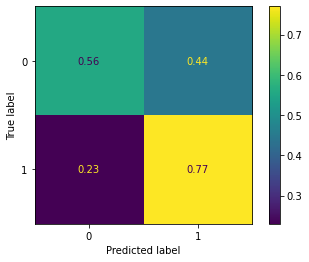

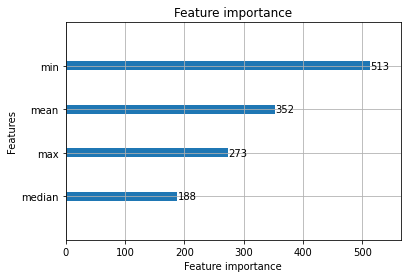

In [42]:
eval_clf(clf_meta_agg_tweet, df_test_meta_agg_tweet)

### Average features at the user level

> Mean

In [43]:
df_train_meta_tweet_mean = get_mean(df_train_meta_tweet, df_train['id'])
df_test_meta_tweet_mean = get_mean(df_test_meta_tweet, df_test['id'])

clf_meta_tweet_mean = get_best_clf(df_train_meta_tweet_mean)

[I 2022-03-29 17:08:57,690] A new study created in memory with name: no-name-ba517b9f-e0b8-4021-8058-f8b8af27e2a3


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:58,114] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 6.986916808169173, 'lambda_l2': 1.168899041375324e-08, 'num_leaves': 7, 'feature_fraction': 0.4332177152710003, 'bagging_fraction': 0.732858074148687, 'bagging_freq': 1, 'learning_rate': 6.49128345361141e-05, 'min_child_samples': 31}. Best is trial 7 with value: 0.5.


Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.697023
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:58,333] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 0.07381664140955792, 'lambda_l2': 0.0005929877357813107, 'num_leaves': 3, 'feature_fraction': 0.5607717949961617, 'bagging_fraction': 0.5384463112515689, 'bagging_freq': 7, 'learning_rate': 2.137905591393332e-05, 'min_child_samples': 21}. Best is trial 7 with value: 0.5.


Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.661068
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:58,631] Trial 5 finished with value: 0.6856697413036776 and parameters: {'lambda_l1': 6.246741545172321e-08, 'lambda_l2': 8.810563354588025, 'num_leaves': 23, 'feature_fraction': 0.5518190333546605, 'bagging_fraction': 0.7234149741341802, 'bagging_freq': 1, 'learning_rate': 0.022745506000299516, 'min_child_samples': 65}. Best is trial 5 with value: 0.6856697413036776.
[I 2022-03-29 17:08:58,725] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 5.641741236016768, 'lambda_l2': 2.2413492668701706e-08, 'num_leaves': 243, 'feature_fraction': 0.48153037322793285, 'bagging_fraction': 0.7557944603925042, 'bagging_freq': 4, 'learning_rate': 1.097889676313601e-05, 'min_child_samples': 76}. Best is trial 5 with value: 0.6856697413036776.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.762875
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.724554


[I 2022-03-29 17:08:58,961] Trial 3 finished with value: 0.7122270172859413 and parameters: {'lambda_l1': 1.8223470350476332, 'lambda_l2': 7.250898870714192e-05, 'num_leaves': 244, 'feature_fraction': 0.8486115549227016, 'bagging_fraction': 0.6223738230650093, 'bagging_freq': 2, 'learning_rate': 0.1684289471814477, 'min_child_samples': 81}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:08:58,992] Trial 0 finished with value: 0.5104391435278495 and parameters: {'lambda_l1': 0.0019843015350234326, 'lambda_l2': 2.693661327447329e-07, 'num_leaves': 130, 'feature_fraction': 0.9966692219217453, 'bagging_fraction': 0.4760519686474485, 'bagging_freq': 7, 'learning_rate': 0.0017689921949983682, 'min_child_samples': 63}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.782839
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.743992
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:59,259] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 2.1427642104002964e-06, 'lambda_l2': 0.010395910177745837, 'num_leaves': 41, 'feature_fraction': 0.9382801088906302, 'bagging_fraction': 0.9610947831170485, 'bagging_freq': 6, 'learning_rate': 0.0004430454269882997, 'min_child_samples': 33}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.746506
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:59,839] Trial 13 finished with value: 0.6519663054560975 and parameters: {'lambda_l1': 0.0005506117424822316, 'lambda_l2': 0.01884426849779974, 'num_leaves': 21, 'feature_fraction': 0.9211592557562399, 'bagging_fraction': 0.9472782296293488, 'bagging_freq': 4, 'learning_rate': 0.010449580592808113, 'min_child_samples': 58}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:08:59,980] Trial 1 finished with value: 0.7004866857942286 and parameters: {'lambda_l1': 0.00012447911004197972, 'lambda_l2': 5.7312496375012545, 'num_leaves': 133, 'feature_fraction': 0.8435193863930548, 'bagging_fraction': 0.7414388763492576, 'bagging_freq': 7, 'learning_rate': 0.11683710287231958, 'min_child_samples': 57}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.753214
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's auc: 0.776531
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.768462


[I 2022-03-29 17:09:00,027] Trial 10 finished with value: 0.6838943162687027 and parameters: {'lambda_l1': 0.16576861466198972, 'lambda_l2': 7.76717929072872e-06, 'num_leaves': 191, 'feature_fraction': 0.6771680308207566, 'bagging_fraction': 0.7084381751746148, 'bagging_freq': 2, 'learning_rate': 0.01739669730441871, 'min_child_samples': 85}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:00,199] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 0.008939549237478032, 'lambda_l2': 7.214982028964162e-07, 'num_leaves': 80, 'feature_fraction': 0.5518852499699182, 'bagging_fraction': 0.9551125325619076, 'bagging_freq': 6, 'learning_rate': 0.00038209088417180556, 'min_child_samples': 56}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.76076


[I 2022-03-29 17:09:00,325] Trial 9 finished with value: 0.6754588243663007 and parameters: {'lambda_l1': 0.8351734546784546, 'lambda_l2': 6.275251148991911e-06, 'num_leaves': 129, 'feature_fraction': 0.6646962282294495, 'bagging_fraction': 0.7542566011671061, 'bagging_freq': 7, 'learning_rate': 0.020055887161405994, 'min_child_samples': 59}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.769362
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:00,544] Trial 14 finished with value: 0.5 and parameters: {'lambda_l1': 9.29617028514209e-08, 'lambda_l2': 0.00013287208151767415, 'num_leaves': 234, 'feature_fraction': 0.7859970443896245, 'bagging_fraction': 0.46563278772048966, 'bagging_freq': 3, 'learning_rate': 3.495658998247005e-05, 'min_child_samples': 70}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.751752
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:01,141] Trial 17 finished with value: 0.6948195527944419 and parameters: {'lambda_l1': 0.032188962569016814, 'lambda_l2': 1.4987065465343003e-05, 'num_leaves': 247, 'feature_fraction': 0.7711440324933401, 'bagging_fraction': 0.5680585346767459, 'bagging_freq': 3, 'learning_rate': 0.2861387072710703, 'min_child_samples': 99}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.768198
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:01,376] Trial 19 finished with value: 0.6987231166860313 and parameters: {'lambda_l1': 1.1871652293536846e-05, 'lambda_l2': 9.522759203929956, 'num_leaves': 224, 'feature_fraction': 0.829733612035112, 'bagging_fraction': 0.5951760830822885, 'bagging_freq': 3, 'learning_rate': 0.20070320897454721, 'min_child_samples': 91}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:01,470] Trial 18 finished with value: 0.6942089725653853 and parameters: {'lambda_l1': 3.6051643787772344e-06, 'lambda_l2': 7.512864776270663, 'num_leaves': 255, 'feature_fraction': 0.8134366380147051, 'bagging_fraction': 0.601374948187693, 'bagging_freq': 3, 'learning_rate': 0.2637270722780144, 'min_child_samples': 99}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.774518
Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.764461Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.758585

Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.756413


[I 2022-03-29 17:09:01,548] Trial 12 finished with value: 0.6752928413914117 and parameters: {'lambda_l1': 6.045995731629751e-07, 'lambda_l2': 0.10936384667752372, 'num_leaves': 77, 'feature_fraction': 0.4552202363938841, 'bagging_fraction': 0.6877102611226686, 'bagging_freq': 6, 'learning_rate': 0.019907910953176376, 'min_child_samples': 18}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:01,642] Trial 16 finished with value: 0.642484528015555 and parameters: {'lambda_l1': 0.3987623764208986, 'lambda_l2': 3.89814977594857, 'num_leaves': 175, 'feature_fraction': 0.6311260582300795, 'bagging_fraction': 0.8946268223930949, 'bagging_freq': 4, 'learning_rate': 0.008155313658985947, 'min_child_samples': 89}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:01,642] Trial 20 finished with value: 0.6931241552652171 and parameters: {'lambda_l1': 2.0804907453181804e-05, 'lambda_l2': 6.030261683264278, 'num_leaves': 174, 'feature_fraction': 0.81332984505103

Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.768434
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:01,830] Trial 15 finished with value: 0.6952760059753871 and parameters: {'lambda_l1': 1.5715906286867993, 'lambda_l2': 1.1403477008561571e-06, 'num_leaves': 175, 'feature_fraction': 0.7896917695152663, 'bagging_fraction': 0.5931037988821616, 'bagging_freq': 6, 'learning_rate': 0.25617168776683524, 'min_child_samples': 45}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.764547
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:02,254] Trial 21 finished with value: 0.6948254807578308 and parameters: {'lambda_l1': 2.892121547441393e-05, 'lambda_l2': 3.305530496385248, 'num_leaves': 184, 'feature_fraction': 0.8371180901398437, 'bagging_fraction': 0.6146007918694327, 'bagging_freq': 5, 'learning_rate': 0.2881644894427566, 'min_child_samples': 88}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.761592
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:03,069] Trial 27 finished with value: 0.6910582600241861 and parameters: {'lambda_l1': 9.87231980905184e-05, 'lambda_l2': 0.00037061869761129904, 'num_leaves': 93, 'feature_fraction': 0.8934016728182926, 'bagging_fraction': 0.8378746773151993, 'bagging_freq': 5, 'learning_rate': 0.06717225327394599, 'min_child_samples': 77}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.776382
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:03,492] Trial 28 finished with value: 0.7051668128897635 and parameters: {'lambda_l1': 0.00010869638714861097, 'lambda_l2': 0.33269843903700513, 'num_leaves': 210, 'feature_fraction': 0.8836922297841997, 'bagging_fraction': 0.8308856339048131, 'bagging_freq': 2, 'learning_rate': 0.07691661996975971, 'min_child_samples': 79}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:03,634] Trial 11 finished with value: 0.7008808953595903 and parameters: {'lambda_l1': 2.5916950601921896e-05, 'lambda_l2': 2.361415356386102, 'num_leaves': 179, 'feature_fraction': 0.9025522501579927, 'bagging_fraction': 0.8859950193290073, 'bagging_freq': 1, 'learning_rate': 0.041617473629624986, 'min_child_samples': 11}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.772729
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.776928
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:03,712] Trial 24 finished with value: 0.7015715030943969 and parameters: {'lambda_l1': 0.00015199565816260556, 'lambda_l2': 0.0006141920547906524, 'num_leaves': 178, 'feature_fraction': 0.911863413058377, 'bagging_fraction': 0.8267407238495088, 'bagging_freq': 5, 'learning_rate': 0.06033943960572964, 'min_child_samples': 45}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:03,806] Trial 22 finished with value: 0.6966572214450003 and parameters: {'lambda_l1': 3.68855367369647e-05, 'lambda_l2': 0.17360348077716725, 'num_leaves': 173, 'feature_fraction': 0.8614118142590313, 'bagging_fraction': 0.853154816766787, 'bagging_freq': 5, 'learning_rate': 0.07567594184993795, 'min_child_samples': 44}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.773214
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.776298
Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.771424
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.772197


[I 2022-03-29 17:09:03,884] Trial 23 finished with value: 0.6927477295900221 and parameters: {'lambda_l1': 5.255634251556829e-05, 'lambda_l2': 0.15844253038405592, 'num_leaves': 171, 'feature_fraction': 0.8738840759952214, 'bagging_fraction': 0.8639251890627446, 'bagging_freq': 5, 'learning_rate': 0.06910722822728882, 'min_child_samples': 43}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:03,921] Trial 25 finished with value: 0.6921312213975768 and parameters: {'lambda_l1': 9.996583502729855e-05, 'lambda_l2': 0.0019900786649993465, 'num_leaves': 90, 'feature_fraction': 0.8993493316007096, 'bagging_fraction': 0.8316985646669727, 'bagging_freq': 5, 'learning_rate': 0.0687588447286149, 'min_child_samples': 38}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:04,230] Trial 26 finished with value: 0.6906759063856022 and parameters: {'lambda_l1': 0.00010229584272182449, 'lambda_l2': 0.000326758357578113, 'num_leaves': 94, 'feature_fraction': 0.8923935846987301, 'bagging_fraction': 0.8117821293262276, 'bagging_freq': 5, 'learning_rate': 0.06070213081982758, 'min_child_samples': 43}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.769914
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:04,888] Trial 29 finished with value: 0.6865945035923459 and parameters: {'lambda_l1': 0.0008814959783177516, 'lambda_l2': 0.3847907988254289, 'num_leaves': 222, 'feature_fraction': 0.7335972482342162, 'bagging_fraction': 0.6631472507487056, 'bagging_freq': 2, 'learning_rate': 0.08269740953492496, 'min_child_samples': 45}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:04,982] Trial 36 finished with value: 0.6100941360586156 and parameters: {'lambda_l1': 0.00199329092180602, 'lambda_l2': 3.0129691898885468e-05, 'num_leaves': 208, 'feature_fraction': 0.9900388755715958, 'bagging_fraction': 0.4224861122745184, 'bagging_freq': 2, 'learning_rate': 0.0052106729963374765, 'min_child_samples': 76}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.776376
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.752356
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:05,233] Trial 34 finished with value: 0.5799800820430132 and parameters: {'lambda_l1': 0.0007058427951238535, 'lambda_l2': 0.0025940946751751032, 'num_leaves': 212, 'feature_fraction': 0.7329697916147132, 'bagging_fraction': 0.7946450622087943, 'bagging_freq': 2, 'learning_rate': 0.0036583713397657287, 'min_child_samples': 78}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.757043
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.753197


[I 2022-03-29 17:09:05,324] Trial 35 finished with value: 0.6199167713940199 and parameters: {'lambda_l1': 0.0037395732623915884, 'lambda_l2': 7.363020340226489e-05, 'num_leaves': 216, 'feature_fraction': 0.9620022630624653, 'bagging_fraction': 0.7975552118077117, 'bagging_freq': 2, 'learning_rate': 0.004724997399556979, 'min_child_samples': 77}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:05,578] Trial 30 finished with value: 0.6960347852891661 and parameters: {'lambda_l1': 0.0003928800440451006, 'lambda_l2': 0.4024156651301538, 'num_leaves': 211, 'feature_fraction': 0.7300185780796709, 'bagging_fraction': 0.82364800732991, 'bagging_freq': 2, 'learning_rate': 0.06321558434162051, 'min_child_samples': 47}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.771688


[I 2022-03-29 17:09:05,892] Trial 33 finished with value: 0.5240289995968985 and parameters: {'lambda_l1': 0.0013779453434942799, 'lambda_l2': 0.0022822283820139113, 'num_leaves': 211, 'feature_fraction': 0.9949900359826229, 'bagging_fraction': 0.8046065316193912, 'bagging_freq': 2, 'learning_rate': 0.0018810730149400406, 'min_child_samples': 48}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.750644
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.764892


[I 2022-03-29 17:09:05,971] Trial 32 finished with value: 0.5988606454366538 and parameters: {'lambda_l1': 0.0022378256333843694, 'lambda_l2': 0.002979444627286065, 'num_leaves': 204, 'feature_fraction': 0.727042342145228, 'bagging_fraction': 0.8160831491374486, 'bagging_freq': 2, 'learning_rate': 0.0036811890014481975, 'min_child_samples': 46}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:06,535] Trial 37 finished with value: 0.5240289995968985 and parameters: {'lambda_l1': 0.004330575977758332, 'lambda_l2': 5.308094945108752e-05, 'num_leaves': 201, 'feature_fraction': 0.9887806792591347, 'bagging_fraction': 0.7908771860961955, 'bagging_freq': 2, 'learning_rate': 0.001912951424331111, 'min_child_samples': 70}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.749162
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:07,027] Trial 39 finished with value: 0.7004866857942286 and parameters: {'lambda_l1': 0.0038188003978683943, 'lambda_l2': 0.5159461650778036, 'num_leaves': 147, 'feature_fraction': 0.968325563023658, 'bagging_fraction': 0.9044267825330725, 'bagging_freq': 1, 'learning_rate': 0.03470079464916494, 'min_child_samples': 68}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.777129
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:08,747] Trial 31 finished with value: 0.6925135750361605 and parameters: {'lambda_l1': 0.003645110352607126, 'lambda_l2': 0.7426696614296456, 'num_leaves': 207, 'feature_fraction': 0.9830812028280135, 'bagging_fraction': 0.8292315539285303, 'bagging_freq': 2, 'learning_rate': 0.057532841134360004, 'min_child_samples': 7}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:08,872] Trial 38 finished with value: 0.5 and parameters: {'lambda_l1': 0.004253877564335177, 'lambda_l2': 0.6886466035410026, 'num_leaves': 153, 'feature_fraction': 0.9748507118763127, 'bagging_fraction': 0.7875730815745192, 'bagging_freq': 1, 'learning_rate': 0.001878160620307148, 'min_child_samples': 6}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.772203
Did not meet early stopping. Best iteration is:
[64]	valid_0's auc: 0.76131


[I 2022-03-29 17:09:09,013] Trial 40 finished with value: 0.7065539563227657 and parameters: {'lambda_l1': 4.791286863175317e-06, 'lambda_l2': 0.9757752452077355, 'num_leaves': 148, 'feature_fraction': 0.9960819950109013, 'bagging_fraction': 0.9020727272729335, 'bagging_freq': 1, 'learning_rate': 0.036272210221832, 'min_child_samples': 13}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.775699
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:09,500] Trial 43 finished with value: 0.6985749176013089 and parameters: {'lambda_l1': 6.399662370879063e-06, 'lambda_l2': 1.0658963498386718, 'num_leaves': 147, 'feature_fraction': 0.9365519139838433, 'bagging_fraction': 0.9026916069443626, 'bagging_freq': 1, 'learning_rate': 0.1325803550611424, 'min_child_samples': 11}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:09,594] Trial 42 finished with value: 0.7037974533469281 and parameters: {'lambda_l1': 4.493650990436747e-06, 'lambda_l2': 1.1003159221863847, 'num_leaves': 148, 'feature_fraction': 0.9419047822765565, 'bagging_fraction': 0.9010485144410552, 'bagging_freq': 1, 'learning_rate': 0.03759258532449732, 'min_child_samples': 10}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.769872
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.776846
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:10,237] Trial 44 finished with value: 0.6986549451070592 and parameters: {'lambda_l1': 4.999249096336557e-06, 'lambda_l2': 6.170525824900906e-08, 'num_leaves': 153, 'feature_fraction': 0.937468581669864, 'bagging_fraction': 0.9131916341931606, 'bagging_freq': 1, 'learning_rate': 0.03971065427927631, 'min_child_samples': 9}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.771057
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:10,660] Trial 45 finished with value: 0.6942030446019966 and parameters: {'lambda_l1': 6.060197062049588e-06, 'lambda_l2': 5.581156851428856e-08, 'num_leaves': 146, 'feature_fraction': 0.9398188142765577, 'bagging_fraction': 0.9959913489835335, 'bagging_freq': 1, 'learning_rate': 0.02976558420176575, 'min_child_samples': 5}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.770577
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:11,335] Trial 41 finished with value: 0.7083916249733242 and parameters: {'lambda_l1': 2.1597646938492604e-06, 'lambda_l2': 0.026062407691600113, 'num_leaves': 198, 'feature_fraction': 0.9630685482695301, 'bagging_fraction': 0.9138578747458793, 'bagging_freq': 1, 'learning_rate': 0.035567169984418175, 'min_child_samples': 8}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.771179


[I 2022-03-29 17:09:11,649] Trial 48 finished with value: 0.7056351219974865 and parameters: {'lambda_l1': 2.5527539985635833e-06, 'lambda_l2': 0.034652682518064915, 'num_leaves': 113, 'feature_fraction': 0.933904858457876, 'bagging_fraction': 0.9838443581791347, 'bagging_freq': 1, 'learning_rate': 0.13191393322785044, 'min_child_samples': 13}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.767645
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:12,088] Trial 46 finished with value: 0.6885981552177933 and parameters: {'lambda_l1': 4.831800797205112e-06, 'lambda_l2': 1.0282022048649527e-07, 'num_leaves': 147, 'feature_fraction': 0.9409709976264049, 'bagging_fraction': 0.9173400146670079, 'bagging_freq': 1, 'learning_rate': 0.13985014255479172, 'min_child_samples': 25}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.762506
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:12,543] Trial 47 finished with value: 0.6830051217603679 and parameters: {'lambda_l1': 5.958455956072467e-06, 'lambda_l2': 6.73449398193203e-08, 'num_leaves': 234, 'feature_fraction': 0.9278272866830978, 'bagging_fraction': 0.8943463238522386, 'bagging_freq': 1, 'learning_rate': 0.13558771533893924, 'min_child_samples': 26}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.75928
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:12,825] Trial 51 finished with value: 0.5 and parameters: {'lambda_l1': 4.640368866792541e-07, 'lambda_l2': 0.022095876980326615, 'num_leaves': 113, 'feature_fraction': 0.9414975505791138, 'bagging_fraction': 0.9424105455300694, 'bagging_freq': 1, 'learning_rate': 0.0002279257911562756, 'min_child_samples': 28}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.755924
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:13,013] Trial 50 finished with value: 0.6952019064330259 and parameters: {'lambda_l1': 9.348555806252087e-07, 'lambda_l2': 0.015775195678153362, 'num_leaves': 158, 'feature_fraction': 0.9396099005487113, 'bagging_fraction': 0.9277331892709042, 'bagging_freq': 1, 'learning_rate': 0.13488126147499543, 'min_child_samples': 24}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.764907
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:13,546] Trial 49 finished with value: 0.6948936523368031 and parameters: {'lambda_l1': 4.182076332403459e-07, 'lambda_l2': 0.017663320914128422, 'num_leaves': 158, 'feature_fraction': 0.9194586809417746, 'bagging_fraction': 0.9303144866303561, 'bagging_freq': 1, 'learning_rate': 0.03654895344453851, 'min_child_samples': 26}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.770906
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:13,797] Trial 55 finished with value: 0.6881179901832928 and parameters: {'lambda_l1': 7.07500235577713e-07, 'lambda_l2': 0.03736111701349637, 'num_leaves': 59, 'feature_fraction': 0.867785796789861, 'bagging_fraction': 0.9907533333441702, 'bagging_freq': 1, 'learning_rate': 0.013694527801734096, 'min_child_samples': 16}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.767247
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:14,330] Trial 54 finished with value: 0.6899111991084343 and parameters: {'lambda_l1': 8.016142355041115e-07, 'lambda_l2': 0.024967328399978568, 'num_leaves': 116, 'feature_fraction': 0.860327081342838, 'bagging_fraction': 0.9921965433163298, 'bagging_freq': 1, 'learning_rate': 0.12497253292660407, 'min_child_samples': 21}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.769659
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:14,879] Trial 52 finished with value: 0.6923594479880492 and parameters: {'lambda_l1': 8.07851578829833e-07, 'lambda_l2': 0.02926678677910871, 'num_leaves': 233, 'feature_fraction': 0.8717379283830186, 'bagging_fraction': 0.9428138111329262, 'bagging_freq': 1, 'learning_rate': 0.12072448697482122, 'min_child_samples': 23}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.765247
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:15,243] Trial 56 finished with value: 0.5 and parameters: {'lambda_l1': 4.278089994758232e-07, 'lambda_l2': 0.035102663272206194, 'num_leaves': 108, 'feature_fraction': 0.868293447246464, 'bagging_fraction': 0.9746403128475394, 'bagging_freq': 1, 'learning_rate': 0.00040492499280137396, 'min_child_samples': 20}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.755337
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:15,789] Trial 53 finished with value: 0.5 and parameters: {'lambda_l1': 6.204676543086884e-07, 'lambda_l2': 0.02613105998294337, 'num_leaves': 238, 'feature_fraction': 0.864274406826896, 'bagging_fraction': 0.984827368775272, 'bagging_freq': 1, 'learning_rate': 0.0002737920700608585, 'min_child_samples': 23}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.753695
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.769213


[I 2022-03-29 17:09:15,867] Trial 57 finished with value: 0.6961088848315273 and parameters: {'lambda_l1': 6.911992959581078e-07, 'lambda_l2': 0.025426613200284505, 'num_leaves': 115, 'feature_fraction': 0.8669957683722879, 'bagging_fraction': 0.9633156881727267, 'bagging_freq': 1, 'learning_rate': 0.016184925256372922, 'min_child_samples': 14}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:15,993] Trial 58 finished with value: 0.6835238185568966 and parameters: {'lambda_l1': 2.3468688819861687e-07, 'lambda_l2': 0.04610775887673067, 'num_leaves': 115, 'feature_fraction': 0.9622604500920723, 'bagging_fraction': 0.9828188190588759, 'bagging_freq': 1, 'learning_rate': 0.012052149479303671, 'min_child_samples': 17}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.761549
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:16,510] Trial 59 finished with value: 0.6768341118725251 and parameters: {'lambda_l1': 2.3396017104025005e-08, 'lambda_l2': 0.05698968464808227, 'num_leaves': 117, 'feature_fraction': 0.8758357919687234, 'bagging_fraction': 0.9863797659335142, 'bagging_freq': 1, 'learning_rate': 0.010097323033473563, 'min_child_samples': 17}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.765518
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:16,918] Trial 60 finished with value: 0.6977301828183909 and parameters: {'lambda_l1': 1.49435305306021e-08, 'lambda_l2': 0.05339985877304696, 'num_leaves': 122, 'feature_fraction': 0.963467080463506, 'bagging_fraction': 0.9674103180356177, 'bagging_freq': 1, 'learning_rate': 0.022905941866639155, 'min_child_samples': 15}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.771469
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:17,498] Trial 61 finished with value: 0.6909782325184359 and parameters: {'lambda_l1': 2.800322246986956e-08, 'lambda_l2': 0.08883594862004811, 'num_leaves': 123, 'feature_fraction': 0.9636953248467799, 'bagging_fraction': 0.9648561065540093, 'bagging_freq': 2, 'learning_rate': 0.018559263476497195, 'min_child_samples': 15}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.768418


[I 2022-03-29 17:09:17,765] Trial 67 finished with value: 0.6875874374599862 and parameters: {'lambda_l1': 2.027514237557753e-06, 'lambda_l2': 2.3182866611731763, 'num_leaves': 135, 'feature_fraction': 0.5053030274822203, 'bagging_fraction': 0.8581684983574408, 'bagging_freq': 3, 'learning_rate': 0.025072672724760364, 'min_child_samples': 82}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.77276
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.769363


[I 2022-03-29 17:09:17,859] Trial 62 finished with value: 0.695270078011998 and parameters: {'lambda_l1': 9.742481044393222e-08, 'lambda_l2': 0.06795568558002099, 'num_leaves': 113, 'feature_fraction': 0.9609542462885745, 'bagging_fraction': 0.8797471677948214, 'bagging_freq': 3, 'learning_rate': 0.025834947978808292, 'min_child_samples': 15}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:18,236] Trial 65 finished with value: 0.6835860621724801 and parameters: {'lambda_l1': 1.6490968258792317e-08, 'lambda_l2': 0.08940920624112111, 'num_leaves': 132, 'feature_fraction': 0.9619840942422122, 'bagging_fraction': 0.6640741313761964, 'bagging_freq': 3, 'learning_rate': 0.011374554924057548, 'min_child_samples': 33}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.769844
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:18,722] Trial 66 finished with value: 0.6838261446897304 and parameters: {'lambda_l1': 2.2818850722147213e-06, 'lambda_l2': 1.775486512887592, 'num_leaves': 127, 'feature_fraction': 0.5147179151550335, 'bagging_fraction': 0.8786568682587148, 'bagging_freq': 3, 'learning_rate': 0.025103130364609223, 'min_child_samples': 33}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.771796
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:19,224] Trial 64 finished with value: 0.696879520072084 and parameters: {'lambda_l1': 1.695680057446384e-07, 'lambda_l2': 1.7484677613712758, 'num_leaves': 134, 'feature_fraction': 0.9679905713508297, 'bagging_fraction': 0.8751632803808808, 'bagging_freq': 3, 'learning_rate': 0.02344794523602998, 'min_child_samples': 13}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.771338
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:19,537] Trial 63 finished with value: 0.64931650582126 and parameters: {'lambda_l1': 1.1818856246600179e-07, 'lambda_l2': 0.07925394047138978, 'num_leaves': 192, 'feature_fraction': 0.5141897913396469, 'bagging_fraction': 0.6617465170143944, 'bagging_freq': 3, 'learning_rate': 0.0243871661049362, 'min_child_samples': 14}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.764957
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:19,773] Trial 72 finished with value: 0.6971877741683068 and parameters: {'lambda_l1': 0.00021651701055983719, 'lambda_l2': 0.0065625442960637985, 'num_leaves': 189, 'feature_fraction': 0.9176874155200884, 'bagging_fraction': 0.7644368030920348, 'bagging_freq': 4, 'learning_rate': 0.0943931516477049, 'min_child_samples': 61}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:19,804] Trial 73 finished with value: 0.714681194128945 and parameters: {'lambda_l1': 0.00021811873153808006, 'lambda_l2': 0.006090990352479627, 'num_leaves': 193, 'feature_fraction': 0.9144009953088019, 'bagging_fraction': 0.5205861817416563, 'bagging_freq': 4, 'learning_rate': 0.1820044024099518, 'min_child_samples': 64}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.772383
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.772704
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:20,337] Trial 71 finished with value: 0.6980325089512247 and parameters: {'lambda_l1': 1.7388066486998832e-06, 'lambda_l2': 0.0065979809112320245, 'num_leaves': 189, 'feature_fraction': 0.9145686945898361, 'bagging_fraction': 0.7401600325804139, 'bagging_freq': 4, 'learning_rate': 0.09346536962179368, 'min_child_samples': 33}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:20,431] Trial 69 finished with value: 0.6913665141204088 and parameters: {'lambda_l1': 1.8589669510298376e-06, 'lambda_l2': 6.674289325778939e-06, 'num_leaves': 191, 'feature_fraction': 0.9094941302757578, 'bagging_fraction': 0.8756055823314157, 'bagging_freq': 4, 'learning_rate': 0.08907172897663616, 'min_child_samples': 33}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.771426
Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.764749
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.768492
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:20,525] Trial 70 finished with value: 0.7015596471676191 and parameters: {'lambda_l1': 1.1296573486612241e-05, 'lambda_l2': 0.007696178291054049, 'num_leaves': 187, 'feature_fraction': 0.9074414944120508, 'bagging_fraction': 0.7613227668034858, 'bagging_freq': 4, 'learning_rate': 0.1858267247086732, 'min_child_samples': 31}. Best is trial 73 with value: 0.714681194128945.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.767981


[I 2022-03-29 17:09:20,761] Trial 74 finished with value: 0.7020279562753421 and parameters: {'lambda_l1': 0.00022089903587209773, 'lambda_l2': 0.005963972135742517, 'num_leaves': 196, 'feature_fraction': 0.9117071313094716, 'bagging_fraction': 0.7423358843752383, 'bagging_freq': 4, 'learning_rate': 0.19350203464191892, 'min_child_samples': 61}. Best is trial 73 with value: 0.714681194128945.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:21,121] Trial 77 finished with value: 0.7021820833234533 and parameters: {'lambda_l1': 1.4729194004218502e-05, 'lambda_l2': 0.19104774143455733, 'num_leaves': 165, 'feature_fraction': 0.6126096227781386, 'bagging_fraction': 0.5137825677191415, 'bagging_freq': 7, 'learning_rate': 0.19890892157583825, 'min_child_samples': 54}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.766015
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:21,325] Trial 76 finished with value: 0.6946654257463306 and parameters: {'lambda_l1': 1.5711879394506622e-05, 'lambda_l2': 2.3318588449046908e-06, 'num_leaves': 249, 'feature_fraction': 0.8929397446377312, 'bagging_fraction': 0.54794196544239, 'bagging_freq': 7, 'learning_rate': 0.1906346383610395, 'min_child_samples': 54}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:21,498] Trial 75 finished with value: 0.6908300334337136 and parameters: {'lambda_l1': 1.3928717329679966e-05, 'lambda_l2': 0.007672464130748041, 'num_leaves': 190, 'feature_fraction': 0.914205442241306, 'bagging_fraction': 0.7566919811485381, 'bagging_freq': 6, 'learning_rate': 0.09212613950649454, 'min_child_samples': 53}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.764991
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.774073


[I 2022-03-29 17:09:21,623] Trial 80 finished with value: 0.6974278566855571 and parameters: {'lambda_l1': 5.189721792542406e-05, 'lambda_l2': 0.19441123962924375, 'num_leaves': 166, 'feature_fraction': 0.6250104600196119, 'bagging_fraction': 0.5683242842936238, 'bagging_freq': 6, 'learning_rate': 0.04928704747600582, 'min_child_samples': 94}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:21,764] Trial 68 finished with value: 0.6877534204348755 and parameters: {'lambda_l1': 2.589199131914189e-06, 'lambda_l2': 2.2804558914390345, 'num_leaves': 193, 'feature_fraction': 0.9141613608371257, 'bagging_fraction': 0.8636199341298068, 'bagging_freq': 4, 'learning_rate': 0.17918940412387757, 'min_child_samples': 12}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.774192
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.765832


[I 2022-03-29 17:09:21,953] Trial 78 finished with value: 0.6959666137101936 and parameters: {'lambda_l1': 1.8420836454436768e-05, 'lambda_l2': 0.0010986330766556427, 'num_leaves': 166, 'feature_fraction': 0.8976266785885206, 'bagging_fraction': 0.5058490133310716, 'bagging_freq': 6, 'learning_rate': 0.17850375178500766, 'min_child_samples': 53}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:22,031] Trial 79 finished with value: 0.6909841604818249 and parameters: {'lambda_l1': 1.9415360235234478e-05, 'lambda_l2': 0.0007759118808341899, 'num_leaves': 169, 'feature_fraction': 0.8912449834092131, 'bagging_fraction': 0.491992661074663, 'bagging_freq': 6, 'learning_rate': 0.19369651844253227, 'min_child_samples': 54}. Best is trial 73 with value: 0.714681194128945.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.765309
Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.765674


[I 2022-03-29 17:09:22,188] Trial 81 finished with value: 0.6887522822659047 and parameters: {'lambda_l1': 5.218186995424812e-05, 'lambda_l2': 0.2495036016044362, 'num_leaves': 255, 'feature_fraction': 0.888593721817619, 'bagging_fraction': 0.49458498283388574, 'bagging_freq': 7, 'learning_rate': 0.20615354795216043, 'min_child_samples': 65}. Best is trial 73 with value: 0.714681194128945.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.759903
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:22,769] Trial 84 finished with value: 0.6961148127949163 and parameters: {'lambda_l1': 4.176816144293198e-05, 'lambda_l2': 0.22274580710783362, 'num_leaves': 165, 'feature_fraction': 0.6305256188319658, 'bagging_fraction': 0.488928563912423, 'bagging_freq': 7, 'learning_rate': 0.0462529418489279, 'min_child_samples': 66}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:22,831] Trial 82 finished with value: 0.6902075972778792 and parameters: {'lambda_l1': 5.347737857277434e-05, 'lambda_l2': 0.16016967886031772, 'num_leaves': 249, 'feature_fraction': 0.5887806561452809, 'bagging_fraction': 0.5110097864399058, 'bagging_freq': 7, 'learning_rate': 0.04772781695310881, 'min_child_samples': 52}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.77608
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.771632
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.772158
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.752545


[I 2022-03-29 17:09:22,925] Trial 86 finished with value: 0.6792438289901122 and parameters: {'lambda_l1': 0.017802311109192274, 'lambda_l2': 0.27135658494012116, 'num_leaves': 225, 'feature_fraction': 0.5792301221291071, 'bagging_fraction': 0.49791816765259334, 'bagging_freq': 2, 'learning_rate': 0.049621409160268665, 'min_child_samples': 84}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:23,004] Trial 85 finished with value: 0.6775602873876652 and parameters: {'lambda_l1': 4.522928348696741e-05, 'lambda_l2': 0.0011653479727844046, 'num_leaves': 218, 'feature_fraction': 0.6117222843270798, 'bagging_fraction': 0.5016080368736276, 'bagging_freq': 2, 'learning_rate': 0.29939545510228877, 'min_child_samples': 66}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:23,057] Trial 83 finished with value: 0.6917488677589927 and parameters: {'lambda_l1': 6.09108689099088e-05, 'lambda_l2': 0.26802196934298883, 'num_leaves': 166, 'feature_fraction': 0.59043

Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.772683
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:23,317] Trial 87 finished with value: 0.6822344865198111 and parameters: {'lambda_l1': 0.015225133749986942, 'lambda_l2': 0.2527950486754094, 'num_leaves': 227, 'feature_fraction': 0.6041236691000849, 'bagging_fraction': 0.48528560723348435, 'bagging_freq': 2, 'learning_rate': 0.04383056450555558, 'min_child_samples': 64}. Best is trial 73 with value: 0.714681194128945.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.77194
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.777046


[I 2022-03-29 17:09:23,459] Trial 88 finished with value: 0.7001043321556446 and parameters: {'lambda_l1': 4.04389052921446, 'lambda_l2': 0.1946173887792423, 'num_leaves': 198, 'feature_fraction': 0.8414699155833357, 'bagging_fraction': 0.6299440471748502, 'bagging_freq': 2, 'learning_rate': 0.27572827925683624, 'min_child_samples': 63}. Best is trial 73 with value: 0.714681194128945.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:23,961] Trial 91 finished with value: 0.6816239062907548 and parameters: {'lambda_l1': 0.00034704430855225923, 'lambda_l2': 0.9009647207375723, 'num_leaves': 181, 'feature_fraction': 0.9503944244337459, 'bagging_fraction': 0.4557089084156655, 'bagging_freq': 2, 'learning_rate': 0.26139652732783314, 'min_child_samples': 73}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:24,070] Trial 90 finished with value: 0.6901453536622957 and parameters: {'lambda_l1': 8.912756934761795, 'lambda_l2': 0.000137951631807122, 'num_leaves': 198, 'feature_fraction': 0.5817924526595875, 'bagging_fraction': 0.6353033299605899, 'bagging_freq': 2, 'learning_rate': 0.2971920008132998, 'min_child_samples': 9}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.766129
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.776182
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.77337
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.748226
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.757142


[I 2022-03-29 17:09:24,149] Trial 93 finished with value: 0.6922053209399379 and parameters: {'lambda_l1': 3.9138112196032653, 'lambda_l2': 0.8824770436204961, 'num_leaves': 200, 'feature_fraction': 0.6572635459358116, 'bagging_fraction': 0.45203878956196625, 'bagging_freq': 2, 'learning_rate': 0.10654134000551176, 'min_child_samples': 71}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:24,180] Trial 92 finished with value: 0.5 and parameters: {'lambda_l1': 0.0003372263252281166, 'lambda_l2': 0.00010981115371957366, 'num_leaves': 200, 'feature_fraction': 0.8205553944987687, 'bagging_fraction': 0.4498354162092297, 'bagging_freq': 2, 'learning_rate': 0.0008696582966675916, 'min_child_samples': 73}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:24,227] Trial 89 finished with value: 0.6893065468427666 and parameters: {'lambda_l1': 0.00022081665025570392, 'lambda_l2': 0.00022556380788067324, 'num_leaves': 200, 'feature_fraction': 0.590319792249986,

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.752527


[I 2022-03-29 17:09:24,360] Trial 95 finished with value: 0.5 and parameters: {'lambda_l1': 0.00030742440390778264, 'lambda_l2': 1.0714967958662458, 'num_leaves': 199, 'feature_fraction': 0.6670449847554286, 'bagging_fraction': 0.4588727025066913, 'bagging_freq': 2, 'learning_rate': 0.000608090209506853, 'min_child_samples': 58}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:24,619] Trial 96 finished with value: 0.6991854978303654 and parameters: {'lambda_l1': 0.0001471169233181279, 'lambda_l2': 0.8224691973867396, 'num_leaves': 182, 'feature_fraction': 0.6712744094107699, 'bagging_fraction': 0.70668276988691, 'bagging_freq': 5, 'learning_rate': 0.10803514094004574, 'min_child_samples': 71}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.77922


[I 2022-03-29 17:09:25,168] Trial 94 finished with value: 0.6930559836862449 and parameters: {'lambda_l1': 4.153267035586447, 'lambda_l2': 1.2421346923025365, 'num_leaves': 200, 'feature_fraction': 0.8440497625231449, 'bagging_fraction': 0.7135678475873237, 'bagging_freq': 2, 'learning_rate': 0.2503753811500469, 'min_child_samples': 8}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:25,231] Trial 99 finished with value: 0.6948136248310531 and parameters: {'lambda_l1': 0.00017988959499221614, 'lambda_l2': 0.0033758985383030475, 'num_leaves': 182, 'feature_fraction': 0.9823171039607652, 'bagging_fraction': 0.8429323713565652, 'bagging_freq': 5, 'learning_rate': 0.03245523538526361, 'min_child_samples': 58}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.774731
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.776697


[I 2022-03-29 17:09:25,419] Trial 97 finished with value: 0.6939629620847462 and parameters: {'lambda_l1': 0.1379492065377026, 'lambda_l2': 3.803528885433336, 'num_leaves': 99, 'feature_fraction': 0.6868644002435, 'bagging_fraction': 0.7046158166899488, 'bagging_freq': 5, 'learning_rate': 0.10911849005048121, 'min_child_samples': 9}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.775002


[I 2022-03-29 17:09:25,811] Trial 98 finished with value: 0.6897452161335451 and parameters: {'lambda_l1': 0.00020660612973048893, 'lambda_l2': 0.004055092315393564, 'num_leaves': 176, 'feature_fraction': 0.6966513935158386, 'bagging_fraction': 0.8462155183173864, 'bagging_freq': 5, 'learning_rate': 0.07106248985430975, 'min_child_samples': 9}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.764139
{'lambda_l1': 0.00021811873153808006, 'lambda_l2': 0.006090990352479627, 'num_leaves': 193, 'feature_fraction': 0.9144009953088019, 'bagging_fraction': 0.5205861817416563, 'bagging_freq': 4, 'learning_rate': 0.1820044024099518, 'min_child_samples': 64} -> 0.714681194128945
[LightGBM] [Warning] feature_fraction is set=0.9144009953088019, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9144009953088019
[LightGBM] [Warning] lambda_l1 is set=0.00021811873153808006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021811873153808006
[LightGBM] [Warning] bagging_fraction is set=0.5205861817416563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5205861817416563
[LightGBM] [Warning] lambda_l2 is set=0.006090990352479627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006090990352479627
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be 

AUROC: 0.6755193945672191
Accuracy: 0.6804733727810651


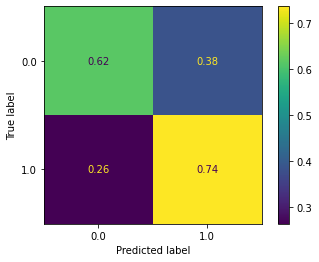

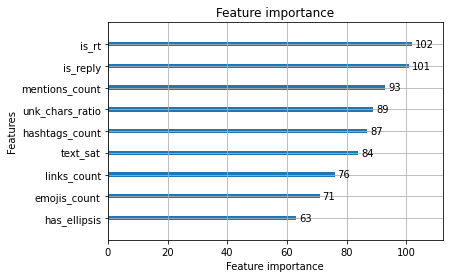

In [44]:
eval_clf(clf_meta_tweet_mean, df_test_meta_tweet_mean)

> Median

In [45]:
df_train_meta_tweet_median = get_median(df_train_meta_tweet, df_train['id'])
df_test_meta_tweet_median = get_median(df_test_meta_tweet, df_test['id'])

clf_meta_tweet_median = get_best_clf(df_train_meta_tweet_median)

[I 2022-03-29 17:09:27,082] A new study created in memory with name: no-name-ae3de883-9101-4d08-aab8-0f07a7241078


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:27,395] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 9.920985685477318, 'lambda_l2': 0.013396402061799415, 'num_leaves': 113, 'feature_fraction': 0.6147945189588396, 'bagging_fraction': 0.4205340913215527, 'bagging_freq': 3, 'learning_rate': 0.0049791094561053035, 'min_child_samples': 55}. Best is trial 7 with value: 0.5.


Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.669593
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:27,725] Trial 6 finished with value: 0.6239211106632205 and parameters: {'lambda_l1': 0.6544281427544787, 'lambda_l2': 0.13907216936932956, 'num_leaves': 73, 'feature_fraction': 0.90894112356727, 'bagging_fraction': 0.6730761878690668, 'bagging_freq': 7, 'learning_rate': 0.051870265874359466, 'min_child_samples': 100}. Best is trial 6 with value: 0.6239211106632205.
[I 2022-03-29 17:09:27,772] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 2.3162614490766967e-06, 'lambda_l2': 1.2540350700069387e-08, 'num_leaves': 173, 'feature_fraction': 0.6378040155592175, 'bagging_fraction': 0.6526265614699132, 'bagging_freq': 6, 'learning_rate': 0.0019056334885901608, 'min_child_samples': 92}. Best is trial 6 with value: 0.6239211106632205.
[I 2022-03-29 17:09:27,788] Trial 0 finished with value: 0.5826061698242951 and parameters: {'lambda_l1': 6.837268236444468e-06, 'lambda_l2': 1.037323826413968e-05, 'num_leaves': 23, 'feature_fraction': 0.4926286124798092, 'bag

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.688072
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.673787
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.6811
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:27,967] Trial 5 finished with value: 0.5006906077348066 and parameters: {'lambda_l1': 0.00039674125142151966, 'lambda_l2': 0.00020648006265469885, 'num_leaves': 49, 'feature_fraction': 0.6813043409305499, 'bagging_fraction': 0.5773831143648961, 'bagging_freq': 5, 'learning_rate': 0.002833411767260606, 'min_child_samples': 63}. Best is trial 6 with value: 0.6239211106632205.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.6763
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:28,167] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 0.00012803911418846525, 'lambda_l2': 3.2798108347794025e-06, 'num_leaves': 85, 'feature_fraction': 0.573803428181124, 'bagging_fraction': 0.619347840712763, 'bagging_freq': 4, 'learning_rate': 0.00012104895602539326, 'min_child_samples': 37}. Best is trial 6 with value: 0.6239211106632205.
[I 2022-03-29 17:09:28,290] Trial 9 finished with value: 0.5671045455623266 and parameters: {'lambda_l1': 4.552794588306381, 'lambda_l2': 1.074150193518671e-05, 'num_leaves': 254, 'feature_fraction': 0.5735910597864318, 'bagging_fraction': 0.8707579929992015, 'bagging_freq': 3, 'learning_rate': 0.010388349954584002, 'min_child_samples': 85}. Best is trial 6 with value: 0.6239211106632205.


Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.675188
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.672722
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:28,524] Trial 8 finished with value: 0.6040861451639675 and parameters: {'lambda_l1': 3.780449625660724e-05, 'lambda_l2': 0.15488170362187292, 'num_leaves': 68, 'feature_fraction': 0.8048810569781164, 'bagging_fraction': 0.9673951615524474, 'bagging_freq': 7, 'learning_rate': 0.01424960726179922, 'min_child_samples': 83}. Best is trial 6 with value: 0.6239211106632205.
[I 2022-03-29 17:09:28,587] Trial 2 finished with value: 0.6229341047589689 and parameters: {'lambda_l1': 2.9591804247508612e-05, 'lambda_l2': 7.05572549885301e-08, 'num_leaves': 65, 'feature_fraction': 0.9012308003350958, 'bagging_fraction': 0.7136997539432044, 'bagging_freq': 3, 'learning_rate': 0.21999803273759497, 'min_child_samples': 26}. Best is trial 6 with value: 0.6239211106632205.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.682053
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.680572
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:28,916] Trial 15 finished with value: 0.6042343442486899 and parameters: {'lambda_l1': 0.00012155381617487265, 'lambda_l2': 2.281914739761819e-05, 'num_leaves': 145, 'feature_fraction': 0.4026298155495676, 'bagging_fraction': 0.5210615085989717, 'bagging_freq': 2, 'learning_rate': 0.03623426510094671, 'min_child_samples': 97}. Best is trial 6 with value: 0.6239211106632205.
[I 2022-03-29 17:09:29,042] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 4.2714136831046085e-07, 'lambda_l2': 4.872826407433678e-07, 'num_leaves': 111, 'feature_fraction': 0.76579454454953, 'bagging_fraction': 0.6713652148090543, 'bagging_freq': 2, 'learning_rate': 0.0024405152624188925, 'min_child_samples': 29}. Best is trial 6 with value: 0.6239211106632205.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.671461
Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.678687
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:29,230] Trial 11 finished with value: 0.5832286059801295 and parameters: {'lambda_l1': 1.9072152629601375e-07, 'lambda_l2': 0.07417841815576799, 'num_leaves': 170, 'feature_fraction': 0.5375078167534554, 'bagging_fraction': 0.4978386552860681, 'bagging_freq': 5, 'learning_rate': 0.011102346328003927, 'min_child_samples': 25}. Best is trial 6 with value: 0.6239211106632205.
[I 2022-03-29 17:09:29,309] Trial 10 finished with value: 0.630907215517037 and parameters: {'lambda_l1': 0.0002878550497536334, 'lambda_l2': 1.231166643249454, 'num_leaves': 62, 'feature_fraction': 0.6506632911357272, 'bagging_fraction': 0.8954073367255702, 'bagging_freq': 1, 'learning_rate': 0.20320655725611728, 'min_child_samples': 54}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.682673
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.689076


[I 2022-03-29 17:09:29,418] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 0.3232707626054132, 'lambda_l2': 3.08900488969574e-05, 'num_leaves': 141, 'feature_fraction': 0.5528538915409477, 'bagging_fraction': 0.9358213783100637, 'bagging_freq': 4, 'learning_rate': 0.0002832082250713243, 'min_child_samples': 53}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.675494
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:29,685] Trial 20 finished with value: 0.6244516633865269 and parameters: {'lambda_l1': 0.021959514230089124, 'lambda_l2': 4.69287819751968, 'num_leaves': 3, 'feature_fraction': 0.9581431509108108, 'bagging_fraction': 0.7792644037409845, 'bagging_freq': 1, 'learning_rate': 0.2741174322978584, 'min_child_samples': 72}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:29,779] Trial 18 finished with value: 0.6307353045787589 and parameters: {'lambda_l1': 0.02567181685566721, 'lambda_l2': 8.318276169763704, 'num_leaves': 10, 'feature_fraction': 0.9670021879727358, 'bagging_fraction': 0.7975166247176987, 'bagging_freq': 7, 'learning_rate': 0.28299717672613184, 'min_child_samples': 8}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.695805
Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.701421
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.696295Training until validation scores don't improve for 100 rounds



[I 2022-03-29 17:09:29,873] Trial 21 finished with value: 0.6296682711687572 and parameters: {'lambda_l1': 0.007983710764089148, 'lambda_l2': 5.178307620628226, 'num_leaves': 4, 'feature_fraction': 0.9985072508072959, 'bagging_fraction': 0.7714175154780731, 'bagging_freq': 1, 'learning_rate': 0.24763256618829413, 'min_child_samples': 73}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:29,983] Trial 14 finished with value: 0.6236988120361368 and parameters: {'lambda_l1': 9.374428917441589e-08, 'lambda_l2': 0.0002704603403969574, 'num_leaves': 93, 'feature_fraction': 0.7418538137559257, 'bagging_fraction': 0.7151518387625588, 'bagging_freq': 2, 'learning_rate': 0.21117409733289988, 'min_child_samples': 46}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 roundsDid not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.686601

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:30,271] Trial 19 finished with value: 0.6282811277357551 and parameters: {'lambda_l1': 0.023913084019612826, 'lambda_l2': 1.1871739708679772, 'num_leaves': 17, 'feature_fraction': 0.9731590830648382, 'bagging_fraction': 0.8013025945349966, 'bagging_freq': 7, 'learning_rate': 0.2606705246695771, 'min_child_samples': 8}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:30,359] Trial 22 finished with value: 0.6308390439380647 and parameters: {'lambda_l1': 0.009024479666353198, 'lambda_l2': 8.359663190674782, 'num_leaves': 6, 'feature_fraction': 0.9813053262680093, 'bagging_fraction': 0.7929565073783806, 'bagging_freq': 1, 'learning_rate': 0.25060201555952655, 'min_child_samples': 70}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.69051
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.698063
Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.672158
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 17:09:30,453] Trial 17 finished with value: 0.5 and parameters: {'lambda_l1': 0.033835229693857764, 'lambda_l2': 5.5262382955755385, 'num_leaves': 197, 'feature_fraction': 0.9792268468751043, 'bagging_fraction': 0.8128761053928915, 'bagging_freq': 7, 'learning_rate': 0.00014307593352582164, 'min_child_samples': 69}. Best is trial 10 with value: 0.630907215517037.



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:30,783] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 0.4166919580591966, 'lambda_l2': 1.016982643129164e-07, 'num_leaves': 245, 'feature_fraction': 0.603665585705086, 'bagging_fraction': 0.577443780077434, 'bagging_freq': 2, 'learning_rate': 0.0023075988434470155, 'min_child_samples': 13}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.680602
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.690631


[I 2022-03-29 17:09:30,973] Trial 23 finished with value: 0.6198574917601309 and parameters: {'lambda_l1': 0.0030188205475970174, 'lambda_l2': 9.783813387985289, 'num_leaves': 29, 'feature_fraction': 0.7746349252898823, 'bagging_fraction': 0.8337697715112516, 'bagging_freq': 1, 'learning_rate': 0.07354559717253285, 'min_child_samples': 44}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:31,237] Trial 24 finished with value: 0.5 and parameters: {'lambda_l1': 0.003322683803071232, 'lambda_l2': 0.00426753576145155, 'num_leaves': 38, 'feature_fraction': 0.79019249618021, 'bagging_fraction': 0.8502556637982793, 'bagging_freq': 6, 'learning_rate': 1.2468586252122512e-05, 'min_child_samples': 45}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.678933


[I 2022-03-29 17:09:31,535] Trial 25 finished with value: 0.5 and parameters: {'lambda_l1': 0.00379406832578672, 'lambda_l2': 0.002641033767478925, 'num_leaves': 41, 'feature_fraction': 0.8539516886171328, 'bagging_fraction': 0.8627393486551825, 'bagging_freq': 6, 'learning_rate': 2.327540540652101e-05, 'min_child_samples': 11}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.683928


[I 2022-03-29 17:09:31,629] Trial 28 finished with value: 0.6218492874588006 and parameters: {'lambda_l1': 0.002048176882432104, 'lambda_l2': 0.004204961861727359, 'num_leaves': 33, 'feature_fraction': 0.8368900575686193, 'bagging_fraction': 0.8868592441263153, 'bagging_freq': 1, 'learning_rate': 0.06365879850386078, 'min_child_samples': 44}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:31,708] Trial 26 finished with value: 0.5 and parameters: {'lambda_l1': 0.0022929669495699123, 'lambda_l2': 0.0021799034586868814, 'num_leaves': 36, 'feature_fraction': 0.8630163587585483, 'bagging_fraction': 0.8731438627869585, 'bagging_freq': 6, 'learning_rate': 1.1254931810131465e-05, 'min_child_samples': 42}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[55]	valid_0's auc: 0.690109
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.677474
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.676252


[I 2022-03-29 17:09:31,802] Trial 27 finished with value: 0.5 and parameters: {'lambda_l1': 0.002369163004172226, 'lambda_l2': 0.004085480002375999, 'num_leaves': 41, 'feature_fraction': 0.817213290174868, 'bagging_fraction': 0.8910922276532683, 'bagging_freq': 1, 'learning_rate': 1.3968083281269182e-05, 'min_child_samples': 65}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.6725


[I 2022-03-29 17:09:31,990] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 2.188576312464378e-05, 'lambda_l2': 0.1151847268920951, 'num_leaves': 192, 'feature_fraction': 0.6903701781269207, 'bagging_fraction': 0.44672050440121247, 'bagging_freq': 1, 'learning_rate': 0.000447745533787487, 'min_child_samples': 5}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:32,194] Trial 29 finished with value: 0.6134137955563987 and parameters: {'lambda_l1': 0.0021195053652076673, 'lambda_l2': 0.003319546095312, 'num_leaves': 40, 'feature_fraction': 0.8492966379187109, 'bagging_fraction': 0.8942042676102324, 'bagging_freq': 1, 'learning_rate': 0.07155335833466298, 'min_child_samples': 42}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.686895
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:32,539] Trial 30 finished with value: 0.6227740497474687 and parameters: {'lambda_l1': 0.00044462260077207986, 'lambda_l2': 0.007592231973177337, 'num_leaves': 47, 'feature_fraction': 0.8574825635500671, 'bagging_fraction': 0.9018713330469809, 'bagging_freq': 5, 'learning_rate': 0.08011245330088639, 'min_child_samples': 60}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:32,617] Trial 36 finished with value: 0.6295082161572569 and parameters: {'lambda_l1': 0.0004879355954362224, 'lambda_l2': 1.0886846831488355, 'num_leaves': 13, 'feature_fraction': 0.927899998704013, 'bagging_fraction': 0.7481821672195174, 'bagging_freq': 5, 'learning_rate': 0.11047797284358844, 'min_child_samples': 61}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.686321
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.695584
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:32,805] Trial 31 finished with value: 0.6151714367012069 and parameters: {'lambda_l1': 0.0007391922199081808, 'lambda_l2': 0.6857138140367133, 'num_leaves': 48, 'feature_fraction': 0.9095190796995809, 'bagging_fraction': 0.9077636161923917, 'bagging_freq': 1, 'learning_rate': 0.09010531830414224, 'min_child_samples': 63}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:32,915] Trial 38 finished with value: 0.597476465985346 and parameters: {'lambda_l1': 0.09932915572628079, 'lambda_l2': 1.8439519364279853, 'num_leaves': 2, 'feature_fraction': 0.9219268878654866, 'bagging_fraction': 0.7435619714666653, 'bagging_freq': 3, 'learning_rate': 0.1262431906765792, 'min_child_samples': 76}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.685796
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.680189


[I 2022-03-29 17:09:32,994] Trial 37 finished with value: 0.6242975363384156 and parameters: {'lambda_l1': 0.10900186366729855, 'lambda_l2': 0.792006018057275, 'num_leaves': 15, 'feature_fraction': 0.9157550461407815, 'bagging_fraction': 0.9969516971670314, 'bagging_freq': 4, 'learning_rate': 0.12677911809427464, 'min_child_samples': 59}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:33,088] Trial 39 finished with value: 0.6255009129063619 and parameters: {'lambda_l1': 0.060605164248570965, 'lambda_l2': 0.9397669032131463, 'num_leaves': 3, 'feature_fraction': 0.9958729264643138, 'bagging_fraction': 0.7678436403928806, 'bagging_freq': 3, 'learning_rate': 0.13794785321895292, 'min_child_samples': 76}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.696771
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.693239Training until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.687701


[I 2022-03-29 17:09:33,104] Trial 33 finished with value: 0.6236928840727479 and parameters: {'lambda_l1': 0.0006022220432721202, 'lambda_l2': 1.28119160916593, 'num_leaves': 53, 'feature_fraction': 0.7025555485192363, 'bagging_fraction': 0.919039492245521, 'bagging_freq': 5, 'learning_rate': 0.10186049511485566, 'min_child_samples': 63}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:33,245] Trial 32 finished with value: 0.6121748512081189 and parameters: {'lambda_l1': 0.000427147001042568, 'lambda_l2': 0.8736807965047223, 'num_leaves': 47, 'feature_fraction': 0.8531008920298946, 'bagging_fraction': 0.9149459026954488, 'bagging_freq': 1, 'learning_rate': 0.09112005739105833, 'min_child_samples': 64}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.683759
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's auc: 0.688278


[I 2022-03-29 17:09:33,307] Trial 34 finished with value: 0.619098712446352 and parameters: {'lambda_l1': 0.07131077082975969, 'lambda_l2': 0.8334567372697139, 'num_leaves': 53, 'feature_fraction': 0.7042092432524008, 'bagging_fraction': 0.9275540209769634, 'bagging_freq': 5, 'learning_rate': 0.10903819078643746, 'min_child_samples': 60}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:33,448] Trial 35 finished with value: 0.6163184976169587 and parameters: {'lambda_l1': 0.13805582191963675, 'lambda_l2': 0.713577217547272, 'num_leaves': 55, 'feature_fraction': 0.9196309462432979, 'bagging_fraction': 0.748151790371949, 'bagging_freq': 4, 'learning_rate': 0.10822717598212439, 'min_child_samples': 58}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.689601
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:33,621] Trial 40 finished with value: 0.618663007137268 and parameters: {'lambda_l1': 0.12870041382180866, 'lambda_l2': 2.5076695789420076, 'num_leaves': 8, 'feature_fraction': 0.9394031623825527, 'bagging_fraction': 0.7589953995913493, 'bagging_freq': 3, 'learning_rate': 0.029311326633164964, 'min_child_samples': 77}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.686011
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:33,887] Trial 41 finished with value: 0.6209245251701325 and parameters: {'lambda_l1': 0.011169957387742, 'lambda_l2': 0.35586027895679956, 'num_leaves': 17, 'feature_fraction': 0.9837244007492735, 'bagging_fraction': 0.9927819966770396, 'bagging_freq': 2, 'learning_rate': 0.023679424253144288, 'min_child_samples': 78}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.686425
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:34,311] Trial 42 finished with value: 0.6133278400872595 and parameters: {'lambda_l1': 1.8440462313238966e-06, 'lambda_l2': 0.323986844999134, 'num_leaves': 59, 'feature_fraction': 0.9574099016159651, 'bagging_fraction': 0.7607451801743759, 'bagging_freq': 2, 'learning_rate': 0.032653040511919064, 'min_child_samples': 76}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:34,389] Trial 48 finished with value: 0.6224598676878571 and parameters: {'lambda_l1': 0.016369307414104993, 'lambda_l2': 0.031024381041712755, 'num_leaves': 22, 'feature_fraction': 0.9935244020253058, 'bagging_fraction': 0.6945605675120181, 'bagging_freq': 2, 'learning_rate': 0.02862240304381653, 'min_child_samples': 31}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.684617
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.691193
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:35,063] Trial 45 finished with value: 0.6282248120835605 and parameters: {'lambda_l1': 1.5979129907048348e-06, 'lambda_l2': 0.2759885231496537, 'num_leaves': 95, 'feature_fraction': 0.6491801527349286, 'bagging_fraction': 0.7106923798500636, 'bagging_freq': 2, 'learning_rate': 0.2842601144284988, 'min_child_samples': 34}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:35,236] Trial 43 finished with value: 0.6121926350982856 and parameters: {'lambda_l1': 0.010644652007209467, 'lambda_l2': 0.04491507913739864, 'num_leaves': 78, 'feature_fraction': 0.9563435930244187, 'bagging_fraction': 0.8231906223971346, 'bagging_freq': 2, 'learning_rate': 0.029284074795333317, 'min_child_samples': 29}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.683124
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.676161


[I 2022-03-29 17:09:35,330] Trial 51 finished with value: 0.6255424086500843 and parameters: {'lambda_l1': 6.154624395682796e-05, 'lambda_l2': 8.543868306205303, 'num_leaves': 78, 'feature_fraction': 0.6496265866782477, 'bagging_fraction': 0.8147654327082217, 'bagging_freq': 2, 'learning_rate': 0.19392469281754865, 'min_child_samples': 83}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:35,377] Trial 47 finished with value: 0.6180079671827947 and parameters: {'lambda_l1': 0.009785546101506013, 'lambda_l2': 0.037577964225564024, 'num_leaves': 76, 'feature_fraction': 0.9459173073416655, 'bagging_fraction': 0.6837886371391032, 'bagging_freq': 2, 'learning_rate': 0.035030627914714216, 'min_child_samples': 33}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:35,456] Trial 46 finished with value: 0.6133337680506484 and parameters: {'lambda_l1': 1.3408932251952299e-08, 'lambda_l2': 0.031028433364263856, 'num_leaves': 83, 'feature_fraction': 0.941520922

Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.690247
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.682895
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.680699
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.674667


[I 2022-03-29 17:09:35,581] Trial 44 finished with value: 0.6089618950513361 and parameters: {'lambda_l1': 1.564046869664926e-08, 'lambda_l2': 0.0375893329776837, 'num_leaves': 84, 'feature_fraction': 0.9484043892635834, 'bagging_fraction': 0.8154033612481949, 'bagging_freq': 2, 'learning_rate': 0.0284576671891689, 'min_child_samples': 20}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:35,816] Trial 49 finished with value: 0.6218670713489673 and parameters: {'lambda_l1': 7.884328808618406e-05, 'lambda_l2': 0.04286011695208064, 'num_leaves': 83, 'feature_fraction': 0.9507134839329787, 'bagging_fraction': 0.6970718228919562, 'bagging_freq': 2, 'learning_rate': 0.1889117459838383, 'min_child_samples': 31}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.679019
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:36,193] Trial 53 finished with value: 0.6299083536860076 and parameters: {'lambda_l1': 0.00011567994219130681, 'lambda_l2': 9.005039065551028, 'num_leaves': 24, 'feature_fraction': 0.7319084989291068, 'bagging_fraction': 0.6481472603151889, 'bagging_freq': 6, 'learning_rate': 0.17014996350356695, 'min_child_samples': 20}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:36,287] Trial 50 finished with value: 0.6258625186730847 and parameters: {'lambda_l1': 0.008457286962012086, 'lambda_l2': 0.039366938088565555, 'num_leaves': 86, 'feature_fraction': 0.8934686958185706, 'bagging_fraction': 0.6855944333787102, 'bagging_freq': 2, 'learning_rate': 0.2135480208580926, 'min_child_samples': 35}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.693826
Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.683668
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.690335
Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.676401


[I 2022-03-29 17:09:36,383] Trial 54 finished with value: 0.6290695468664786 and parameters: {'lambda_l1': 1.511244070589339, 'lambda_l2': 3.3124747224815287, 'num_leaves': 27, 'feature_fraction': 0.8938189121804515, 'bagging_fraction': 0.6477032397490188, 'bagging_freq': 6, 'learning_rate': 0.18241447697492377, 'min_child_samples': 50}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:36,459] Trial 56 finished with value: 0.5 and parameters: {'lambda_l1': 1.3691180460012498, 'lambda_l2': 2.522205789316479, 'num_leaves': 25, 'feature_fraction': 0.8928370411674132, 'bagging_fraction': 0.6373359630760467, 'bagging_freq': 6, 'learning_rate': 0.0011108539466869738, 'min_child_samples': 51}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:36,522] Trial 55 finished with value: 0.6251363431579446 and parameters: {'lambda_l1': 1.5696970930331194e-05, 'lambda_l2': 2.9789387897862842, 'num_leaves': 27, 'feature_fraction': 0.8828196092298164, 'bagging_fracti

Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.687442Training until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.692194
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:36,632] Trial 57 finished with value: 0.6206962985796599 and parameters: {'lambda_l1': 1.1436430383322348e-05, 'lambda_l2': 2.8312418148446423, 'num_leaves': 26, 'feature_fraction': 0.88827893615299, 'bagging_fraction': 0.7911766456798017, 'bagging_freq': 6, 'learning_rate': 0.1749436753638838, 'min_child_samples': 52}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:36,757] Trial 58 finished with value: 0.5 and parameters: {'lambda_l1': 1.4560824132053736, 'lambda_l2': 2.66267797718171, 'num_leaves': 22, 'feature_fraction': 0.8781239914185494, 'bagging_fraction': 0.6420739939374924, 'bagging_freq': 7, 'learning_rate': 0.001155240422249593, 'min_child_samples': 50}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.676398
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.676278


[I 2022-03-29 17:09:37,071] Trial 52 finished with value: 0.6307708723590922 and parameters: {'lambda_l1': 6.513182787338513e-05, 'lambda_l2': 3.126811905088961, 'num_leaves': 76, 'feature_fraction': 0.8832546906888652, 'bagging_fraction': 0.6456586705548539, 'bagging_freq': 6, 'learning_rate': 0.1807724749487275, 'min_child_samples': 20}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:37,149] Trial 60 finished with value: 0.6291377184454509 and parameters: {'lambda_l1': 9.340011753990046e-06, 'lambda_l2': 3.3259210992388626, 'num_leaves': 26, 'feature_fraction': 0.48402544120399255, 'bagging_fraction': 0.6438135683178584, 'bagging_freq': 7, 'learning_rate': 0.15432562332255204, 'min_child_samples': 49}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.695457
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.686017
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.692999
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.67817


[I 2022-03-29 17:09:37,243] Trial 61 finished with value: 0.5863111469423564 and parameters: {'lambda_l1': 1.3837790699520949e-05, 'lambda_l2': 3.5200833559129663, 'num_leaves': 12, 'feature_fraction': 0.6033993905352585, 'bagging_fraction': 0.6180283194963448, 'bagging_freq': 7, 'learning_rate': 0.014261856707192285, 'min_child_samples': 18}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:37,322] Trial 59 finished with value: 0.5852204016787992 and parameters: {'lambda_l1': 1.3743973587562272e-05, 'lambda_l2': 6.581733364740306, 'num_leaves': 27, 'feature_fraction': 0.8858712011191041, 'bagging_fraction': 0.6326022980046343, 'bagging_freq': 7, 'learning_rate': 0.006309436643253049, 'min_child_samples': 69}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:37,322] Trial 62 finished with value: 0.6195077419201859 and parameters: {'lambda_l1': 8.998184553037075e-06, 'lambda_l2': 8.761037177495192, 'num_leaves': 9, 'feature_fraction': 0.496674483794

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.691544
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.69459


[I 2022-03-29 17:09:37,541] Trial 64 finished with value: 0.6155122945960686 and parameters: {'lambda_l1': 0.0002816550632174507, 'lambda_l2': 0.0006972178420295964, 'num_leaves': 11, 'feature_fraction': 0.4187150601692703, 'bagging_fraction': 0.6014297743725177, 'bagging_freq': 7, 'learning_rate': 0.050646905756468207, 'min_child_samples': 17}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:37,557] Trial 63 finished with value: 0.6210608683280773 and parameters: {'lambda_l1': 1.1831296824856897e-05, 'lambda_l2': 7.198990788648953, 'num_leaves': 14, 'feature_fraction': 0.7455310352373389, 'bagging_fraction': 0.6085675402348488, 'bagging_freq': 7, 'learning_rate': 0.05236983072418428, 'min_child_samples': 18}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:37,604] Trial 65 finished with value: 0.5721670262964456 and parameters: {'lambda_l1': 0.00017701314993447836, 'lambda_l2': 1.8070381989445295e-06, 'num_leaves': 11, 'feature_fraction': 0.7394

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.680146
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:38,419] Trial 73 finished with value: 0.6212387072297442 and parameters: {'lambda_l1': 0.0010924829922722785, 'lambda_l2': 0.13629339124840326, 'num_leaves': 63, 'feature_fraction': 0.9738982227488728, 'bagging_fraction': 0.5465612896809662, 'bagging_freq': 5, 'learning_rate': 0.28373956833835545, 'min_child_samples': 89}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.678806
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:38,733] Trial 67 finished with value: 0.6228362933630522 and parameters: {'lambda_l1': 0.0001735597966513729, 'lambda_l2': 7.641096072587821, 'num_leaves': 112, 'feature_fraction': 0.7351181879541457, 'bagging_fraction': 0.5901879024061883, 'bagging_freq': 7, 'learning_rate': 0.052422828325598365, 'min_child_samples': 19}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:38,843] Trial 68 finished with value: 0.6147149835202618 and parameters: {'lambda_l1': 0.0001463282318757034, 'lambda_l2': 9.296016046506418, 'num_leaves': 67, 'feature_fraction': 0.7463519712614468, 'bagging_fraction': 0.7285102588587073, 'bagging_freq': 5, 'learning_rate': 0.2934638013506018, 'min_child_samples': 15}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.688185
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.682317
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:39,250] Trial 66 finished with value: 0.6195492376639082 and parameters: {'lambda_l1': 0.00019343187272669117, 'lambda_l2': 1.616081232810483e-06, 'num_leaves': 110, 'feature_fraction': 0.7521847084962361, 'bagging_fraction': 0.5883335005673799, 'bagging_freq': 1, 'learning_rate': 0.04802619578747268, 'min_child_samples': 17}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:39,344] Trial 72 finished with value: 0.6154115192184573 and parameters: {'lambda_l1': 3.5184961386976546e-05, 'lambda_l2': 0.1622961783875883, 'num_leaves': 68, 'feature_fraction': 0.9811791601968748, 'bagging_fraction': 0.7305156740992454, 'bagging_freq': 5, 'learning_rate': 0.2971117033281346, 'min_child_samples': 5}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.674482
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.680538
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:39,768] Trial 70 finished with value: 0.6236306404571645 and parameters: {'lambda_l1': 0.00019470208627502488, 'lambda_l2': 2.429527825932057e-06, 'num_leaves': 110, 'feature_fraction': 0.9752622112296709, 'bagging_fraction': 0.7340512968986881, 'bagging_freq': 5, 'learning_rate': 0.2709812904197612, 'min_child_samples': 15}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.668653
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:39,989] Trial 69 finished with value: 0.5906267042894744 and parameters: {'lambda_l1': 0.00017050735965756932, 'lambda_l2': 0.0008941034152178923, 'num_leaves': 113, 'feature_fraction': 0.7388943831464636, 'bagging_fraction': 0.7299282780092485, 'bagging_freq': 5, 'learning_rate': 0.05075384784018887, 'min_child_samples': 5}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.679211
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.689924


[I 2022-03-29 17:09:40,160] Trial 78 finished with value: 0.6179516515306002 and parameters: {'lambda_l1': 0.00625362905015918, 'lambda_l2': 0.39068338432751587, 'num_leaves': 35, 'feature_fraction': 0.5058572351781014, 'bagging_fraction': 0.8428310372557164, 'bagging_freq': 6, 'learning_rate': 0.14507863559232628, 'min_child_samples': 24}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:40,427] Trial 71 finished with value: 0.6213987622412445 and parameters: {'lambda_l1': 0.0002115405638764993, 'lambda_l2': 6.825985608546524e-07, 'num_leaves': 111, 'feature_fraction': 0.9735085991692473, 'bagging_fraction': 0.7374344128680157, 'bagging_freq': 5, 'learning_rate': 0.24160260708689818, 'min_child_samples': 6}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.670942


[I 2022-03-29 17:09:40,583] Trial 77 finished with value: 0.620313944941076 and parameters: {'lambda_l1': 4.2790460598467375e-05, 'lambda_l2': 0.5022549833202458, 'num_leaves': 38, 'feature_fraction': 0.8043557383643061, 'bagging_fraction': 0.8413167006734712, 'bagging_freq': 1, 'learning_rate': 0.07820943996467265, 'min_child_samples': 10}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:40,677] Trial 79 finished with value: 0.6195551656272971 and parameters: {'lambda_l1': 4.4056511868133504e-06, 'lambda_l2': 0.48063655663608423, 'num_leaves': 41, 'feature_fraction': 0.5198811102138239, 'bagging_fraction': 0.8384650048155659, 'bagging_freq': 6, 'learning_rate': 0.14527219856555476, 'min_child_samples': 56}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[47]	valid_0's auc: 0.685668
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.687701
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.676306


[I 2022-03-29 17:09:40,772] Trial 74 finished with value: 0.6188764138192683 and parameters: {'lambda_l1': 4.957905150775466e-05, 'lambda_l2': 0.47184554696495445, 'num_leaves': 115, 'feature_fraction': 0.6780551802491065, 'bagging_fraction': 0.7245730025211099, 'bagging_freq': 1, 'learning_rate': 0.29835627331008524, 'min_child_samples': 6}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:40,898] Trial 75 finished with value: 0.6195551656272971 and parameters: {'lambda_l1': 3.675172948146553e-06, 'lambda_l2': 0.40539929229231647, 'num_leaves': 100, 'feature_fraction': 0.6704314693361484, 'bagging_fraction': 0.7288834962146921, 'bagging_freq': 1, 'learning_rate': 0.29829360657130477, 'min_child_samples': 7}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.675534
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.696568Training until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.688841
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.696199


[I 2022-03-29 17:09:41,039] Trial 81 finished with value: 0.6417968842624429 and parameters: {'lambda_l1': 0.0012375803146439815, 'lambda_l2': 1.6038929428596325, 'num_leaves': 132, 'feature_fraction': 0.45853761485698796, 'bagging_fraction': 0.788002962631392, 'bagging_freq': 1, 'learning_rate': 0.15115376637554648, 'min_child_samples': 72}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:41,054] Trial 80 finished with value: 0.6186363313020179 and parameters: {'lambda_l1': 4.213490113041786e-06, 'lambda_l2': 1.388474650279501, 'num_leaves': 35, 'feature_fraction': 0.5236600482432959, 'bagging_fraction': 0.8456410255158501, 'bagging_freq': 6, 'learning_rate': 0.1591455819380883, 'min_child_samples': 56}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:41,054] Trial 82 finished with value: 0.6261915206411686 and parameters: {'lambda_l1': 4.060056286948945e-06, 'lambda_l2': 1.5211303528847187, 'num_leaves': 3, 'feature_fraction': 0.4372808934181

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.680941


[I 2022-03-29 17:09:41,368] Trial 83 finished with value: 0.5970822564199844 and parameters: {'lambda_l1': 4.131594455364004e-06, 'lambda_l2': 1.500887968847406, 'num_leaves': 2, 'feature_fraction': 0.43249032433187207, 'bagging_fraction': 0.7814135813655221, 'bagging_freq': 6, 'learning_rate': 0.13740410582852053, 'min_child_samples': 72}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:41,494] Trial 76 finished with value: 0.6080608446162237 and parameters: {'lambda_l1': 0.001131945471777821, 'lambda_l2': 1.4452981142775772, 'num_leaves': 129, 'feature_fraction': 0.6736750007150756, 'bagging_fraction': 0.8430330574779592, 'bagging_freq': 1, 'learning_rate': 0.1384891321913676, 'min_child_samples': 5}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:41,509] Trial 84 finished with value: 0.5984634718895976 and parameters: {'lambda_l1': 0.0009288462701507842, 'lambda_l2': 1.8258062577987464, 'num_leaves': 2, 'feature_fraction': 0.427743825995416

Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.675067
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.670782
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:41,698] Trial 86 finished with value: 0.598235245299125 and parameters: {'lambda_l1': 0.0010602054726382136, 'lambda_l2': 1.1940479695484316, 'num_leaves': 2, 'feature_fraction': 0.9327551225129579, 'bagging_fraction': 0.9467006791017721, 'bagging_freq': 4, 'learning_rate': 0.10897014070294446, 'min_child_samples': 67}. Best is trial 81 with value: 0.6417968842624429.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.675728
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:41,870] Trial 85 finished with value: 0.6216892324473005 and parameters: {'lambda_l1': 0.001185582234967725, 'lambda_l2': 1.3185207998103963, 'num_leaves': 159, 'feature_fraction': 0.44918164699665913, 'bagging_fraction': 0.785167061370661, 'bagging_freq': 4, 'learning_rate': 0.11108394390503622, 'min_child_samples': 67}. Best is trial 81 with value: 0.6417968842624429.


Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.693524
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:42,152] Trial 88 finished with value: 0.6276824034334765 and parameters: {'lambda_l1': 0.0011924256776151795, 'lambda_l2': 4.747648067629157, 'num_leaves': 153, 'feature_fraction': 0.47295621640045993, 'bagging_fraction': 0.6671315023608344, 'bagging_freq': 4, 'learning_rate': 0.11442349176212264, 'min_child_samples': 67}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:42,231] Trial 87 finished with value: 0.6294400445782846 and parameters: {'lambda_l1': 0.0010877818615609323, 'lambda_l2': 4.827236047988414, 'num_leaves': 121, 'feature_fraction': 0.46991501492145066, 'bagging_fraction': 0.6634238282289961, 'bagging_freq': 1, 'learning_rate': 0.1055931529313068, 'min_child_samples': 72}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:42,262] Trial 89 finished with value: 0.6322084034809 and parameters: {'lambda_l1': 0.04221409784326216, 'lambda_l2': 8.98227200305141e-05, 'num_leaves': 143, 'feature_fraction': 0.477317917387

Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.693191
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.691618
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.691269


[I 2022-03-29 17:09:42,638] Trial 93 finished with value: 0.6189327294714627 and parameters: {'lambda_l1': 0.037059282615987114, 'lambda_l2': 4.457094358953328, 'num_leaves': 153, 'feature_fraction': 0.47866101562981783, 'bagging_fraction': 0.7661184836128992, 'bagging_freq': 1, 'learning_rate': 0.06849607872735508, 'min_child_samples': 74}. Best is trial 81 with value: 0.6417968842624429.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.689719
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.689902


[I 2022-03-29 17:09:42,654] Trial 91 finished with value: 0.6249881440732222 and parameters: {'lambda_l1': 0.042016430418737254, 'lambda_l2': 9.408462308180616e-05, 'num_leaves': 159, 'feature_fraction': 0.4515205186765447, 'bagging_fraction': 0.665497818366322, 'bagging_freq': 4, 'learning_rate': 0.07109018051356929, 'min_child_samples': 72}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:42,873] Trial 94 finished with value: 0.5 and parameters: {'lambda_l1': 8.100909623382628e-07, 'lambda_l2': 5.441385142534542, 'num_leaves': 126, 'feature_fraction': 0.4700950326561728, 'bagging_fraction': 0.6651532252066157, 'bagging_freq': 1, 'learning_rate': 8.526157092685725e-05, 'min_child_samples': 74}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:42,952] Trial 90 finished with value: 0.618630403338629 and parameters: {'lambda_l1': 0.0011194091867047892, 'lambda_l2': 5.37989736543405, 'num_leaves': 130, 'feature_fraction': 0.5765804963696255, 'baggi

Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.668403
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.687829


[I 2022-03-29 17:09:43,062] Trial 92 finished with value: 0.6207881820121879 and parameters: {'lambda_l1': 0.04896307050476107, 'lambda_l2': 4.73385317834205, 'num_leaves': 155, 'feature_fraction': 0.5653982887071833, 'bagging_fraction': 0.66686883412081, 'bagging_freq': 4, 'learning_rate': 0.09753906801056764, 'min_child_samples': 40}. Best is trial 81 with value: 0.6417968842624429.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.692186


[I 2022-03-29 17:09:43,360] Trial 97 finished with value: 0.6186363313020179 and parameters: {'lambda_l1': 0.026484505399781966, 'lambda_l2': 6.766225125013232e-05, 'num_leaves': 140, 'feature_fraction': 0.5590613272054273, 'bagging_fraction': 0.8011288272752385, 'bagging_freq': 1, 'learning_rate': 0.07474590364984134, 'min_child_samples': 83}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:43,391] Trial 96 finished with value: 0.6244694472766936 and parameters: {'lambda_l1': 0.005082239464550089, 'lambda_l2': 4.159451461295979e-05, 'num_leaves': 149, 'feature_fraction': 0.5597829906112037, 'bagging_fraction': 0.8017520572625378, 'bagging_freq': 1, 'learning_rate': 0.07098519207082386, 'min_child_samples': 79}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:43,469] Trial 99 finished with value: 0.5 and parameters: {'lambda_l1': 0.21388332690369793, 'lambda_l2': 0.00019384609621529277, 'num_leaves': 136, 'feature_fraction': 0.5628099902585768,

Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.686537
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.685395
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.669436


[I 2022-03-29 17:09:43,579] Trial 95 finished with value: 0.6112619448462286 and parameters: {'lambda_l1': 9.418698403638997e-05, 'lambda_l2': 5.120548356485422e-05, 'num_leaves': 132, 'feature_fraction': 0.9977230319883477, 'bagging_fraction': 0.8038253372459077, 'bagging_freq': 1, 'learning_rate': 0.06897872875667158, 'min_child_samples': 83}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:43,627] Trial 98 finished with value: 0.6074324804970005 and parameters: {'lambda_l1': 0.004943088632290733, 'lambda_l2': 8.289266255160714e-06, 'num_leaves': 135, 'feature_fraction': 0.998603349114826, 'bagging_fraction': 0.8028028492130587, 'bagging_freq': 1, 'learning_rate': 0.22628285648909943, 'min_child_samples': 79}. Best is trial 81 with value: 0.6417968842624429.


Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.684708
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.685584
{'lambda_l1': 0.0012375803146439815, 'lambda_l2': 1.6038929428596325, 'num_leaves': 132, 'feature_fraction': 0.45853761485698796, 'bagging_fraction': 0.788002962631392, 'bagging_freq': 1, 'learning_rate': 0.15115376637554648, 'min_child_samples': 72} -> 0.6417968842624429
[LightGBM] [Warning] feature_fraction is set=0.45853761485698796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45853761485698796
[LightGBM] [Warning] lambda_l1 is set=0.0012375803146439815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012375803146439815
[LightGBM] [Warning] bagging_fraction is set=0.788002962631392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.788002962631392
[LightGBM] [Warning] lambda_l2 is set=1.6038929428596325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6038929428596325

AUROC: 0.6386869820441988
Accuracy: 0.6466610312764159


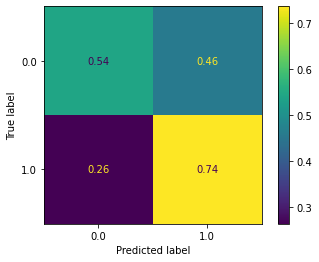

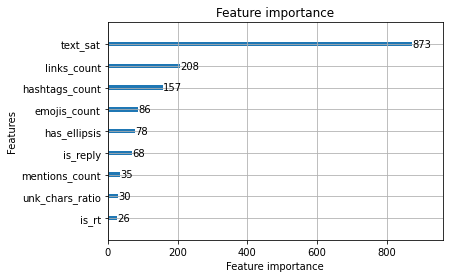

In [46]:
eval_clf(clf_meta_tweet_median, df_test_meta_tweet_median)

## Feature engineering

In [47]:
df_train_meta_tweet_fe = filter_tweet_metadata(df_train_meta_fe)
df_test_meta_tweet_fe = filter_tweet_metadata(df_test_meta_fe)

In [48]:
clf_meta_tweet_fe = get_best_clf(df_train_meta_tweet_fe)

[I 2022-03-29 17:09:45,665] A new study created in memory with name: no-name-5a97a9d2-f555-4323-b35c-7e18f6bcdde9


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.695877


[I 2022-03-29 17:11:35,246] Trial 3 finished with value: 0.6375293891119125 and parameters: {'lambda_l1': 0.15213649027024964, 'lambda_l2': 0.004983516064108256, 'num_leaves': 82, 'feature_fraction': 0.8340768096519311, 'bagging_fraction': 0.4923276792311296, 'bagging_freq': 2, 'learning_rate': 0.2166057761540733, 'min_child_samples': 80}. Best is trial 3 with value: 0.6375293891119125.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697486


[I 2022-03-29 17:12:11,757] Trial 0 finished with value: 0.637998859647387 and parameters: {'lambda_l1': 4.916020823434503e-07, 'lambda_l2': 2.355558495440069e-06, 'num_leaves': 134, 'feature_fraction': 0.9076506339612228, 'bagging_fraction': 0.5474652487800276, 'bagging_freq': 4, 'learning_rate': 0.12388124474515569, 'min_child_samples': 25}. Best is trial 0 with value: 0.637998859647387.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.692452


[I 2022-03-29 17:12:24,836] Trial 5 finished with value: 0.6334653411417023 and parameters: {'lambda_l1': 1.008936529863123e-08, 'lambda_l2': 7.671903425303342e-06, 'num_leaves': 120, 'feature_fraction': 0.5242487751722904, 'bagging_fraction': 0.859134723010992, 'bagging_freq': 5, 'learning_rate': 0.05408093113683338, 'min_child_samples': 99}. Best is trial 0 with value: 0.637998859647387.


Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.674526
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.677073


[I 2022-03-29 17:12:33,650] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 3.016522587295169e-06, 'lambda_l2': 0.2821076228062512, 'num_leaves': 133, 'feature_fraction': 0.5667189967748097, 'bagging_fraction': 0.5968751648935542, 'bagging_freq': 7, 'learning_rate': 3.932677542801965e-05, 'min_child_samples': 58}. Best is trial 0 with value: 0.637998859647387.
[I 2022-03-29 17:12:33,741] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 1.8821640395883674e-08, 'lambda_l2': 0.00022431007747196236, 'num_leaves': 147, 'feature_fraction': 0.624320363150503, 'bagging_fraction': 0.6231602421699667, 'bagging_freq': 3, 'learning_rate': 9.262621990242668e-05, 'min_child_samples': 20}. Best is trial 0 with value: 0.637998859647387.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.657064


[I 2022-03-29 17:13:03,482] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 4.405168321548166e-07, 'lambda_l2': 0.0009013499622286957, 'num_leaves': 21, 'feature_fraction': 0.5651858800192144, 'bagging_fraction': 0.7953939575269757, 'bagging_freq': 4, 'learning_rate': 1.1967768142559851e-05, 'min_child_samples': 90}. Best is trial 0 with value: 0.637998859647387.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.698951
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.675994


[I 2022-03-29 17:13:11,011] Trial 8 finished with value: 0.6401432291255732 and parameters: {'lambda_l1': 0.0035415807142192388, 'lambda_l2': 0.0003067182745383352, 'num_leaves': 104, 'feature_fraction': 0.8874446978259605, 'bagging_fraction': 0.9952541855178221, 'bagging_freq': 2, 'learning_rate': 0.2732651729111623, 'min_child_samples': 97}. Best is trial 8 with value: 0.6401432291255732.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.683653


[I 2022-03-29 17:13:11,873] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 2.610346250471408e-07, 'lambda_l2': 0.30597809230730777, 'num_leaves': 185, 'feature_fraction': 0.5297303304161033, 'bagging_fraction': 0.6920979767844935, 'bagging_freq': 7, 'learning_rate': 4.6424530373542646e-05, 'min_child_samples': 77}. Best is trial 8 with value: 0.6401432291255732.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:13:18,774] Trial 7 finished with value: 0.595993911702355 and parameters: {'lambda_l1': 0.0028888375331111308, 'lambda_l2': 0.010052252779693573, 'num_leaves': 208, 'feature_fraction': 0.6989542725703157, 'bagging_fraction': 0.7633826652287612, 'bagging_freq': 2, 'learning_rate': 0.004575514407264721, 'min_child_samples': 48}. Best is trial 8 with value: 0.6401432291255732.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.700147


[I 2022-03-29 17:13:31,712] Trial 2 finished with value: 0.6406157988319752 and parameters: {'lambda_l1': 5.140735857955098, 'lambda_l2': 1.6894073498271764e-05, 'num_leaves': 251, 'feature_fraction': 0.6212121851363441, 'bagging_fraction': 0.5206903423802816, 'bagging_freq': 2, 'learning_rate': 0.21952484014257692, 'min_child_samples': 22}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.674844


[I 2022-03-29 17:14:12,188] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 0.7525635202735317, 'lambda_l2': 1.1298397805630574e-06, 'num_leaves': 127, 'feature_fraction': 0.945903943484233, 'bagging_fraction': 0.7022030542442304, 'bagging_freq': 4, 'learning_rate': 1.2375136448852874e-05, 'min_child_samples': 96}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.685262


[I 2022-03-29 17:14:31,509] Trial 10 finished with value: 0.6192744472170912 and parameters: {'lambda_l1': 0.0003917716711589627, 'lambda_l2': 1.8096744374547505e-08, 'num_leaves': 200, 'feature_fraction': 0.8680151613367382, 'bagging_fraction': 0.46718448063762164, 'bagging_freq': 5, 'learning_rate': 0.008792351537295434, 'min_child_samples': 28}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.676076
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.677785


[I 2022-03-29 17:14:47,527] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 5.370917966806653e-08, 'lambda_l2': 0.00023355051670653532, 'num_leaves': 131, 'feature_fraction': 0.9096369124201525, 'bagging_fraction': 0.8945159567789225, 'bagging_freq': 6, 'learning_rate': 0.00040066256539257, 'min_child_samples': 34}. Best is trial 2 with value: 0.6406157988319752.
[I 2022-03-29 17:14:50,908] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 4.394810097324145, 'lambda_l2': 0.0001706049618004452, 'num_leaves': 146, 'feature_fraction': 0.8345443203059708, 'bagging_fraction': 0.9380475093164709, 'bagging_freq': 3, 'learning_rate': 0.00013471073918033344, 'min_child_samples': 11}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.699546


[I 2022-03-29 17:15:00,977] Trial 12 finished with value: 0.6393554859492802 and parameters: {'lambda_l1': 0.000411014955619152, 'lambda_l2': 1.4238693052334003e-08, 'num_leaves': 210, 'feature_fraction': 0.5560905632236769, 'bagging_fraction': 0.7648190065678224, 'bagging_freq': 6, 'learning_rate': 0.24839564721081633, 'min_child_samples': 12}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.696756


[I 2022-03-29 17:15:12,505] Trial 14 finished with value: 0.6371963308994335 and parameters: {'lambda_l1': 0.9470501812514159, 'lambda_l2': 0.44555055684416967, 'num_leaves': 186, 'feature_fraction': 0.528007916936478, 'bagging_fraction': 0.6627377573307971, 'bagging_freq': 7, 'learning_rate': 0.06114507571386415, 'min_child_samples': 13}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.678806


[I 2022-03-29 17:15:31,623] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 3.53687069787588e-05, 'lambda_l2': 5.620708964041784e-07, 'num_leaves': 221, 'feature_fraction': 0.5588561222768782, 'bagging_fraction': 0.40993367017644344, 'bagging_freq': 7, 'learning_rate': 0.00017057609475011056, 'min_child_samples': 13}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.677678


[I 2022-03-29 17:15:50,897] Trial 17 finished with value: 0.594053078051567 and parameters: {'lambda_l1': 6.968741837347898, 'lambda_l2': 1.3688064777411278e-08, 'num_leaves': 256, 'feature_fraction': 0.443843570813393, 'bagging_fraction': 0.45478765515369435, 'bagging_freq': 1, 'learning_rate': 0.006973571270423661, 'min_child_samples': 6}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.679132


[I 2022-03-29 17:16:19,455] Trial 24 finished with value: 0.6202710124300832 and parameters: {'lambda_l1': 0.01675280179958108, 'lambda_l2': 1.2062866083180146e-05, 'num_leaves': 68, 'feature_fraction': 0.752412537260538, 'bagging_fraction': 0.9828340599698702, 'bagging_freq': 1, 'learning_rate': 0.016958270113856876, 'min_child_samples': 60}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.692106


[I 2022-03-29 17:16:32,314] Trial 19 finished with value: 0.6320389697618924 and parameters: {'lambda_l1': 6.223622866222712, 'lambda_l2': 5.275958836575751e-05, 'num_leaves': 239, 'feature_fraction': 0.7546054943141001, 'bagging_fraction': 0.9618701444063356, 'bagging_freq': 1, 'learning_rate': 0.02318175524307122, 'min_child_samples': 48}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.684701


[I 2022-03-29 17:16:42,649] Trial 25 finished with value: 0.6271518011436119 and parameters: {'lambda_l1': 0.011011650474746821, 'lambda_l2': 1.4761417079708769e-05, 'num_leaves': 69, 'feature_fraction': 0.7575997748196877, 'bagging_fraction': 0.9891219277548668, 'bagging_freq': 1, 'learning_rate': 0.03352203172015761, 'min_child_samples': 58}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.695311


[I 2022-03-29 17:16:53,438] Trial 20 finished with value: 0.6360803917380387 and parameters: {'lambda_l1': 5.5556161916318505, 'lambda_l2': 2.6067204359001112e-05, 'num_leaves': 250, 'feature_fraction': 0.747775523860529, 'bagging_fraction': 0.9989926276871774, 'bagging_freq': 1, 'learning_rate': 0.03277026808520932, 'min_child_samples': 5}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.689475


[I 2022-03-29 17:17:06,016] Trial 21 finished with value: 0.6281623818780453 and parameters: {'lambda_l1': 0.024302181044417188, 'lambda_l2': 3.271105133885767e-08, 'num_leaves': 243, 'feature_fraction': 0.4216688440184187, 'bagging_fraction': 0.4051299932964729, 'bagging_freq': 1, 'learning_rate': 0.029149655195988392, 'min_child_samples': 59}. Best is trial 2 with value: 0.6406157988319752.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.681302


[I 2022-03-29 17:17:13,872] Trial 18 finished with value: 0.6116702395522815 and parameters: {'lambda_l1': 6.02111036763219, 'lambda_l2': 1.4213076420258193e-08, 'num_leaves': 255, 'feature_fraction': 0.41682038086005163, 'bagging_fraction': 0.9987361013488716, 'bagging_freq': 1, 'learning_rate': 0.010730842162711446, 'min_child_samples': 5}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.689511


[I 2022-03-29 17:17:35,170] Trial 22 finished with value: 0.6273053221616604 and parameters: {'lambda_l1': 0.021848066673715336, 'lambda_l2': 2.6326532757689057e-05, 'num_leaves': 242, 'feature_fraction': 0.4441782908808547, 'bagging_fraction': 0.9948721755473449, 'bagging_freq': 1, 'learning_rate': 0.026842562812090714, 'min_child_samples': 51}. Best is trial 2 with value: 0.6406157988319752.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.668979


[I 2022-03-29 17:17:41,396] Trial 26 finished with value: 0.5258875739801083 and parameters: {'lambda_l1': 0.06142185574734115, 'lambda_l2': 8.771855836468362, 'num_leaves': 80, 'feature_fraction': 0.9988591894725141, 'bagging_fraction': 0.5531147512313059, 'bagging_freq': 2, 'learning_rate': 0.0016708836094373142, 'min_child_samples': 41}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.684112


[I 2022-03-29 17:17:55,950] Trial 23 finished with value: 0.6199044299421927 and parameters: {'lambda_l1': 0.013804318838325027, 'lambda_l2': 1.3153530987927314e-05, 'num_leaves': 256, 'feature_fraction': 0.40042152189350083, 'bagging_fraction': 0.5321593064034921, 'bagging_freq': 1, 'learning_rate': 0.01823718160212387, 'min_child_samples': 59}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.668235


[I 2022-03-29 17:18:04,466] Trial 27 finished with value: 0.5122751316541581 and parameters: {'lambda_l1': 0.01846295288048741, 'lambda_l2': 5.823272255355102, 'num_leaves': 81, 'feature_fraction': 0.9981337538603607, 'bagging_fraction': 0.5452707052642495, 'bagging_freq': 2, 'learning_rate': 0.0013092098965311282, 'min_child_samples': 37}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697932


[I 2022-03-29 17:18:18,282] Trial 28 finished with value: 0.6386545644229938 and parameters: {'lambda_l1': 7.815135181614275e-05, 'lambda_l2': 1.5578818836179187e-07, 'num_leaves': 98, 'feature_fraction': 0.6411748396924379, 'bagging_fraction': 0.7872516209118218, 'bagging_freq': 2, 'learning_rate': 0.23216315011324323, 'min_child_samples': 38}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.691274


[I 2022-03-29 17:18:39,783] Trial 34 finished with value: 0.6335795301144678 and parameters: {'lambda_l1': 0.00020270102127169115, 'lambda_l2': 1.9127368741235753e-07, 'num_leaves': 36, 'feature_fraction': 0.6444067212345448, 'bagging_fraction': 0.8083675207598355, 'bagging_freq': 3, 'learning_rate': 0.27978268893168307, 'min_child_samples': 73}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700055


[I 2022-03-29 17:18:54,823] Trial 30 finished with value: 0.6409376190010015 and parameters: {'lambda_l1': 0.0001364252591804887, 'lambda_l2': 1.6815365486914633e-07, 'num_leaves': 163, 'feature_fraction': 0.9983904951098924, 'bagging_fraction': 0.8149543434714235, 'bagging_freq': 2, 'learning_rate': 0.28861835929559065, 'min_child_samples': 36}. Best is trial 30 with value: 0.6409376190010015.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699158


[I 2022-03-29 17:19:04,233] Trial 31 finished with value: 0.63987596749204 and parameters: {'lambda_l1': 8.14155425925713e-05, 'lambda_l2': 3.224334164798793e-07, 'num_leaves': 168, 'feature_fraction': 0.6505948754057012, 'bagging_fraction': 0.7836417605590852, 'bagging_freq': 2, 'learning_rate': 0.2884243380271725, 'min_child_samples': 38}. Best is trial 30 with value: 0.6409376190010015.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.700686


[I 2022-03-29 17:19:19,984] Trial 29 finished with value: 0.640678479380586 and parameters: {'lambda_l1': 8.542241412383754e-05, 'lambda_l2': 8.848266541670125e-08, 'num_leaves': 228, 'feature_fraction': 0.6436043157754683, 'bagging_fraction': 0.8065409188847895, 'bagging_freq': 2, 'learning_rate': 0.2372686762338327, 'min_child_samples': 37}. Best is trial 30 with value: 0.6409376190010015.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.699664


[I 2022-03-29 17:19:26,515] Trial 32 finished with value: 0.6404086465973239 and parameters: {'lambda_l1': 8.788026313164168e-05, 'lambda_l2': 1.439659647092089e-07, 'num_leaves': 166, 'feature_fraction': 0.6453167817190232, 'bagging_fraction': 0.7956480143052521, 'bagging_freq': 2, 'learning_rate': 0.2538445917346729, 'min_child_samples': 40}. Best is trial 30 with value: 0.6409376190010015.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.698281


[I 2022-03-29 17:19:55,601] Trial 35 finished with value: 0.6390432172394697 and parameters: {'lambda_l1': 0.00018248377879851647, 'lambda_l2': 0.0027602125070398348, 'num_leaves': 170, 'feature_fraction': 0.6479137327387892, 'bagging_fraction': 0.7718424684360604, 'bagging_freq': 5, 'learning_rate': 0.2994473910547855, 'min_child_samples': 70}. Best is trial 30 with value: 0.6409376190010015.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700512


[I 2022-03-29 17:20:03,469] Trial 33 finished with value: 0.6410009209024315 and parameters: {'lambda_l1': 0.0007955053601766942, 'lambda_l2': 1.7920999405158378e-07, 'num_leaves': 169, 'feature_fraction': 0.6585744654943515, 'bagging_fraction': 0.7662688394761266, 'bagging_freq': 3, 'learning_rate': 0.19895692470486925, 'min_child_samples': 68}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699411


[I 2022-03-29 17:20:18,325] Trial 36 finished with value: 0.6396780284731333 and parameters: {'lambda_l1': 0.0017070362530819765, 'lambda_l2': 0.002570177852970969, 'num_leaves': 164, 'feature_fraction': 0.6377102549157603, 'bagging_fraction': 0.84906959013252, 'bagging_freq': 3, 'learning_rate': 0.11574056052846002, 'min_child_samples': 24}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.698693


[I 2022-03-29 17:20:41,136] Trial 37 finished with value: 0.6387160542856041 and parameters: {'lambda_l1': 7.821026739359714e-06, 'lambda_l2': 0.0032094845963198575, 'num_leaves': 160, 'feature_fraction': 0.7134254746509843, 'bagging_fraction': 0.8455646776425496, 'bagging_freq': 5, 'learning_rate': 0.08659983696541072, 'min_child_samples': 23}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699514


[I 2022-03-29 17:21:00,425] Trial 38 finished with value: 0.6396046945550254 and parameters: {'lambda_l1': 1.1929027307547718e-05, 'lambda_l2': 1.0562855799582714e-07, 'num_leaves': 167, 'feature_fraction': 0.9430101120382208, 'bagging_fraction': 0.7422740581789931, 'bagging_freq': 3, 'learning_rate': 0.10472561923851659, 'min_child_samples': 23}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.69948


[I 2022-03-29 17:21:12,611] Trial 39 finished with value: 0.6396497230466112 and parameters: {'lambda_l1': 7.38976311160687e-06, 'lambda_l2': 2.7609404659005606e-06, 'num_leaves': 169, 'feature_fraction': 0.6862246692973221, 'bagging_fraction': 0.8541894754949497, 'bagging_freq': 3, 'learning_rate': 0.09706666561221716, 'min_child_samples': 24}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699393


[I 2022-03-29 17:21:29,898] Trial 40 finished with value: 0.639702989894096 and parameters: {'lambda_l1': 5.641428422320762e-06, 'lambda_l2': 4.2191909214792925e-06, 'num_leaves': 172, 'feature_fraction': 0.9510892174608996, 'bagging_fraction': 0.8484583314382315, 'bagging_freq': 3, 'learning_rate': 0.09123774609182508, 'min_child_samples': 26}. Best is trial 33 with value: 0.6410009209024315.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.69965


[I 2022-03-29 17:21:36,088] Trial 41 finished with value: 0.6395359978491189 and parameters: {'lambda_l1': 5.105340378689349e-06, 'lambda_l2': 3.403970708509971e-06, 'num_leaves': 174, 'feature_fraction': 0.7029415738466908, 'bagging_fraction': 0.8389899709094771, 'bagging_freq': 3, 'learning_rate': 0.09893209770810096, 'min_child_samples': 25}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.70006


[I 2022-03-29 17:21:57,369] Trial 42 finished with value: 0.6395064803212877 and parameters: {'lambda_l1': 7.583268822800368e-06, 'lambda_l2': 2.653532359006252e-06, 'num_leaves': 166, 'feature_fraction': 0.6969961884076272, 'bagging_fraction': 0.8490518084153275, 'bagging_freq': 3, 'learning_rate': 0.11808055582660372, 'min_child_samples': 27}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.701563


[I 2022-03-29 17:22:18,727] Trial 43 finished with value: 0.6408751832870226 and parameters: {'lambda_l1': 1.2703650836490218e-05, 'lambda_l2': 1.9851613480115138e-06, 'num_leaves': 231, 'feature_fraction': 0.6947659807586731, 'bagging_fraction': 0.8463112687767971, 'bagging_freq': 3, 'learning_rate': 0.10609476911992614, 'min_child_samples': 25}. Best is trial 33 with value: 0.6410009209024315.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.701559


[I 2022-03-29 17:22:25,143] Trial 44 finished with value: 0.6404053347147274 and parameters: {'lambda_l1': 6.5507248933484204e-06, 'lambda_l2': 2.5601530711166654e-06, 'num_leaves': 225, 'feature_fraction': 0.6881723873995671, 'bagging_fraction': 0.7221167996400226, 'bagging_freq': 3, 'learning_rate': 0.09863318185841054, 'min_child_samples': 29}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700619


[I 2022-03-29 17:22:51,692] Trial 45 finished with value: 0.6406255936071893 and parameters: {'lambda_l1': 4.186728184206173e-06, 'lambda_l2': 2.3488074996508843e-06, 'num_leaves': 232, 'feature_fraction': 0.5930996473597758, 'bagging_fraction': 0.7110401053286988, 'bagging_freq': 3, 'learning_rate': 0.11440223206748151, 'min_child_samples': 32}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.700887


[I 2022-03-29 17:23:06,293] Trial 46 finished with value: 0.6410875328780362 and parameters: {'lambda_l1': 2.6553736312979377e-06, 'lambda_l2': 4.01875300660325e-06, 'num_leaves': 225, 'feature_fraction': 0.5958138407658501, 'bagging_fraction': 0.724742403662552, 'bagging_freq': 3, 'learning_rate': 0.11408845323266005, 'min_child_samples': 32}. Best is trial 46 with value: 0.6410875328780362.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.698067


[I 2022-03-29 17:23:21,333] Trial 47 finished with value: 0.6378656825803375 and parameters: {'lambda_l1': 1.4635051126175378e-06, 'lambda_l2': 2.8806693493034685e-06, 'num_leaves': 224, 'feature_fraction': 0.6003069401646257, 'bagging_fraction': 0.71281483567303, 'bagging_freq': 3, 'learning_rate': 0.053874060105840185, 'min_child_samples': 31}. Best is trial 46 with value: 0.6410875328780362.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.70059


[I 2022-03-29 17:23:28,421] Trial 49 finished with value: 0.6403407212286141 and parameters: {'lambda_l1': 0.0006871602025150558, 'lambda_l2': 5.758158681870603e-08, 'num_leaves': 187, 'feature_fraction': 0.6102399000839526, 'bagging_fraction': 0.7304787570791579, 'bagging_freq': 2, 'learning_rate': 0.15912897515022917, 'min_child_samples': 44}. Best is trial 46 with value: 0.6410875328780362.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.701199


[I 2022-03-29 17:23:42,203] Trial 48 finished with value: 0.6415686347573394 and parameters: {'lambda_l1': 0.0011075262202793138, 'lambda_l2': 5.68116598478944e-08, 'num_leaves': 225, 'feature_fraction': 0.6015358861729404, 'bagging_fraction': 0.7069429483433458, 'bagging_freq': 2, 'learning_rate': 0.16665577329006154, 'min_child_samples': 32}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.701222


[I 2022-03-29 17:24:16,312] Trial 50 finished with value: 0.6412876772361389 and parameters: {'lambda_l1': 0.0009363259556602877, 'lambda_l2': 6.395055216659071e-08, 'num_leaves': 227, 'feature_fraction': 0.6033430555164869, 'bagging_fraction': 0.7266893611023947, 'bagging_freq': 2, 'learning_rate': 0.15147918911140487, 'min_child_samples': 43}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.701645


[I 2022-03-29 17:24:30,549] Trial 51 finished with value: 0.6411390580843798 and parameters: {'lambda_l1': 0.0014731782983400177, 'lambda_l2': 8.158297122113835e-07, 'num_leaves': 221, 'feature_fraction': 0.6002806596446709, 'bagging_fraction': 0.7272131582434893, 'bagging_freq': 4, 'learning_rate': 0.17497698471012524, 'min_child_samples': 31}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697894


[I 2022-03-29 17:24:52,991] Trial 52 finished with value: 0.6383155666026511 and parameters: {'lambda_l1': 0.0014215644036810783, 'lambda_l2': 4.8958488400442016e-08, 'num_leaves': 226, 'feature_fraction': 0.6142791394740186, 'bagging_fraction': 0.9036124292210053, 'bagging_freq': 4, 'learning_rate': 0.05043681791779933, 'min_child_samples': 33}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700584


[I 2022-03-29 17:25:00,761] Trial 53 finished with value: 0.6408972904489086 and parameters: {'lambda_l1': 1.1234792921573385e-06, 'lambda_l2': 5.211896773034331e-08, 'num_leaves': 192, 'feature_fraction': 0.5950128646736297, 'bagging_fraction': 0.6707733725443515, 'bagging_freq': 4, 'learning_rate': 0.16394901515149435, 'min_child_samples': 44}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697175


[I 2022-03-29 17:25:29,124] Trial 54 finished with value: 0.6373088439956166 and parameters: {'lambda_l1': 1.1587910424216851e-06, 'lambda_l2': 4.919849267390564e-08, 'num_leaves': 193, 'feature_fraction': 0.5981276315749187, 'bagging_fraction': 0.8900959702226329, 'bagging_freq': 4, 'learning_rate': 0.05421600143485333, 'min_child_samples': 18}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.70109


[I 2022-03-29 17:25:35,435] Trial 55 finished with value: 0.641267170920037 and parameters: {'lambda_l1': 2.548518090112097e-05, 'lambda_l2': 4.6366845521170334e-08, 'num_leaves': 196, 'feature_fraction': 0.7750138699490292, 'bagging_fraction': 0.664183552728291, 'bagging_freq': 4, 'learning_rate': 0.17746658429370704, 'min_child_samples': 43}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697178


[I 2022-03-29 17:26:01,849] Trial 56 finished with value: 0.6366976366531296 and parameters: {'lambda_l1': 9.74076846966612e-07, 'lambda_l2': 6.511375529588379e-07, 'num_leaves': 204, 'feature_fraction': 0.4971361097148023, 'bagging_fraction': 0.9117866637436567, 'bagging_freq': 4, 'learning_rate': 0.058193044836274736, 'min_child_samples': 18}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.696431


[I 2022-03-29 17:26:08,687] Trial 57 finished with value: 0.6362791740104543 and parameters: {'lambda_l1': 1.2550389954171258e-06, 'lambda_l2': 7.849893400592619e-07, 'num_leaves': 200, 'feature_fraction': 0.5047356283025695, 'bagging_fraction': 0.6692683052372366, 'bagging_freq': 4, 'learning_rate': 0.056915391729900414, 'min_child_samples': 18}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697371


[I 2022-03-29 17:26:36,462] Trial 58 finished with value: 0.6375516829370398 and parameters: {'lambda_l1': 0.0011396753362257867, 'lambda_l2': 6.894730409659505e-07, 'num_leaves': 205, 'feature_fraction': 0.5875112398908181, 'bagging_fraction': 0.6624099178398309, 'bagging_freq': 4, 'learning_rate': 0.05502266186612798, 'min_child_samples': 17}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697353
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:26:46,639] Trial 59 finished with value: 0.6372512613199942 and parameters: {'lambda_l1': 0.0012137039027325127, 'lambda_l2': 7.823953419797565e-07, 'num_leaves': 200, 'feature_fraction': 0.584352058810994, 'bagging_fraction': 0.6496815949475769, 'bagging_freq': 4, 'learning_rate': 0.05409027505247155, 'min_child_samples': 19}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699685


[I 2022-03-29 17:27:08,595] Trial 60 finished with value: 0.6400196907748257 and parameters: {'lambda_l1': 0.004537093023781687, 'lambda_l2': 5.535215361837767e-07, 'num_leaves': 207, 'feature_fraction': 0.49581277781396105, 'bagging_fraction': 0.6633047175382064, 'bagging_freq': 4, 'learning_rate': 0.1812350859278765, 'min_child_samples': 44}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700205


[I 2022-03-29 17:27:16,660] Trial 61 finished with value: 0.6405425169335047 and parameters: {'lambda_l1': 0.004823834057162804, 'lambda_l2': 6.164221836935767e-07, 'num_leaves': 211, 'feature_fraction': 0.5040353514494301, 'bagging_fraction': 0.6314003177632804, 'bagging_freq': 4, 'learning_rate': 0.15510619906164982, 'min_child_samples': 83}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.69996


[I 2022-03-29 17:27:37,009] Trial 62 finished with value: 0.6399637395493165 and parameters: {'lambda_l1': 0.004136569721838439, 'lambda_l2': 7.491101574340707e-07, 'num_leaves': 210, 'feature_fraction': 0.5009507424967723, 'bagging_fraction': 0.6115843072351648, 'bagging_freq': 4, 'learning_rate': 0.17160870523321065, 'min_child_samples': 84}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700387
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:27:46,700] Trial 63 finished with value: 0.641004214406987 and parameters: {'lambda_l1': 2.783267648760012e-05, 'lambda_l2': 6.516873057458867e-07, 'num_leaves': 211, 'feature_fraction': 0.4914104652809896, 'bagging_fraction': 0.6797311889954902, 'bagging_freq': 4, 'learning_rate': 0.15653630803383933, 'min_child_samples': 83}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700039


[I 2022-03-29 17:28:16,837] Trial 64 finished with value: 0.639927974774479 and parameters: {'lambda_l1': 0.004801358487521853, 'lambda_l2': 5.85679233676401e-07, 'num_leaves': 212, 'feature_fraction': 0.49175768867021163, 'bagging_fraction': 0.6215507031416119, 'bagging_freq': 5, 'learning_rate': 0.14962694886674452, 'min_child_samples': 54}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700604


[I 2022-03-29 17:28:25,671] Trial 65 finished with value: 0.6404763332059362 and parameters: {'lambda_l1': 0.0052008436470810555, 'lambda_l2': 2.815504648215375e-07, 'num_leaves': 212, 'feature_fraction': 0.5487019802225124, 'bagging_fraction': 0.6153870823803992, 'bagging_freq': 5, 'learning_rate': 0.1681188371795923, 'min_child_samples': 86}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700811


[I 2022-03-29 17:28:48,225] Trial 67 finished with value: 0.6405404554269332 and parameters: {'lambda_l1': 0.004071691600277422, 'lambda_l2': 2.986002296732489e-08, 'num_leaves': 214, 'feature_fraction': 0.7983029043419727, 'bagging_fraction': 0.6140289526082424, 'bagging_freq': 5, 'learning_rate': 0.1571691598927875, 'min_child_samples': 87}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699479


[I 2022-03-29 17:29:02,829] Trial 69 finished with value: 0.6395989569511766 and parameters: {'lambda_l1': 0.0004841654248567379, 'lambda_l2': 2.8002454933459217e-08, 'num_leaves': 149, 'feature_fraction': 0.5550272698872071, 'bagging_fraction': 0.7521155159634937, 'bagging_freq': 5, 'learning_rate': 0.17324531185190925, 'min_child_samples': 52}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.699903


[I 2022-03-29 17:29:16,427] Trial 66 finished with value: 0.6401665789930975 and parameters: {'lambda_l1': 2.8074560885793474e-05, 'lambda_l2': 3.1429914412478587e-07, 'num_leaves': 215, 'feature_fraction': 0.5498180675338153, 'bagging_fraction': 0.6245943615820906, 'bagging_freq': 5, 'learning_rate': 0.17824129851149206, 'min_child_samples': 65}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.678779
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.700154


[I 2022-03-29 17:29:32,907] Trial 70 finished with value: 0.5 and parameters: {'lambda_l1': 2.8033271467647096e-05, 'lambda_l2': 2.2819943052134088e-07, 'num_leaves': 154, 'feature_fraction': 0.8202320751290229, 'bagging_fraction': 0.7498649531568227, 'bagging_freq': 5, 'learning_rate': 0.000875164364398396, 'min_child_samples': 54}. Best is trial 48 with value: 0.6415686347573394.
[I 2022-03-29 17:29:37,173] Trial 68 finished with value: 0.64028991533983 and parameters: {'lambda_l1': 3.567047795385337e-05, 'lambda_l2': 2.951456558554476e-07, 'num_leaves': 216, 'feature_fraction': 0.5404621338056277, 'bagging_fraction': 0.6080278118323399, 'bagging_freq': 5, 'learning_rate': 0.16208185663901686, 'min_child_samples': 87}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.682459
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.70042


[I 2022-03-29 17:30:37,312] Trial 72 finished with value: 0.5 and parameters: {'lambda_l1': 2.0637456239636893e-05, 'lambda_l2': 2.713602442111766e-08, 'num_leaves': 237, 'feature_fraction': 0.7974620562062562, 'bagging_fraction': 0.6917361614085284, 'bagging_freq': 5, 'learning_rate': 2.4566203274954064e-05, 'min_child_samples': 70}. Best is trial 48 with value: 0.6415686347573394.
[I 2022-03-29 17:30:41,508] Trial 73 finished with value: 0.6403919479848359 and parameters: {'lambda_l1': 4.0365876109728985e-05, 'lambda_l2': 2.4323546740641457e-08, 'num_leaves': 219, 'feature_fraction': 0.7886531041062388, 'bagging_fraction': 0.746999976783893, 'bagging_freq': 6, 'learning_rate': 0.0759338447015608, 'min_child_samples': 64}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.677789
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:30:52,152] Trial 71 finished with value: 0.5 and parameters: {'lambda_l1': 0.0004484480068711283, 'lambda_l2': 2.7929758039438938e-08, 'num_leaves': 217, 'feature_fraction': 0.5382746461969694, 'bagging_fraction': 0.7504578615219313, 'bagging_freq': 5, 'learning_rate': 0.0008135054688264933, 'min_child_samples': 53}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.682233


[I 2022-03-29 17:31:25,516] Trial 74 finished with value: 0.5 and parameters: {'lambda_l1': 1.896448572015746e-05, 'lambda_l2': 6.978049214062269e-05, 'num_leaves': 246, 'feature_fraction': 0.6745369215641257, 'bagging_fraction': 0.6889316324883287, 'bagging_freq': 6, 'learning_rate': 0.0007082550808257457, 'min_child_samples': 66}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.681749


[I 2022-03-29 17:31:57,356] Trial 76 finished with value: 0.5 and parameters: {'lambda_l1': 1.2847028530280836e-07, 'lambda_l2': 8.822574674893622e-05, 'num_leaves': 238, 'feature_fraction': 0.6715605333665783, 'bagging_fraction': 0.6884903647592586, 'bagging_freq': 6, 'learning_rate': 0.0005748515959271029, 'min_child_samples': 93}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.696646


[I 2022-03-29 17:32:18,139] Trial 77 finished with value: 0.63730023375465 and parameters: {'lambda_l1': 2.1693952859232812e-07, 'lambda_l2': 1.1560274151109647e-08, 'num_leaves': 236, 'feature_fraction': 0.6648956948600642, 'bagging_fraction': 0.6913632816198358, 'bagging_freq': 6, 'learning_rate': 0.04026561440140629, 'min_child_samples': 48}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.698603


[I 2022-03-29 17:32:26,352] Trial 78 finished with value: 0.6395860706754221 and parameters: {'lambda_l1': 0.00020292118470605487, 'lambda_l2': 8.390857594510093e-08, 'num_leaves': 179, 'feature_fraction': 0.6753988610805577, 'bagging_fraction': 0.6904899276901351, 'bagging_freq': 2, 'learning_rate': 0.07549424780103224, 'min_child_samples': 92}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.695646
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:32:34,911] Trial 75 finished with value: 0.6357917942798161 and parameters: {'lambda_l1': 3.4152443352023e-05, 'lambda_l2': 1.0383572086566547e-08, 'num_leaves': 238, 'feature_fraction': 0.6685702716704595, 'bagging_fraction': 0.6836129820146046, 'bagging_freq': 6, 'learning_rate': 0.0358082197204224, 'min_child_samples': 94}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.682065


[I 2022-03-29 17:33:11,485] Trial 79 finished with value: 0.5847029638410349 and parameters: {'lambda_l1': 0.00018955441244959204, 'lambda_l2': 1.1772433145531753e-08, 'num_leaves': 180, 'feature_fraction': 0.7275191166460278, 'bagging_fraction': 0.6941226477359133, 'bagging_freq': 2, 'learning_rate': 0.003645271717009299, 'min_child_samples': 78}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.681752


[I 2022-03-29 17:33:23,524] Trial 80 finished with value: 0.5905980550185901 and parameters: {'lambda_l1': 1.0485908069455647e-07, 'lambda_l2': 1.43005067756724e-06, 'num_leaves': 178, 'feature_fraction': 0.6646987628762713, 'bagging_fraction': 0.8194971690720081, 'bagging_freq': 2, 'learning_rate': 0.0043419224356936225, 'min_child_samples': 35}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.678956


[I 2022-03-29 17:33:30,136] Trial 81 finished with value: 0.5570148435199408 and parameters: {'lambda_l1': 0.0001674923133935606, 'lambda_l2': 1.0920196466211005e-07, 'num_leaves': 142, 'feature_fraction': 0.6632924645158843, 'bagging_fraction': 0.6872062571946469, 'bagging_freq': 2, 'learning_rate': 0.0029490690436213165, 'min_child_samples': 92}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.680467


[I 2022-03-29 17:33:58,091] Trial 82 finished with value: 0.5909740419413674 and parameters: {'lambda_l1': 1.616887218869504e-07, 'lambda_l2': 9.96162322098022e-08, 'num_leaves': 184, 'feature_fraction': 0.5701601558597086, 'bagging_fraction': 0.5852379076211537, 'bagging_freq': 2, 'learning_rate': 0.005051532365741936, 'min_child_samples': 35}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.691272


[I 2022-03-29 17:34:17,569] Trial 83 finished with value: 0.6305802755775447 and parameters: {'lambda_l1': 0.00019865008219582177, 'lambda_l2': 1.2278404699312524e-08, 'num_leaves': 179, 'feature_fraction': 0.4684520485697323, 'bagging_fraction': 0.5733362898694934, 'bagging_freq': 2, 'learning_rate': 0.038407222533906264, 'min_child_samples': 35}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.697337


[I 2022-03-29 17:34:23,278] Trial 85 finished with value: 0.6378551547426425 and parameters: {'lambda_l1': 0.00022506001987267156, 'lambda_l2': 5.550750543681176e-06, 'num_leaves': 182, 'feature_fraction': 0.622723928880329, 'bagging_fraction': 0.5823946922710241, 'bagging_freq': 2, 'learning_rate': 0.29433044500800887, 'min_child_samples': 35}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.677825
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.696915


[I 2022-03-29 17:34:32,092] Trial 86 finished with value: 0.5759923563249771 and parameters: {'lambda_l1': 0.002294968930197585, 'lambda_l2': 1.2973795500988797e-06, 'num_leaves': 122, 'feature_fraction': 0.622967754608352, 'bagging_fraction': 0.7727826661875898, 'bagging_freq': 2, 'learning_rate': 0.003890941848482132, 'min_child_samples': 35}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:34:35,668] Trial 84 finished with value: 0.6373975649415292 and parameters: {'lambda_l1': 0.00022606970032161834, 'lambda_l2': 9.157731406832541e-08, 'num_leaves': 139, 'feature_fraction': 0.567664062877642, 'bagging_fraction': 0.8248453629308131, 'bagging_freq': 2, 'learning_rate': 0.07744416015463879, 'min_child_samples': 34}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.699428


[I 2022-03-29 17:35:02,108] Trial 87 finished with value: 0.6396262094497878 and parameters: {'lambda_l1': 0.00013094948743851788, 'lambda_l2': 0.0632535930542648, 'num_leaves': 194, 'feature_fraction': 0.6282779472573913, 'bagging_fraction': 0.7747008469804023, 'bagging_freq': 2, 'learning_rate': 0.25400356327818235, 'min_child_samples': 35}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699649


[I 2022-03-29 17:35:19,845] Trial 88 finished with value: 0.6393410661881527 and parameters: {'lambda_l1': 2.2729723651992e-06, 'lambda_l2': 1.1794824095500217e-07, 'num_leaves': 190, 'feature_fraction': 0.5730307384650408, 'bagging_fraction': 0.6440181343864295, 'bagging_freq': 2, 'learning_rate': 0.22128740026610627, 'min_child_samples': 44}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.698926


[I 2022-03-29 17:35:32,862] Trial 89 finished with value: 0.639591975123056 and parameters: {'lambda_l1': 2.8139432133993974e-06, 'lambda_l2': 5.762535004915405e-06, 'num_leaves': 188, 'feature_fraction': 0.5715226063534063, 'bagging_fraction': 0.588277236966493, 'bagging_freq': 4, 'learning_rate': 0.24968953460036078, 'min_child_samples': 43}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.699646


[I 2022-03-29 17:35:50,410] Trial 90 finished with value: 0.6398956014689374 and parameters: {'lambda_l1': 2.7675160060417274e-06, 'lambda_l2': 0.0674467363502388, 'num_leaves': 197, 'feature_fraction': 0.466199204280009, 'bagging_fraction': 0.7734144188079249, 'bagging_freq': 4, 'learning_rate': 0.24127830764823713, 'min_child_samples': 42}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.701159


[I 2022-03-29 17:36:00,447] Trial 92 finished with value: 0.6417748365847207 and parameters: {'lambda_l1': 5.318967167888561e-07, 'lambda_l2': 6.667710588372117e-08, 'num_leaves': 193, 'feature_fraction': 0.860883477264914, 'bagging_fraction': 0.7733261884033567, 'bagging_freq': 4, 'learning_rate': 0.21593171713521503, 'min_child_samples': 42}. Best is trial 92 with value: 0.6417748365847207.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.700379


[I 2022-03-29 17:36:06,501] Trial 91 finished with value: 0.6404728086116703 and parameters: {'lambda_l1': 2.3320203707419313e-06, 'lambda_l2': 5.893715235561854e-08, 'num_leaves': 193, 'feature_fraction': 0.6234244553272782, 'bagging_fraction': 0.7289454038796869, 'bagging_freq': 4, 'learning_rate': 0.22608598008707542, 'min_child_samples': 43}. Best is trial 92 with value: 0.6417748365847207.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.701447


[I 2022-03-29 17:36:09,528] Trial 93 finished with value: 0.6412277086326139 and parameters: {'lambda_l1': 2.295149630876276e-06, 'lambda_l2': 0.05399224298732865, 'num_leaves': 193, 'feature_fraction': 0.8609526339590661, 'bagging_fraction': 0.7276809766296534, 'bagging_freq': 4, 'learning_rate': 0.21296164912786703, 'min_child_samples': 44}. Best is trial 92 with value: 0.6417748365847207.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.700638


[I 2022-03-29 17:36:14,202] Trial 94 finished with value: 0.640599439981592 and parameters: {'lambda_l1': 0.0008549235505839908, 'lambda_l2': 0.04465482851206459, 'num_leaves': 196, 'feature_fraction': 0.8718842997912357, 'bagging_fraction': 0.7297873001033641, 'bagging_freq': 4, 'learning_rate': 0.2195612146410435, 'min_child_samples': 43}. Best is trial 92 with value: 0.6417748365847207.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699666


[I 2022-03-29 17:36:31,625] Trial 95 finished with value: 0.6400637964262033 and parameters: {'lambda_l1': 2.953184517321669e-06, 'lambda_l2': 4.9049975260711144e-08, 'num_leaves': 191, 'feature_fraction': 0.5178237092425226, 'bagging_fraction': 0.7236148868887347, 'bagging_freq': 4, 'learning_rate': 0.21441337408716368, 'min_child_samples': 43}. Best is trial 92 with value: 0.6417748365847207.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700586


[I 2022-03-29 17:36:41,018] Trial 96 finished with value: 0.6404523834009013 and parameters: {'lambda_l1': 5.846866720516469e-07, 'lambda_l2': 5.293019023164983e-08, 'num_leaves': 196, 'feature_fraction': 0.9239170285808724, 'bagging_fraction': 0.7274307905425779, 'bagging_freq': 4, 'learning_rate': 0.12351553178509567, 'min_child_samples': 42}. Best is trial 92 with value: 0.6417748365847207.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.70088


[I 2022-03-29 17:36:45,269] Trial 97 finished with value: 0.6411490411186875 and parameters: {'lambda_l1': 0.0007489489606014735, 'lambda_l2': 6.54335858016918e-08, 'num_leaves': 199, 'feature_fraction': 0.8864144757156253, 'bagging_fraction': 0.7275091953818879, 'bagging_freq': 4, 'learning_rate': 0.12943327304954053, 'min_child_samples': 41}. Best is trial 92 with value: 0.6417748365847207.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700794Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.701677



[I 2022-03-29 17:36:54,191] Trial 99 finished with value: 0.6417710334370079 and parameters: {'lambda_l1': 3.764969854821513e-07, 'lambda_l2': 4.7501698420428695e-08, 'num_leaves': 222, 'feature_fraction': 0.8659803449235777, 'bagging_fraction': 0.7280277451253501, 'bagging_freq': 4, 'learning_rate': 0.12892323249303544, 'min_child_samples': 46}. Best is trial 92 with value: 0.6417748365847207.
[I 2022-03-29 17:36:54,238] Trial 98 finished with value: 0.6409731863277249 and parameters: {'lambda_l1': 7.443109036503834e-07, 'lambda_l2': 5.116200619516524e-08, 'num_leaves': 229, 'feature_fraction': 0.52465871044485, 'bagging_fraction': 0.7320138880110676, 'bagging_freq': 3, 'learning_rate': 0.12587014300240182, 'min_child_samples': 29}. Best is trial 92 with value: 0.6417748365847207.


{'lambda_l1': 5.318967167888561e-07, 'lambda_l2': 6.667710588372117e-08, 'num_leaves': 193, 'feature_fraction': 0.860883477264914, 'bagging_fraction': 0.7733261884033567, 'bagging_freq': 4, 'learning_rate': 0.21593171713521503, 'min_child_samples': 42} -> 0.6417748365847207
[LightGBM] [Warning] feature_fraction is set=0.860883477264914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.860883477264914
[LightGBM] [Warning] lambda_l1 is set=5.318967167888561e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.318967167888561e-07
[LightGBM] [Warning] bagging_fraction is set=0.7733261884033567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7733261884033567
[LightGBM] [Warning] lambda_l2 is set=6.667710588372117e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.667710588372117e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't 

AUROC: 0.6242186773358023
Accuracy: 0.6275898990808704


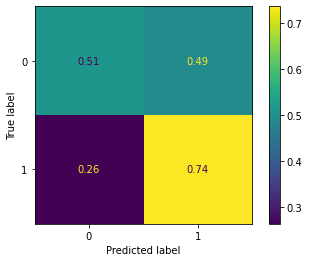

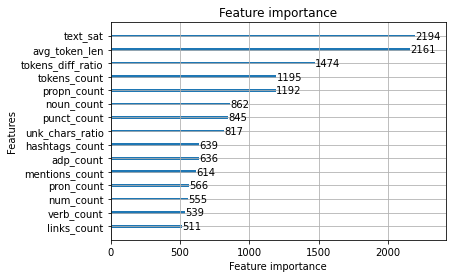

In [49]:
eval_clf(clf_meta_tweet_fe, df_test_meta_tweet_fe)

### Average probas at the user level

In [50]:
df_train_meta_agg_tweet_fe, df_test_meta_agg_tweet_fe = get_agg(clf_meta_tweet_fe, 
                                                                df_train_meta_tweet_fe, 
                                                                df_test_meta_tweet_fe, 
                                                                df_train['id'], 
                                                                df_test['id'])
clf_meta_agg_tweet_fe = get_best_clf(df_train_meta_agg_tweet_fe)

[I 2022-03-29 17:37:23,488] A new study created in memory with name: no-name-5c63b22a-e9db-48c7-9ba4-9ad81a5407c3


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:23,990] Trial 2 finished with value: 0.8167014440518816 and parameters: {'lambda_l1': 0.7921193869148032, 'lambda_l2': 0.012415788105518176, 'num_leaves': 15, 'feature_fraction': 0.8466429798159694, 'bagging_fraction': 0.9574049766478953, 'bagging_freq': 4, 'learning_rate': 0.04754307555146218, 'min_child_samples': 44}. Best is trial 2 with value: 0.8167014440518816.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.903327
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.897068


[I 2022-03-29 17:37:24,178] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 0.0002103261641511578, 'lambda_l2': 6.46001107439563, 'num_leaves': 119, 'feature_fraction': 0.4611601624387322, 'bagging_fraction': 0.6639384576652723, 'bagging_freq': 6, 'learning_rate': 1.612666790268398e-05, 'min_child_samples': 31}. Best is trial 2 with value: 0.8167014440518816.
[I 2022-03-29 17:37:24,272] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 3.627479885442273e-08, 'lambda_l2': 7.565361989018719e-06, 'num_leaves': 223, 'feature_fraction': 0.44482520022173005, 'bagging_fraction': 0.7275097870816291, 'bagging_freq': 5, 'learning_rate': 2.1445702654525732e-05, 'min_child_samples': 99}. Best is trial 2 with value: 0.8167014440518816.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.899145
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.901166
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.900047


[I 2022-03-29 17:37:24,382] Trial 1 finished with value: 0.6568539112702441 and parameters: {'lambda_l1': 0.0006363388652089502, 'lambda_l2': 6.143447221464025e-08, 'num_leaves': 213, 'feature_fraction': 0.9985162929845935, 'bagging_fraction': 0.7196092670056593, 'bagging_freq': 2, 'learning_rate': 0.001723453153658218, 'min_child_samples': 81}. Best is trial 2 with value: 0.8167014440518816.
[I 2022-03-29 17:37:24,398] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 3.5522970507971684e-07, 'lambda_l2': 0.0001063625843321, 'num_leaves': 153, 'feature_fraction': 0.5870273096039151, 'bagging_fraction': 0.46990998666307143, 'bagging_freq': 2, 'learning_rate': 4.6833875391203594e-05, 'min_child_samples': 52}. Best is trial 2 with value: 0.8167014440518816.
[I 2022-03-29 17:37:24,413] Trial 4 finished with value: 0.8009982690346905 and parameters: {'lambda_l1': 0.16813335444970953, 'lambda_l2': 3.4031670261831386e-06, 'num_leaves': 70, 'feature_fraction': 0.9778339489176611, 

Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.900769
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:24,602] Trial 9 finished with value: 0.8057821354895313 and parameters: {'lambda_l1': 6.515067984960716e-07, 'lambda_l2': 3.3763546706513368, 'num_leaves': 119, 'feature_fraction': 0.5295311361283221, 'bagging_fraction': 0.5116054001650873, 'bagging_freq': 4, 'learning_rate': 0.006430356960496765, 'min_child_samples': 95}. Best is trial 2 with value: 0.8167014440518816.
[I 2022-03-29 17:37:24,633] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 0.015135329495530248, 'lambda_l2': 0.0034131029647626317, 'num_leaves': 123, 'feature_fraction': 0.693734366364314, 'bagging_fraction': 0.4531207053001013, 'bagging_freq': 3, 'learning_rate': 0.0002782527591568027, 'min_child_samples': 70}. Best is trial 2 with value: 0.8167014440518816.
[I 2022-03-29 17:37:24,743] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 6.520077205475175, 'lambda_l2': 1.1577331693173846e-05, 'num_leaves': 181, 'feature_fraction': 0.6123169687157363, 'bagging_fraction': 

Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.899344
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.902187
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.89556
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:25,009] Trial 11 finished with value: 0.8192356484006356 and parameters: {'lambda_l1': 8.458468173801798e-05, 'lambda_l2': 0.0034965126787641133, 'num_leaves': 116, 'feature_fraction': 0.47631941008968304, 'bagging_fraction': 0.5490222673530446, 'bagging_freq': 5, 'learning_rate': 0.02655129096412478, 'min_child_samples': 96}. Best is trial 11 with value: 0.8192356484006356.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.901135
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:25,276] Trial 15 finished with value: 0.8170778697270765 and parameters: {'lambda_l1': 0.015045513488153613, 'lambda_l2': 4.9395337186328355e-05, 'num_leaves': 95, 'feature_fraction': 0.9003176944227946, 'bagging_fraction': 0.44578347615387753, 'bagging_freq': 7, 'learning_rate': 0.0966099633683853, 'min_child_samples': 88}. Best is trial 11 with value: 0.8192356484006356.
[I 2022-03-29 17:37:25,417] Trial 13 finished with value: 0.8038585113698338 and parameters: {'lambda_l1': 0.013638277106763314, 'lambda_l2': 1.3124682177106748e-05, 'num_leaves': 119, 'feature_fraction': 0.5639617920159199, 'bagging_fraction': 0.813180857119544, 'bagging_freq': 4, 'learning_rate': 0.006000799348788568, 'min_child_samples': 83}. Best is trial 11 with value: 0.8192356484006356.


Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.899011
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.899144


[I 2022-03-29 17:37:25,637] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 1.712535117988847, 'lambda_l2': 1.0671200295333387e-05, 'num_leaves': 82, 'feature_fraction': 0.4000679653560854, 'bagging_fraction': 0.8236005543972826, 'bagging_freq': 4, 'learning_rate': 0.00011666706775642993, 'min_child_samples': 41}. Best is trial 11 with value: 0.8192356484006356.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.898023


[I 2022-03-29 17:37:25,735] Trial 7 finished with value: 0.8116389633177625 and parameters: {'lambda_l1': 0.00017188304696371287, 'lambda_l2': 1.2380045036463903e-07, 'num_leaves': 112, 'feature_fraction': 0.9323673684189318, 'bagging_fraction': 0.7061746801853883, 'bagging_freq': 3, 'learning_rate': 0.07928058678918534, 'min_child_samples': 26}. Best is trial 11 with value: 0.8192356484006356.
[I 2022-03-29 17:37:25,857] Trial 14 finished with value: 0.5 and parameters: {'lambda_l1': 1.2973644201153682e-06, 'lambda_l2': 1.1036170674875692e-06, 'num_leaves': 76, 'feature_fraction': 0.8999878168647824, 'bagging_fraction': 0.5068631345223031, 'bagging_freq': 3, 'learning_rate': 0.0005353326495815528, 'min_child_samples': 42}. Best is trial 11 with value: 0.8192356484006356.


Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.89687
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.902354
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.897274


[I 2022-03-29 17:37:25,951] Trial 10 finished with value: 0.8193838474853579 and parameters: {'lambda_l1': 0.00037835544749982987, 'lambda_l2': 0.12724570505560304, 'num_leaves': 71, 'feature_fraction': 0.43177418561412495, 'bagging_fraction': 0.9774637652610906, 'bagging_freq': 4, 'learning_rate': 0.1016930855455021, 'min_child_samples': 50}. Best is trial 10 with value: 0.8193838474853579.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:26,499] Trial 17 finished with value: 0.8150119744860456 and parameters: {'lambda_l1': 3.13083462226567e-05, 'lambda_l2': 0.06945152134766763, 'num_leaves': 63, 'feature_fraction': 0.7743586495392333, 'bagging_fraction': 0.593141666608554, 'bagging_freq': 7, 'learning_rate': 0.132519826476366, 'min_child_samples': 19}. Best is trial 10 with value: 0.8193838474853579.
[I 2022-03-29 17:37:26,656] Trial 6 finished with value: 0.8124777701372916 and parameters: {'lambda_l1': 0.0009722958925478093, 'lambda_l2': 6.540974719534559e-07, 'num_leaves': 163, 'feature_fraction': 0.4917436221111025, 'bagging_fraction': 0.4831113379578988, 'bagging_freq': 1, 'learning_rate': 0.026054371089996874, 'min_child_samples': 12}. Best is trial 10 with value: 0.8193838474853579.


Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.898209
Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.897068
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:26,813] Trial 18 finished with value: 0.8038140516444171 and parameters: {'lambda_l1': 8.29601679739762e-05, 'lambda_l2': 0.03170764330390749, 'num_leaves': 62, 'feature_fraction': 0.8236139650165597, 'bagging_fraction': 0.5659166654007027, 'bagging_freq': 7, 'learning_rate': 0.20408141042175837, 'min_child_samples': 8}. Best is trial 10 with value: 0.8193838474853579.
[I 2022-03-29 17:37:26,891] Trial 21 finished with value: 0.8076375880302563 and parameters: {'lambda_l1': 1.4935773672279958e-05, 'lambda_l2': 0.04503856590783673, 'num_leaves': 58, 'feature_fraction': 0.8028928222840976, 'bagging_fraction': 0.5723732010172835, 'bagging_freq': 7, 'learning_rate': 0.29657844048171284, 'min_child_samples': 69}. Best is trial 10 with value: 0.8193838474853579.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.892018
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.900229


[I 2022-03-29 17:37:26,985] Trial 23 finished with value: 0.8110224551253172 and parameters: {'lambda_l1': 6.737708701505815e-05, 'lambda_l2': 0.15895658272992877, 'num_leaves': 39, 'feature_fraction': 0.7549290367824983, 'bagging_fraction': 0.9764889874491202, 'bagging_freq': 6, 'learning_rate': 0.28811267698960163, 'min_child_samples': 6}. Best is trial 10 with value: 0.8193838474853579.
[I 2022-03-29 17:37:27,038] Trial 22 finished with value: 0.8209132620396936 and parameters: {'lambda_l1': 1.8066683069392576e-05, 'lambda_l2': 0.05609903183077099, 'num_leaves': 47, 'feature_fraction': 0.78955406362734, 'bagging_fraction': 0.57434114744606, 'bagging_freq': 7, 'learning_rate': 0.25548160321020474, 'min_child_samples': 69}. Best is trial 22 with value: 0.8209132620396936.
[I 2022-03-29 17:37:27,142] Trial 19 finished with value: 0.8087965048727858 and parameters: {'lambda_l1': 3.685988672948576e-05, 'lambda_l2': 0.04643300716156509, 'num_leaves': 63, 'feature_fraction': 0.809325158556

Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.898756
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.897983
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.889732


[I 2022-03-29 17:37:27,283] Trial 20 finished with value: 0.8013598748014134 and parameters: {'lambda_l1': 6.612350530153242e-05, 'lambda_l2': 0.053677987987100634, 'num_leaves': 60, 'feature_fraction': 0.863478531371675, 'bagging_fraction': 0.5615851086497565, 'bagging_freq': 7, 'learning_rate': 0.15823258415731595, 'min_child_samples': 11}. Best is trial 22 with value: 0.8209132620396936.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.897467
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 17:37:27,519] Trial 30 finished with value: 0.8182367865696061 and parameters: {'lambda_l1': 3.1899109338775718e-06, 'lambda_l2': 0.0019291499866910438, 'num_leaves': 5, 'feature_fraction': 0.6531829757873966, 'bagging_fraction': 0.9056312459754163, 'bagging_freq': 5, 'learning_rate': 0.024169583805256405, 'min_child_samples': 66}. Best is trial 22 with value: 0.8209132620396936.



Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.900459


[I 2022-03-29 17:37:27,628] Trial 25 finished with value: 0.8147096483532118 and parameters: {'lambda_l1': 1.1526835729573791e-05, 'lambda_l2': 0.35735113688360964, 'num_leaves': 24, 'feature_fraction': 0.661623853325812, 'bagging_fraction': 0.9819093608787812, 'bagging_freq': 5, 'learning_rate': 0.24704167292707935, 'min_child_samples': 69}. Best is trial 22 with value: 0.8209132620396936.
[I 2022-03-29 17:37:27,723] Trial 24 finished with value: 0.8174661513290494 and parameters: {'lambda_l1': 6.750523593221397e-06, 'lambda_l2': 0.1618358069551149, 'num_leaves': 33, 'feature_fraction': 0.6678297100483181, 'bagging_fraction': 0.9678328150631254, 'bagging_freq': 6, 'learning_rate': 0.02432148455892712, 'min_child_samples': 5}. Best is trial 22 with value: 0.8209132620396936.


Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.902624
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.902893
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:27,839] Trial 31 finished with value: 0.8195379745334693 and parameters: {'lambda_l1': 4.924233587120399e-06, 'lambda_l2': 0.0012766029381536266, 'num_leaves': 8, 'feature_fraction': 0.6502945491065266, 'bagging_fraction': 0.4039353901090238, 'bagging_freq': 5, 'learning_rate': 0.017773190008969122, 'min_child_samples': 59}. Best is trial 22 with value: 0.8209132620396936.
[I 2022-03-29 17:37:27,926] Trial 26 finished with value: 0.8157025822208522 and parameters: {'lambda_l1': 4.466466179720031e-06, 'lambda_l2': 0.24630702450846906, 'num_leaves': 20, 'feature_fraction': 0.663744900683699, 'bagging_fraction': 0.9769161321928044, 'bagging_freq': 5, 'learning_rate': 0.018889739288704653, 'min_child_samples': 66}. Best is trial 22 with value: 0.8209132620396936.
[I 2022-03-29 17:37:27,926] Trial 27 finished with value: 0.8161649633651863 and parameters: {'lambda_l1': 6.548079984630538e-06, 'lambda_l2': 0.0010801906835421534, 'num_leaves': 20, 'feature_fraction': 0.6418

Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.901331
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.902256
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.903189
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:28,099] Trial 28 finished with value: 0.8173861238232992 and parameters: {'lambda_l1': 0.0071695307547228965, 'lambda_l2': 0.0008167846572017069, 'num_leaves': 91, 'feature_fraction': 0.6647017542988888, 'bagging_fraction': 0.4055283877832482, 'bagging_freq': 5, 'learning_rate': 0.017630859973509553, 'min_child_samples': 65}. Best is trial 22 with value: 0.8209132620396936.
[I 2022-03-29 17:37:28,193] Trial 29 finished with value: 0.8192297204372465 and parameters: {'lambda_l1': 5.467357836794252e-06, 'lambda_l2': 0.0006912128544442085, 'num_leaves': 37, 'feature_fraction': 0.6915569147692386, 'bagging_fraction': 0.4073131350456047, 'bagging_freq': 5, 'learning_rate': 0.02341454179896197, 'min_child_samples': 64}. Best is trial 22 with value: 0.8209132620396936.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.903524
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.9041
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:28,340] Trial 35 finished with value: 0.8259935266639793 and parameters: {'lambda_l1': 1.4978189084134076e-07, 'lambda_l2': 0.0008558226367927883, 'num_leaves': 2, 'feature_fraction': 0.7192598805556155, 'bagging_fraction': 0.41946954829567085, 'bagging_freq': 6, 'learning_rate': 0.06521822814454267, 'min_child_samples': 57}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.902029
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:28,541] Trial 32 finished with value: 0.819457947027719 and parameters: {'lambda_l1': 0.0025086282643584207, 'lambda_l2': 0.6084090317264041, 'num_leaves': 34, 'feature_fraction': 0.7226950011858028, 'bagging_fraction': 0.4116608231586393, 'bagging_freq': 5, 'learning_rate': 0.018149455965319326, 'min_child_samples': 59}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:28,648] Trial 33 finished with value: 0.8179226045099948 and parameters: {'lambda_l1': 0.0020457330323997163, 'lambda_l2': 0.7459528525446738, 'num_leaves': 37, 'feature_fraction': 0.40043176431971117, 'bagging_fraction': 0.4090003692908843, 'bagging_freq': 6, 'learning_rate': 0.018783269280258884, 'min_child_samples': 59}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.903566
Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.900687
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.90369


[I 2022-03-29 17:37:28,742] Trial 40 finished with value: 0.8186991677139401 and parameters: {'lambda_l1': 9.693253119316358e-08, 'lambda_l2': 0.0001532018712205195, 'num_leaves': 4, 'feature_fraction': 0.7403508584568064, 'bagging_fraction': 0.42783669796081897, 'bagging_freq': 6, 'learning_rate': 0.06607265390376835, 'min_child_samples': 54}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:28,883] Trial 34 finished with value: 0.8188355108718848 and parameters: {'lambda_l1': 0.0016146271565765878, 'lambda_l2': 0.9685514238575271, 'num_leaves': 145, 'feature_fraction': 0.41087406696339673, 'bagging_fraction': 0.6556020547373125, 'bagging_freq': 5, 'learning_rate': 0.012911583746268055, 'min_child_samples': 59}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.899622


[I 2022-03-29 17:37:29,040] Trial 42 finished with value: 0.8209251179664715 and parameters: {'lambda_l1': 7.504676502747014e-08, 'lambda_l2': 1.377900407210168, 'num_leaves': 3, 'feature_fraction': 0.736797963626045, 'bagging_fraction': 0.4661204837027328, 'bagging_freq': 6, 'learning_rate': 0.05311638685139939, 'min_child_samples': 77}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:29,118] Trial 36 finished with value: 0.8122495435468191 and parameters: {'lambda_l1': 2.9794879283027726e-08, 'lambda_l2': 0.0002498551320315252, 'num_leaves': 42, 'feature_fraction': 0.7300594089552299, 'bagging_fraction': 0.4084842431835148, 'bagging_freq': 6, 'learning_rate': 0.062144943297693815, 'min_child_samples': 56}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.902418
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.902558
Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.903068
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 17:37:29,212] Trial 37 finished with value: 0.8231392122922249 and parameters: {'lambda_l1': 5.7015078243213636e-08, 'lambda_l2': 0.00024544087156711084, 'num_leaves': 43, 'feature_fraction': 0.7105205352238603, 'bagging_fraction': 0.4081734629228656, 'bagging_freq': 6, 'learning_rate': 0.059059451526334066, 'min_child_samples': 55}. Best is trial 35 with value: 0.8259935266639793.



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:29,510] Trial 39 finished with value: 0.8157025822208522 and parameters: {'lambda_l1': 1.3944642395942505e-07, 'lambda_l2': 0.0001626918182625054, 'num_leaves': 141, 'feature_fraction': 0.7381784245388523, 'bagging_fraction': 0.6414419654304069, 'bagging_freq': 6, 'learning_rate': 0.05818779353485036, 'min_child_samples': 56}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:29,589] Trial 41 finished with value: 0.8186132122448012 and parameters: {'lambda_l1': 6.836640118406245e-08, 'lambda_l2': 0.00017431423137276525, 'num_leaves': 254, 'feature_fraction': 0.7390473715848649, 'bagging_fraction': 0.40126977390470353, 'bagging_freq': 6, 'learning_rate': 0.05540071714086437, 'min_child_samples': 56}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.901803
Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.902704
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.903817


[I 2022-03-29 17:37:29,683] Trial 43 finished with value: 0.8169978422213264 and parameters: {'lambda_l1': 1.286439683249687e-08, 'lambda_l2': 0.011580538504087136, 'num_leaves': 245, 'feature_fraction': 0.7285870277431984, 'bagging_fraction': 0.4807501826281984, 'bagging_freq': 6, 'learning_rate': 0.011082152724011678, 'min_child_samples': 79}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:29,777] Trial 46 finished with value: 0.6830229056505348 and parameters: {'lambda_l1': 1.304691852030198e-07, 'lambda_l2': 0.010723466665475646, 'num_leaves': 12, 'feature_fraction': 0.6067806408023775, 'bagging_fraction': 0.4755086166896414, 'bagging_freq': 6, 'learning_rate': 0.0026961911630021982, 'min_child_samples': 76}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:29,793] Trial 38 finished with value: 0.8142472672088777 and parameters: {'lambda_l1': 9.050509415249686e-08, 'lambda_l2': 0.00021297308477668915, 'num_leaves': 145, 'feature_fraction': 

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.901713
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.899327
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.901878
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:29,950] Trial 44 finished with value: 0.7033587840561497 and parameters: {'lambda_l1': 2.0444556154966387e-07, 'lambda_l2': 0.012085472591279215, 'num_leaves': 43, 'feature_fraction': 0.7242600510635079, 'bagging_fraction': 0.4861087587541886, 'bagging_freq': 6, 'learning_rate': 0.0019484470673119133, 'min_child_samples': 77}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:30,075] Trial 45 finished with value: 0.8183108861119672 and parameters: {'lambda_l1': 2.2231013752723716e-08, 'lambda_l2': 0.008829781968803987, 'num_leaves': 256, 'feature_fraction': 0.6112097236830286, 'bagging_fraction': 0.47827788088935996, 'bagging_freq': 6, 'learning_rate': 0.05106537023871662, 'min_child_samples': 76}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.901922
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.903061
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.901734


[I 2022-03-29 17:37:30,184] Trial 48 finished with value: 0.817780333388661 and parameters: {'lambda_l1': 2.133071755319185e-07, 'lambda_l2': 0.00716864474187226, 'num_leaves': 3, 'feature_fraction': 0.7811961577718375, 'bagging_fraction': 0.47416004306616427, 'bagging_freq': 6, 'learning_rate': 0.042883210223904206, 'min_child_samples': 78}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:30,247] Trial 47 finished with value: 0.7061212149953762 and parameters: {'lambda_l1': 1.0178874520182245e-08, 'lambda_l2': 0.01532258909623455, 'num_leaves': 50, 'feature_fraction': 0.7762015949696943, 'bagging_fraction': 0.48029157746849366, 'bagging_freq': 6, 'learning_rate': 0.0020798605532559794, 'min_child_samples': 76}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:30,373] Trial 49 finished with value: 0.815246129039907 and parameters: {'lambda_l1': 3.1535243232774834e-07, 'lambda_l2': 0.007820167308246745, 'num_leaves': 3, 'feature_fraction': 0.7771

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.890973
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:30,467] Trial 51 finished with value: 0.8178662888578 and parameters: {'lambda_l1': 4.4376835500455516e-07, 'lambda_l2': 3.1629780266002347, 'num_leaves': 2, 'feature_fraction': 0.6991450974918094, 'bagging_fraction': 0.5210969758547844, 'bagging_freq': 7, 'learning_rate': 0.04055864308742418, 'min_child_samples': 48}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:30,561] Trial 52 finished with value: 0.8187791952196903 and parameters: {'lambda_l1': 4.1263667459974546e-07, 'lambda_l2': 4.1166856505877946e-05, 'num_leaves': 3, 'feature_fraction': 0.7790891530844398, 'bagging_fraction': 0.5189992480947236, 'bagging_freq': 7, 'learning_rate': 0.0395636713039002, 'min_child_samples': 48}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.899716
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.901531
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.899342
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.902798
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 17:37:30,623] Trial 53 finished with value: 0.819093377279302 and parameters: {'lambda_l1': 6.03489347693833e-07, 'lambda_l2': 3.2208791721222307, 'num_leaves': 2, 'feature_fraction': 0.7691829026248826, 'bagging_fraction': 0.5220610974003024, 'bagging_freq': 7, 'learning_rate': 0.04174197207873051, 'min_child_samples': 50}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:30,717] Trial 50 finished with value: 0.8256793446043678 and parameters: {'lambda_l1': 3.3498288859069324e-07, 'lambda_l2': 0.011459063599316456, 'num_leaves': 9, 'feature_fraction': 0.6127637681236133, 'bagging_fraction': 0.5157930250936142, 'bagging_freq': 7, 'learning_rate': 0.03895660721170735, 'min_child_samples': 74}. Best is trial 35 with value: 0.8259935266639793.



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.903076


[I 2022-03-29 17:37:30,845] Trial 54 finished with value: 0.8192297204372465 and parameters: {'lambda_l1': 6.122151284289594e-07, 'lambda_l2': 4.5203461216565286e-05, 'num_leaves': 3, 'feature_fraction': 0.7859406684422969, 'bagging_fraction': 0.5306901136349957, 'bagging_freq': 7, 'learning_rate': 0.15188916910584807, 'min_child_samples': 49}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:31,188] Trial 55 finished with value: 0.8067750693571717 and parameters: {'lambda_l1': 6.253623110247563e-07, 'lambda_l2': 5.767181823804259, 'num_leaves': 51, 'feature_fraction': 0.5606080959934492, 'bagging_fraction': 0.5219829074806938, 'bagging_freq': 1, 'learning_rate': 0.0069187333861247795, 'min_child_samples': 47}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:31,322] Trial 56 finished with value: 0.8060400018969482 and parameters: {'lambda_l1': 6.724892914554467e-07, 'lambda_l2': 4.425753746421238e-05, 'num_leaves': 26, 'feature_fraction': 0.6966265351976824, 'bagging_fraction': 0.524858488545169, 'bagging_freq': 7, 'learning_rate': 0.1373373300913953, 'min_child_samples': 49}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.899161
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.898525


[I 2022-03-29 17:37:31,510] Trial 57 finished with value: 0.8140990681241552 and parameters: {'lambda_l1': 1.0728396644611402e-06, 'lambda_l2': 3.997311093039444e-05, 'num_leaves': 26, 'feature_fraction': 0.5447635101572582, 'bagging_fraction': 0.5278989624054725, 'bagging_freq': 1, 'learning_rate': 0.12782961795585596, 'min_child_samples': 47}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:31,634] Trial 58 finished with value: 0.8157766817632134 and parameters: {'lambda_l1': 8.606827245779564e-07, 'lambda_l2': 1.8766919596025042, 'num_leaves': 28, 'feature_fraction': 0.694269618578637, 'bagging_fraction': 0.4455036229255019, 'bagging_freq': 1, 'learning_rate': 0.1388873705437647, 'min_child_samples': 50}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.898758
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.90223
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:31,881] Trial 60 finished with value: 0.8259075711948403 and parameters: {'lambda_l1': 1.08466574071524e-06, 'lambda_l2': 1.2367529925814806, 'num_leaves': 28, 'feature_fraction': 0.5688183653860032, 'bagging_fraction': 0.4440812985717676, 'bagging_freq': 1, 'learning_rate': 0.1387211951625935, 'min_child_samples': 87}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.901539
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.900487
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.901545


[I 2022-03-29 17:37:31,961] Trial 61 finished with value: 0.816473217461409 and parameters: {'lambda_l1': 1.4661750281909372e-06, 'lambda_l2': 0.00273856623180341, 'num_leaves': 23, 'feature_fraction': 0.5660554383841715, 'bagging_fraction': 0.44238866866211907, 'bagging_freq': 7, 'learning_rate': 0.1301612517839316, 'min_child_samples': 88}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:31,996] Trial 59 finished with value: 0.8190014938467739 and parameters: {'lambda_l1': 1.3406937061327396e-06, 'lambda_l2': 9.374287914065825, 'num_leaves': 27, 'feature_fraction': 0.8553179060621855, 'bagging_fraction': 0.4449887418475593, 'bagging_freq': 4, 'learning_rate': 0.13487616177022374, 'min_child_samples': 36}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:32,204] Trial 62 finished with value: 0.8014606501790245 and parameters: {'lambda_l1': 1.8984383486705038e-06, 'lambda_l2': 0.0030162033222663593, 'num_leaves': 23, 'feature_fraction': 0.635215

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.902551
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.90297


[I 2022-03-29 17:37:32,572] Trial 64 finished with value: 0.8126318971854031 and parameters: {'lambda_l1': 2.1677298666837302e-06, 'lambda_l2': 0.002016648358828672, 'num_leaves': 15, 'feature_fraction': 0.6337078755584862, 'bagging_fraction': 0.44282642152664375, 'bagging_freq': 7, 'learning_rate': 0.11411538980486903, 'min_child_samples': 71}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:32,733] Trial 65 finished with value: 0.8130201787873758 and parameters: {'lambda_l1': 2.3488043874755253e-06, 'lambda_l2': 0.0004819928270500808, 'num_leaves': 15, 'feature_fraction': 0.6323523835753652, 'bagging_fraction': 0.4439008750633409, 'bagging_freq': 2, 'learning_rate': 0.09907510209448327, 'min_child_samples': 38}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:32,811] Trial 63 finished with value: 0.8172201408484101 and parameters: {'lambda_l1': 1.0432719790868752e-06, 'lambda_l2': 0.001492862091922806, 'num_leaves': 27, 'feature_fraction': 0.

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.901346
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.900322
Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.902901


[I 2022-03-29 17:37:32,939] Trial 66 finished with value: 0.8187732672563015 and parameters: {'lambda_l1': 2.5903923641172396e-06, 'lambda_l2': 0.0004982647756935435, 'num_leaves': 15, 'feature_fraction': 0.6304275104916319, 'bagging_fraction': 0.5976675196826504, 'bagging_freq': 2, 'learning_rate': 0.10178520499199159, 'min_child_samples': 36}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:33,246] Trial 69 finished with value: 0.8190014938467739 and parameters: {'lambda_l1': 3.0723655604217017e-06, 'lambda_l2': 0.00045820856740269404, 'num_leaves': 13, 'feature_fraction': 0.4964097380364698, 'bagging_fraction': 0.5890810641100458, 'bagging_freq': 4, 'learning_rate': 0.08319452942792586, 'min_child_samples': 72}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:33,359] Trial 68 finished with value: 0.8133225049202096 and parameters: {'lambda_l1': 1.8551738517316755e-06, 'lambda_l2': 0.000631604452813943, 'num_leaves': 14, 'feature_fraction': 0.6278869573551995, 'bagging_fraction': 0.6002651297467695, 'bagging_freq': 2, 'learning_rate': 0.09532625502694667, 'min_child_samples': 83}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.903939
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.903091
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.899447
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:33,433] Trial 70 finished with value: 0.5 and parameters: {'lambda_l1': 3.737806167644325e-08, 'lambda_l2': 0.0006519971507923539, 'num_leaves': 15, 'feature_fraction': 0.585115502457426, 'bagging_fraction': 0.4330812662404741, 'bagging_freq': 4, 'learning_rate': 1.033485154580512e-05, 'min_child_samples': 83}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:33,635] Trial 67 finished with value: 0.8145495933417115 and parameters: {'lambda_l1': 2.7255635738268135e-06, 'lambda_l2': 0.0034820720208645303, 'num_leaves': 186, 'feature_fraction': 0.4983673621389824, 'bagging_fraction': 0.4421250313867247, 'bagging_freq': 2, 'learning_rate': 0.20064473894013002, 'min_child_samples': 72}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.898917
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:34,043] Trial 74 finished with value: 0.811404808763901 and parameters: {'lambda_l1': 5.2104729619877695e-08, 'lambda_l2': 0.025469687829096074, 'num_leaves': 183, 'feature_fraction': 0.5927014110073047, 'bagging_fraction': 0.4243269566335335, 'bagging_freq': 3, 'learning_rate': 0.1990085855652753, 'min_child_samples': 82}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:34,155] Trial 71 finished with value: 0.8117130628601238 and parameters: {'lambda_l1': 3.9865321646761714e-08, 'lambda_l2': 0.00047241319508213, 'num_leaves': 191, 'feature_fraction': 0.8151937086810721, 'bagging_fraction': 0.6053963778968865, 'bagging_freq': 2, 'learning_rate': 0.08430298765813081, 'min_child_samples': 73}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.899992
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.901584
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.897892
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.901528

[I 2022-03-29 17:37:34,266] Trial 73 finished with value: 0.8142472672088777 and parameters: {'lambda_l1': 4.9018814281921924e-08, 'lambda_l2': 0.02070690904132656, 'num_leaves': 188, 'feature_fraction': 0.5025956818877886, 'bagging_fraction': 0.5918992865721278, 'bagging_freq': 3, 'learning_rate': 0.2224445234505647, 'min_child_samples': 87}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:34,304] Trial 72 finished with value: 0.8110046712351504 and parameters: {'lambda_l1': 5.158961124237593e-08, 'lambda_l2': 0.023296327056896517, 'num_leaves': 190, 'feature_fraction': 0.8369906577578439, 'bagging_fraction': 0.49462199352671987, 'bagging_freq': 3, 'learning_rate': 0.18457805029250413, 'min_child_samples': 72}. Best is trial 35 with value: 0.8259935266639793.



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.902267
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.900929
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.902288


[I 2022-03-29 17:37:34,458] Trial 75 finished with value: 0.8203026818106371 and parameters: {'lambda_l1': 5.016117629816883e-08, 'lambda_l2': 0.09284081718932347, 'num_leaves': 49, 'feature_fraction': 0.5901689720470948, 'bagging_fraction': 0.49639966131116897, 'bagging_freq': 3, 'learning_rate': 0.20452640198739402, 'min_child_samples': 83}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:34,487] Trial 77 finished with value: 0.5 and parameters: {'lambda_l1': 1.6796846285591237e-05, 'lambda_l2': 0.02353036197540821, 'num_leaves': 185, 'feature_fraction': 0.6774715559462631, 'bagging_fraction': 0.5025029864140663, 'bagging_freq': 3, 'learning_rate': 0.001152836498576171, 'min_child_samples': 100}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:34,521] Trial 76 finished with value: 0.8223804329784459 and parameters: {'lambda_l1': 5.277857290851766e-08, 'lambda_l2': 0.025412681262313573, 'num_leaves': 52, 'feature_fraction': 0.5960566081940527,

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.903427

[I 2022-03-29 17:37:34,814] Trial 78 finished with value: 0.8212956156782776 and parameters: {'lambda_l1': 0.0005406032335169948, 'lambda_l2': 0.3327165999147222, 'num_leaves': 49, 'feature_fraction': 0.6775747022804816, 'bagging_fraction': 0.502201077970452, 'bagging_freq': 3, 'learning_rate': 0.012976425914625056, 'min_child_samples': 59}. Best is trial 35 with value: 0.8259935266639793.



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:35,160] Trial 79 finished with value: 0.8163131624499088 and parameters: {'lambda_l1': 1.4764416592682466e-05, 'lambda_l2': 0.5587409945644779, 'num_leaves': 51, 'feature_fraction': 0.7088653935593533, 'bagging_fraction': 0.4177073950181906, 'bagging_freq': 5, 'learning_rate': 0.03135850072373414, 'min_child_samples': 62}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:35,315] Trial 82 finished with value: 0.5 and parameters: {'lambda_l1': 0.13319282531486168, 'lambda_l2': 0.39065718077399225, 'num_leaves': 50, 'feature_fraction': 0.6795805142773041, 'bagging_fraction': 0.4192833448102238, 'bagging_freq': 5, 'learning_rate': 4.5539955214702027e-05, 'min_child_samples': 94}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.904017
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.901033


[I 2022-03-29 17:37:35,422] Trial 80 finished with value: 0.8185272567756622 and parameters: {'lambda_l1': 0.0005803327266663495, 'lambda_l2': 0.4973130968173505, 'num_leaves': 47, 'feature_fraction': 0.6777719543883352, 'bagging_fraction': 0.4993233423116962, 'bagging_freq': 5, 'learning_rate': 0.03442084144972026, 'min_child_samples': 61}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.903171
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.903393

[I 2022-03-29 17:37:35,629] Trial 81 finished with value: 0.8131743058354871 and parameters: {'lambda_l1': 0.0003198584381653682, 'lambda_l2': 0.7500071525968194, 'num_leaves': 52, 'feature_fraction': 0.6777890071735783, 'bagging_fraction': 0.5004143935780501, 'bagging_freq': 5, 'learning_rate': 0.03175490475502033, 'min_child_samples': 61}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:35,734] Trial 84 finished with value: 0.5 and parameters: {'lambda_l1': 1.723963947943358e-08, 'lambda_l2': 0.07625619198834391, 'num_leaves': 73, 'feature_fraction': 0.539348323374152, 'bagging_fraction': 0.5466413116660832, 'bagging_freq': 3, 'learning_rate': 6.660123096368731e-05, 'min_child_samples': 94}. Best is trial 35 with value: 0.8259935266639793.



Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.8995
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.90333
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.902027
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:35,822] Trial 85 finished with value: 0.8189273943044126 and parameters: {'lambda_l1': 1.769575147901629e-08, 'lambda_l2': 0.08673035631441088, 'num_leaves': 75, 'feature_fraction': 0.5240871336335499, 'bagging_fraction': 0.5465828625319052, 'bagging_freq': 3, 'learning_rate': 0.031044369166299227, 'min_child_samples': 91}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:35,826] Trial 83 finished with value: 0.8193838474853579 and parameters: {'lambda_l1': 1.3807289579738633e-05, 'lambda_l2': 0.11676384871321828, 'num_leaves': 71, 'feature_fraction': 0.7547131023846441, 'bagging_fraction': 0.5484095158523536, 'bagging_freq': 3, 'learning_rate': 0.033374363060548404, 'min_child_samples': 93}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:36,012] Trial 86 finished with value: 0.819007421810163 and parameters: {'lambda_l1': 0.00020574579714245522, 'lambda_l2': 0.26233664389077055, 'num_leaves': 70, 'feature_fraction': 0.52205

Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.902542
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:36,299] Trial 87 finished with value: 0.8137848860645438 and parameters: {'lambda_l1': 0.00044171044984573667, 'lambda_l2': 0.22801074611754055, 'num_leaves': 71, 'feature_fraction': 0.6769984887258209, 'bagging_fraction': 0.5480040360394379, 'bagging_freq': 4, 'learning_rate': 0.032969527815018086, 'min_child_samples': 90}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.904108


[I 2022-03-29 17:37:36,411] Trial 88 finished with value: 0.8156966542574633 and parameters: {'lambda_l1': 0.00017190612320372027, 'lambda_l2': 0.1507309374367321, 'num_leaves': 75, 'feature_fraction': 0.7536734002981791, 'bagging_fraction': 0.46115012005972067, 'bagging_freq': 3, 'learning_rate': 0.06284952645871665, 'min_child_samples': 93}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:36,528] Trial 89 finished with value: 0.8151720294975459 and parameters: {'lambda_l1': 2.0887076405242889e-07, 'lambda_l2': 0.0962836254142407, 'num_leaves': 77, 'feature_fraction': 0.5807622342412677, 'bagging_fraction': 0.45827634510227644, 'bagging_freq': 3, 'learning_rate': 0.06618636505535708, 'min_child_samples': 91}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.903402
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.901317
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:36,714] Trial 90 finished with value: 0.8136307590164323 and parameters: {'lambda_l1': 2.490241497556676e-08, 'lambda_l2': 0.09482469087182513, 'num_leaves': 70, 'feature_fraction': 0.5851604823588158, 'bagging_fraction': 0.46483814751695457, 'bagging_freq': 3, 'learning_rate': 0.06856494126146039, 'min_child_samples': 92}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.902414
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:36,894] Trial 91 finished with value: 0.8162449908709364 and parameters: {'lambda_l1': 0.00014335612929854857, 'lambda_l2': 1.5771181777269019, 'num_leaves': 80, 'feature_fraction': 0.5904255267051626, 'bagging_fraction': 0.4628597393485832, 'bagging_freq': 3, 'learning_rate': 0.06449702216856554, 'min_child_samples': 97}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:37,013] Trial 93 finished with value: 0.8253651625447561 and parameters: {'lambda_l1': 1.7479996130417244e-07, 'lambda_l2': 0.2742599036111871, 'num_leaves': 110, 'feature_fraction': 0.5966238737303109, 'bagging_fraction': 0.4642492559797849, 'bagging_freq': 4, 'learning_rate': 0.06705780995917097, 'min_child_samples': 97}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:37,051] Trial 92 finished with value: 0.8197721290873309 and parameters: {'lambda_l1': 0.00016502439523945173, 'lambda_l2': 1.1196411874146897, 'num_leaves': 97, 'feature_fraction': 0.5883387

Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.902005
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.901151
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.901796
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.90123


[I 2022-03-29 17:37:37,200] Trial 95 finished with value: 0.8157826097266023 and parameters: {'lambda_l1': 1.9106232040729986e-07, 'lambda_l2': 1.2100879444218504, 'num_leaves': 91, 'feature_fraction': 0.5865859450125825, 'bagging_fraction': 0.45441347841558555, 'bagging_freq': 4, 'learning_rate': 0.06332133520447569, 'min_child_samples': 86}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:37,229] Trial 96 finished with value: 0.8216779693168615 and parameters: {'lambda_l1': 2.2010746058995805e-07, 'lambda_l2': 2.237924062110202e-08, 'num_leaves': 107, 'feature_fraction': 0.5811880714017634, 'bagging_fraction': 0.46090467921098377, 'bagging_freq': 4, 'learning_rate': 0.012185006500352591, 'min_child_samples': 97}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:37,277] Trial 97 finished with value: 0.8174602233656605 and parameters: {'lambda_l1': 1.1051560267257924e-07, 'lambda_l2': 1.4762062437077328, 'num_leaves': 88, 'feature_fraction': 0.5

Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.902132
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.900919
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.900652
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.902172
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.899537


[I 2022-03-29 17:37:37,386] Trial 98 finished with value: 0.8183790576909397 and parameters: {'lambda_l1': 1.753368153162128e-07, 'lambda_l2': 2.9736169917965508e-08, 'num_leaves': 33, 'feature_fraction': 0.6038967078334317, 'bagging_fraction': 0.724101048329927, 'bagging_freq': 6, 'learning_rate': 0.01584444744416439, 'min_child_samples': 53}. Best is trial 35 with value: 0.8259935266639793.


{'lambda_l1': 1.4978189084134076e-07, 'lambda_l2': 0.0008558226367927883, 'num_leaves': 2, 'feature_fraction': 0.7192598805556155, 'bagging_fraction': 0.41946954829567085, 'bagging_freq': 6, 'learning_rate': 0.06521822814454267, 'min_child_samples': 57} -> 0.8259935266639793
[LightGBM] [Warning] feature_fraction is set=0.7192598805556155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7192598805556155
[LightGBM] [Warning] lambda_l1 is set=1.4978189084134076e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4978189084134076e-07
[LightGBM] [Warning] bagging_fraction is set=0.41946954829567085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41946954829567085
[LightGBM] [Warning] lambda_l2 is set=0.0008558226367927883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008558226367927883
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores

AUROC: 0.7320240561694291
Accuracy: 0.7311918850380389


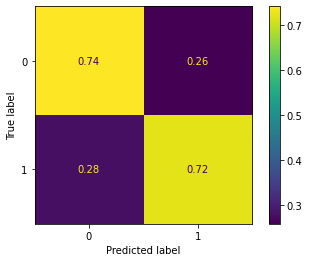

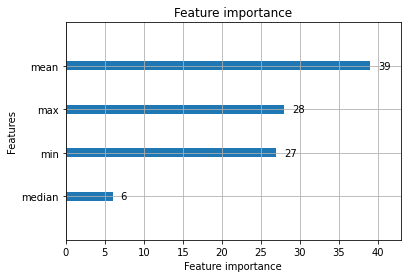

In [51]:
eval_clf(clf_meta_agg_tweet_fe, df_test_meta_agg_tweet_fe)

### Average features at the user level

> Mean

In [52]:
df_train_meta_tweet_fe_mean = get_mean(df_train_meta_tweet_fe, df_train['id'])
df_test_meta_tweet_fe_mean = get_mean(df_test_meta_tweet_fe, df_test['id'])

clf_meta_tweet_fe_mean = get_best_clf(df_train_meta_tweet_fe_mean)

[I 2022-03-29 17:37:38,737] A new study created in memory with name: no-name-4abc1a80-faec-4589-b966-7638eba33c44


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:39,783] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 0.5117744185078613, 'lambda_l2': 0.0005445870674583036, 'num_leaves': 135, 'feature_fraction': 0.8737339494905844, 'bagging_fraction': 0.4021166631975248, 'bagging_freq': 4, 'learning_rate': 0.00030234030840058584, 'min_child_samples': 75}. Best is trial 2 with value: 0.5.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.787109
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:40,281] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 4.052161602689612e-07, 'lambda_l2': 1.7012774689857764e-06, 'num_leaves': 43, 'feature_fraction': 0.6566504782596964, 'bagging_fraction': 0.41885084953408624, 'bagging_freq': 3, 'learning_rate': 0.0013804148278097727, 'min_child_samples': 41}. Best is trial 2 with value: 0.5.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.799995
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:40,500] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 9.912894471570818, 'lambda_l2': 0.003044234931418944, 'num_leaves': 242, 'feature_fraction': 0.7365215434295719, 'bagging_fraction': 0.7394468808821746, 'bagging_freq': 6, 'learning_rate': 1.2438840252970179e-05, 'min_child_samples': 40}. Best is trial 2 with value: 0.5.
[I 2022-03-29 17:37:40,633] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 2.1401735708199568e-07, 'lambda_l2': 5.423315301936599, 'num_leaves': 123, 'feature_fraction': 0.6736159183336354, 'bagging_fraction': 0.9632381704159128, 'bagging_freq': 1, 'learning_rate': 0.0009742999647437766, 'min_child_samples': 78}. Best is trial 2 with value: 0.5.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.788347
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.80086


[I 2022-03-29 17:37:40,785] Trial 1 finished with value: 0.6637155288928935 and parameters: {'lambda_l1': 0.08408029737348809, 'lambda_l2': 8.192333616806236e-08, 'num_leaves': 254, 'feature_fraction': 0.4877305072374777, 'bagging_fraction': 0.5395169126611723, 'bagging_freq': 4, 'learning_rate': 0.005649703274556463, 'min_child_samples': 47}. Best is trial 1 with value: 0.6637155288928935.
[I 2022-03-29 17:37:40,913] Trial 5 finished with value: 0.7615506366632679 and parameters: {'lambda_l1': 0.48322615281107556, 'lambda_l2': 9.284257529779762, 'num_leaves': 246, 'feature_fraction': 0.5768540441672537, 'bagging_fraction': 0.9786207122871116, 'bagging_freq': 5, 'learning_rate': 0.08189634276000674, 'min_child_samples': 73}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.806167
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.836874
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:41,347] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 0.04854493123943419, 'lambda_l2': 4.51497672151757e-06, 'num_leaves': 225, 'feature_fraction': 0.4139182420126622, 'bagging_fraction': 0.7092311182353508, 'bagging_freq': 4, 'learning_rate': 0.0008166823787300278, 'min_child_samples': 47}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.804559
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:42,139] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 1.9658691488282686e-06, 'lambda_l2': 0.009238847837273627, 'num_leaves': 132, 'feature_fraction': 0.44510300837756234, 'bagging_fraction': 0.6915516523360316, 'bagging_freq': 1, 'learning_rate': 0.0007884639555668595, 'min_child_samples': 99}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.787869
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:42,453] Trial 10 finished with value: 0.7379899461740924 and parameters: {'lambda_l1': 0.00011078781846250158, 'lambda_l2': 4.597333484581222e-08, 'num_leaves': 114, 'feature_fraction': 0.8457759542012571, 'bagging_fraction': 0.9305250587345921, 'bagging_freq': 7, 'learning_rate': 0.022056783022906885, 'min_child_samples': 98}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:42,579] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 3.0417680732881038e-05, 'lambda_l2': 0.0013205563716439767, 'num_leaves': 214, 'feature_fraction': 0.6446902819766493, 'bagging_fraction': 0.8219131444447694, 'bagging_freq': 3, 'learning_rate': 0.00023346058191724692, 'min_child_samples': 56}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.81988
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.808863
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:43,441] Trial 11 finished with value: 0.7336417850283355 and parameters: {'lambda_l1': 0.005039435807778696, 'lambda_l2': 0.8745984608749954, 'num_leaves': 254, 'feature_fraction': 0.41449221220411714, 'bagging_fraction': 0.588469826319608, 'bagging_freq': 1, 'learning_rate': 0.28798285081871666, 'min_child_samples': 39}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.810754
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.81603


[I 2022-03-29 17:37:43,629] Trial 14 finished with value: 0.7164773670357811 and parameters: {'lambda_l1': 0.002250999692690772, 'lambda_l2': 0.00086961560919568, 'num_leaves': 233, 'feature_fraction': 0.4127062697565919, 'bagging_fraction': 0.7659846189418835, 'bagging_freq': 7, 'learning_rate': 0.015977155458348855, 'min_child_samples': 67}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:44,273] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 0.00011432819461283515, 'lambda_l2': 3.0301815070659386e-07, 'num_leaves': 204, 'feature_fraction': 0.6003626071981308, 'bagging_fraction': 0.9048346955162524, 'bagging_freq': 1, 'learning_rate': 0.00010219318620327157, 'min_child_samples': 93}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:44,351] Trial 7 finished with value: 0.7425278021482938 and parameters: {'lambda_l1': 6.84931027023246e-07, 'lambda_l2': 8.393203372456687e-08, 'num_leaves': 130, 'feature_fraction': 0.6916165991381193, 'bagging_fraction': 0.5252114319407112, 'bagging_freq': 5, 'learning_rate': 0.16579628856647882, 'min_child_samples': 5}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.816298
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.798014
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:45,166] Trial 13 finished with value: 0.7326814549593341 and parameters: {'lambda_l1': 1.958562499149875e-05, 'lambda_l2': 1.587824011192164e-05, 'num_leaves': 98, 'feature_fraction': 0.5492961009655078, 'bagging_fraction': 0.9700958071958793, 'bagging_freq': 6, 'learning_rate': 0.020904765670029492, 'min_child_samples': 14}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.830081


[I 2022-03-29 17:37:45,495] Trial 16 finished with value: 0.7341664097882532 and parameters: {'lambda_l1': 0.00013877478824437213, 'lambda_l2': 0.1834402973258483, 'num_leaves': 176, 'feature_fraction': 0.8343834340560021, 'bagging_fraction': 0.844908695975128, 'bagging_freq': 4, 'learning_rate': 0.24893245696248598, 'min_child_samples': 56}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.822174
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:46,515] Trial 23 finished with value: 0.7455984871837432 and parameters: {'lambda_l1': 1.1512334561329948e-08, 'lambda_l2': 0.0604161204328538, 'num_leaves': 21, 'feature_fraction': 0.7644025935237813, 'bagging_fraction': 0.616504273938882, 'bagging_freq': 5, 'learning_rate': 0.0872184007218791, 'min_child_samples': 13}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:46,594] Trial 20 finished with value: 0.7414548407749033 and parameters: {'lambda_l1': 1.7391198424916305e-08, 'lambda_l2': 1.0608301889461365e-08, 'num_leaves': 71, 'feature_fraction': 0.9865443150669793, 'bagging_fraction': 0.9943448379172255, 'bagging_freq': 6, 'learning_rate': 0.12207061743844531, 'min_child_samples': 86}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.826352
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.831376
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.834866
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:46,703] Trial 18 finished with value: 0.7469737746899676 and parameters: {'lambda_l1': 0.0005723077695813371, 'lambda_l2': 3.5624977463873675e-08, 'num_leaves': 71, 'feature_fraction': 0.9542691973335529, 'bagging_fraction': 0.9988457867041098, 'bagging_freq': 7, 'learning_rate': 0.07227153230117629, 'min_child_samples': 13}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:47,076] Trial 19 finished with value: 0.7496680340502218 and parameters: {'lambda_l1': 6.442763834593614e-05, 'lambda_l2': 1.7388609077583872e-08, 'num_leaves': 80, 'feature_fraction': 0.9690422370991085, 'bagging_fraction': 0.9957923167401473, 'bagging_freq': 6, 'learning_rate': 0.10038867760603938, 'min_child_samples': 14}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:47,220] Trial 24 finished with value: 0.6973241173262514 and parameters: {'lambda_l1': 6.6660964002034975, 'lambda_l2': 0.04093332148976484, 'num_leaves': 7, 'feature_fraction': 0.977420034033657, 'bagging_fraction': 0.6361588593468053, 'bagging_freq': 5, 'learning_rate': 0.04373633253395794, 'min_child_samples': 25}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.832716
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.790959


[I 2022-03-29 17:37:47,511] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 1.3883423972920015e-08, 'lambda_l2': 4.1149019597949594e-07, 'num_leaves': 214, 'feature_fraction': 0.9450033154134608, 'bagging_fraction': 0.6764459295046406, 'bagging_freq': 3, 'learning_rate': 8.101031124684287e-05, 'min_child_samples': 16}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.811439
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:47,897] Trial 25 finished with value: 0.739519360728428 and parameters: {'lambda_l1': 8.558350672740003, 'lambda_l2': 0.08327048385728517, 'num_leaves': 21, 'feature_fraction': 0.7660341673316471, 'bagging_fraction': 0.6234040459603784, 'bagging_freq': 5, 'learning_rate': 0.07039847552102625, 'min_child_samples': 25}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.824835
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:48,191] Trial 22 finished with value: 0.7389324923529272 and parameters: {'lambda_l1': 6.627419500829162, 'lambda_l2': 0.26581589470960443, 'num_leaves': 180, 'feature_fraction': 0.7624141682229715, 'bagging_fraction': 0.5967966482297199, 'bagging_freq': 5, 'learning_rate': 0.28304347735917273, 'min_child_samples': 6}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.825347
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:48,803] Trial 27 finished with value: 0.6049160600384133 and parameters: {'lambda_l1': 9.545947128370258, 'lambda_l2': 3.84246862192462e-05, 'num_leaves': 166, 'feature_fraction': 0.5364952698665694, 'bagging_fraction': 0.8815394976290896, 'bagging_freq': 5, 'learning_rate': 0.004745958083397216, 'min_child_samples': 66}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.792575
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:49,784] Trial 17 finished with value: 0.7345546913902259 and parameters: {'lambda_l1': 0.002945147171916336, 'lambda_l2': 5.491307325015326, 'num_leaves': 178, 'feature_fraction': 0.5465426365665358, 'bagging_fraction': 0.8793154400400792, 'bagging_freq': 6, 'learning_rate': 0.29660991881608556, 'min_child_samples': 8}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.821519
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:50,497] Trial 28 finished with value: 0.6807021079837811 and parameters: {'lambda_l1': 0.0012179889922707707, 'lambda_l2': 9.869915676673726e-07, 'num_leaves': 70, 'feature_fraction': 0.9173339063988784, 'bagging_fraction': 0.8881440744412509, 'bagging_freq': 7, 'learning_rate': 0.005335773901110027, 'min_child_samples': 22}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.800467
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:50,795] Trial 29 finished with value: 0.7121054940364688 and parameters: {'lambda_l1': 0.0016457887511563574, 'lambda_l2': 5.8618789584338e-05, 'num_leaves': 73, 'feature_fraction': 0.9333286575824643, 'bagging_fraction': 0.8805528718904241, 'bagging_freq': 7, 'learning_rate': 0.008939242601874177, 'min_child_samples': 29}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.81178
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:51,030] Trial 26 finished with value: 0.6856163896331776 and parameters: {'lambda_l1': 1.8865898244964943, 'lambda_l2': 8.056046637104688e-05, 'num_leaves': 160, 'feature_fraction': 0.9666065964563864, 'bagging_fraction': 0.8961051998546464, 'bagging_freq': 7, 'learning_rate': 0.006216579732269597, 'min_child_samples': 28}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:51,155] Trial 30 finished with value: 0.7022028311953146 and parameters: {'lambda_l1': 0.002426709775878796, 'lambda_l2': 1.8328980763953058e-05, 'num_leaves': 72, 'feature_fraction': 0.9199562329156962, 'bagging_fraction': 0.8828736950605239, 'bagging_freq': 7, 'learning_rate': 0.007503665102023649, 'min_child_samples': 27}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.801695
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.808036
Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.793304Training until validation scores don't improve for 100 rounds

[I 2022-03-29 17:37:51,264] Trial 21 finished with value: 0.7169930998506153 and parameters: {'lambda_l1': 1.4317003130009804e-08, 'lambda_l2': 2.5878348470906734e-05, 'num_leaves': 168, 'feature_fraction': 0.5481451200423917, 'bagging_fraction': 0.5801664396499496, 'bagging_freq': 6, 'learning_rate': 0.2845762658578089, 'min_child_samples': 6}. Best is trial 5 with value: 0.7615506366632679.




Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:51,516] Trial 31 finished with value: 0.6972826215825291 and parameters: {'lambda_l1': 0.001997631501911724, 'lambda_l2': 5.5137391451801005e-05, 'num_leaves': 70, 'feature_fraction': 0.9151636740677935, 'bagging_fraction': 0.8791073477298207, 'bagging_freq': 7, 'learning_rate': 0.006493780199172135, 'min_child_samples': 25}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.808848
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:52,080] Trial 32 finished with value: 0.7013640243757854 and parameters: {'lambda_l1': 0.0013705222756720888, 'lambda_l2': 6.38756971584614e-05, 'num_leaves': 67, 'feature_fraction': 0.8944218812769571, 'bagging_fraction': 0.9983251522658982, 'bagging_freq': 7, 'learning_rate': 0.0073256598283418335, 'min_child_samples': 28}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.801784
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:53,131] Trial 38 finished with value: 0.7484290897019419 and parameters: {'lambda_l1': 0.02995966748399397, 'lambda_l2': 1.1658192164982648, 'num_leaves': 34, 'feature_fraction': 0.8037480296588092, 'bagging_fraction': 0.9917241712192942, 'bagging_freq': 6, 'learning_rate': 0.05302547423230439, 'min_child_samples': 15}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.829952
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:53,429] Trial 33 finished with value: 0.7022828587010647 and parameters: {'lambda_l1': 0.0007688154619027883, 'lambda_l2': 6.732892400601274e-05, 'num_leaves': 75, 'feature_fraction': 0.9226909165526926, 'bagging_fraction': 0.9926079625344829, 'bagging_freq': 7, 'learning_rate': 0.006528244962851188, 'min_child_samples': 26}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:53,507] Trial 36 finished with value: 0.7483549901595808 and parameters: {'lambda_l1': 0.02521918827176126, 'lambda_l2': 1.1470548387015804e-08, 'num_leaves': 47, 'feature_fraction': 0.8924062810667098, 'bagging_fraction': 0.805222393469007, 'bagging_freq': 6, 'learning_rate': 0.043740273031022084, 'min_child_samples': 35}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.797264
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.832138
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:53,696] Trial 37 finished with value: 0.7447478244374361 and parameters: {'lambda_l1': 0.016953554697016874, 'lambda_l2': 3.834735261561036e-08, 'num_leaves': 54, 'feature_fraction': 0.6290118555585167, 'bagging_fraction': 0.9940772481111573, 'bagging_freq': 6, 'learning_rate': 0.03820300329361438, 'min_child_samples': 69}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:53,791] Trial 39 finished with value: 0.7474302278709126 and parameters: {'lambda_l1': 0.02490362755125626, 'lambda_l2': 1.159238933503236, 'num_leaves': 40, 'feature_fraction': 0.8076176996999639, 'bagging_fraction': 0.9971745957910171, 'bagging_freq': 6, 'learning_rate': 0.0518066409322731, 'min_child_samples': 14}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.830079
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.828385
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:54,292] Trial 34 finished with value: 0.747584354919024 and parameters: {'lambda_l1': 0.02916734338607955, 'lambda_l2': 1.068443106461439e-08, 'num_leaves': 78, 'feature_fraction': 0.9004431545517403, 'bagging_fraction': 0.9986248120904487, 'bagging_freq': 7, 'learning_rate': 0.030795580391357765, 'min_child_samples': 31}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:54,370] Trial 40 finished with value: 0.7511233490621961 and parameters: {'lambda_l1': 0.02696974275043899, 'lambda_l2': 0.901176761627177, 'num_leaves': 43, 'feature_fraction': 0.7912734056089439, 'bagging_fraction': 0.4987268479649095, 'bagging_freq': 6, 'learning_rate': 0.0570550708014194, 'min_child_samples': 17}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.832243
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.829604
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:55,044] Trial 35 finished with value: 0.7488173713039148 and parameters: {'lambda_l1': 0.02682005643163626, 'lambda_l2': 3.215487100532669e-08, 'num_leaves': 92, 'feature_fraction': 0.891887920042425, 'bagging_fraction': 0.9472510123346383, 'bagging_freq': 6, 'learning_rate': 0.04089942312466777, 'min_child_samples': 32}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.83518
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:55,452] Trial 41 finished with value: 0.7438230621487681 and parameters: {'lambda_l1': 0.03153752813787194, 'lambda_l2': 1.5190147524732371, 'num_leaves': 45, 'feature_fraction': 0.6266971719321299, 'bagging_fraction': 0.9411855042111886, 'bagging_freq': 6, 'learning_rate': 0.045766482699472574, 'min_child_samples': 16}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.830565
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:55,703] Trial 44 finished with value: 0.748811443340526 and parameters: {'lambda_l1': 0.22209932715418443, 'lambda_l2': 1.6499820906217706, 'num_leaves': 39, 'feature_fraction': 0.8291438426748162, 'bagging_fraction': 0.9352429969257945, 'bagging_freq': 6, 'learning_rate': 0.03569898698476471, 'min_child_samples': 36}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:55,781] Trial 42 finished with value: 0.7511915206411686 and parameters: {'lambda_l1': 0.02518856540373959, 'lambda_l2': 1.5426281915448936, 'num_leaves': 45, 'feature_fraction': 0.8704459760406403, 'bagging_fraction': 0.9538046764872639, 'bagging_freq': 6, 'learning_rate': 0.05549347158855136, 'min_child_samples': 34}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.829713
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.833209
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.83192


[I 2022-03-29 17:37:55,860] Trial 43 finished with value: 0.7402158964266237 and parameters: {'lambda_l1': 0.05790570194595491, 'lambda_l2': 9.82433813266255, 'num_leaves': 45, 'feature_fraction': 0.8121032831047033, 'bagging_fraction': 0.9393136282848221, 'bagging_freq': 6, 'learning_rate': 0.04161816443171215, 'min_child_samples': 35}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:56,173] Trial 47 finished with value: 0.5524120883029426 and parameters: {'lambda_l1': 0.203596624971358, 'lambda_l2': 1.7842151413675222, 'num_leaves': 93, 'feature_fraction': 0.7065478004505004, 'bagging_fraction': 0.4689755710036769, 'bagging_freq': 4, 'learning_rate': 0.0026320521362530624, 'min_child_samples': 47}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.802608
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:56,973] Trial 45 finished with value: 0.5355292485713607 and parameters: {'lambda_l1': 0.13493882185295109, 'lambda_l2': 1.6159459809077572, 'num_leaves': 95, 'feature_fraction': 0.8696679761757432, 'bagging_fraction': 0.7918139881073489, 'bagging_freq': 5, 'learning_rate': 0.002055678644515428, 'min_child_samples': 38}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.808144
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.825696


[I 2022-03-29 17:37:57,148] Trial 49 finished with value: 0.7472820287861902 and parameters: {'lambda_l1': 0.23133665896072955, 'lambda_l2': 8.350439393377576, 'num_leaves': 95, 'feature_fraction': 0.7251340608360155, 'bagging_fraction': 0.4759035154233396, 'bagging_freq': 4, 'learning_rate': 0.11473155483047019, 'min_child_samples': 44}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.830193


[I 2022-03-29 17:37:57,507] Trial 51 finished with value: 0.7492738244848599 and parameters: {'lambda_l1': 0.15154151288416423, 'lambda_l2': 5.802804765723018, 'num_leaves': 87, 'feature_fraction': 0.7239925470108102, 'bagging_fraction': 0.4908828658914363, 'bagging_freq': 4, 'learning_rate': 0.14092266670035325, 'min_child_samples': 49}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:57,585] Trial 52 finished with value: 0.733327602968724 and parameters: {'lambda_l1': 0.20313844071539686, 'lambda_l2': 0.012532709425701494, 'num_leaves': 107, 'feature_fraction': 0.8625455894590481, 'bagging_fraction': 0.4396619524053966, 'bagging_freq': 4, 'learning_rate': 0.14552027422447378, 'min_child_samples': 48}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.814587
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:57,773] Trial 46 finished with value: 0.7416030398596257 and parameters: {'lambda_l1': 0.21881110270280277, 'lambda_l2': 9.046088871612152, 'num_leaves': 94, 'feature_fraction': 0.7172763807541304, 'bagging_fraction': 0.9413085066330531, 'bagging_freq': 4, 'learning_rate': 0.1277349132713557, 'min_child_samples': 36}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.83271
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:58,134] Trial 48 finished with value: 0.7338700116188083 and parameters: {'lambda_l1': 0.24108421637759947, 'lambda_l2': 2.9756739115006807, 'num_leaves': 105, 'feature_fraction': 0.7072780275853086, 'bagging_fraction': 0.44003160433181726, 'bagging_freq': 4, 'learning_rate': 0.12289790180575529, 'min_child_samples': 20}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:58,228] Trial 53 finished with value: 0.7401536528110403 and parameters: {'lambda_l1': 0.599119803371463, 'lambda_l2': 0.4029242200071945, 'num_leaves': 108, 'feature_fraction': 0.8488720786578231, 'bagging_fraction': 0.5068894227668896, 'bagging_freq': 5, 'learning_rate': 0.14920531083877206, 'min_child_samples': 44}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.8219
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.81112
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:58,801] Trial 50 finished with value: 0.7463631944609112 and parameters: {'lambda_l1': 0.11475883596979089, 'lambda_l2': 9.13875483124019, 'num_leaves': 94, 'feature_fraction': 0.719862436830366, 'bagging_fraction': 0.9452113807599171, 'bagging_freq': 4, 'learning_rate': 0.13860832128677875, 'min_child_samples': 46}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:58,887] Trial 54 finished with value: 0.7360959618713396 and parameters: {'lambda_l1': 0.008700150223318206, 'lambda_l2': 0.01699711251400112, 'num_leaves': 110, 'feature_fraction': 0.858190290588394, 'bagging_fraction': 0.4542483470637308, 'bagging_freq': 4, 'learning_rate': 0.140439983100754, 'min_child_samples': 50}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.829777
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.813699
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:59,302] Trial 57 finished with value: 0.7220822564199842 and parameters: {'lambda_l1': 0.7456743671203357, 'lambda_l2': 0.4607356000838215, 'num_leaves': 57, 'feature_fraction': 0.6691523606574118, 'bagging_fraction': 0.5343758620863097, 'bagging_freq': 2, 'learning_rate': 0.013672477149551655, 'min_child_samples': 60}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.811603
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:59,499] Trial 58 finished with value: 0.7336803167903636 and parameters: {'lambda_l1': 0.8797157370186752, 'lambda_l2': 0.4386556982495321, 'num_leaves': 141, 'feature_fraction': 0.666680715967107, 'bagging_fraction': 0.533386536530684, 'bagging_freq': 3, 'learning_rate': 0.018859495502125605, 'min_child_samples': 59}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.816118
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:59,953] Trial 60 finished with value: 0.7203987148175373 and parameters: {'lambda_l1': 2.1860519451895934e-05, 'lambda_l2': 1.5351494058564697e-07, 'num_leaves': 58, 'feature_fraction': 0.6743274928591202, 'bagging_fraction': 0.5631339026386796, 'bagging_freq': 3, 'learning_rate': 0.013467214947137979, 'min_child_samples': 61}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:00,032] Trial 59 finished with value: 0.7210092950465937 and parameters: {'lambda_l1': 0.008798469017874367, 'lambda_l2': 0.3749427417723392, 'num_leaves': 147, 'feature_fraction': 0.6771101127706352, 'bagging_fraction': 0.5130781079854437, 'bagging_freq': 3, 'learning_rate': 0.0130254710616937, 'min_child_samples': 52}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.814493
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.816544
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:00,424] Trial 62 finished with value: 0.7149420245180566 and parameters: {'lambda_l1': 2.191218067388721e-05, 'lambda_l2': 0.4711520747417645, 'num_leaves': 59, 'feature_fraction': 0.6742597848759072, 'bagging_fraction': 0.40442445667195664, 'bagging_freq': 2, 'learning_rate': 0.013751603959928159, 'min_child_samples': 53}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.81065
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:00,690] Trial 61 finished with value: 0.7244682616840159 and parameters: {'lambda_l1': 0.0079497620625239, 'lambda_l2': 2.2973003101428954e-07, 'num_leaves': 149, 'feature_fraction': 0.6591882181578133, 'bagging_fraction': 0.5500694442518392, 'bagging_freq': 2, 'learning_rate': 0.015342508084347796, 'min_child_samples': 59}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:00,784] Trial 56 finished with value: 0.7376935480046475 and parameters: {'lambda_l1': 1.176937026680826, 'lambda_l2': 0.00880589201299146, 'num_leaves': 118, 'feature_fraction': 0.8572892213284286, 'bagging_fraction': 0.4299978513513301, 'bagging_freq': 2, 'learning_rate': 0.14928982856672587, 'min_child_samples': 20}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.818071
Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.813128
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.834131
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 17:38:00,863] Trial 64 finished with value: 0.7554092665923696 and parameters: {'lambda_l1': 5.523410314212074e-06, 'lambda_l2': 1.683288864114876e-07, 'num_leaves': 26, 'feature_fraction': 0.7509296303570072, 'bagging_fraction': 0.9696276242218722, 'bagging_freq': 5, 'learning_rate': 0.081369124220611, 'min_child_samples': 83}. Best is trial 5 with value: 0.7615506366632679.



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:01,224] Trial 65 finished with value: 0.7583317525430963 and parameters: {'lambda_l1': 2.1219539993448566, 'lambda_l2': 0.003991093815366696, 'num_leaves': 24, 'feature_fraction': 0.47966127497562094, 'bagging_fraction': 0.9178218160532715, 'bagging_freq': 5, 'learning_rate': 0.20470421500313565, 'min_child_samples': 82}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.8337
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:01,569] Trial 71 finished with value: 0.710839873852939 and parameters: {'lambda_l1': 1.7399285526579732e-06, 'lambda_l2': 0.00020809575985550972, 'num_leaves': 3, 'feature_fraction': 0.48544107474521164, 'bagging_fraction': 0.9664258485539986, 'bagging_freq': 5, 'learning_rate': 0.20668609837884558, 'min_child_samples': 81}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.794005
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.82526
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:01,758] Trial 55 finished with value: 0.7382863443435373 and parameters: {'lambda_l1': 0.0073601848275392555, 'lambda_l2': 0.013664216829223075, 'num_leaves': 114, 'feature_fraction': 0.8629377613289752, 'bagging_fraction': 0.9558039903191072, 'bagging_freq': 2, 'learning_rate': 0.014166494752827314, 'min_child_samples': 21}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:02,207] Trial 66 finished with value: 0.7405182225594573 and parameters: {'lambda_l1': 3.1395620275318756, 'lambda_l2': 3.6243052761419836, 'num_leaves': 82, 'feature_fraction': 0.7849453475040667, 'bagging_fraction': 0.9620634177470198, 'bagging_freq': 5, 'learning_rate': 0.025817865249495302, 'min_child_samples': 76}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:02,260] Trial 70 finished with value: 0.7429101557868778 and parameters: {'lambda_l1': 2.8295390897107072e-06, 'lambda_l2': 2.519126785393798e-06, 'num_leaves': 23, 'feature_fraction': 0.7515458027554943, 'bagging_fraction': 0.9692339193951327, 'bagging_freq': 5, 'learning_rate': 0.079831395127048, 'min_child_samples': 82}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.821634
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.826416


[I 2022-03-29 17:38:02,542] Trial 69 finished with value: 0.5 and parameters: {'lambda_l1': 2.69480609351238, 'lambda_l2': 3.217568928112356, 'num_leaves': 30, 'feature_fraction': 0.9995713407074842, 'bagging_fraction': 0.9158634180953013, 'bagging_freq': 6, 'learning_rate': 1.0691213374195928e-05, 'min_child_samples': 32}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.755394


[I 2022-03-29 17:38:02,808] Trial 67 finished with value: 0.753491570436061 and parameters: {'lambda_l1': 8.691120820130996e-06, 'lambda_l2': 0.001848290151249443, 'num_leaves': 119, 'feature_fraction': 0.7844968347974345, 'bagging_fraction': 0.9119692461907147, 'bagging_freq': 5, 'learning_rate': 0.07988369001461354, 'min_child_samples': 84}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.834751


[I 2022-03-29 17:38:02,949] Trial 68 finished with value: 0.734000426813364 and parameters: {'lambda_l1': 2.008748665717011, 'lambda_l2': 3.8197496877461132, 'num_leaves': 121, 'feature_fraction': 0.7805701240432942, 'bagging_fraction': 0.9601936635096435, 'bagging_freq': 6, 'learning_rate': 0.028621352962261377, 'min_child_samples': 81}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:03,059] Trial 72 finished with value: 0.5 and parameters: {'lambda_l1': 7.5753694251836264e-06, 'lambda_l2': 0.0029427160363731217, 'num_leaves': 25, 'feature_fraction': 0.7472681971165558, 'bagging_fraction': 0.9080184765197822, 'bagging_freq': 5, 'learning_rate': 1.0344139482285974e-05, 'min_child_samples': 87}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.820808
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.786035
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:03,153] Trial 73 finished with value: 0.7465113935456335 and parameters: {'lambda_l1': 1.9198231711368687, 'lambda_l2': 0.1580533150948953, 'num_leaves': 25, 'feature_fraction': 0.7470353641125207, 'bagging_fraction': 0.9171428058977378, 'bagging_freq': 5, 'learning_rate': 0.08022408307453713, 'min_child_samples': 86}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.832369
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:03,482] Trial 76 finished with value: 0.5 and parameters: {'lambda_l1': 6.331540047032719e-05, 'lambda_l2': 0.0021732985058108396, 'num_leaves': 11, 'feature_fraction': 0.5848472894375466, 'bagging_fraction': 0.8501093991132392, 'bagging_freq': 5, 'learning_rate': 1.7359389926757316e-05, 'min_child_samples': 90}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:03,561] Trial 74 finished with value: 0.7499644322196666 and parameters: {'lambda_l1': 8.219317859543227e-06, 'lambda_l2': 4.71008292995619e-06, 'num_leaves': 22, 'feature_fraction': 0.5790004322549287, 'bagging_fraction': 0.9145363964160411, 'bagging_freq': 5, 'learning_rate': 0.09051429880589826, 'min_child_samples': 85}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.753596
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.83232


[I 2022-03-29 17:38:03,702] Trial 77 finished with value: 0.7475962108458019 and parameters: {'lambda_l1': 5.3130316925728006e-05, 'lambda_l2': 0.0015838888358580651, 'num_leaves': 9, 'feature_fraction': 0.5789081902683227, 'bagging_fraction': 0.8586859841518493, 'bagging_freq': 5, 'learning_rate': 0.20389709283786497, 'min_child_samples': 91}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:03,765] Trial 75 finished with value: 0.7384701112085931 and parameters: {'lambda_l1': 0.00024841883455437616, 'lambda_l2': 0.0019605637020766505, 'num_leaves': 27, 'feature_fraction': 0.46133650690815664, 'bagging_fraction': 0.9179004145890319, 'bagging_freq': 5, 'learning_rate': 0.21751787423129346, 'min_child_samples': 92}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.824079
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.823972
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.81928


[I 2022-03-29 17:38:03,890] Trial 79 finished with value: 0.7357017523059778 and parameters: {'lambda_l1': 5.132626317378316e-05, 'lambda_l2': 0.00047784310278547705, 'num_leaves': 7, 'feature_fraction': 0.4560028874187148, 'bagging_fraction': 0.8459097222896398, 'bagging_freq': 5, 'learning_rate': 0.20032619547873798, 'min_child_samples': 92}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:04,000] Trial 78 finished with value: 0.748046736063358 and parameters: {'lambda_l1': 5.7709276754091086e-05, 'lambda_l2': 0.003905127590001504, 'num_leaves': 12, 'feature_fraction': 0.5116787614170633, 'bagging_fraction': 0.9141297346030292, 'bagging_freq': 5, 'learning_rate': 0.21248121590506738, 'min_child_samples': 88}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:04,094] Trial 63 finished with value: 0.5 and parameters: {'lambda_l1': 5.770706552088354e-06, 'lambda_l2': 0.0027651790986746314, 'num_leaves': 119, 'feature_fraction': 0.7817777142079261, '

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.827954
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.816734
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:04,549] Trial 82 finished with value: 0.7385382827875655 and parameters: {'lambda_l1': 7.901200278094034e-06, 'lambda_l2': 0.000621239061200035, 'num_leaves': 16, 'feature_fraction': 0.4840933435039714, 'bagging_fraction': 0.8544645807561874, 'bagging_freq': 5, 'learning_rate': 0.20433052727055626, 'min_child_samples': 97}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:04,627] Trial 81 finished with value: 0.7376075925355084 and parameters: {'lambda_l1': 2.872026881803772e-07, 'lambda_l2': 0.0006531599331882446, 'num_leaves': 17, 'feature_fraction': 0.4741200450863167, 'bagging_fraction': 0.740358212313781, 'bagging_freq': 5, 'learning_rate': 0.07001428577552102, 'min_child_samples': 70}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.824049
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.827559


[I 2022-03-29 17:38:04,831] Trial 84 finished with value: 0.738384155739454 and parameters: {'lambda_l1': 3.9978979581021947e-07, 'lambda_l2': 0.00039481500953304744, 'num_leaves': 16, 'feature_fraction': 0.481333054383312, 'bagging_fraction': 0.9762460280691542, 'bagging_freq': 6, 'learning_rate': 0.09216268323513163, 'min_child_samples': 97}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:04,941] Trial 85 finished with value: 0.7333898465843075 and parameters: {'lambda_l1': 6.0807880284762964e-06, 'lambda_l2': 6.12902281256521e-07, 'num_leaves': 17, 'feature_fraction': 0.5094281042197955, 'bagging_fraction': 0.9795870105079508, 'bagging_freq': 6, 'learning_rate': 0.06342523627320061, 'min_child_samples': 78}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.826666
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.828808


[I 2022-03-29 17:38:05,035] Trial 80 finished with value: 0.7420772769307376 and parameters: {'lambda_l1': 7.405774564455685e-05, 'lambda_l2': 0.00047719085903163007, 'num_leaves': 202, 'feature_fraction': 0.4417772649573045, 'bagging_fraction': 0.8586785448954662, 'bagging_freq': 5, 'learning_rate': 0.22493778854160373, 'min_child_samples': 94}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:05,129] Trial 87 finished with value: 0.7392170345955944 and parameters: {'lambda_l1': 2.9403748050205074e-07, 'lambda_l2': 7.190219361803619e-07, 'num_leaves': 17, 'feature_fraction': 0.530464818341934, 'bagging_fraction': 0.7367007426585179, 'bagging_freq': 6, 'learning_rate': 0.059556968364139214, 'min_child_samples': 72}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.81893
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.826901
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:05,537] Trial 86 finished with value: 0.745900813316577 and parameters: {'lambda_l1': 9.503223447741379e-06, 'lambda_l2': 8.309146937121897e-07, 'num_leaves': 190, 'feature_fraction': 0.43266327604541105, 'bagging_fraction': 0.7239082455165812, 'bagging_freq': 6, 'learning_rate': 0.09343861044155075, 'min_child_samples': 96}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.829227
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:05,772] Trial 83 finished with value: 0.7534174708936997 and parameters: {'lambda_l1': 7.108656199366516e-06, 'lambda_l2': 0.0006585447286323743, 'num_leaves': 200, 'feature_fraction': 0.48319273941026974, 'bagging_fraction': 0.7269266009748687, 'bagging_freq': 5, 'learning_rate': 0.08866300346064125, 'min_child_samples': 71}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.833832
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:06,196] Trial 89 finished with value: 0.7442913712564911 and parameters: {'lambda_l1': 8.159950084382791e-07, 'lambda_l2': 7.576453615146631e-07, 'num_leaves': 33, 'feature_fraction': 0.830195152016344, 'bagging_fraction': 0.9799853600036513, 'bagging_freq': 6, 'learning_rate': 0.09600954911112383, 'min_child_samples': 83}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.834008
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:06,446] Trial 91 finished with value: 0.7392288905223721 and parameters: {'lambda_l1': 8.192791009862067e-07, 'lambda_l2': 3.925330320525906e-06, 'num_leaves': 36, 'feature_fraction': 0.4021952990060216, 'bagging_fraction': 0.6871290296308799, 'bagging_freq': 4, 'learning_rate': 0.09242095309123782, 'min_child_samples': 83}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.828591
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:06,650] Trial 90 finished with value: 0.7501926588101392 and parameters: {'lambda_l1': 3.786630969351447e-06, 'lambda_l2': 7.662354746706928e-06, 'num_leaves': 85, 'feature_fraction': 0.4260824681862109, 'bagging_fraction': 0.6741402115717982, 'bagging_freq': 6, 'learning_rate': 0.05736497734204601, 'min_child_samples': 74}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:06,744] Trial 88 finished with value: 0.7479726365209969 and parameters: {'lambda_l1': 3.7457538665865303e-07, 'lambda_l2': 5.728716974589936e-06, 'num_leaves': 194, 'feature_fraction': 0.8242677239301519, 'bagging_fraction': 0.7489828032206236, 'bagging_freq': 6, 'learning_rate': 0.10153346066228784, 'min_child_samples': 72}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.831781
Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.829644
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.831924
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.833104


[I 2022-03-29 17:38:06,839] Trial 93 finished with value: 0.7508951224717236 and parameters: {'lambda_l1': 1.07463306887207e-06, 'lambda_l2': 0.00016800166228799024, 'num_leaves': 85, 'feature_fraction': 0.8196551180713775, 'bagging_fraction': 0.671729356038543, 'bagging_freq': 4, 'learning_rate': 0.116598406538636, 'min_child_samples': 85}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:06,854] Trial 92 finished with value: 0.7573388186754558 and parameters: {'lambda_l1': 1.3378019121015892e-05, 'lambda_l2': 8.101379735581291e-08, 'num_leaves': 83, 'feature_fraction': 0.6361744011229644, 'bagging_fraction': 0.646126290655769, 'bagging_freq': 4, 'learning_rate': 0.10205977049935015, 'min_child_samples': 75}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:07,517] Trial 94 finished with value: 0.7432184098831005 and parameters: {'lambda_l1': 0.3976187512679461, 'lambda_l2': 1.2478672063633976e-07, 'num_leaves': 85, 'feature_fraction': 0.7349600731049433, 'bagging_fraction': 0.9845667489543625, 'bagging_freq': 4, 'learning_rate': 0.055697825244521014, 'min_child_samples': 84}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:07,670] Trial 96 finished with value: 0.5 and parameters: {'lambda_l1': 0.0002790225567454515, 'lambda_l2': 1.1276050215503402e-05, 'num_leaves': 246, 'feature_fraction': 0.564854841545065, 'bagging_fraction': 0.6840517083704674, 'bagging_freq': 5, 'learning_rate': 0.00021101558232019605, 'min_child_samples': 74}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.831637
Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.801464


[I 2022-03-29 17:38:07,780] Trial 97 finished with value: 0.7413007137267921 and parameters: {'lambda_l1': 3.234549757156669e-06, 'lambda_l2': 0.00014547854785188443, 'num_leaves': 237, 'feature_fraction': 0.953855882278131, 'bagging_fraction': 0.6534365348379212, 'bagging_freq': 5, 'learning_rate': 0.056571121338530796, 'min_child_samples': 74}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:07,874] Trial 99 finished with value: 0.7497302776658051 and parameters: {'lambda_l1': 2.887099596056942e-06, 'lambda_l2': 0.0002533719897383255, 'num_leaves': 246, 'feature_fraction': 0.42729802102571685, 'bagging_fraction': 0.6700809773078048, 'bagging_freq': 6, 'learning_rate': 0.05120278806275548, 'min_child_samples': 75}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.82961
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.832387


[I 2022-03-29 17:38:07,983] Trial 98 finished with value: 0.7583198966163184 and parameters: {'lambda_l1': 3.4346818233819663e-06, 'lambda_l2': 7.403426024172663e-06, 'num_leaves': 50, 'feature_fraction': 0.42427108088352533, 'bagging_fraction': 0.8198302773482988, 'bagging_freq': 6, 'learning_rate': 0.05793007222127347, 'min_child_samples': 9}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.838507


[I 2022-03-29 17:38:09,175] Trial 95 finished with value: 0.7348570175230598 and parameters: {'lambda_l1': 8.226099838730737e-07, 'lambda_l2': 8.175099853203192e-06, 'num_leaves': 238, 'feature_fraction': 0.8274425922804314, 'bagging_fraction': 0.6599533485546489, 'bagging_freq': 6, 'learning_rate': 0.10796794017657323, 'min_child_samples': 9}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.818072
{'lambda_l1': 0.48322615281107556, 'lambda_l2': 9.284257529779762, 'num_leaves': 246, 'feature_fraction': 0.5768540441672537, 'bagging_fraction': 0.9786207122871116, 'bagging_freq': 5, 'learning_rate': 0.08189634276000674, 'min_child_samples': 73} -> 0.7615506366632679
[LightGBM] [Warning] feature_fraction is set=0.5768540441672537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5768540441672537
[LightGBM] [Warning] lambda_l1 is set=0.48322615281107556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48322615281107556
[LightGBM] [Warning] bagging_fraction is set=0.9786207122871116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9786207122871116
[LightGBM] [Warning] lambda_l2 is set=9.284257529779762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.284257529779762
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current

AUROC: 0.7133834023941068
Accuracy: 0.7176669484361792


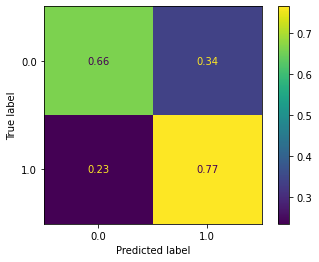

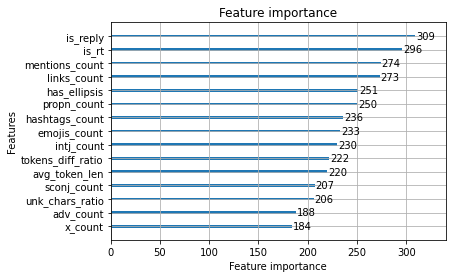

In [53]:
eval_clf(clf_meta_tweet_fe_mean, df_test_meta_tweet_fe_mean)

> Median

In [54]:
df_train_meta_tweet_fe_median = get_median(df_train_meta_tweet_fe, df_train['id'])
df_test_meta_tweet_fe_median = get_median(df_test_meta_tweet_fe, df_test['id'])

clf_meta_tweet_fe_median = get_best_clf(df_train_meta_tweet_fe_median)

[I 2022-03-29 17:38:11,670] A new study created in memory with name: no-name-f5b02218-1a96-4b92-a642-4dde71f80c4e


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:12,427] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 0.00023260753717772688, 'lambda_l2': 7.223175175075481, 'num_leaves': 252, 'feature_fraction': 0.4192626832507376, 'bagging_fraction': 0.42403742475506573, 'bagging_freq': 4, 'learning_rate': 0.00010818916470041478, 'min_child_samples': 51}. Best is trial 3 with value: 0.5.


Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.712826
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:12,627] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 0.005669918433524229, 'lambda_l2': 4.630635623587672e-06, 'num_leaves': 165, 'feature_fraction': 0.4635779845992911, 'bagging_fraction': 0.7910725889222789, 'bagging_freq': 3, 'learning_rate': 0.0011073420272806713, 'min_child_samples': 94}. Best is trial 3 with value: 0.5.


Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.727631
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:12,956] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 0.16193878991098762, 'lambda_l2': 0.6107335604267433, 'num_leaves': 11, 'feature_fraction': 0.6637152758077227, 'bagging_fraction': 0.7234686321270034, 'bagging_freq': 6, 'learning_rate': 5.171600966183966e-05, 'min_child_samples': 67}. Best is trial 3 with value: 0.5.
[I 2022-03-29 17:38:13,097] Trial 6 finished with value: 0.6641808740189221 and parameters: {'lambda_l1': 4.541421054387637e-05, 'lambda_l2': 1.3656839281844233e-06, 'num_leaves': 187, 'feature_fraction': 0.8792252067424317, 'bagging_fraction': 0.8872673253620564, 'bagging_freq': 7, 'learning_rate': 0.015985140794143708, 'min_child_samples': 68}. Best is trial 6 with value: 0.6641808740189221.
[I 2022-03-29 17:38:13,128] Trial 7 finished with value: 0.6585641287079411 and parameters: {'lambda_l1': 2.031552332681386e-06, 'lambda_l2': 1.6180733404065126, 'num_leaves': 79, 'feature_fraction': 0.5111502114215882, 'bagging_fraction': 0.

Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.710686
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.748201
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.741517


[I 2022-03-29 17:38:13,269] Trial 10 finished with value: 0.5 and parameters: {'lambda_l1': 0.0012677414396761373, 'lambda_l2': 0.000394652855811565, 'num_leaves': 5, 'feature_fraction': 0.5181816686733782, 'bagging_fraction': 0.9230224069493719, 'bagging_freq': 7, 'learning_rate': 0.000334705829054375, 'min_child_samples': 46}. Best is trial 6 with value: 0.6641808740189221.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.681495
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:13,567] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 0.11544383641373816, 'lambda_l2': 5.633443879518295, 'num_leaves': 126, 'feature_fraction': 0.948155085322835, 'bagging_fraction': 0.8610136150803185, 'bagging_freq': 6, 'learning_rate': 0.0005408712978607864, 'min_child_samples': 28}. Best is trial 6 with value: 0.6641808740189221.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.736361
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:13,865] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 0.017648041049532066, 'lambda_l2': 1.8826218289091248e-07, 'num_leaves': 175, 'feature_fraction': 0.5320175537440416, 'bagging_fraction': 0.5607419413194652, 'bagging_freq': 1, 'learning_rate': 0.00016244054276044262, 'min_child_samples': 47}. Best is trial 6 with value: 0.6641808740189221.


Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.731227
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:14,210] Trial 12 finished with value: 0.5141204087923553 and parameters: {'lambda_l1': 1.0468974940109354e-08, 'lambda_l2': 7.074498187728118e-05, 'num_leaves': 195, 'feature_fraction': 0.5158029832013931, 'bagging_fraction': 0.7618939253321979, 'bagging_freq': 4, 'learning_rate': 0.003056026738425072, 'min_child_samples': 91}. Best is trial 6 with value: 0.6641808740189221.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.732207
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:14,634] Trial 11 finished with value: 0.6559498968534371 and parameters: {'lambda_l1': 0.5386768669978443, 'lambda_l2': 0.005484496137195527, 'num_leaves': 235, 'feature_fraction': 0.6456464758659379, 'bagging_fraction': 0.9231725789502576, 'bagging_freq': 4, 'learning_rate': 0.014629629139903849, 'min_child_samples': 68}. Best is trial 6 with value: 0.6641808740189221.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.744374
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.74307


[I 2022-03-29 17:38:14,806] Trial 14 finished with value: 0.5934158110639508 and parameters: {'lambda_l1': 0.03701100357759276, 'lambda_l2': 0.0026840115790632162, 'num_leaves': 209, 'feature_fraction': 0.796565599051442, 'bagging_fraction': 0.6352788932781561, 'bagging_freq': 3, 'learning_rate': 0.0066056900242486, 'min_child_samples': 62}. Best is trial 6 with value: 0.6641808740189221.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:15,167] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 0.45218964705877673, 'lambda_l2': 2.745147370443923e-08, 'num_leaves': 131, 'feature_fraction': 0.5224336514441934, 'bagging_fraction': 0.9406524562005243, 'bagging_freq': 1, 'learning_rate': 2.5196377273704174e-05, 'min_child_samples': 8}. Best is trial 6 with value: 0.6641808740189221.


Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.745029
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:15,559] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 6.408294267894619e-06, 'lambda_l2': 1.272411257518475, 'num_leaves': 67, 'feature_fraction': 0.8906408675789044, 'bagging_fraction': 0.8695451398222526, 'bagging_freq': 5, 'learning_rate': 0.000961863470707539, 'min_child_samples': 79}. Best is trial 6 with value: 0.6641808740189221.
[I 2022-03-29 17:38:15,715] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 0.003681100832165062, 'lambda_l2': 1.2215289684344279e-06, 'num_leaves': 88, 'feature_fraction': 0.5844304895182408, 'bagging_fraction': 0.6549876166797172, 'bagging_freq': 2, 'learning_rate': 0.00011217914180814251, 'min_child_samples': 50}. Best is trial 6 with value: 0.6641808740189221.


Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.735293
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.73414


[I 2022-03-29 17:38:15,872] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 0.005503652214988738, 'lambda_l2': 3.434991863829594e-05, 'num_leaves': 148, 'feature_fraction': 0.9884045819768587, 'bagging_fraction': 0.6349214044746285, 'bagging_freq': 7, 'learning_rate': 1.5209278839687911e-05, 'min_child_samples': 8}. Best is trial 6 with value: 0.6641808740189221.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.736802
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:16,029] Trial 13 finished with value: 0.6720798852346287 and parameters: {'lambda_l1': 3.065005830949103e-07, 'lambda_l2': 5.986845916961197e-08, 'num_leaves': 139, 'feature_fraction': 0.6525772840537436, 'bagging_fraction': 0.6757121047485126, 'bagging_freq': 4, 'learning_rate': 0.018982563688566, 'min_child_samples': 30}. Best is trial 13 with value: 0.6720798852346287.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.749149
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:16,563] Trial 18 finished with value: 0.669803547293292 and parameters: {'lambda_l1': 6.285422050943772e-06, 'lambda_l2': 1.883901204059443e-08, 'num_leaves': 92, 'feature_fraction': 0.8669905348974345, 'bagging_fraction': 0.9765354903623054, 'bagging_freq': 1, 'learning_rate': 0.21480534006443358, 'min_child_samples': 80}. Best is trial 13 with value: 0.6720798852346287.


Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.748637
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.739659


[I 2022-03-29 17:38:16,845] Trial 2 finished with value: 0.5983241647499584 and parameters: {'lambda_l1': 2.6366761197777062e-08, 'lambda_l2': 8.319888988229649e-07, 'num_leaves': 205, 'feature_fraction': 0.4593824443741104, 'bagging_fraction': 0.8263789777143867, 'bagging_freq': 3, 'learning_rate': 0.004435043425677862, 'min_child_samples': 17}. Best is trial 13 with value: 0.6720798852346287.
[I 2022-03-29 17:38:17,036] Trial 19 finished with value: 0.6693470941123467 and parameters: {'lambda_l1': 5.747486418034159e-06, 'lambda_l2': 0.054519879105373655, 'num_leaves': 72, 'feature_fraction': 0.8799934265669754, 'bagging_fraction': 0.9995980027433429, 'bagging_freq': 2, 'learning_rate': 0.18779466819648594, 'min_child_samples': 80}. Best is trial 13 with value: 0.6720798852346287.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.743765
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:17,645] Trial 20 finished with value: 0.6675775970407607 and parameters: {'lambda_l1': 1.8188763243490554e-06, 'lambda_l2': 2.563218694110336e-06, 'num_leaves': 70, 'feature_fraction': 0.7665778659374883, 'bagging_fraction': 0.9884798718012007, 'bagging_freq': 2, 'learning_rate': 0.13765216529600074, 'min_child_samples': 82}. Best is trial 13 with value: 0.6720798852346287.
[I 2022-03-29 17:38:17,737] Trial 21 finished with value: 0.6726519337016574 and parameters: {'lambda_l1': 3.544942336374008e-06, 'lambda_l2': 0.06395338755778794, 'num_leaves': 64, 'feature_fraction': 0.7846385491037188, 'bagging_fraction': 0.9512430466857698, 'bagging_freq': 7, 'learning_rate': 0.1518506962351416, 'min_child_samples': 78}. Best is trial 21 with value: 0.6726519337016574.
[I 2022-03-29 17:38:17,817] Trial 22 finished with value: 0.681606122400588 and parameters: {'lambda_l1': 2.8623015710521395e-06, 'lambda_l2': 0.04974160884784578, 'num_leaves': 70, 'feature_fraction': 0.750329

Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.745474
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.74568
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.750618
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.74531


[I 2022-03-29 17:38:17,911] Trial 17 finished with value: 0.6768637516894697 and parameters: {'lambda_l1': 1.2866016203322265e-05, 'lambda_l2': 1.0732538029735041e-08, 'num_leaves': 107, 'feature_fraction': 0.9174407313453035, 'bagging_fraction': 0.6097902780678607, 'bagging_freq': 7, 'learning_rate': 0.15870785587843167, 'min_child_samples': 12}. Best is trial 22 with value: 0.681606122400588.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:18,162] Trial 24 finished with value: 0.6700317738837644 and parameters: {'lambda_l1': 2.6894165042650728e-08, 'lambda_l2': 1.1350506397783801e-08, 'num_leaves': 45, 'feature_fraction': 0.7596865157715064, 'bagging_fraction': 0.9980556775135141, 'bagging_freq': 2, 'learning_rate': 0.15689525581835514, 'min_child_samples': 28}. Best is trial 22 with value: 0.681606122400588.


Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.748901
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:18,413] Trial 25 finished with value: 0.65929623218647 and parameters: {'lambda_l1': 2.697203076453923e-07, 'lambda_l2': 1.0156848198960268e-08, 'num_leaves': 47, 'feature_fraction': 0.7609748170764297, 'bagging_fraction': 0.504262045731097, 'bagging_freq': 2, 'learning_rate': 0.19791848671930498, 'min_child_samples': 33}. Best is trial 22 with value: 0.681606122400588.
[I 2022-03-29 17:38:18,491] Trial 23 finished with value: 0.66343987859531 and parameters: {'lambda_l1': 1.3922484348237363e-07, 'lambda_l2': 1.4767674021489129e-08, 'num_leaves': 109, 'feature_fraction': 0.7849769883360191, 'bagging_fraction': 0.5231171574268324, 'bagging_freq': 5, 'learning_rate': 0.15239632802357508, 'min_child_samples': 29}. Best is trial 22 with value: 0.681606122400588.


Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.740869
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.729214
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.749265

[I 2022-03-29 17:38:18,839] Trial 30 finished with value: 0.6691929670642355 and parameters: {'lambda_l1': 1.4064230327347476e-07, 'lambda_l2': 0.045016693178232085, 'num_leaves': 45, 'feature_fraction': 0.7574540852990811, 'bagging_fraction': 0.5726778991670838, 'bagging_freq': 6, 'learning_rate': 0.06224757642969457, 'min_child_samples': 100}. Best is trial 22 with value: 0.681606122400588.



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.75114


[I 2022-03-29 17:38:19,024] Trial 29 finished with value: 0.6664186801982311 and parameters: {'lambda_l1': 1.759210779060357e-07, 'lambda_l2': 0.0564032683210609, 'num_leaves': 27, 'feature_fraction': 0.7361842716705311, 'bagging_fraction': 0.5488200129470218, 'bagging_freq': 5, 'learning_rate': 0.05766454071591247, 'min_child_samples': 35}. Best is trial 22 with value: 0.681606122400588.
[I 2022-03-29 17:38:19,260] Trial 31 finished with value: 0.6737130391482702 and parameters: {'lambda_l1': 2.807041255013078e-07, 'lambda_l2': 0.06808550408549924, 'num_leaves': 107, 'feature_fraction': 0.7312618860168452, 'bagging_fraction': 0.5771580499277241, 'bagging_freq': 6, 'learning_rate': 0.05761287208503643, 'min_child_samples': 99}. Best is trial 22 with value: 0.681606122400588.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.75285


[I 2022-03-29 17:38:19,448] Trial 32 finished with value: 0.682919166291229 and parameters: {'lambda_l1': 4.8466165174826744e-05, 'lambda_l2': 0.062233307646027775, 'num_leaves': 109, 'feature_fraction': 0.8331787209074666, 'bagging_fraction': 0.5799584893773624, 'bagging_freq': 6, 'learning_rate': 0.06006511022541132, 'min_child_samples': 99}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:19,542] Trial 26 finished with value: 0.6665905911365091 and parameters: {'lambda_l1': 1.8153156411022622e-07, 'lambda_l2': 1.1109992120677096e-08, 'num_leaves': 113, 'feature_fraction': 0.7706788356837472, 'bagging_fraction': 0.5539557799820002, 'bagging_freq': 5, 'learning_rate': 0.23612743416104245, 'min_child_samples': 32}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.751197
Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.735705
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.751224


[I 2022-03-29 17:38:19,636] Trial 33 finished with value: 0.680853271050198 and parameters: {'lambda_l1': 6.759901417936691e-05, 'lambda_l2': 0.034539381835808326, 'num_leaves': 41, 'feature_fraction': 0.8420136314957732, 'bagging_fraction': 0.5802465483862165, 'bagging_freq': 6, 'learning_rate': 0.05166486650149981, 'min_child_samples': 99}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:20,122] Trial 36 finished with value: 0.6701058734261257 and parameters: {'lambda_l1': 3.032832435624741, 'lambda_l2': 0.0034168467164398426, 'num_leaves': 112, 'feature_fraction': 0.8301455658311729, 'bagging_fraction': 0.46724508678119026, 'bagging_freq': 6, 'learning_rate': 0.04650625037574563, 'min_child_samples': 90}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:20,216] Trial 37 finished with value: 0.6441651056363076 and parameters: {'lambda_l1': 8.765582922385905, 'lambda_l2': 0.004079317363851745, 'num_leaves': 123, 'feature_fraction': 0.832853897437775, 'bagging_fraction': 0.44489252865641027, 'bagging_freq': 5, 'learning_rate': 0.03566194088840094, 'min_child_samples': 88}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:20,248] Trial 27 finished with value: 0.6660303985962582 and parameters: {'lambda_l1': 1.4085939145661632e-07, 'lambda_l2': 1.7677935878400206e-08, 'num_leaves': 110, 'feature_fraction': 0.7393560

Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.744028
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.72956
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.747221
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:20,388] Trial 28 finished with value: 0.6645750835842839 and parameters: {'lambda_l1': 1.452334855781551e-07, 'lambda_l2': 1.2770126771944424e-08, 'num_leaves': 104, 'feature_fraction': 0.7527853276764513, 'bagging_fraction': 0.5360357412802316, 'bagging_freq': 5, 'learning_rate': 0.05681535408870374, 'min_child_samples': 34}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.748134
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:20,592] Trial 39 finished with value: 0.6723318236786568 and parameters: {'lambda_l1': 5.8091632719528595e-05, 'lambda_l2': 0.003292944498212892, 'num_leaves': 96, 'feature_fraction': 0.8414305393406394, 'bagging_fraction': 0.46325641545089724, 'bagging_freq': 6, 'learning_rate': 0.03428467011749112, 'min_child_samples': 89}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:20,686] Trial 38 finished with value: 0.6823826856045336 and parameters: {'lambda_l1': 3.180452536164576e-05, 'lambda_l2': 0.010932983760334615, 'num_leaves': 104, 'feature_fraction': 0.8320739365823085, 'bagging_fraction': 0.6075151665315042, 'bagging_freq': 6, 'learning_rate': 0.06354438012149558, 'min_child_samples': 100}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.747749
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.753702


[I 2022-03-29 17:38:20,765] Trial 34 finished with value: 0.6787755198823893 and parameters: {'lambda_l1': 6.147424205234024e-05, 'lambda_l2': 0.13681139477524737, 'num_leaves': 112, 'feature_fraction': 0.6968672681769881, 'bagging_fraction': 0.7221144743083933, 'bagging_freq': 5, 'learning_rate': 0.06292905912757087, 'min_child_samples': 58}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.746439
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.752418


[I 2022-03-29 17:38:20,922] Trial 35 finished with value: 0.6796943542076684 and parameters: {'lambda_l1': 8.700843276515985e-05, 'lambda_l2': 0.01139241847313234, 'num_leaves': 111, 'feature_fraction': 0.8291407139854927, 'bagging_fraction': 0.7142516344188152, 'bagging_freq': 6, 'learning_rate': 0.057017407387684634, 'min_child_samples': 58}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.751772

[I 2022-03-29 17:38:21,267] Trial 40 finished with value: 0.6668692054157874 and parameters: {'lambda_l1': 4.877961020430073e-05, 'lambda_l2': 0.2909875890931229, 'num_leaves': 25, 'feature_fraction': 0.929700563463976, 'bagging_fraction': 0.7218815607259613, 'bagging_freq': 7, 'learning_rate': 0.030871312686579125, 'min_child_samples': 87}. Best is trial 32 with value: 0.682919166291229.



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.735907


[I 2022-03-29 17:38:21,439] Trial 42 finished with value: 0.639579825954995 and parameters: {'lambda_l1': 7.082927995543414e-05, 'lambda_l2': 0.29777023246376905, 'num_leaves': 94, 'feature_fraction': 0.9357630906508866, 'bagging_fraction': 0.6074746021579494, 'bagging_freq': 7, 'learning_rate': 0.007267696815001778, 'min_child_samples': 96}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:21,581] Trial 41 finished with value: 0.6700999454627369 and parameters: {'lambda_l1': 6.957546249604229e-05, 'lambda_l2': 0.25122888477473376, 'num_leaves': 153, 'feature_fraction': 0.9346290482945822, 'bagging_fraction': 0.5931018076616806, 'bagging_freq': 7, 'learning_rate': 0.02826548681888508, 'min_child_samples': 95}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:21,659] Trial 43 finished with value: 0.6322172954259835 and parameters: {'lambda_l1': 7.186697125239777e-05, 'lambda_l2': 0.21337207967338348, 'num_leaves': 26, 'feature_fraction': 0.940763921

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.748054
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.734936
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:21,973] Trial 45 finished with value: 0.6319831408721219 and parameters: {'lambda_l1': 0.00030899682972615396, 'lambda_l2': 0.24102550518303725, 'num_leaves': 146, 'feature_fraction': 0.9569213124230223, 'bagging_fraction': 0.710563122725401, 'bagging_freq': 3, 'learning_rate': 0.006233426439721163, 'min_child_samples': 96}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.731366


[I 2022-03-29 17:38:22,176] Trial 46 finished with value: 0.6233075664524695 and parameters: {'lambda_l1': 0.0005661891636600777, 'lambda_l2': 0.013133830632464578, 'num_leaves': 155, 'feature_fraction': 0.9693146505676421, 'bagging_fraction': 0.8083538113139286, 'bagging_freq': 3, 'learning_rate': 0.005676679110826366, 'min_child_samples': 96}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.729212
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:22,349] Trial 47 finished with value: 0.6498144547459275 and parameters: {'lambda_l1': 0.0005550730619001357, 'lambda_l2': 0.2812162672197072, 'num_leaves': 156, 'feature_fraction': 0.9475527420210089, 'bagging_fraction': 0.8051661452986252, 'bagging_freq': 3, 'learning_rate': 0.010833110143692324, 'min_child_samples': 96}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.736575
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:22,647] Trial 48 finished with value: 0.6460294501221161 and parameters: {'lambda_l1': 0.00031334598001305435, 'lambda_l2': 0.0009453171134138937, 'num_leaves': 153, 'feature_fraction': 0.8128881788506244, 'bagging_fraction': 0.818260466764565, 'bagging_freq': 6, 'learning_rate': 0.008982569657696886, 'min_child_samples': 95}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.743627
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:23,180] Trial 51 finished with value: 0.6807732435444478 and parameters: {'lambda_l1': 0.00032050460465789937, 'lambda_l2': 0.014206614779870142, 'num_leaves': 132, 'feature_fraction': 0.8254403900379073, 'bagging_fraction': 0.8170335989496814, 'bagging_freq': 6, 'learning_rate': 0.0957060466787009, 'min_child_samples': 84}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:23,274] Trial 49 finished with value: 0.6718012709553505 and parameters: {'lambda_l1': 0.00030557383885130315, 'lambda_l2': 0.013991173228525089, 'num_leaves': 154, 'feature_fraction': 0.8133732280107228, 'bagging_fraction': 0.8059486418329767, 'bagging_freq': 6, 'learning_rate': 0.10830960588268018, 'min_child_samples': 74}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:23,321] Trial 50 finished with value: 0.6525768856851539 and parameters: {'lambda_l1': 0.0005648617361641412, 'lambda_l2': 0.015230080180879551, 'num_leaves': 126, 'feature_fraction': 0.976

Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.754615
Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.750537Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.740964

Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:23,509] Trial 52 finished with value: 0.6679718066061224 and parameters: {'lambda_l1': 0.0010173159438022804, 'lambda_l2': 0.013712734553698456, 'num_leaves': 56, 'feature_fraction': 0.8134836328912943, 'bagging_fraction': 0.7616351948656441, 'bagging_freq': 6, 'learning_rate': 0.09893054422909375, 'min_child_samples': 74}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.749774
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:23,682] Trial 54 finished with value: 0.6730224314134636 and parameters: {'lambda_l1': 1.6878726082323843e-05, 'lambda_l2': 0.0009249697394828344, 'num_leaves': 126, 'feature_fraction': 0.8526988074357978, 'bagging_fraction': 0.670900363082744, 'bagging_freq': 6, 'learning_rate': 0.10323687762626932, 'min_child_samples': 75}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:23,761] Trial 53 finished with value: 0.6818521328812275 and parameters: {'lambda_l1': 1.80766451102189e-05, 'lambda_l2': 0.015404246581731161, 'num_leaves': 55, 'feature_fraction': 0.8115344776101656, 'bagging_fraction': 0.7698169917615953, 'bagging_freq': 6, 'learning_rate': 0.09610451871145637, 'min_child_samples': 73}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.751242
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.753877
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:24,074] Trial 55 finished with value: 0.6682622768121784 and parameters: {'lambda_l1': 1.7805215400245573e-05, 'lambda_l2': 0.017506406380231074, 'num_leaves': 129, 'feature_fraction': 0.6999600490775735, 'bagging_fraction': 0.6743351657366797, 'bagging_freq': 6, 'learning_rate': 0.10943007115530072, 'min_child_samples': 73}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.747003
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.740287


[I 2022-03-29 17:38:24,387] Trial 44 finished with value: 0.6503450074692338 and parameters: {'lambda_l1': 4.406021194633293e-05, 'lambda_l2': 0.25294037307712297, 'num_leaves': 161, 'feature_fraction': 0.9229322035324341, 'bagging_fraction': 0.6015505399260951, 'bagging_freq': 7, 'learning_rate': 0.008726129913209642, 'min_child_samples': 20}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:24,764] Trial 58 finished with value: 0.6739471937021316 and parameters: {'lambda_l1': 2.63150022396753e-05, 'lambda_l2': 0.000837624524000285, 'num_leaves': 82, 'feature_fraction': 0.8567635714879841, 'bagging_fraction': 0.7612999821636537, 'bagging_freq': 6, 'learning_rate': 0.09533133626742214, 'min_child_samples': 85}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:24,811] Trial 57 finished with value: 0.6724059232210182 and parameters: {'lambda_l1': 2.503108437261685e-05, 'lambda_l2': 3.1323326764012553, 'num_leaves': 129, 'feature_fraction': 0.7083845771413, 'bagging_fraction': 0.7781769567616492, 'bagging_freq': 6, 'learning_rate': 0.08655716903002954, 'min_child_samples': 84}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:24,921] Trial 56 finished with value: 0.6770178787375809 and parameters: {'lambda_l1': 1.7631152544454168e-05, 'lambda_l2': 0.015435334225741733, 'num_leaves': 132, 'feature_fraction': 0.7167846539

Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.751358Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.751717

Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.749266


[I 2022-03-29 17:38:25,093] Trial 59 finished with value: 0.6699398904512366 and parameters: {'lambda_l1': 9.555229891616351e-07, 'lambda_l2': 0.0011077508392801794, 'num_leaves': 134, 'feature_fraction': 0.8556567801030753, 'bagging_fraction': 0.843015316610634, 'bagging_freq': 6, 'learning_rate': 0.019767954786366154, 'min_child_samples': 84}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.747586
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.74149


[I 2022-03-29 17:38:25,172] Trial 61 finished with value: 0.6694271216180969 and parameters: {'lambda_l1': 9.055058866301652e-07, 'lambda_l2': 3.054930456761589, 'num_leaves': 80, 'feature_fraction': 0.7039710841956114, 'bagging_fraction': 0.7623106073195411, 'bagging_freq': 4, 'learning_rate': 0.298757915527486, 'min_child_samples': 84}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:25,470] Trial 60 finished with value: 0.6653575747516183 and parameters: {'lambda_l1': 1.9954576770467716e-05, 'lambda_l2': 0.00013462822984929528, 'num_leaves': 84, 'feature_fraction': 0.8925963333554314, 'bagging_fraction': 0.8450487180156474, 'bagging_freq': 6, 'learning_rate': 0.29904205346532414, 'min_child_samples': 83}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.741564
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:25,736] Trial 62 finished with value: 0.665209375666896 and parameters: {'lambda_l1': 1.1927066642958685e-06, 'lambda_l2': 9.059209766827018e-05, 'num_leaves': 80, 'feature_fraction': 0.900842336684792, 'bagging_fraction': 0.8491328952908295, 'bagging_freq': 4, 'learning_rate': 0.2815594567935225, 'min_child_samples': 82}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:25,852] Trial 68 finished with value: 0.5 and parameters: {'lambda_l1': 0.00013645870157050194, 'lambda_l2': 6.878565098909026e-05, 'num_leaves': 13, 'feature_fraction': 0.8783531265769912, 'bagging_fraction': 0.6306279962983652, 'bagging_freq': 1, 'learning_rate': 1.1026915234809792e-05, 'min_child_samples': 61}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.741346
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.713966
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:26,018] Trial 63 finished with value: 0.6608760344296114 and parameters: {'lambda_l1': 1.0165501564514692e-06, 'lambda_l2': 4.6008258581214685, 'num_leaves': 80, 'feature_fraction': 0.9017714096023622, 'bagging_fraction': 0.8558430719045109, 'bagging_freq': 4, 'learning_rate': 0.020388199222982857, 'min_child_samples': 84}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.748266
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.749449
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:26,175] Trial 64 finished with value: 0.6637125649111991 and parameters: {'lambda_l1': 2.242333973645325e-06, 'lambda_l2': 5.911312397243294e-05, 'num_leaves': 36, 'feature_fraction': 0.9003233232704889, 'bagging_fraction': 0.8826111832045176, 'bagging_freq': 5, 'learning_rate': 0.01672719713875719, 'min_child_samples': 85}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:26,347] Trial 66 finished with value: 0.6713211059208498 and parameters: {'lambda_l1': 1.8362050206781309e-06, 'lambda_l2': 0.0002244943728876439, 'num_leaves': 177, 'feature_fraction': 0.8926052735645978, 'bagging_fraction': 0.6443970272507296, 'bagging_freq': 4, 'learning_rate': 0.02104170085786202, 'min_child_samples': 91}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.748638
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:26,567] Trial 65 finished with value: 0.6638222322338937 and parameters: {'lambda_l1': 1.3895503486622238e-06, 'lambda_l2': 1.134335791955876, 'num_leaves': 79, 'feature_fraction': 0.898625170151708, 'bagging_fraction': 0.8406721330097034, 'bagging_freq': 4, 'learning_rate': 0.29394633653141033, 'min_child_samples': 92}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:26,740] Trial 67 finished with value: 0.667731724088872 and parameters: {'lambda_l1': 0.00015060142240719954, 'lambda_l2': 0.0001119857757863898, 'num_leaves': 176, 'feature_fraction': 0.9011086892349989, 'bagging_fraction': 0.9101478415203103, 'bagging_freq': 4, 'learning_rate': 0.2940868418099398, 'min_child_samples': 91}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.739228
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.74598
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.751617


[I 2022-03-29 17:38:27,085] Trial 69 finished with value: 0.6681022218006781 and parameters: {'lambda_l1': 0.0037769291867363426, 'lambda_l2': 0.006699260426834833, 'num_leaves': 55, 'feature_fraction': 0.7922899014568051, 'bagging_fraction': 0.636529270820743, 'bagging_freq': 1, 'learning_rate': 0.024014880931246905, 'min_child_samples': 63}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:27,195] Trial 71 finished with value: 0.6694893652336804 and parameters: {'lambda_l1': 0.002843043524159641, 'lambda_l2': 0.007130432039024763, 'num_leaves': 37, 'feature_fraction': 0.7934598082874468, 'bagging_fraction': 0.6993754041456176, 'bagging_freq': 5, 'learning_rate': 0.02312032281791007, 'min_child_samples': 43}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.752256
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:27,414] Trial 70 finished with value: 0.6767659402935529 and parameters: {'lambda_l1': 0.00017259852100526716, 'lambda_l2': 0.02923419529563196, 'num_leaves': 63, 'feature_fraction': 0.8005509961727575, 'bagging_fraction': 0.6337555932533113, 'bagging_freq': 1, 'learning_rate': 0.023838221097299783, 'min_child_samples': 61}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:27,508] Trial 73 finished with value: 0.5386799611125602 and parameters: {'lambda_l1': 0.003328341492664957, 'lambda_l2': 1.3868331860683992e-05, 'num_leaves': 63, 'feature_fraction': 0.797097390504374, 'bagging_fraction': 0.689120320934027, 'bagging_freq': 5, 'learning_rate': 0.0026088660427242153, 'min_child_samples': 92}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.752509
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.733066
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.738666


[I 2022-03-29 17:38:27,602] Trial 72 finished with value: 0.5562593365423375 and parameters: {'lambda_l1': 8.678090527185558e-06, 'lambda_l2': 0.6438355750395146, 'num_leaves': 59, 'feature_fraction': 0.7942308286273456, 'bagging_fraction': 0.9060391066523007, 'bagging_freq': 5, 'learning_rate': 0.003636092637626518, 'min_child_samples': 92}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:28,261] Trial 75 finished with value: 0.5580288336139236 and parameters: {'lambda_l1': 0.002704217100381352, 'lambda_l2': 0.006924085210664579, 'num_leaves': 58, 'feature_fraction': 0.7804246463490718, 'bagging_fraction': 0.6987635076562064, 'bagging_freq': 5, 'learning_rate': 0.0030196337994674895, 'min_child_samples': 54}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.740463
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:28,496] Trial 77 finished with value: 0.6785413653285277 and parameters: {'lambda_l1': 3.972231750445349e-06, 'lambda_l2': 0.027657693992659826, 'num_leaves': 100, 'feature_fraction': 0.8043433668390944, 'bagging_fraction': 0.40055455995213124, 'bagging_freq': 5, 'learning_rate': 0.043627730193505576, 'min_child_samples': 42}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:28,575] Trial 74 finished with value: 0.5508886017119958 and parameters: {'lambda_l1': 0.002879183576022389, 'lambda_l2': 0.006356468215931682, 'num_leaves': 64, 'feature_fraction': 0.7912357025205868, 'bagging_fraction': 0.9504396634824746, 'bagging_freq': 5, 'learning_rate': 0.00371347897729702, 'min_child_samples': 55}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:28,606] Trial 76 finished with value: 0.5524980437720817 and parameters: {'lambda_l1': 0.0027245698629515787, 'lambda_l2': 0.029966617486333343, 'num_leaves': 61, 'feature_fraction': 0.79251

Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.754419
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.740062
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.742188
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:29,061] Trial 78 finished with value: 0.6751683541602447 and parameters: {'lambda_l1': 6.684664615374322e-06, 'lambda_l2': 0.11170756747242318, 'num_leaves': 98, 'feature_fraction': 0.6033841627432976, 'bagging_fraction': 0.7412397596047002, 'bagging_freq': 5, 'learning_rate': 0.03609006706047547, 'min_child_samples': 55}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.750258
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.736924


[I 2022-03-29 17:38:29,233] Trial 79 finished with value: 0.5112038508050174 and parameters: {'lambda_l1': 5.121182473221236e-06, 'lambda_l2': 0.10235628251164143, 'num_leaves': 120, 'feature_fraction': 0.6802545570317993, 'bagging_fraction': 0.7460018779081875, 'bagging_freq': 5, 'learning_rate': 0.0019506026957051194, 'min_child_samples': 56}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:29,343] Trial 80 finished with value: 0.6737812107272426 and parameters: {'lambda_l1': 0.0001184411766466941, 'lambda_l2': 0.11228638201863878, 'num_leaves': 99, 'feature_fraction': 0.6722715745047899, 'bagging_fraction': 0.7318895071456452, 'bagging_freq': 5, 'learning_rate': 0.042117714407111706, 'min_child_samples': 56}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:29,437] Trial 81 finished with value: 0.6653457188248405 and parameters: {'lambda_l1': 9.566373283255071e-06, 'lambda_l2': 0.09982512262846084, 'num_leaves': 118, 'feature_fraction': 0.67943

Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.749126
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.745674
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:29,782] Trial 83 finished with value: 0.6776225310032484 and parameters: {'lambda_l1': 9.406436801482574e-06, 'lambda_l2': 0.13225949759663963, 'num_leaves': 116, 'feature_fraction': 0.6182515377666102, 'bagging_fraction': 0.7325988062631765, 'bagging_freq': 7, 'learning_rate': 0.07300117417272523, 'min_child_samples': 100}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.758308
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:30,001] Trial 84 finished with value: 0.6755447798354397 and parameters: {'lambda_l1': 9.173965301820138e-06, 'lambda_l2': 0.0021004846899978684, 'num_leaves': 115, 'feature_fraction': 0.6057078773884308, 'bagging_fraction': 0.7390544686103394, 'bagging_freq': 7, 'learning_rate': 0.04384218586018499, 'min_child_samples': 99}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:30,142] Trial 86 finished with value: 0.6730965309558249 and parameters: {'lambda_l1': 0.0001231350229148241, 'lambda_l2': 0.10436637791815519, 'num_leaves': 72, 'feature_fraction': 0.8299073695119777, 'bagging_fraction': 0.5799922666358968, 'bagging_freq': 6, 'learning_rate': 0.07470918280470573, 'min_child_samples': 100}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.750883
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.75229
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.749976


[I 2022-03-29 17:38:30,221] Trial 82 finished with value: 0.6703341000165983 and parameters: {'lambda_l1': 8.166285347432673e-06, 'lambda_l2': 0.13680327134263578, 'num_leaves': 120, 'feature_fraction': 0.6740145653197832, 'bagging_fraction': 0.7304800862598358, 'bagging_freq': 7, 'learning_rate': 0.042689807443518676, 'min_child_samples': 55}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:30,394] Trial 87 finished with value: 0.6722636520996846 and parameters: {'lambda_l1': 9.833050068622608e-05, 'lambda_l2': 0.12708455898743368, 'num_leaves': 116, 'feature_fraction': 0.834425220745004, 'bagging_fraction': 0.501007587344858, 'bagging_freq': 7, 'learning_rate': 0.0759925121827961, 'min_child_samples': 70}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.749025


[I 2022-03-29 17:38:30,582] Trial 88 finished with value: 0.665289403172646 and parameters: {'lambda_l1': 3.6078877491258383e-06, 'lambda_l2': 0.0016647215612157484, 'num_leaves': 116, 'feature_fraction': 0.8296152027519992, 'bagging_fraction': 0.40304109635352053, 'bagging_freq': 7, 'learning_rate': 0.07552248917660603, 'min_child_samples': 50}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:30,692] Trial 85 finished with value: 0.6725600502691296 and parameters: {'lambda_l1': 9.326567762500583e-06, 'lambda_l2': 0.10348516183145239, 'num_leaves': 118, 'feature_fraction': 0.6757221298987138, 'bagging_fraction': 0.7350889591477929, 'bagging_freq': 7, 'learning_rate': 0.045903333970829685, 'min_child_samples': 58}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.743014
Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.754476
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.755178


[I 2022-03-29 17:38:30,761] Trial 89 finished with value: 0.6787014203400279 and parameters: {'lambda_l1': 3.914423219962258e-06, 'lambda_l2': 0.03365092180327181, 'num_leaves': 103, 'feature_fraction': 0.8292721153412824, 'bagging_fraction': 0.5063352943825814, 'bagging_freq': 6, 'learning_rate': 0.06255506115690938, 'min_child_samples': 70}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:31,084] Trial 91 finished with value: 0.6722636520996846 and parameters: {'lambda_l1': 3.29637215600227e-05, 'lambda_l2': 0.0270650147624605, 'num_leaves': 142, 'feature_fraction': 0.820113934254428, 'bagging_fraction': 0.40007860824254293, 'bagging_freq': 6, 'learning_rate': 0.07435041489518093, 'min_child_samples': 70}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.744097
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:31,303] Trial 90 finished with value: 0.6680399781850948 and parameters: {'lambda_l1': 3.346826562381308e-05, 'lambda_l2': 0.033641114609285955, 'num_leaves': 140, 'feature_fraction': 0.8274983662827523, 'bagging_fraction': 0.5002639356610816, 'bagging_freq': 6, 'learning_rate': 0.14506986371871627, 'min_child_samples': 50}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:31,444] Trial 92 finished with value: 0.6729483318711024 and parameters: {'lambda_l1': 4.3455743759946246e-05, 'lambda_l2': 0.038478969648534186, 'num_leaves': 103, 'feature_fraction': 0.4033425207328196, 'bagging_fraction': 0.48778362056071034, 'bagging_freq': 6, 'learning_rate': 0.1323477988942261, 'min_child_samples': 70}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.745655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.746694


[I 2022-03-29 17:38:31,664] Trial 93 finished with value: 0.6866863870248737 and parameters: {'lambda_l1': 4.312678621315161e-05, 'lambda_l2': 0.03211260786751202, 'num_leaves': 139, 'feature_fraction': 0.8409945389643779, 'bagging_fraction': 0.5007851082890684, 'bagging_freq': 6, 'learning_rate': 0.13447034275325662, 'min_child_samples': 50}. Best is trial 93 with value: 0.6866863870248737.
[I 2022-03-29 17:38:31,789] Trial 94 finished with value: 0.6668810613425652 and parameters: {'lambda_l1': 3.4858577836912844e-05, 'lambda_l2': 0.0316868321014017, 'num_leaves': 139, 'feature_fraction': 0.7471154040313047, 'bagging_fraction': 0.4006595419119784, 'bagging_freq': 6, 'learning_rate': 0.13241988326288753, 'min_child_samples': 39}. Best is trial 93 with value: 0.6866863870248737.


Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.751824
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.745264
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.749314

[I 2022-03-29 17:38:31,852] Trial 95 finished with value: 0.6804590614848363 and parameters: {'lambda_l1': 3.821738842193058e-05, 'lambda_l2': 0.026845348727302237, 'num_leaves': 140, 'feature_fraction': 0.4143645458346546, 'bagging_fraction': 0.6591971280817563, 'bagging_freq': 6, 'learning_rate': 0.12992601279697294, 'min_child_samples': 78}. Best is trial 93 with value: 0.6866863870248737.
[I 2022-03-29 17:38:31,915] Trial 97 finished with value: 0.5 and parameters: {'lambda_l1': 3.5619274220216595e-05, 'lambda_l2': 0.036336451091603474, 'num_leaves': 92, 'feature_fraction': 0.8732577848017486, 'bagging_fraction': 0.539692741042342, 'bagging_freq': 6, 'learning_rate': 0.0006508122323456033, 'min_child_samples': 66}. Best is trial 93 with value: 0.6866863870248737.
[I 2022-03-29 17:38:31,963] Trial 98 finished with value: 0.6772461053280536 and parameters: {'lambda_l1': 5.691594388598966e-07, 'lambda_l2': 0.03892635578252454, 'num_leaves': 89, 'feature_fraction': 0.8684384160152324, 


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.732206
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.747503
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.745615
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.74383


[I 2022-03-29 17:38:32,040] Trial 99 finished with value: 0.6781649396533328 and parameters: {'lambda_l1': 3.0643194152818526e-06, 'lambda_l2': 0.5308969013627244, 'num_leaves': 89, 'feature_fraction': 0.8473461119999801, 'bagging_fraction': 0.4743844848483918, 'bagging_freq': 6, 'learning_rate': 0.12943538126789064, 'min_child_samples': 77}. Best is trial 93 with value: 0.6866863870248737.


{'lambda_l1': 4.312678621315161e-05, 'lambda_l2': 0.03211260786751202, 'num_leaves': 139, 'feature_fraction': 0.8409945389643779, 'bagging_fraction': 0.5007851082890684, 'bagging_freq': 6, 'learning_rate': 0.13447034275325662, 'min_child_samples': 50} -> 0.6866863870248737
[LightGBM] [Warning] feature_fraction is set=0.8409945389643779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8409945389643779
[LightGBM] [Warning] lambda_l1 is set=4.312678621315161e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.312678621315161e-05
[LightGBM] [Warning] bagging_fraction is set=0.5007851082890684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5007851082890684
[LightGBM] [Warning] lambda_l2 is set=0.03211260786751202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03211260786751202
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't imp

AUROC: 0.6720591620626151
Accuracy: 0.6779374471682164


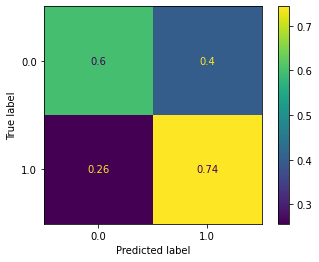

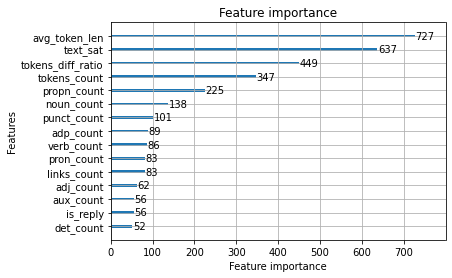

In [55]:
eval_clf(clf_meta_tweet_fe_median, df_test_meta_tweet_fe_median)

# TODO: Combine models on users metadata + tweets metadata

# Detection on tweets content

In [56]:
X_train_tweet, y_train_tweet = df_train['tweet'], df_train['label']
X_test_tweet, y_test_tweet = df_test['tweet'], df_test['label']

X_train_tweet.head()

0    Gustave Courbet was often called 'the most arr...
1                                   An animal MackLibs
2                                I hope it's 900 gems.
3    Delhi : Social Welfare Minister AdvRajendraPal...
4    I wouldn't even consider going on holiday now,...
Name: tweet, dtype: object

## Encoding hashtags

> __Meh__

In [7]:
hashtags_count = []
for _, hashtags in tqdm(df_train['hashtags'].iteritems(), total=len(df_train)):
    hashtags_count += hashtags
hashtags_count = Counter(hashtags_count)
hashtags_count

  0%|          | 0/1398465 [00:00<?, ?it/s]

Counter({'Sponsored': 39,
         'HandShaq': 1,
         'ad': 465,
         'lsunationalchamps': 1,
         'WeWantToPlay': 22,
         'SharkWeek': 124,
         'LeadingThroughChange': 2,
         'MyStartingFive': 4,
         'SHAQvsGRONK': 1,
         'fortopartner': 2,
         'ShotForHeroes': 1,
         'sanitation': 5,
         'NRGFAM': 14,
         'BETAwards': 52,
         'BiteSizedGlory': 1,
         'GeauxTigers': 62,
         'frostedflakespartner': 1,
         'RingPartner': 1,
         'healthcareheroes': 19,
         'ShareMyHero': 1,
         'jcppartner': 1,
         'shaqlife': 4,
         'TNTpartner': 4,
         'MothersDay': 87,
         'FastFoto': 2,
         'FastFotoSweepstakes': 1,
         'EpsonPartner': 1,
         'NFLdraft': 2,
         'Shaqcast': 1,
         'Prince': 13,
         'HatsOff': 2,
         'JCPpartner': 1,
         'throwback': 80,
         'TNTPartner': 1,
         'PapaJohnsPartner': 1,
         'PostForPencils': 1,
         'S

In [8]:
hashtags_best = hashtags_count.most_common()
hashtags_best_label = [ c[0] for c in hashtags_best ]
hashtags_best_count = [ c[1] for c in hashtags_best ]

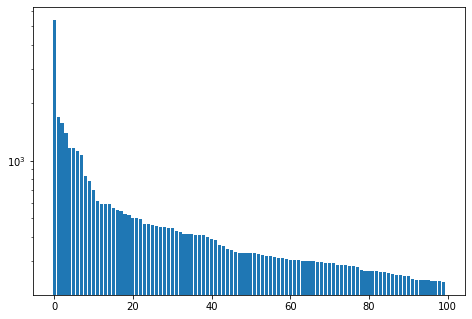

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_yscale('log')
langs = list(range(100))
students = hashtags_best_count[:100]
ax.bar(langs,students)
plt.show()

In [ ]:
lim = 41
hashtags_best_label = hashtags_best_label[:lim]

> __Wouldn't it be smarter to use hashtags from the Ukraine dataset?__

In [21]:
# To remove if above cells are unfrozen
hashtags_best_label = [ ht for ht, c in hashtags_count.items() if c > 10 ]
len(hashtags_best_label)

8268

In [22]:
hashtags_filtered = { ht: i for i, ht in enumerate(hashtags_best_label) }

def encode_hashtag(hashtags: list):
    most_common = None
    for ht in hashtags:
        if ht in hashtags_filtered:
            i = hashtags_filtered[ht]
            if most_common is None or i < most_common:
                most_common = i
    if most_common is None:
        most_common = np.nan
    return most_common

df_train['hashtags_enc'] = df_train['hashtags'].apply(encode_hashtag)
df_test['hashtags_enc'] = df_test['hashtags'].apply(encode_hashtag)
print(round(100 * df_train['hashtags_enc'].count() / len(df_train['hashtags_enc']), 3), "%")
df_train['hashtags_enc'].head()

13.578 %


0    NaN
1    NaN
2    0.0
3    1.0
4    NaN
Name: hashtags_enc, dtype: float64

In [57]:
import spacy
nlp = spacy.load('en_core_web_sm')
#TODO preprocess the corpus using spacy or load the pre-processed corpus

def preprocess(text, nlp=nlp):
    return [
        token for token in nlp(text)
        if not token.is_punct and not token.is_stop
    ]

df['text_clean'] = df['text'].progress_apply(preprocess)
df['text_clean'].head()

NameError: name 'df' is not defined

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(dfs['text'])

In [ ]:
from gensim.models import Word2Vec

##TODO train a word2vec model on this dataset, only consider words which appear at least 10 times in the corpus
w2v = Word2Vec(dataset, min_count=10)

In [ ]:
text = extract_artefacts(df_train.iloc[0]['tweet'])[0]
text

> Doc2Vec

In [ ]:
from nltk import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

doc = [TaggedDocument(word_tokenize(text), [0])]
d2v = Doc2Vec(doc,
                min_count=10, # minimum word count
                window=10,    # window size
                vector_size=100, # size of document vector
                sample=1e-4, 
                negative=5, 
                workers=4, # threads
                #dbow_words = 1 # uncomment to get word vectors too
                max_vocab_size=1000) # max vocab size
                     
D = d2v.docvecs.vectors_docs

> SpaCy

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

nlp(text).vector

> Tensorflow

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import tensorflow_hub as hub
import numpy as np

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

In [ ]:
embeddings = model(text)

with tf.Session() as session:
    session.run([ tf.global_variables_initializer(), tf.tables_initializer() ])
    text_encoded = session.run(embeddings)

> Transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = "bert-base-nli-mean-tokens"
embedder = SentenceTransformer(model)

In [ ]:
text_encoded = embedder.encode(text)
text_encoded

# Train final model on several subsample of data (change proportion of bots in dataset)